In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
# Load the data
df_collabs = pd.read_csv('collab_with_timestamps.csv')
df_history =pd.read_csv('df_channel_history_collabs.txt', delimiter='\t')
df_collab_info = pd.read_csv('df_collabs.txt', delimiter='\t')

# Merge the data based on channel IDs
df_merged = pd.merge(df_collabs, df_history, left_on='from', right_on='channelID', how='left')
df_merged.head()

,from,to,video_id,video_timestamp,id,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp,gradient,p_gradient,collab_window,viewCount_gradient,p_viewCount_gradient
0,UCq6VFHwMzcMXbuKyG7SQYIg,UCmA-0j6DRVQWo4skl8Otkiw,['khyg5YJlLPI'],"[Timestamp('2017-01-11 14:00:04+0000', tz='UTC')]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UCq6VFHwMzcMXbuKyG7SQYIg,UCCYHZKyLdUnT7BsGfCQgQ-Q,['qP8HTuEu7BY'],"[Timestamp('2017-01-09 22:00:01+0000', tz='UTC')]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UClpEE-Led9ZK0GJQKvU--3Q,UCIKF1msqN7lW9gplsifOPkQ,['On4GE5hAU8s'],"[Timestamp('2017-02-11 17:10:18+0000', tz='UTC')]",4317.0,UClpEE-Led9ZK0GJQKvU--3Q,10154306.0,79660.0,2.0,180.0,2016-12-28 03:00:32,NaN,NaN,NaN,NaN,NaN
3,UClpEE-Led9ZK0GJQKvU--3Q,UCIKF1msqN7lW9gplsifOPkQ,['On4GE5hAU8s'],"[Timestamp('2017-02-11 17:10:18+0000', tz='UTC')]",12269.0,UClpEE-Led9ZK0GJQKvU--3Q,10169252.0,79744.0,2.0,180.0,2016-12-29 00:03:26,84.0,0.105448,NaN,14946.0,0.147189
4,UClpEE-Led9ZK0GJQKvU--3Q,UCIKF1msqN7lW9gplsifOPkQ,['On4GE5hAU8s'],"[Timestamp('2017-02-11 17:10:18+0000', tz='UTC')]",20220.0,UClpEE-Led9ZK0GJQKvU--3Q,10194712.0,79812.0,2.0,180.0,2016-12-30 00:03:25,68.0,0.085273,NaN,25460.0,0.250363


In [3]:
# # Step 5: Merge the channel history with the collaboration timestamps to track channel performance
# df_from_channel_history = pd.merge(df_collab_timestamps_cleaned, df_channel_history, left_on='from', right_on='channelID', how='left')
# df_to_channel_history = pd.merge(df_collab_timestamps_cleaned, df_channel_history, left_on='to', right_on='channelID', how='left', suffixes=('_from', '_to'))

# # Debug: Check merged dataframes
# print("Merged 'from' channel history:", df_from_channel_history.head())
# print("Merged 'to' channel history:", df_to_channel_history.head())


In [4]:
# Crawled channel history
channels_df = pd.read_csv('df_channel_history_collabs.txt', sep='\t')

# Collaboration graph with features
collabs_df = pd.read_csv('df_collabs.txt', sep='\t')

# Video collaborations and timestamps
videos_df = pd.read_csv('collab_with_timestamps.csv')


In [5]:
# Drop rows without both 'from' and 'to' in collab file
collabs_df = collabs_df.dropna(subset=['from', 'to'])

# Fill missing numerical values with 0
channels_df.fillna(0, inplace=True)

# Keep only the latest record per channel (if duplicates)
channels_latest = channels_df.sort_values('crawlTimestamp').groupby('channelID').last().reset_index()


In [6]:
def detect_high_dissimilarity_collabs(collabs_df, channels_df):
    df = collabs_df.merge(channels_df, left_on='from', right_on='channelID') \
                   .merge(channels_df, left_on='to', right_on='channelID', suffixes=('_from', '_to'))

    df['popularity_diff'] = np.abs(df['subscriberCount_from'] - df['subscriberCount_to']) / (df['subscriberCount_from'] + 1)
    df['category_mismatch'] = (df['from_category'] != df['to_category']).astype(int)

    df['dissimilarity_score'] = (
        0.7 * df['popularity_diff'] +
        0.3 * df['category_mismatch']
    )

    threshold = df['dissimilarity_score'].quantile(0.95)
    
    return df[df['dissimilarity_score'] > threshold][['from', 'to', 'dissimilarity_score']] \
             .sort_values(by='dissimilarity_score', ascending=False)

unusual_feature_collabs = detect_high_dissimilarity_collabs(collabs_df, channels_latest)

print("Top Feature-Based Unusual Collaborations (Sorted):")
display(unusual_feature_collabs)


Top Feature-Based Unusual Collaborations (Sorted):


,from,to,dissimilarity_score
675,UCI0dCXeX5mbhnZPK0atXjbw,UCMJ5Qf3sOvQpcYiai1Noa3Q,8011.046330
1021,UCaWbo0qMCnwpNfNxDHnIJdQ,UCBXdEOYkIEqr3UHLKj7V7sQ,2790.942105
334,UCbTRgghKvt-I_V8CUtCPyrA,UCEq19675KJXfZ5kdOubyPYw,2192.574359
333,UCbTRgghKvt-I_V8CUtCPyrA,UCCJrkoCBepsJN2QUauufOPA,1519.271795
515,UCyzPCm19srBJyu9wjS1hkwA,UCJb7_Qsz9pNQDcOA4YA6TxA,1495.861490
...,...,...,...
688,UC_zWAcy2dNAUt3BmjVb7MkA,UCKxOb-Q_Cq9bKXqJRDBxGcg,29.692170
710,UCc069pUWlQVZyFYpgiau8KQ,UCyG_mUXBIWaoLkuiRnAWDvA,29.477803
512,UCS9p1CJdLm_nfokfe8HVa2A,UCH2VZQBLFTOp6I_qgnBJCuQ,29.121410
1513,UCEEVeH_OhEZ3XOswJbWjrbQ,UCUrH0l0UiATVLWJIKJ4VxWg,28.956202


In [7]:
def detect_cross_community_edges(collabs_df):
    G = nx.from_pandas_edgelist(collabs_df, 'from', 'to', ['weight'])
    communities = list(greedy_modularity_communities(G))
    node_to_comm = {node: idx for idx, comm in enumerate(communities) for node in comm}

    collabs_df['cross_community'] = collabs_df.apply(
        lambda row: node_to_comm.get(row['from']) != node_to_comm.get(row['to']),
        axis=1
    )
    return collabs_df[collabs_df['cross_community']]

unusual_community_collabs = detect_cross_community_edges(collabs_df)
print("Top Cross-Community Collaborations:")
display(unusual_community_collabs[['from', 'to', 'weight']])

Top Cross-Community Collaborations:


,from,to,weight
2,UClpEE-Led9ZK0GJQKvU--3Q,UCIKF1msqN7lW9gplsifOPkQ,1
10,UCi7TVXyvrIwqeS9tfYD8UDA,UCvGiJYBPgVP7W1ypE3DKOqA,1
17,UCo9ExXwpxwBaYRM4mkD_J4A,UCJitJPaU9ClQ7ivDKEzLNuA,1
19,UCo9ExXwpxwBaYRM4mkD_J4A,UCj3ygUfAdUPlbaXrmjEYWfQ,1
22,UCjtLOfx1yt1NlnFIDyAX3Ug,UCfNWN9s_s8kRTCadk04WWJA,1
...,...,...,...
3453,UCCh61qjv5H3nvZEBH1-aM1Q,UCEcjuLw9wMPsAd0tVYa8kCg,1
3454,UCCh61qjv5H3nvZEBH1-aM1Q,UC1KXgBCWqWsOdbfM-9L-Hlg,1
3457,UCCh61qjv5H3nvZEBH1-aM1Q,UCTFMzvK7ckcS-IAe3JGVyLg,1
3459,UCCh61qjv5H3nvZEBH1-aM1Q,UCjXM0DCvaPypeEx12xxGKCQ,1


In [8]:
#!/usr/bin/env python
# coding=utf-8

# Evaluates channel popularity statistics based on collaboration data
# Channel subscriber and view count gradient and % growth plots

import pandas as pa 
import numpy as np

import json
import os
import networkx as nx
# import pygraphviz as gz
from networkx.drawing.nx_pydot import write_dot
import math


from scipy.stats import norm, normaltest, mannwhitneyu, ranksums

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import itertools

import csv
# from sqlalchemy import exists, func

# from database import *

from matplotlib import pylab, pyplot
from matplotlib import dates

import seaborn as sns
sns.set(color_codes=True)

current_palette = sns.color_palette()
first = current_palette[0]
second = current_palette[1]
sns.set_palette(
    [second, first] + current_palette[2:]
)

from scipy import stats, integrate

from datetime import datetime, timedelta, date

date_format = '%Y-%m-%dT%H:%M:%S.%fZ'
date_format2 = '%Y-%m-%d %H:%M:%S'

# plt.style.use(['seaborn-paper'])
sns.set_style("whitegrid")
#plt.rc('font', family='serif', serif='Charter')
plt.rc('font', family='serif', serif='DejaVu Serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x_width  = 6.8898
x_height = x_width / 1.618

s_width  = 3.4449
s_height = s_width / 1.618

def save_plot(name, fig, width, height):
    #fig.tight_layout()
    fig.set_size_inches(width, height)
    #f.subplots_adjust(top=0.86)

    fig.savefig(CDIR+'/'+name, bbox_inches="tight")
    #plt.savefig(CDIR+'/video_view_percentages.pdf', bbox_inches="tight")


In [9]:
cols_to_use = ["channelID", "viewCount", "subscriberCount", "commentCount", "videoCount", "crawlTimestamp"]

# Load the file using only the selected columns
df_channel_history_collabs = pd.read_csv("df_channel_history_collabs.txt", usecols=cols_to_use, sep="\t")  # Use sep="\t" if it's tab-separated

channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])
df_channel_history_collabs.head()


,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp
0,UC-63s9JLCZqIDlhXK6VHb7w,8834171.0,27606,0,89,2016-12-28 02:57:14
1,UC-4kjzuh4822B9yPSgpZQgA,28671226.0,1234411,0,49,2016-12-28 02:57:14
2,UC-A4oZF4AlOEdlyZWBCI0cQ,337690529.0,1642619,3676,549,2016-12-28 02:57:14
3,UC-aJ5-YxVUH77ro5MGJt7Dg,52026141.0,184264,0,239,2016-12-28 02:57:14
4,UC-CRXGRabkMD7x6V_Nk9F0A,474647.0,2852,0,193,2016-12-28 02:57:15


In [10]:
df_graph_filtered = pd.read_csv("df_filtered_collabs.txt", sep="\t",index_col=0)
df_graph = pd.read_csv("df_collabs.txt", sep="\t",index_col=0)

df_graph_filtered['from_cluster'] = df_graph_filtered['from_cluster'].apply(json.loads)
df_graph_filtered['to_cluster'] = df_graph_filtered['to_cluster'].apply(json.loads)
df_graph_filtered['videos'] = df_graph_filtered['videos'].apply(json.loads)

df_graph.head()


,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
0,220,UCq6VFHwMzcMXbuKyG7SQYIg,Gaming,"[""220"", ""11097""]",Maker Studios,4,Action game,UCmA-0j6DRVQWo4skl8Otkiw,Entertainment,"[""2251"", ""2981"", ""2982"", ""7678""]",Maker Studios,4,NaN,"[""khyg5YJlLPI""]",1
1,11097,UCq6VFHwMzcMXbuKyG7SQYIg,Gaming,"[""220"", ""11097""]",Maker Studios,4,Action game,UCCYHZKyLdUnT7BsGfCQgQ-Q,Entertainment,"[""7586"", ""7587"", ""10333""]",Maker Studios,2,Gaming,"[""qP8HTuEu7BY""]",1
2,5556,UClpEE-Led9ZK0GJQKvU--3Q,Entertainment,"[""5556"", ""5884"", ""7050""]",Maker Studios,2,Football,UCIKF1msqN7lW9gplsifOPkQ,Entertainment,"[""12627""]",BroadbandTV,3,Music,"[""On4GE5hAU8s""]",1
3,5556,UClpEE-Led9ZK0GJQKvU--3Q,Entertainment,"[""5556"", ""5884"", ""7050""]",Maker Studios,2,Football,UCcLLDqqgjHoFaNkNdIrf_FA,Gaming,"[""4139"", ""8817"", ""8818"", ""11763"", ""12363""]",OmniaMediaCo,3,Football,"[""hAvpa3iyrsM""]",1
4,5556,UClpEE-Led9ZK0GJQKvU--3Q,Entertainment,"[""5556"", ""5884"", ""7050""]",Maker Studios,2,Football,UC3M4u8_WwqY-2xDbJXxo5eQ,Gaming,"[""7049"", ""11244""]",OmniaMediaCo,3,Sports game,"[""4cEkXTIcvH4"", ""_kOwJy1fOuQ""]",2


In [11]:
relevant_channel_ids = set(df_graph["from"]).union(set(df_graph["to"]))
df_channel_history_collabs = df_channel_history_collabs[df_channel_history_collabs["channelID"].isin(relevant_channel_ids)]

# --- Convert crawlTimestamp from string to datetime ---
# Define your date format if needed (update this based on your actual format)

# date_format2 = "%Y-%m-%d %H:%M:%S"  # or e.g., "%Y-%m-%dT%H:%M:%SZ"

# df_channel_history_collabs["crawlTimestamp"] = df_channel_history_collabs["crawlTimestamp"].apply(
#     lambda x: datetime.strptime(x, date_format2)
# )

# --- Create backup before modifying ---
df_unfixed_channel_history_collabs = df_channel_history_collabs.copy()

# --- (Optional) Preview ---
df_channel_history_collabs.head()

,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp
0,UC-63s9JLCZqIDlhXK6VHb7w,8834171.0,27606,0,89,2016-12-28 02:57:14
1,UC-4kjzuh4822B9yPSgpZQgA,28671226.0,1234411,0,49,2016-12-28 02:57:14
2,UC-A4oZF4AlOEdlyZWBCI0cQ,337690529.0,1642619,3676,549,2016-12-28 02:57:14
3,UC-aJ5-YxVUH77ro5MGJt7Dg,52026141.0,184264,0,239,2016-12-28 02:57:14
4,UC-CRXGRabkMD7x6V_Nk9F0A,474647.0,2852,0,193,2016-12-28 02:57:15


In [12]:
df_graph_filtered.tail()

,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
1723,10908,UCqZoRT8idKeVUsix0FSufTg,Entertainment,"[3561, 10908]",BroadbandTV,2,Hip hop music,UCDbLXOPZhm6BcQzAhZ8Wbrg,Gaming,[7500],Maker Studios,2,Gaming,[2hi2jRnlXJc],1
1724,5074,UCuRpekarwb0o8V1dZCygR4g,Entertainment,"[2590, 5074]",Studio71,1,Lifestyle,UCQhFrITTeS-QXriD5yjdRIw,Entertainment,,NaN,1,Music,"[OiMGBxp3zmw, priWIJJeL4A]",2
1725,12715,UCU32e_18BT3uNoVt9qRQVwA,Entertainment,"[4702, 12715]",Maker Studios,3,Movies,UCBnDDvOXLJdkrgOihCBCSxw,People & Blogs,[2610],Maker Studios,2,Music,[mHFryAvy5tk],1
1726,8020,UCGl-muGnQctGYX8D0I9RKmA,Entertainment,"[2461, 5601, 5732, 8020]",BroadbandTV,3,Lifestyle,UCKZo4N0lVPccBkSiuyVh4yg,People & Blogs,"[3450, 3451, 8034, 8035]",NaN,4,Movies,[n6b1wkB-_PM],1
1727,5601,UCGl-muGnQctGYX8D0I9RKmA,Entertainment,"[2461, 5601, 5732, 8020]",BroadbandTV,3,Lifestyle,UCtrjFP7i92_30uv6IehwE5Q,Entertainment,"[3631, 7370]",BroadbandTV,4,Lifestyle,[qf_bPWgK66Q],1


In [13]:
df = pd.read_csv("collab_with_timestamps.csv")

df.head()

,from,to,video_id,video_timestamp
0,UCq6VFHwMzcMXbuKyG7SQYIg,UCmA-0j6DRVQWo4skl8Otkiw,['khyg5YJlLPI'],"[Timestamp('2017-01-11 14:00:04+0000', tz='UTC')]"
1,UCq6VFHwMzcMXbuKyG7SQYIg,UCCYHZKyLdUnT7BsGfCQgQ-Q,['qP8HTuEu7BY'],"[Timestamp('2017-01-09 22:00:01+0000', tz='UTC')]"
2,UClpEE-Led9ZK0GJQKvU--3Q,UCIKF1msqN7lW9gplsifOPkQ,['On4GE5hAU8s'],"[Timestamp('2017-02-11 17:10:18+0000', tz='UTC')]"
3,UClpEE-Led9ZK0GJQKvU--3Q,UCcLLDqqgjHoFaNkNdIrf_FA,['hAvpa3iyrsM'],"[Timestamp('2017-01-16 18:00:39+0000', tz='UTC')]"
4,UClpEE-Led9ZK0GJQKvU--3Q,UC3M4u8_WwqY-2xDbJXxo5eQ,"['4cEkXTIcvH4', '_kOwJy1fOuQ']","[Timestamp('2017-03-25 11:29:30+0000', tz='UTC..."


In [14]:
import csv
import pandas as pd

input_file = "all_video_metadata_Bhoomi.txt"
output_file = "video_metadata_with_timestamps.csv"

with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", newline="", encoding="utf-8") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(["video_id", "timestamp"])  # header

    current_video_id = None
    current_timestamp = None

    for line in infile:
        line = line.strip()

        if line.startswith("Video ID:"):
            current_video_id = line.split(":")[1].strip().split()[0]
            current_timestamp = None  # reset timestamp

        elif line.startswith("Uploaded at:"):
            timestamp = line.split(": ", 1)[1].strip()
            # Only consider if it's a valid timestamp
            if timestamp.lower() != "date not found":
                current_timestamp = timestamp
            else:
                current_timestamp = None  # Explicitly set None for invalid ones

        elif line.startswith("Caption Preview:") and current_video_id and current_timestamp:
            writer.writerow([current_video_id, current_timestamp])
            current_video_id, current_timestamp = None, None

# Read into pandas DataFrame
df = pd.read_csv("video_metadata_with_timestamps.csv")
df.head()


,video_id,timestamp
0,khyg5YJlLPI,2017-01-11T06:00:04-08:00
1,qP8HTuEu7BY,2017-01-09T14:00:01-08:00
2,On4GE5hAU8s,2017-02-11T09:10:18-08:00
3,hAvpa3iyrsM,2017-01-16T10:00:39-08:00
4,4cEkXTIcvH4,2017-03-25T04:29:30-07:00


In [15]:
import pandas as pd
from datetime import datetime
import pytz

# Function to convert ISO 8601 timestamp to UTC time
def convert_timestamp_to_utc(timestamp_str):
    try:
        # Parse the ISO 8601 timestamp with timezone
        dt = datetime.fromisoformat(timestamp_str)
        
        # Convert to UTC
        utc_time = dt.astimezone(pytz.UTC)
        
        # Format the UTC time as requested
        return utc_time.strftime('%Y-%m-%d %H:%M:%S')
    except Exception as e:
        return f"Error converting {timestamp_str}: {str(e)}"

# File paths - update these to match your file locations
input_file = 'video_metadata_with_timestamps.csv'
output_file = 'video_metadata_with_timestamps_utc.csv'

# Read the CSV file
try:
    df = pd.read_csv(input_file)
    
    # Check if 'timestamp' column exists
    if 'timestamp' in df.columns:
        # Convert timestamps to UTC
        df['timestamp'] = df['timestamp'].apply(convert_timestamp_to_utc)
        
        # Save to new CSV file
        df.to_csv(output_file, index=False)
        print(f"Conversion complete! Check {output_file}")
    else:
        print("Error: No 'timestamp' column found in the CSV file.")
        print("Available columns:", df.columns.tolist())
        
except Exception as e:
    print(f"An error occurred: {str(e)}")

df.head()

Conversion complete! Check video_metadata_with_timestamps_utc.csv


,video_id,timestamp
0,khyg5YJlLPI,2017-01-11 14:00:04
1,qP8HTuEu7BY,2017-01-09 22:00:01
2,On4GE5hAU8s,2017-02-11 17:10:18
3,hAvpa3iyrsM,2017-01-16 18:00:39
4,4cEkXTIcvH4,2017-03-25 11:29:30


In [16]:
channel = 'UCGl-muGnQctGYX8D0I9RKmA'

In [17]:
import pandas as pd
# Replace 'query_channel' with the actual channel ID or name you're querying
filtered_df = df_graph_filtered[df_graph_filtered['from'] == channel]
filtered_df.head()
# Load the video metadata
video_metadata = pd.read_csv("video_metadata_with_timestamps_utc.csv")

# If the videos column is already a list, just explode it directly
video_ids = filtered_df['videos'].explode()

# Filter metadata for those video IDs
timestamps = video_metadata[video_metadata['video_id'].isin(video_ids)]

print(timestamps['timestamp'].dtype)

# Convert the 'timestamp' column to a list
timestamp_list = timestamps['timestamp'].tolist()

print(timestamp_list)

# Convert each string timestamp to pd.Timestamp
video_timestamp_list = [pd.to_datetime(ts) for ts in timestamp_list]

# Now video_timestamp_list will contain the pd.Timestamp objects
print(video_timestamp_list)

object
['2016-12-31 17:49:38', '2017-03-13 23:12:45']
[Timestamp('2016-12-31 17:49:38'), Timestamp('2017-03-13 23:12:45')]


In [18]:
import pandas as pd
# Replace 'query_channel' with the actual channel ID or name you're querying
filtered_df2 = df_graph_filtered[df_graph_filtered['to'] == channel]
filtered_df2.head()
# Load the video metadata
video_metadata2 = pd.read_csv("video_metadata_with_timestamps_utc.csv")

# If the videos column is already a list, just explode it directly
video_ids2 = filtered_df2['videos'].explode()

# Filter metadata for those video IDs
timestamps2 = video_metadata2[video_metadata2['video_id'].isin(video_ids2)]

print(timestamps2['timestamp'].dtype)

# Convert the 'timestamp' column to a list
timestamp_list2 = timestamps2['timestamp'].tolist()

print(timestamp_list2)

# Convert each string timestamp to pd.Timestamp
video_timestamp_list2 = [pd.to_datetime(ts) for ts in timestamp_list2]

# Now video_timestamp_list will contain the pd.Timestamp objects
print(video_timestamp_list2)

object
['2016-12-29 14:00:00', '2016-12-30 19:21:47', '2016-12-28 14:00:00', '2017-03-12 15:54:47', '2017-02-03 13:53:30']
[Timestamp('2016-12-29 14:00:00'), Timestamp('2016-12-30 19:21:47'), Timestamp('2016-12-28 14:00:00'), Timestamp('2017-03-12 15:54:47'), Timestamp('2017-02-03 13:53:30')]


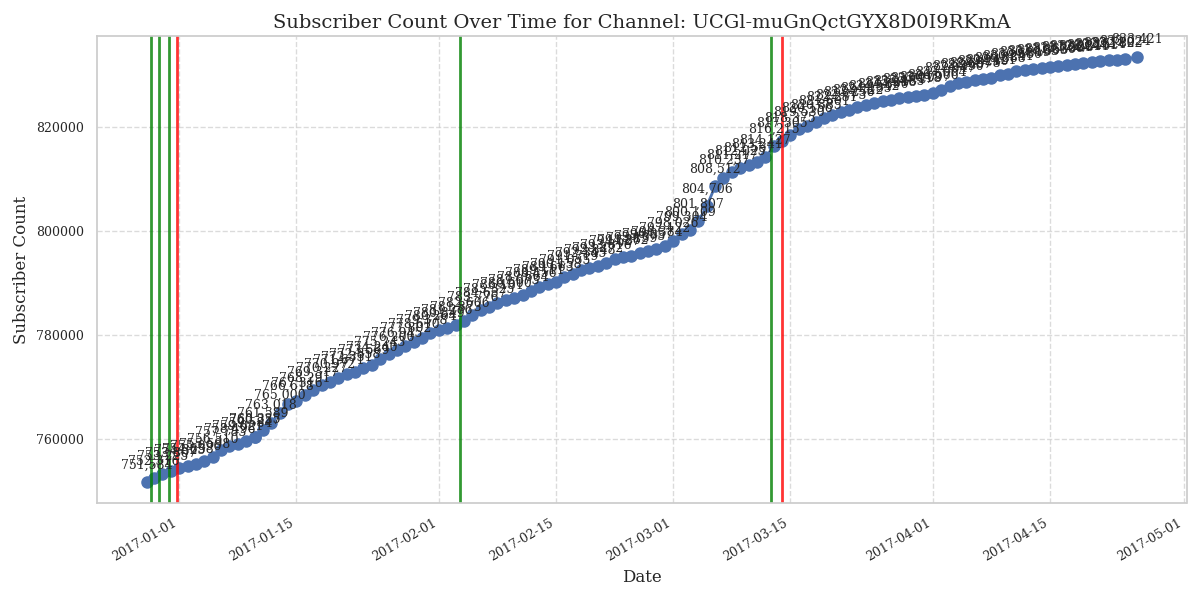

Plot created for channel UCGl-muGnQctGYX8D0I9RKmA with 120 data points and 2 video markers


In [19]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import io
from IPython.display import display, Image

# Filter the DataFrame
filtered_df = df_channel_history_collabs.loc[df_channel_history_collabs['channelID'] == channel].copy()

if filtered_df.empty:
    print(f"No data found for channel ID: {channel}")
else:
    # Convert timestamps
    filtered_df['crawlTimestamp'] = pd.to_datetime(filtered_df['crawlTimestamp'])
    filtered_df = filtered_df.sort_values('crawlTimestamp')

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(filtered_df['crawlTimestamp'], filtered_df['subscriberCount'], 'b-o', linewidth=2, markersize=8)

    
    # Add thick vertical lines at each video timestamp
    for ts in video_timestamp_list:
        ax.axvline(x=ts, color='red', linewidth=2, linestyle='-', alpha=0.8)
    for ts in video_timestamp_list2:
        ax.axvline(x=ts, color='green', linewidth=2, linestyle='-', alpha=0.8)
    # Labels and formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Subscriber Count', fontsize=12)
    ax.set_title(f'Subscriber Count Over Time for Channel: {channel}', fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()
    ax.grid(True, linestyle='--', alpha=0.7)

    # Annotations for subscribers
    for i, row in filtered_df.iterrows():
        ax.annotate(f"{int(row['subscriberCount']):,}", 
                    (row['crawlTimestamp'], row['subscriberCount']),
                    textcoords="offset points",
                    xytext=(0,10), 
                    ha='center')

    # Layout and export
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    display(Image(data=buf.getvalue()))
    plt.close(fig)

    print(f"Plot created for channel {channel} with {len(filtered_df)} data points and {len(video_timestamp_list)} video markers")


# hattttt

In [111]:
from_channels = df_graph_filtered['from'].dropna().tolist()
to_channels = df_graph_filtered['to'].tail().dropna().tolist()

print(from_channels)

['UCw-hc7ZJummS0AvWyjUX56A', 'UClpEE-Led9ZK0GJQKvU--3Q', 'UClpEE-Led9ZK0GJQKvU--3Q', 'UCMDz09-3zO1hm1pqRA-Er0A', 'UCUcBFGAfOzut1x4GSWa6Akg', 'UC9Q0dAjbhv0FbwvoHRSmjxA', 'UC9Q0dAjbhv0FbwvoHRSmjxA', 'UC9Q0dAjbhv0FbwvoHRSmjxA', 'UCLFTOcssnu2LGS3FxGA5tsQ', 'UCLFTOcssnu2LGS3FxGA5tsQ', 'UCo9ExXwpxwBaYRM4mkD_J4A', 'UCo9ExXwpxwBaYRM4mkD_J4A', 'UCo9ExXwpxwBaYRM4mkD_J4A', 'UCo9ExXwpxwBaYRM4mkD_J4A', 'UCo9ExXwpxwBaYRM4mkD_J4A', 'UCzNq9i-DlDDBLjPerVzJW-A', 'UC9oOvCsrSGpX1Hl2cIJXYLw', 'UCi1S0Cx-hfDV1w25N3l_0dw', 'UCi1S0Cx-hfDV1w25N3l_0dw', 'UC4fLWR5uoe66S8spSO3V0gw', 'UCgtgMd3z_Boj_QABLbLlabw', 'UCgtgMd3z_Boj_QABLbLlabw', 'UC_drtxXViugebE3bzqjD-Kg', 'UCrGnb5RdHA9M6WGmBGYo4ZQ', 'UCY9f2Rinm3jXBv_R97Uc0Lg', 'UCy8WPFE1WEsCJYcYuzZpeXg', 'UCC5kum96eeAdJGfizULP4lw', 'UC-V2ze2c4s7rV4neMd7ZS-w', 'UC7h_KLzf87ftHCkc1AfYwUQ', 'UCISkC3KkwYtXWDp91SXeE4A', 'UCjpgDLE5LGOpzX2igCKAdSQ', 'UCkuug-Gcff-YaxE4j4czN6g', 'UC5pmjxKYia6W0kr9Q4vZT7w', 'UC7nGdI1YVbdj0lBqEeg8KxQ', 'UCW2G11dTUlkjZCW_0EaZK4Q', 'UCWP9sPHAkNy4WILl-

In [123]:
from_channels = list(set(from_channels))
print(len(from_channels))
for name in from_channels:    
    print("name is ", name)

# from_channels = ['UCXic4pkppcXdnknsmlFP2CQ']

987
name is  UCR1aFO8kPS2WgdOfvU0zpag
name is  UCfa352_VIp2AI7R9Euh0QfA
name is  UCQLf49IdqoFXuu3j9cKHkdw
name is  UCHa-hWHrTt4hqh-WiHry3Lw
name is  UCx0x2_DpGMO0mSQwWPFSwCw
name is  UCE8tUeSgY2xlE5ZPCjl-S1w
name is  UC6paX0kLA8D81aYogceMufw
name is  UCUXGFgupozBh278Nrue-cAw
name is  UCI9gIf0scF8jeXziFyXG-Zw
name is  UCG0E3naN7D-bgldOJvGHbtg
name is  UC9oOvCsrSGpX1Hl2cIJXYLw
name is  UCg2z1irSzSN68c2oLi3pvbw
name is  UCPxk93OrpZV4MA7Hm_f12bw
name is  UCYDx4LfNuQKI9aAcIa-BCKw
name is  UCdK_G8bo0X0kVwxiWoIUfwQ
name is  UCOcE8WdQOSeqFczVxGatGKg
name is  UCXic4pkppcXdnknsmlFP2CQ
name is  UCUexiQWg3zNgoRPzQcsRVlA
name is  UCEqcYA_-sfiu4oaPJvlybmw
name is  UCjfPobJg2TZ83j-5AQ54lkQ
name is  UCQwXt_wbP8yzzNGrlxMKHew
name is  UC5qSUdhxQMdFm7AjXt-QDxg
name is  UCxlNE1UStmCupXMn7SdY7xw
name is  UC8aTvyjY38Qf5rS1xBOWI3w
name is  UC_1H9v258pXiyLDaW0R5exw
name is  UCBrV_is2j-XaQShG36QtEKQ
name is  UC9o3ChwDghTfXtlpd-vGTPg
name is  UCJIDRMDo-fb2y_zykKIlJ3Q
name is  UCFOEjz0jo07W8bpEHomEgHg
name is  U

In [113]:
columns = [
    'cluster', 'from', 'from_category', 'from_cluster', 'from_network', 
    'from_popularity', 'from_topic', 'to', 'to_category', 'to_cluster', 
    'to_network', 'to_popularity', 'to_topic', 'videos', 'weight', 'max_impact'
]

# Create an empty DataFrame to accumulate the matched rows
accumulated_rows = pd.DataFrame(columns=columns)


In [114]:
df_collabs = pd.read_csv("df_collabs.txt", sep="\t")  # Use sep="\t" if it's tab-separated

In [130]:
count = 0
for name in from_channels:    
    print("name is ", name)
    channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])
    
    try:
        group = channel_collabs_groups.get_group(name)
    except KeyError:
        count+=1
        continue  # Skip this name if group not found

    group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
    
    # Assuming df_channel_history_collabs is your DataFrame containing the data
    # Convert 'crawlTimestamp' column to datetime type and only keep the date part
    df_channel_history_collabs['crawlTimestamp'] = pd.to_datetime(df_channel_history_collabs['crawlTimestamp']).dt.date
    
    # Filter data between 2016-12-28 and 2017-04-25
    # filtered_data = df_channel_history_collabs[(df_channel_history_collabs['crawlTimestamp'] >= pd.to_datetime('2016-12-28').date()) & 
                                               # (df_channel_history_collabs['crawlTimestamp'] <= pd.to_datetime('2017-04-25').date())]
    filtered_data = df_channel_history_collabs
    # Group by 'channelID' and get the group corresponding to 'UCavTVjugW1OejDAq0aDzdMw'
    channel_collabs_groups = filtered_data.groupby(['channelID'])
    group = channel_collabs_groups.get_group(name)
    
    # Keep only the 'subscriberCount' and 'crawlTimestamp' columns
    group = group[['subscriberCount', 'crawlTimestamp']]
    
    # Create a date range from 2016-12-28 to 2017-04-30 (only dates, no times)
    date_range = pd.date_range(start='2016-12-01', end='2017-04-30').date
    
    # Map each date in the range to an integer starting from 1
    date_mapping = {date: idx + 1 for idx, date in enumerate(date_range)}
    
    # Add the integer sequence based on the 'crawlTimestamp'
    group['date_sequence'] = group['crawlTimestamp'].map(lambda x: date_mapping.get(x, None))
    
    # View the resulting DataFrame
    # print(group)
    
    
    # Assuming 'group' DataFrame already has 'date_sequence' and 'subscriberCount' columns
    # Let's set 'x' (date_sequence) and 'y' (subscriberCount)
    
    x_full = group['date_sequence'].values.reshape(-1, 1)
    y_full = group['subscriberCount'].values
    
    # Take the first one third of the data
    one_third_length = len(x_full)
    x = x_full[:one_third_length]
    y = y_full[:one_third_length]

    # Create the linear regression model
    model = LinearRegression()
    
    # Fit the model with the data
    model.fit(x, y)
    
    # Predict the values based on the model
    y_pred = model.predict(x)
    
    # # Plot the results
    # plt.figure(figsize=(10, 6))
    # plt.scatter(x, y, color='blue', label='Actual Subscriber Count')
    # plt.plot(x, y_pred, color='red', label='Linear Regression Line')
    # plt.xlabel('Date Sequence')
    # plt.ylabel('Subscriber Count')
    # plt.title('Linear Regression: Subscriber Count vs Date Sequence')
    # plt.legend()
    # # plt.show()
    
    # Optionally, print the model's coefficients (slope and intercept)
    print(f"Model Coefficient (Slope): {model.coef_[0]}")
    print(f"Model Intercept: {model.intercept_}")
    
    
    # Replace 'query_channel' with the actual channel ID or name you're querying
    # the coming in collabs
    filtered_df = df_graph_filtered[df_graph_filtered['from'] == name]
    video_metadata = pd.read_csv("video_metadata_with_timestamps_utc.csv")
    video_ids = filtered_df['videos'].explode()
    timestamps = video_metadata[video_metadata['video_id'].isin(video_ids)]
    timestamp_list = timestamps['timestamp'].tolist()
    video_timestamp_list = [pd.to_datetime(ts) for ts in timestamp_list]
    video_id_timestamp_pairs = list(zip(video_ids, timestamp_list))
    print("videos and timestamps for this channel are ", video_id_timestamp_pairs)
    # print(video_timestamp_list)
    
    # the going out collabs
    filtered_df2 = df_graph_filtered[df_graph_filtered['to'] == name]
    video_metadata2 = pd.read_csv("video_metadata_with_timestamps_utc.csv")
    video_ids2 = filtered_df2['videos'].explode()
    timestamps2 = video_metadata2[video_metadata2['video_id'].isin(video_ids2)]
    timestamp_list2 = timestamps2['timestamp'].tolist()
    # print("timestamp list is ", timestamp_list2)
    
    video_timestamp_list2 = [pd.to_datetime(ts) for ts in timestamp_list2]
    # print(video_timestamp_list2)
    
    # Convert strings to datetime and strip to date
    dates = [pd.to_datetime(ts).date() for ts in timestamp_list]
    print("dates are ", dates)
    date_sequence = [date_mapping.get(date, None) for date in dates]
    count = 0
    if not date_sequence or len(date_sequence)==1:
        print("##################################### AAGE BADH RHE ")
        count+=1
        continue
    
    
    results = []

    date_sequence.sort()
    print("date_sequence is ", date_sequence)
    window = 2
    min_date = date_sequence[1] - window
    rate_row = group[group['date_sequence'] == min_date]
    min_row = group[group['date_sequence'] == date_sequence[0]]
    print("min row is ", min_row)
    print("rate row is ", rate_row)
    if not rate_row.empty and not min_row.empty:
        rate_count = rate_row['subscriberCount'].values[0]
        min_count = min_row['subscriberCount'].values[0]
    else:
        count+=1
        continue
    fixed_rate = (min_count - rate_count) * 5 / 2

    for collab_date in date_sequence:  # date_sequence is your list of collab timestamps
        before_date = collab_date - 7
        after_date = collab_date + 7
        now_date = collab_date
    
        before_row = group[group['date_sequence'] == before_date]
        after_row = group[group['date_sequence'] == after_date]
        now_row = group[group['date_sequence'] == now_date]
    
        if not before_row.empty and not after_row.empty:
            before_count = before_row['subscriberCount'].values[0]
            after_count = after_row['subscriberCount'].values[0]
            now_count = now_row['subscriberCount'].values[0]
            diff = after_count - before_count
            bhavya = after_count - now_count - now_count + before_count
            fixed_window = after_count - now_count - fixed_rate
    
            results.append({
                'collab_date': collab_date,
                'subscriber_before': before_count,
                'subscriber_after': after_count,
                'difference': diff / model.coef_[0],
                'Bhavya_diff': bhavya,
                'fixed_window_rate': fixed_window / model.coef_[0]
            })
    
    # Convert to DataFrame for analysis or plotting
    df_diff = pd.DataFrame(results)
    max_result = max(results, key=lambda x: x['fixed_window_rate'])
    print("Max fixed_window_rate:", max_result['fixed_window_rate'])
    print("Corresponding collab_date:", max_result['collab_date'])
    reverse_mapping = {v: k for k, v in date_mapping.items()}
    original_date = reverse_mapping.get(max_result['collab_date'], None)
    print("date of collab is ", original_date)

    matched_videos = [
        (video_id, pd.to_datetime(timestamp)) for video_id, timestamp in video_id_timestamp_pairs
        if pd.to_datetime(timestamp).date() == original_date
    ]
    
    # Display the results
    if matched_videos:
        for video_id, timestamp in matched_videos:
            print(f"Video ID: {video_id}, Timestamp: {timestamp}")
    else:
        print("No video found with the specified date.")


    df_collabs['videos'] = df_collabs['videos'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    
    # Extract the video_ids from the matched_videos list
    matched_video_ids = [video_id for video_id, _ in matched_videos]
    
    # Filter the rows where the 'videos' column contains any of the matched_video_ids
    matched_rows = df_collabs[df_collabs['videos'].apply(lambda videos: any(video_id in videos for video_id in matched_video_ids))]

    matched_rows['max_impact'] = max_result['fixed_window_rate']
    accumulated_rows = pd.concat([accumulated_rows, matched_rows], ignore_index=True)

    # Display the matched rows
    print(matched_rows)
            
accumulated_rows.to_csv('matched_rows_with_impact.csv', mode='w', header=True, index=False)
print("kitni baar continue kiya", count)



name is  UCR1aFO8kPS2WgdOfvU0zpag
Model Coefficient (Slope): 509.9853874941652
Model Intercept: 190845.58772203673
videos and timestamps for this channel are  [('l9bxLEnpGaA', '2017-02-02 21:08:25'), ('CWqs4MFT-Ek', '2017-01-31 20:06:00')]
dates are  [datetime.date(2017, 2, 2), datetime.date(2017, 1, 31)]
date_sequence is  [62, 64]
min row is         subscriberCount crawlTimestamp  date_sequence
57117           221169     2017-01-31             62
rate row is         subscriberCount crawlTimestamp  date_sequence
57117           221169     2017-01-31             62
Max fixed_window_rate: 23.592832843936453
Corresponding collab_date: 62
date of collab is  2017-01-31
Video ID: CWqs4MFT-Ek, Timestamp: 2017-01-31 20:06:00
      Unnamed: 0  cluster                      from   from_category  \
2983        2983     3840  UCR1aFO8kPS2WgdOfvU0zpag  People & Blogs   

     from_cluster  ... to_popularity   to_topic                      videos  \
2983     ["3840"]  ...             3  Lifestyle  [C

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 264.9286483777179
Model Intercept: 1666366.1385730167
videos and timestamps for this channel are  [('pKeLYAV_rCM', '2017-01-17 23:52:51')]
dates are  [datetime.date(2017, 1, 17), datetime.date(2017, 1, 17)]
date_sequence is  [48, 48]
min row is         subscriberCount crawlTimestamp  date_sequence
34143          1680189     2017-01-17             48
rate row is         subscriberCount crawlTimestamp  date_sequence
30945          1679846     2017-01-15             46
Max fixed_window_rate: 0.5492044778507896
Corresponding collab_date: 48
date of collab is  2017-01-17
Video ID: pKeLYAV_rCM, Timestamp: 2017-01-17 23:52:51
      Unnamed: 0  cluster                      from     from_category  \
1009        1009     9704  UCLFw1YLKGrlK2lBi1PwGlrg     Entertainment   
2739        2739     3104  UCvmpOQfPsIrxO0NI5slLDwQ  Film & Animation   

          from_cluster  ... to_popularity   to_topic  \
1009          ["9704"]  ...             2  Lifestyle   
2739  ["3104",

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 2.2818323797672018
Model Intercept: 3405.5556130353675
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCHa-hWHrTt4hqh-WiHry3Lw
Model Coefficient (Slope): 4734.131377686759
Model Intercept: 3451673.8538360316
videos and timestamps for this channel are  [('2hW38hfxBnc', '2017-02-09 20:12:36'), ('aWYTVh3XDTk', '2017-01-05 20:04:38'), ('duTUbrvG2lo', '2017-01-24 21:12:34'), ('fk8oOvYDNr4', '2017-02-26 17:00:00'), ('hNkKUAZfJBk', '2017-02-25 17:00:06'), ('uLCL4Nydamc', '2017-03-22 21:52:55'), ('w8STN-Zerio', '2017-02-11 18:10:26'), ('xeY1ma3IxkQ', '2017-03-26 15:00:06'), ('Se5ljnszCYM', '2017-01-04 20:20:50'), ('iE54LSuKGT0', '2017-02-19 18:14:51')]
dates are  [datetime.date(2017, 2, 9), datetime.date(2017, 1, 5), datetime.date(2017, 1, 24), datetime.date(2017, 2, 26), datetime.date(2017, 2, 25), datetime.date(2017, 3, 22), datetime.date(2017, 2, 11), datetime.date(2017, 3, 26), datetime.d

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 3060.6764083740313
Model Intercept: 508530.9034280027
videos and timestamps for this channel are  [('6ZX5rUahkk4', '2017-03-07 22:53:19'), ('9reBtYPn1eI', '2017-02-08 11:30:00'), ('QkrcSnEwvck', '2017-03-17 12:30:01'), ('r17no63r1h4', '2017-02-08 11:30:00'), ('sHTbGsBHSC0', '2017-03-17 12:30:01')]
dates are  [datetime.date(2017, 3, 7), datetime.date(2017, 2, 8), datetime.date(2017, 3, 17), datetime.date(2017, 2, 8), datetime.date(2017, 3, 17)]
date_sequence is  [70, 70, 97, 107, 107]
min row is         subscriberCount crawlTimestamp  date_sequence
69248           761512     2017-02-08             70
rate row is         subscriberCount crawlTimestamp  date_sequence
66052           751596     2017-02-06             68
Max fixed_window_rate: 1.9260448389353544
Corresponding collab_date: 70
date of collab is  2017-02-08
Video ID: 9reBtYPn1eI, Timestamp: 2017-02-08 11:30:00
Video ID: r17no63r1h4, Timestamp: 2017-02-08 11:30:00
      Unnamed: 0  cluster            

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

videos and timestamps for this channel are  [('JdXJLwkyAFc', '2017-01-26 16:30:00'), ('o6or89D9fWo', '2017-01-05 16:00:05')]
dates are  [datetime.date(2017, 1, 26), datetime.date(2017, 1, 5)]
date_sequence is  [36, 57]
min row is         subscriberCount crawlTimestamp  date_sequence
12971          1813247     2017-01-05             36
rate row is         subscriberCount crawlTimestamp  date_sequence
44972          2014473     2017-01-24             55
Max fixed_window_rate: 75.2139497155316
Corresponding collab_date: 36
date of collab is  2017-01-05
Video ID: o6or89D9fWo, Timestamp: 2017-01-05 16:00:05
      Unnamed: 0  cluster                      from  from_category  \
2469        2469     4333  UC6paX0kLA8D81aYogceMufw  Entertainment   

          from_cluster  ... to_popularity  to_topic  \
2469  ["1476", "4333"]  ...             4     Hobby   

                          videos weight max_impact  
2469  [JdXJLwkyAFc, o6or89D9fWo]      2   75.21395  

[1 rows x 17 columns]
name is  

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 1, 17), datetime.date(2017, 2, 23), datetime.date(2016, 12, 29), datetime.date(2017, 3, 14), datetime.date(2017, 2, 21), datetime.date(2017, 3, 25), datetime.date(2017, 3, 1), datetime.date(2017, 1, 17), datetime.date(2017, 1, 4), datetime.date(2017, 1, 26), datetime.date(2016, 12, 31), datetime.date(2017, 1, 19), datetime.date(2017, 3, 12), datetime.date(2017, 2, 12), datetime.date(2017, 3, 11), datetime.date(2017, 1, 9), datetime.date(2017, 1, 14), datetime.date(2017, 2, 7), datetime.date(2017, 3, 22), datetime.date(2017, 2, 16), datetime.date(2017, 3, 4)]
date_sequence is  [29, 31, 35, 40, 45, 48, 48, 50, 57, 69, 74, 78, 83, 85, 91, 94, 101, 102, 104, 112, 115]
min row is        subscriberCount crawlTimestamp  date_sequence
2915           451733     2016-12-29             29
rate row is        subscriberCount crawlTimestamp  date_sequence
2915           451733     2016-12-29             29
Max fixed_window_rate: 19.851511127936458
Corresponding collab

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 539.2844902329547
Model Intercept: 1044937.8167376554
videos and timestamps for this channel are  [('ErwEfFBjaVg', '2017-02-05 09:30:00'), ('2aObza62sbc', '2017-02-09 12:00:01'), ('4wipaJ2Dtg4', '2017-02-14 12:00:02'), ('80fQiKffmlY', '2017-01-08 09:00:01'), ('9cDqPhZwjWs', '2017-02-15 12:00:05')]
dates are  [datetime.date(2017, 2, 5), datetime.date(2017, 2, 9), datetime.date(2017, 2, 14), datetime.date(2017, 1, 8), datetime.date(2017, 2, 15)]
date_sequence is  [39, 67, 71, 76, 77]
min row is         subscriberCount crawlTimestamp  date_sequence
18172          1064701     2017-01-08             39
rate row is         subscriberCount crawlTimestamp  date_sequence
61356          1081542     2017-02-03             65
Max fixed_window_rate: 85.79238015915173
Corresponding collab_date: 77
date of collab is  2017-02-15
Video ID: 9cDqPhZwjWs, Timestamp: 2017-02-15 12:00:05
     Unnamed: 0  cluster                      from   from_category  \
165         165     5542

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 223.84847765820118
Model Intercept: 372679.2826935055
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCPxk93OrpZV4MA7Hm_f12bw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 310.411517792756
Model Intercept: 75164.81021788681
videos and timestamps for this channel are  [('JoRqoWsIINQ', '2017-02-12 01:47:45'), ('bvY8Ojzq0WM', '2017-02-03 01:54:46'), ('DMtGMsz8BAg', '2017-02-12 01:47:45'), ('55AG6mnlE5o', '2017-02-12 03:44:20'), ('OMEC9UAIWo0', '2017-02-05 03:52:52')]
dates are  [datetime.date(2017, 2, 12), datetime.date(2017, 2, 3), datetime.date(2017, 2, 12), datetime.date(2017, 2, 12), datetime.date(2017, 2, 5)]
date_sequence is  [65, 67, 74, 74, 74]
min row is         subscriberCount crawlTimestamp  date_sequence
61859            93459     2017-02-03             65
rate row is         subscriberCount crawlTimestamp  date_sequence
61859            93459     2017-02-03             65
Max fixed_window_rate: 15.166962983452379
Corresponding collab_date: 65
date of collab is  2017-02-03
Video ID: bvY8Ojzq0WM, Timestamp: 2017-02-03 01:54:46
      Unnamed: 0  cluster                      from   from_category  \
2800        2800    134

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 2088.373741887303
Model Intercept: 522123.08605686144
videos and timestamps for this channel are  [('ggMFcDSm1no', '2016-12-30 15:00:01')]
dates are  [datetime.date(2016, 12, 30)]
##################################### AAGE BADH RHE 
name is  UCOcE8WdQOSeqFczVxGatGKg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 959.6111363190381
Model Intercept: 955684.090409166
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCXic4pkppcXdnknsmlFP2CQ
Model Coefficient (Slope): 224.6785272666266
Model Intercept: 271617.3246362785
videos and timestamps for this channel are  [('3n_u0MHWcP4', '2017-01-15 00:48:32'), ('FFhCu7GlH-A', '2017-02-15 22:35:17'), ('_PfPNeSQUxs', '2017-03-01 20:13:34'), ('D1bU7yTGo28', '2017-01-28 19:35:41'), ('BlljzihkrNw', '2017-02-18 21:05:39'), ('Cgpz__e8q8I', '2017-03-05 19:24:39'), ('M0_vXLPWw2w', '2017-02-11 18:36:16'), ('TaqQzZg4Wzs', '2017-02-26 20:18:58'), ('TkKdEYEXo_8', '2017-01-07 19:24:02'), ('Vvkqfxz0_Ko', '2017-03-22 00:37:41'), ('_r-qTd7_5OU', '2017-01-21 22:20:19'), ('bpT9jv1DQs8', '2016-12-31 19:18:23'), ('dMG1AKVyKpw', '2017-01-28 19:39:32'), ('mHuaX1JDd2g', '2017-03-25 17:13:42'), ('tYPX93ZLgIA', '2017-01-14 22:09:08'), ('AbGcJLxTzZ4', '2017-02-27 00:51:19'), ('K9Y693

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 14.193024828846617
Model Intercept: 472372.4891660747
videos and timestamps for this channel are  [('tl2P7428URM', '2017-02-11 01:07:24')]
dates are  [datetime.date(2017, 2, 11)]
##################################### AAGE BADH RHE 
name is  UCjfPobJg2TZ83j-5AQ54lkQ
Model Coefficient (Slope): 372.84740563263074
Model Intercept: 601884.9672154537
videos and timestamps for this channel are  [('uOmgy15r0pQ', '2017-01-25 13:23:14')]
dates are  [datetime.date(2017, 1, 25)]
##################################### AAGE BADH RHE 
name is  UCQwXt_wbP8yzzNGrlxMKHew
Model Coefficient (Slope): 585.6554094849832
Model Intercept: 354255.1163300385
videos and timestamps for this channel are  [('sOTM3PIWQC0', '2017-01-18 12:00:30')]
dates are  [datetime.date(2017, 1, 18)]
##################################### AAGE BADH RHE 
name is  UC5qSUdhxQMdFm7AjXt-QDxg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 64.91749753423592
Model Intercept: 68127.9044219096
videos and timestamps for this channel are  [('0n9SqURFHyM', '2017-03-16 05:32:17'), ('IR4mMEM5HEc', '2017-01-26 05:54:58'), ('QH697tx5_FU', '2017-02-02 06:52:53'), ('ucFOGgrWhsQ', '2017-03-09 06:31:08')]
dates are  [datetime.date(2017, 3, 16), datetime.date(2017, 1, 26), datetime.date(2017, 2, 2), datetime.date(2017, 3, 9)]
date_sequence is  [57, 64, 99, 106]
min row is         subscriberCount crawlTimestamp  date_sequence
48146            71446     2017-01-26             57
rate row is         subscriberCount crawlTimestamp  date_sequence
56136            72245     2017-01-31             62
Max fixed_window_rate: 48.79270027821909
Corresponding collab_date: 57
date of collab is  2017-01-26
Video ID: IR4mMEM5HEc, Timestamp: 2017-01-26 05:54:58
      Unnamed: 0  cluster                      from from_category  \
2286        2286    13850  UC5qSUdhxQMdFm7AjXt-QDxg        Sports   

                           

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 23)]
##################################### AAGE BADH RHE 
name is  UC8aTvyjY38Qf5rS1xBOWI3w
Model Coefficient (Slope): 4766.145514578121
Model Intercept: 427418.1460122918
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC_1H9v258pXiyLDaW0R5exw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 308.6523774362649
Model Intercept: 82429.00990772885
videos and timestamps for this channel are  [('tQzIAdb8fHU', '2017-02-03 20:11:16')]
dates are  [datetime.date(2017, 2, 3)]
##################################### AAGE BADH RHE 
name is  UCBrV_is2j-XaQShG36QtEKQ
Model Coefficient (Slope): 1041.2048013226834
Model Intercept: 43003.085792100246
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UC9o3ChwDghTfXtlpd-vGTPg
Model Coefficient (Slope): 198.35077502291523
Model Intercept: 19440.37537009849
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCJIDRMDo-fb2y_zykKIlJ3Q


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 8.707453612411593
Model Intercept: 12087.35605960495
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCFOEjz0jo07W8bpEHomEgHg
Model Coefficient (Slope): 2121.5178468225495
Model Intercept: 456346.20416772016
videos and timestamps for this channel are  [('rFWF8_1vjQA', '2017-01-29 19:53:44')]
dates are  [datetime.date(2017, 1, 29)]
##################################### AAGE BADH RHE 
name is  UCPSLIJgx-tOkrmS9NkKAy1Q


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 164.25729508626642
Model Intercept: 185137.4781102506
videos and timestamps for this channel are  [('A7TlLbYsdYI', '2017-01-20 06:43:23'), ('rkgBFBET2EY', '2017-01-14 13:28:11')]
dates are  [datetime.date(2017, 1, 20), datetime.date(2017, 1, 14)]
date_sequence is  [45, 51]
min row is         subscriberCount crawlTimestamp  date_sequence
29886           191848     2017-01-14             45
rate row is         subscriberCount crawlTimestamp  date_sequence
36282           192193     2017-01-18             49
Max fixed_window_rate: 15.497028601762416
Corresponding collab_date: 45
date of collab is  2017-01-14
Video ID: rkgBFBET2EY, Timestamp: 2017-01-14 13:28:11
     Unnamed: 0  cluster                      from   from_category  \
450         450     6628  UCPSLIJgx-tOkrmS9NkKAy1Q  How-to & Style   

                 from_cluster  ... to_popularity  to_topic  \
450  ["5635", "6627", "6628"]  ...             3   Fashion   

                                      vi

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 112.47274433166623
Model Intercept: 22587.67746180551
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCo9ExXwpxwBaYRM4mkD_J4A
Model Coefficient (Slope): 145.9664411674659
Model Intercept: 37602.78175421133
videos and timestamps for this channel are  [('syFKneGDzEQ', '2017-02-01 14:00:08'), ('dRDEBaMa2YA', '2017-03-14 22:00:00'), ('AVNlxjv7Yvo', '2017-02-09 02:56:08'), ('EQtp4c2QBqk', '2016-12-29 19:35:22')]
dates are  [datetime.date(2017, 2, 1), datetime.date(2017, 3, 14), datetime.date(2017, 2, 9), datetime.date(2016, 12, 29)]
date_sequence is  [29, 63, 71, 104]
min row is        subscriberCount crawlTimestamp  date_sequence
2609            41804     2016-12-29             29
rate row is         subscriberCount crawlTimestamp  date_sequence
55391            46203     2017-01-30             61
Max fixed_window_rate:

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


 92.0793840865096
Corresponding collab_date: 71
date of collab is  2017-02-09
Video ID: AVNlxjv7Yvo, Timestamp: 2017-02-09 02:56:08
    Unnamed: 0  cluster                      from from_category  \
15          15    10243  UCo9ExXwpxwBaYRM4mkD_J4A         Music   

                                         from_cluster from_network  \
15  ["292", "5191", "8407", "10243", "12758", "132...  BroadbandTV   

    from_popularity     from_topic                        to to_category  \
15                2  Hip hop music  UCVKWNQ_bjvwberVcQOhYa0A      Comedy   

   to_cluster     to_network  to_popularity       to_topic         videos  \
15    ["764"]  Maker Studios              3  Entertainment  [AVNlxjv7Yvo]   

    weight  max_impact  
15       1   92.079384  
name is  UCK9VElaz9OOJ7lnm1KPiHWQ
Model Coefficient (Slope): 201.2773539597586
Model Intercept: 125751.25985785224
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name 

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 94.6885057621813
Model Intercept: 303328.20559256576
videos and timestamps for this channel are  [('q4iF4WWHdYs', '2017-03-20 21:52:15')]
dates are  [datetime.date(2017, 3, 20)]
##################################### AAGE BADH RHE 
name is  UCT7CHLOzXxZaABsUVPzI5GA
Model Coefficient (Slope): 1692.7360437220188
Model Intercept: 1309643.4996249443
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCHfPdH_yrwLVstxYiyT5Gvw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): -9.97661038308279
Model Intercept: 321566.549069348
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCpAMOlA_0hFXopIxMq8ar0w


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 1116.1041160542816
Model Intercept: 1040358.0568144316
videos and timestamps for this channel are  [('CaKRUvCAJvw', '2017-01-22 11:29:08')]
dates are  [datetime.date(2017, 1, 22)]
##################################### AAGE BADH RHE 
name is  UCMOWB-s0Kek9o9sS8xA_kZQ
Model Coefficient (Slope): 95.51736969106435
Model Intercept: 79708.74549525898
videos and timestamps for this channel are  [('K2yx28mJRcw', '2017-03-02 23:15:20')]
dates are  [datetime.date(2017, 3, 2)]
##################################### AAGE BADH RHE 
name is  UCV2J1eTpFClb0-OPz8_QGQQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 16.386888052557623
Model Intercept: 126529.29530834206
videos and timestamps for this channel are  [('G7xLGIibxUo', '2017-01-26 22:37:20')]
dates are  [datetime.date(2017, 1, 26)]
##################################### AAGE BADH RHE 
name is  UCBFLqK7PAP9DQ3JpIrWFI7w
Model Coefficient (Slope): 1505.2506566989844
Model Intercept: 2285721.5972855897
videos and timestamps for this channel are  [('9UkAdRJGDXQ', '2017-03-07 18:58:09')]
dates are  [datetime.date(2017, 3, 7)]
##################################### AAGE BADH RHE 
name is  UCmA-0j6DRVQWo4skl8Otkiw
Model Coefficient (Slope): 1177.7236391286178
Model Intercept: 1104786.6874574763
videos and timestamps for this channel are  [('2HdFZv2X80g', '2017-02-03 18:00:49'), ('5XdpZYoLQIE', '2017-01-26 19:48:09'), ('R1LBOTxTcZY', '2017-02-16 17:39:30'), ('UuYbo7g1cig', '2017-01-20 22:08:33'), ('VSs_7midmLU', '2017-02-10 01:14:34'), ('cFIfc__lCVU', '2017-03-16 23:56:18'), ('nn6uLtD9TqA', '2017-01-05 22:03:49'), ('orW_

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Max fixed_window_rate: 34.18459022338028
Corresponding collab_date: 98
date of collab is  2017-03-08
Video ID: UZFY-chWkPc, Timestamp: 2017-03-08 14:53:23
      Unnamed: 0  cluster                      from  from_category  \
1934        1934     7678  UCmA-0j6DRVQWo4skl8Otkiw  Entertainment   

                          from_cluster   from_network  from_popularity  \
1934  ["2251", "2981", "2982", "7678"]  Maker Studios                4   

     from_topic                        to    to_category         to_cluster  \
1934        NaN  UCKxQmKgrkUv4S7P5w0pLayw  Entertainment  ["1346", "13602"]   

         to_network  to_popularity to_topic  \
1934  Maker Studios              3      NaN   

                                                 videos  weight  max_impact  
1934  [D-GEysdY08Q, EAMpprnn0uU, UZFY-chWkPc, wdkTur...       4    34.18459  
name is  UCS09CkK8fjPJ_nHD6fcGMSw
Model Coefficient (Slope): 344.36916864313395
Model Intercept: 253259.0416853177
videos and timestamps for this

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 39.83751123539398
Model Intercept: 10304.190901827624
videos and timestamps for this channel are  [('MNT5ymg7HR4', '2017-03-18 21:00:01')]
dates are  [datetime.date(2017, 3, 18)]
##################################### AAGE BADH RHE 
name is  UCA8fzHNNFcutvoKaO4bQ96Q
Model Coefficient (Slope): 30.6549234239049
Model Intercept: 181581.2643827661
videos and timestamps for this channel are  [('YYRxIKVL7Mk', '2017-01-14 09:05:32')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 14)]
##################################### AAGE BADH RHE 
name is  UC8HbphXFqQy38TCPn3hLHkw
Model Coefficient (Slope): 7.191730375804195
Model Intercept: 13791.742953949093
videos and timestamps for this channel are  [('hCXFoVvZFGY', '2017-01-10 01:00:01')]
dates are  [datetime.date(2017, 1, 10)]
##################################### AAGE BADH RHE 
name is  UCBnDDvOXLJdkrgOihCBCSxw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 16.3659141242848
Model Intercept: 22994.66407160153
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCuwQyaVxILdpsVgUJg1NYww
Model Coefficient (Slope): 265.56212220495433
Model Intercept: 127386.33667273077
videos and timestamps for this channel are  [('IbockZkiMqI', '2017-01-05 21:28:27')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

dates are  [datetime.date(2017, 1, 5)]
##################################### AAGE BADH RHE 
name is  UCdOpBLrrnrYA-q4dfNfY8Sw
Model Coefficient (Slope): 2353.0725463220997
Model Intercept: 518282.0246127341
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCC5kum96eeAdJGfizULP4lw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 422.52510518527316
Model Intercept: 266919.6504725356
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC7FRzhLh9dMrsXLi0U6zkig
Model Coefficient (Slope): 68.05039853342879
Model Intercept: 136372.97631369618
videos and timestamps for this channel are  [('WeYu9TGIT9w', '2017-02-20 19:30:01')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 2, 20)]
##################################### AAGE BADH RHE 
name is  UCktgBzL8TPpxOQR4EpjasFQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


name is  UCwaNuezahYT3BOjfXsne2mg
Model Coefficient (Slope): 1572.7413264161169
Model Intercept: 783231.2878121363
videos and timestamps for this channel are  [('PG-PvA7m3mA', '2017-03-16 22:59:52')]
dates are  [datetime.date(2017, 3, 16)]
##################################### AAGE BADH RHE 
name is  UCfboCeQoNzM_b7RbqDjIuPw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 282.4638091090481
Model Intercept: 366988.2680676713
videos and timestamps for this channel are  [('KYmbtQQCRwo', '2017-02-15 19:51:36'), ('F5HHj2qb-to', '2017-02-25 17:49:22'), ('NJcxAlVQc1o', '2017-02-19 20:00:00')]
dates are  [datetime.date(2017, 2, 15), datetime.date(2017, 2, 25), datetime.date(2017, 2, 19)]
date_sequence is  [77, 81, 87]
min row is         subscriberCount crawlTimestamp  date_sequence
80492           387885     2017-02-15             77
rate row is         subscriberCount crawlTimestamp  date_sequence
83688           389222     2017-02-17             79
Max fixed_window_rate: 28.41248946303656
Corresponding collab_date: 77
date of collab is  2017-02-15
Video ID: KYmbtQQCRwo, Timestamp: 2017-02-15 19:51:36
      Unnamed: 0  cluster                      from   from_category  \
329          329      938  UCfboCeQoNzM_b7RbqDjIuPw  How-to & Style   
2816        2816     2106  UCaAmm2B5NqvhpKjIw0AWyuw   Entertainment   

     from_cluster  ...

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: Fu

Model Coefficient (Slope): 408.1438166683078
Model Intercept: 157175.68474624673
videos and timestamps for this channel are  [('Hlxjsg7Tfbs', '2017-01-21 18:00:01'), ('LN2f_PLWbJA', '2017-01-12 21:00:06')]
dates are  [datetime.date(2017, 1, 21), datetime.date(2017, 1, 12)]
date_sequence is  [43, 52]
min row is         subscriberCount crawlTimestamp  date_sequence
25650           173697     2017-01-12             43
rate row is         subscriberCount crawlTimestamp  date_sequence
36843           177859     2017-01-19             50
Max fixed_window_rate: 35.69085063914707
Corresponding collab_date: 43
date of collab is  2017-01-12
Video ID: LN2f_PLWbJA, Timestamp: 2017-01-12 21:00:06
      Unnamed: 0  cluster                      from   from_category  \
2758        2758    12508  UC0x8XBfvJoDzSqMzE56g2BQ  People & Blogs   

                            from_cluster  ... to_popularity  to_topic  \
2758  ["1603", "4429", "10332", "12508"]  ...             3     Music   

             vide

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 5.813127083792871
Model Intercept: 1476.239520951272
videos and timestamps for this channel are  [('DjzOgRmchDk', '2017-02-21 23:00:01'), ('qPboo6SErf0', '2016-12-30 20:49:54')]
dates are  [datetime.date(2017, 2, 21), datetime.date(2016, 12, 30)]
date_sequence is  [30, 83]
min row is        subscriberCount crawlTimestamp  date_sequence
4678             1579     2016-12-30             30
rate row is         subscriberCount crawlTimestamp  date_sequence
87820             1890     2017-02-19             81
Max fixed_window_rate: 154.56396996808107
Corresponding collab_date: 83
date of collab is  2017-02-21
Video ID: DjzOgRmchDk, Timestamp: 2017-02-21 23:00:01
    Unnamed: 0  cluster                      from  from_category from_cluster  \
45          45     1693  UCY9f2Rinm3jXBv_R97Uc0Lg  Entertainment     ["1693"]   

    ... to_popularity   to_topic                      videos weight max_impact  
45  ...             3  Lifestyle  [DjzOgRmchDk, qPboo6SErf0]    

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Max fixed_window_rate: 121.60655028307691
Corresponding collab_date: 38
date of collab is  2017-01-07
Video ID: SLmv0ZKXqns, Timestamp: 2017-01-07 13:41:22
      Unnamed: 0  cluster                      from   from_category  \
2358        2358     6834  UCpm6vCgiehSKHtMFFS5ukiA  People & Blogs   

          from_cluster from_network  from_popularity from_topic  \
2358  ["6337", "6834"]  BroadbandTV                4  Lifestyle   

                            to     to_category              to_cluster  \
2358  UCnLm2fpeBqs3alj_MSEl9WQ  How-to & Style  ["530", "829", "4485"]   

       to_network  to_popularity to_topic         videos  weight  max_impact  
2358  BroadbandTV              3     Food  [SLmv0ZKXqns]       1   121.60655  
name is  UCjHyFOH80C4x_2n_Korx4QQ
Model Coefficient (Slope): 811.5559428480677
Model Intercept: 2028759.9127503096
videos and timestamps for this channel are  [('Hm-QbZjomDg', '2017-01-11 01:10:40'), ('YhdHRQgFQ5E', '2017-01-24 02:06:26'), ('vwTBhfcvMb4', '20

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Video ID: 2b2BSboJJ14, Timestamp: 2017-02-01 15:11:54
      Unnamed: 0  cluster                      from   from_category  \
1427        1427     1800  UCjHyFOH80C4x_2n_Korx4QQ  How-to & Style   

           from_cluster  ... to_popularity   to_topic  \
1427  ["1800", "12121"]  ...             3  Lifestyle   

                                                 videos weight max_impact  
1427  [2b2BSboJJ14, 6I-XqGoeGDc, Gje8ascB3Tc, Je1VsD...     11   12.77854  

[1 rows x 17 columns]
name is  UCAjUmxPSaa3RAb9LGcwDI9g


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 11.556896643263059
Model Intercept: 41778.763469082696
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCZFjNJCJaPZuRHKmGrfS37A
Model Coefficient (Slope): 408.66928714734644
Model Intercept: 659293.6339880762
videos and timestamps for this channel are  [('4D78LhUDzDA', '2017-03-02 17:31:43'), ('7ep5Oadnuoo', '2017-03-06 16:00:01'), ('Es7zfSw11E8', '2017-01-05 13:30:00'), ('Fri4ZSknVcs', '2017-03-10 13:00:04'), ('H8QOWGxDq-8', '2017-02-12 09:00:02'), ('M9vlWkd4GG8', '2017-02-24 11:00:05'), ('NlIbVTbICyw', '2017-03-14 11:10:11'), ('OTL4eq2RX0g', '2017-01-11 13:00:00')]
dates are  [datetime.date(2017, 3, 2), datetime.date(2017, 3, 6), datetime.date(2017, 1, 5), datetime.date(2017, 3, 10), datetime.date(2017, 2, 12), datetime.date(2017, 2, 24), datetime.date(2017, 3, 14), datetime.date(2017, 1, 11)]
date_sequence is  [36, 42, 74, 86, 92, 96, 100, 104]
min row is         subscriberCount cra

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 2, 20)]
##################################### AAGE BADH RHE 
name is  UC7Rrbm84x8RK0OkKlHpmiUQ
Model Coefficient (Slope): 2634.716382870886
Model Intercept: 1349184.7909703334
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCb9ageBPhZYNBU93tnjs-QA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 27.806074351586492
Model Intercept: 269725.58052658004
videos and timestamps for this channel are  [('5TlE-znJj0w', '2017-01-14 14:06:43'), ('tpLY4UTILcw', '2017-03-22 16:10:16')]
dates are  [datetime.date(2017, 1, 14), datetime.date(2017, 3, 22)]
date_sequence is  [45, 112]
min row is         subscriberCount crawlTimestamp  date_sequence
29120           270888     2017-01-14             45
rate row is          subscriberCount crawlTimestamp  date_sequence
132999           272953     2017-03-20            110
Max fixed_window_rate: 189.83262193927177
Corresponding collab_date: 112
date of collab is  2017-03-22
Video ID: tpLY4UTILcw, Timestamp: 2017-03-22 16:10:16
      Unnamed: 0  cluster                      from  from_category  \
1290        1290     1198  UCb9ageBPhZYNBU93tnjs-QA  Entertainment   

          from_cluster  ... to_popularity  to_topic  \
1290  ["1198", "5255"]  ...             3   Fitness   

                          videos weight  max_impa

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 231.75340628611377
Model Intercept: 98129.72579218444
videos and timestamps for this channel are  [('AydlaDbYc1E', '2017-03-23 21:13:05')]
dates are  [datetime.date(2017, 3, 23)]
##################################### AAGE BADH RHE 
name is  UCbI88iqwpseDR6MJC9oWPjg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 1063.6908832335296
Model Intercept: 473781.0829972558
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCCV3bIgzH800SK0AodYKy1g
Model Coefficient (Slope): 254.9629748306125
Model Intercept: 575347.1903300884
videos and timestamps for this channel are  [('SJ1KDj2eT54', '2017-03-10 05:18:41')]
dates are 

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


 [datetime.date(2017, 3, 10)]
##################################### AAGE BADH RHE 
name is  UCLXo7UDZvByw2ixzpQCufnA
Model Coefficient (Slope): 5430.76175901071
Model Intercept: 1375542.793973689
videos and timestamps for this channel are  [('kOlf-lEkf5k', '2017-03-24 06:40:18'), ('3cwrjNi_t78', '2017-01-23 01:05:51')]
dates are  [datetime.date(2017, 3, 24), datetime.date(2017, 1, 23)]
date_sequence is  [54, 114]
min row is         subscriberCount crawlTimestamp  date_sequence
44099          1652235     2017-01-23             54
rate row is          subscriberCount crawlTimestamp  date_sequence
136788          1988284     2017-03-22            112
Max fixed_window_rate: 162.11786468798837
Corresponding collab_date: 114
date of collab is  2017-03-24
Video ID: kOlf-lEkf5k, Timestamp: 2017-03-24 06:40:18
      Unnamed: 0  cluster                      from    from_category  \
2251        2251      195  UCLXo7UDZvByw2ixzpQCufnA  News & Politics   

                 from_cluster  ... to_popu

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 200.8623987878989
Model Intercept: 149399.9685583215
videos and timestamps for this channel are  [('ISusla_DkK4', '2017-01-01 19:44:42')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UCyPs-i6Sg1TTiwF9WPcPL5A


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 152.5362217417868
Model Intercept: 159128.35150174392


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

videos and timestamps for this channel are  [('5GnM0QSZGFs', '2017-01-26 00:16:32'), ('FgxXI58GhXo', '2017-02-28 02:00:01'), ('ItjGEu-8_4c', '2016-12-31 19:09:22'), ('PT_DQ-lTa_U', '2017-01-30 18:20:47'), ('Q5cKdEPS3Bs', '2017-01-09 21:30:09'), ('W0aV0HXfAt4', '2016-12-31 21:05:37'), ('w-YTdwnjfn4', '2017-01-16 16:47:51'), ('x3GorEXXq-8', '2017-01-12 04:36:14'), ('-PrTU1p30VQ', '2016-12-30 05:59:11'), ('5VtKCgbnrcA', '2017-02-06 05:29:37'), ('CxJF7afJuVM', '2017-03-17 23:08:37'), ('HJh6oKWScYY', '2017-01-26 00:16:32'), ('UXxxs_Nq8j4', '2017-03-12 00:00:02'), ('bOA3VjsZM00', '2017-02-28 02:00:01'), ('iafzHoXfjOc', '2016-12-31 22:13:08'), ('xeq7cmJRl1o', '2017-03-18 16:56:54'), ('Bt_T0Wl35M4', '2017-01-01 19:57:55')]
dates are  [datetime.date(2017, 1, 26), datetime.date(2017, 2, 28), datetime.date(2016, 12, 31), datetime.date(2017, 1, 30), datetime.date(2017, 1, 9), datetime.date(2016, 12, 31), datetime.date(2017, 1, 16), datetime.date(2017, 1, 12), datetime.date(2016, 12, 30), datetime.

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 97.24653477411448
Model Intercept: 34852.87931298212
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC0fkyMAE7T3OFs7lnGCr33A


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1242.6935221916426
Model Intercept: 146368.20441950054
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCqeXB2WsPdzcdCdP-bUc52g


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 16.78221509951551
Model Intercept: 34403.736898015726
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

dates are  []
##################################### AAGE BADH RHE 
name is  UCa0hrCp-JVXorBqXexI_F8Q


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 38.079271186333635

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop


Model Intercept: 28921.233794077067
videos and timestamps for this channel are  [('6gHskUKDtZ8', '2017-03-22 08:40:14')]
dates are  [datetime.date(2017, 3, 22), datetime.date(2017, 3, 22)]
date_sequence is  [112, 112]
min row is          subscriberCount crawlTimestamp  date_sequence
136138            33537     2017-03-22            112
rate row is          subscriberCount crawlTimestamp  date_sequence
132939            33451     2017-03-20            110
Max fixed_window_rate: -4.779503239686962
Corresponding collab_date: 112
date of collab is  2017-03-22
Video ID: 6gHskUKDtZ8, Timestamp: 2017-03-22 08:40:14
      Unnamed: 0  cluster                      from from_category  \
1028        1028      480  UCtjj2D0PA9GamE8bLXB44fQ        Gaming   
2378        2378     2824  UCm4WlDrdOOSbht-NKQ0uTeg        Gaming   

                  from_cluster  ... to_popularity  to_topic         videos  \
1028           ["480", "2505"]  ...             3    Gaming  [6gHskUKDtZ8]   
2378  ["2824", "297

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCgSvw7asvNq7wJWKMSW28Eg
Model Coefficient (Slope): 3347.9911676880943
Model Intercept: 3469416.24835875
videos and timestamps for this channel are  [('UNXamqgXVSk', '2017-02-26 19:44:00')]
dates are  [datetime.date(2017, 2, 26)]
##################################### AAGE BADH RHE 
name is  UCBYOJB0aaN9zXAR2-thQDdw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 749.9035403857887
Model Intercept: 303028.08834358427
videos and timestamps for this channel are  [('9bUV4hE2JIk', '2017-02-27 00:41:16'), ('Ex65HvdD8As', '2017-02-05 00:26:29'), ('JBa3cMrunsQ', '2017-03-26 02:45:09')]
dates are  [datetime.date(2017, 2, 27), datetime.date(2017, 2, 5), datetime.date(2017, 3, 26)]
date_sequence is  [67, 89, 116]
min row is         subscriberCount crawlTimestamp  date_sequence
64326           348887     2017-02-05             67
rate row is         subscriberCount crawlTimestamp  date_sequence
96286           361613     2017-02-25             87
Max fixed_window_rate: 54.48834123249907
Corresponding collab_date: 89
date of collab is  2017-02-27
Video ID: 9bUV4hE2JIk, Timestamp: 2017-02-27 00:41:16
     Unnamed: 0  cluster                      from  from_category  \
982         982     8314  UCBYOJB0aaN9zXAR2-thQDdw  Entertainment   

    from_cluster  ... to_popularity  to_topic         videos weight max_impact  
982     ["8314"

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 22), datetime.date(2017, 3, 23), datetime.date(2017, 1, 26), datetime.date(2017, 3, 24), datetime.date(2017, 1, 22), datetime.date(2017, 3, 23)]
date_sequence is  [53, 53, 57, 113, 113, 114]
min row is         subscriberCount crawlTimestamp  date_sequence
43086          2307858     2017-01-22             53
rate row is         subscriberCount crawlTimestamp  date_sequence
39890          2302662     2017-01-20             51
Max fixed_window_rate: 2.582933900016188
Corresponding collab_date: 57
date of collab is  2017-01-26
Video ID: SrrTTObLIsM, Timestamp: 2017-01-26 04:56:07
     Unnamed: 0  cluster                      from   from_category  \
111         111     6612  UCyCyTe_1bT2aIPwG_gxbyeg  People & Blogs   

                          from_cluster   from_network  from_popularity  \
111  ["3954", "6611", "6612", "11973"]  Maker Studios                4   

    from_topic                        to     to_category to_cluster  \
111  Lifestyle  UC_g3

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 475.24586515281885
Model Intercept: 129534.75398001335
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCvgt4ph5fROR3Fo0_pBc43Q
Model Coefficient (Slope): 2031.3476384419232
Model Intercept: 515994.62926006236
videos and timestamps for this channel are  [('aicyWKWsj-8', '2017-01-07 15:00:04')]
dates are  [datetime.date(2017, 1, 7)]
##################################### AAGE BADH RHE 
name is  UCBDuHZ-6IASDQtq9YnW6Mtw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): -5.234123859123654
Model Intercept: 69814.45402826442
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCDZ-irzyMKKSskgTEM2H0dg
Model Coefficient (Slope): 312.0659955874693
Model Intercept: 640171.992015532
videos and timestamps for this channel are  [('kpAz3ZHziIU', '2017-03-03 14:39:53'), ('L0TliIRLgZI', '2017-03-10 15:00:02')]
dates are  [datetime.date(2017, 3, 3), datetime.date(2017, 3, 10)]
date_sequence is  [93, 100]
min row is          subscriberCount crawlTimestamp  date_sequence
105989           672007     2017-03-03             93
rate row is          subscriberCount crawlTimestamp  date_sequence
113979           673741     2017-03-08             98
Max fixed_window_rate: 22.959887015282685
Corresponding collab_date: 100
date of collab is  2017-03-10
Video ID: L0TliIRLgZI, Timestamp: 2017-03-10 15:00:02
      Unnamed: 0  cluster                      from   from_category  \
133

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 211.94468397172665
Model Intercept: 645702.8662899823
videos and timestamps for this channel are  [('Cl48ROcYFys', '2017-01-31 21:56:43')]
dates are  [datetime.date(2017, 1, 31)]
##################################### AAGE BADH RHE 
name is  UCKHBi9cY4F839wltWqedrIQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 362.9882243247712
Model Intercept: 1680.1449697360695
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCvVWoVROH-nfAiXfr4nFuDg
Model Coefficient (Slope): 105.96602128812737
Model Intercept: 298832.7029879204
videos and timestamps for this channel are  [('CykwaIxd63Q', '2017-03-11 02:14:30')]
dates are  [datetime.date(2017, 3, 11)]
##################################### AAGE BADH RHE 
name is  UC6dnrqZANHB90Syn_C_EWXg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 290.34122034797383
Model Intercept: 70666.86129752634
videos and timestamps for this channel are  [('AeZC-nvaZfk', '2017-01-10 15:00:00'), ('YJ8xmlZUENM', '2017-03-18 00:08:53'), ('cL0SvCstUtE', '2017-03-27 18:19:45')]
dates are  [datetime.date(2017, 1, 10), datetime.date(2017, 3, 18), datetime.date(2017, 3, 27)]
date_sequence is  [41, 108, 117]
min row is         subscriberCount crawlTimestamp  date_sequence
20984            82140     2017-01-10             41
22583            82189     2017-01-10             41
rate row is          subscriberCount crawlTimestamp  date_sequence
126462           102401     2017-03-16            106
Max fixed_window_rate: 190.84269169080346
Corresponding collab_date: 41
date of collab is  2017-01-10
Video ID: AeZC-nvaZfk, Timestamp: 2017-01-10 15:00:00
      Unnamed: 0  cluster                      from   from_category  \
2008        2008     2279  UC6dnrqZANHB90Syn_C_EWXg  People & Blogs   

     from_cluster  ... to_populari

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): -87.63195094620552
Model Intercept: 1006350.2458177904
videos and timestamps for this channel are  [('M7j9KbvOH-4', '2017-01-23 23:00:37')]
dates are  [datetime.date(2017, 1, 23), datetime.date(2017, 1, 23)]
date_sequence is  [54, 54]
min row is         subscriberCount crawlTimestamp  date_sequence
43408          1001855     2017-01-23             54
rate row is         subscriberCount crawlTimestamp  date_sequence
40212          1001997     2017-01-21             52
Max fixed_window_rate: -0.31951816315476433
Corresponding collab_date: 54
date of collab is  2017-01-23
Video ID: M7j9KbvOH-4, Timestamp: 2017-01-23 23:00:37
      Unnamed: 0  cluster                      from   from_category  \
363          363     2943  UC7u7O4kGomeLwRxh0lhkDaQ  How-to & Style   
1251        1251     4628  UChZUCgX-hBXDpnpB8O1XQbA   Entertainment   

     from_cluster  ... to_popularity   to_topic         videos weight  \
363      ["2943"]  ...             3  Lifestyle  [M7j9Kb

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 454.5734973106389
Model Intercept: 107547.47557461017
videos and timestamps for this channel are  [('ULPSwfv6h0E', '2017-01-21 12:00:02')]
dates are  [datetime.date(2017, 1, 21), datetime.date(2017, 1, 21)]
date_sequence is  [52, 52]
min row is         subscriberCount crawlTimestamp  date_sequence
40163           131017     2017-01-21             52
rate row is         subscriberCount crawlTimestamp  date_sequence
36966           130036     2017-01-19             50
Max fixed_window_rate: 3.9454565886721453
Corresponding collab_date: 52
date of collab is  2017-01-21
Video ID: ULPSwfv6h0E, Timestamp: 2017-01-21 12:00:02
      Unnamed: 0  cluster                      from   from_category  \
194          194    12066  UC61YzFVCvX9Nw0bE2gM7MUA   Entertainment   
1901        1901    13837  UCKd1OjLzqPNFmDMheIED7Mg  People & Blogs   

                            from_cluster  ... to_popularity  to_topic  \
194                            ["12066"]  ...             3

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 1446.8247316590898
Model Intercept: 129873.39855837042
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCHVd0LM1g9S0cttDHkidEHA


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 176.59622104846838

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)



Model Intercept: 209781.93232018518
videos and timestamps for this channel are  [('K0yFDVOAsG0', '2017-03-02 21:28:42')]
dates are  [datetime.date(2017, 3, 2)]
##################################### AAGE BADH RHE 
name is  UCtaykeSsGhtn2o2BsPm-rsw
Model Coefficient (Slope): 539.4221723944102
Model Intercept: 192870.84108454586
videos and timestamps for this channel are  [('ylcauBrLHgU', '2016-12-29 23:00:01'), ('93sV_K4hqgs', '2016-12-28 14:00:00')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2016, 12, 29), datetime.date(2016, 12, 28)]
date_sequence is  [28, 29]
min row is        subscriberCount crawlTimestamp  date_sequence
1243           209174     2016-12-28             28
rate row is  Empty DataFrame
Columns: [subscriberCount, crawlTimestamp, date_sequence]
Index: []
name is  UCVtFOytbRpEvzLjvqGG5gxQ
Model Coefficient (Slope): 5788.15223510249
Model Intercept: 15360840.427862298
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCYALxwppPJjYyTMEwwEcNCQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 4426.6824333791
Model Intercept: 3538340.7945470344
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCI1priYQZzsch3TsTHO6OTg
Model Coefficient (Slope): 24.973328934679994
Model Intercept: 108679.0684921078
videos and timestamps for this channel are  [('1_5cvp8mRd4', '2017-01-17 01:58:37')]
dates are  [datetime.date(2017, 1, 17)]
##################################### AAGE BADH RHE 
name is  UCAo4b0ziAA6S0sex_dzgMYw
Model Coefficient (Slope): 237.0201433686558
Model Intercept: 85035.5552485516
videos and timestamps for this channel are  [('v2QpiXTsaL8', '2017-01-08 21:40:56')]
dates are  [datetime.date(2017, 1, 8)]
##################################### AAGE BADH RHE 
name is  UCkVj3yY58qOJa3K_ipk_67A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 88.02267275024903
Model Intercept: 563936.6944952826
videos and timestamps for this channel are  [('6Z4DQKPeKnY', '2016-12-30 02:06:13'), ('9tHTX2UnxvI', '2016-12-30 02:06:13'), ('DAq4Uho_6SU', '2017-01-06 04:26:01'), ('sOuaGy9rsK4', '2017-02-07 23:24:05'), ('xJ1MqJk0s74', '2017-03-07 17:12:13'), ('1h50xI9eNdw', '2017-03-09 17:04:36'), ('2lTW63Eb_9U', '2017-03-14 18:43:45'), ('6A6PutKE5I8', '2017-03-02 16:25:45'), ('OlEBL0DTt-E', '2017-03-09 20:50:07'), ('UGdd0QdzRIg', '2017-03-08 17:10:08'), ('kTwSf0ime48', '2017-02-09 21:34:53'), ('mOIEaT0nzRY', '2017-02-13 02:24:19'), ('otuy_xz838k', '2017-02-28 20:33:20'), ('xnB49AOXKu4', '2017-02-08 21:09:54')]
dates are  [datetime.date(2016, 12, 30), datetime.date(2016, 12, 30), datetime.date(2017, 1, 6), datetime.date(2017, 2, 7), datetime.date(2017, 3, 7), datetime.date(2017, 3, 9), datetime.date(2017, 3, 14), datetime.date(2017, 3, 2), datetime.date(2017, 3, 9), datetime.date(2017, 3, 8), datetime.date(2017, 2, 9), d

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 511.14636437794013
Model Intercept: 144600.04332031895
videos and timestamps for this channel are  [('F_zKwURW1LA', '2017-02-08 20:00:00')]
dates are  [datetime.date(2017, 2, 8)]
##################################### AAGE BADH RHE 
name is  UCe56RtxwepRSyZ-b--SedOw
Model Coefficient (Slope): 9352.515455785699
Model Intercept: 1717717.8946046955
videos and timestamps for this channel are  [('A3VbuEhNOSk', '2017-03-08 22:01:21'), ('YCvHY3Ui_7I', '2017-02-28 21:02:18'), ('k-Uy5ExJixw', '2017-03-04 20:35:23'), ('H8zfmckzAIQ', '2017-03-02 21:00:02'), ('rIBEK48WuTg', '2017-03-08 22:01:21')]
dates are  [datetime.date(2017, 3, 8), datetime.date(2017, 2, 28), datetime.date(2017, 3, 4), datetime.date(2017, 3, 2), datetime.date(2017, 3, 8)]
date_sequence is  [90, 92, 94, 98, 98]
min row is          subscriberCount crawlTimestamp  date_sequence
101204          2541375     2017-02-28             90
rate row is          subscriberCount crawlTimestamp  date_sequence
101204 

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Max fixed_window_rate: 8.083279878808709
Corresponding collab_date: 90
date of collab is  2017-02-28
Video ID: YCvHY3Ui_7I, Timestamp: 2017-02-28 21:02:18
      Unnamed: 0  cluster                      from from_category  \
2950        2950     5508  UCe56RtxwepRSyZ-b--SedOw        Comedy   

     from_cluster from_network  from_popularity from_topic  \
2950     ["5508"]     Studio71                4      Music   

                            to    to_category                  to_cluster  \
2950  UChM5Ff2yVeIZ16EWiB081cg  Entertainment  ["7800", "11696", "12683"]   

     to_network  to_popularity to_topic  \
2950   Studio71              4    Music   

                                       videos  weight  max_impact  
2950  [A3VbuEhNOSk, YCvHY3Ui_7I, k-Uy5ExJixw]       3     8.08328  
name is  UC4hSMRoJQit1eu8nhlM-7rQ
Model Coefficient (Slope): 210.76810006476353
Model Intercept: 286403.08639939036
videos and timestamps for this channel are  [('_iD1wv-l7U0', '2017-02-11 15:00:02')]
da

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 162.29302082517543
Model Intercept: 213069.87658246112
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCPd7354sP1aEqgP-uPLwcGA
Model Coefficient (Slope): 1088.0659806186384
Model Intercept: 1324093.359978749
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC66soxYX4IBUF4V94EdyYBQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1045.9855230355104
Model Intercept: 821119.2706130743
videos and timestamps for this channel are  [('X0NwFc1Yhw8', '2017-02-16 20:51:18')]
dates are  [datetime.date(2017, 2, 16), datetime.date(2017, 2, 16)]
date_sequence is  [78, 78]
min row is         subscriberCount crawlTimestamp  date_sequence
81713           902809     2017-02-16             78
rate row is         subscriberCount crawlTimestamp  date_sequence
78517           900926     2017-02-14             76
Max fixed_window_rate: 1.2366327941577895
Corresponding collab_date: 78
date of collab is  2017-02-16
Video ID: X0NwFc1Yhw8, Timestamp: 2017-02-16 20:51:18
      Unnamed: 0  cluster                      from   from_category  \
716          716     7111  UCqjALWYAB9mx9G51481hp9Q  People & Blogs   
2644        2644     2914  UC66soxYX4IBUF4V94EdyYBQ   Entertainment   

          from_cluster  ... to_popularity  to_topic         videos weight  \
716   ["5048", "7111"]  ...             4     Music  [X

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 6.978550016126577
Model Intercept: 12952.466259436502
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCZ7Cxp6r5JMhpSrIETCXzdQ
Model Coefficient (Slope): 376.46561641470146
Model Intercept: 327749.12025183823
videos and timestamps for this channel are  [('4V2qKEwH4NM', '2017-01-11 13:08:16'), ('45_h5p-aMeQ', '2017-02-02 13:00:01'), ('z2F5x1snpWI', '2017-01-12 23:53:54')]
dates are  [datetime.date(2017, 1, 11), datetime.date(2017, 2, 2), datetime.date(2017, 1, 12)]
date_sequence is  [42, 43, 64]
min row is         subscriberCount crawlTimestamp  date_sequence
25545           341521     2017-01-11             42
rate row is         subscriberCount crawlTimestamp  date_sequence
22347           341284     2017-01-10             41
23946           341301     2017-01-10             41
Max fixed_window_rate: 4.918111825544386
Corresponding collab_date: 42
date of collab is  2017-01-11
Video I

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


      Unnamed: 0  cluster                      from   from_category  \
1831        1831     7867  UCZ7Cxp6r5JMhpSrIETCXzdQ  People & Blogs   

                          from_cluster   from_network  from_popularity  \
1831  ["2511", "3807", "5298", "7867"]  Maker Studios                3   

     from_topic                        to     to_category to_cluster  \
1831      Music  UCONd1SNf3_QqjzjCVsURNuA  Pets & Animals         ""   

     to_network  to_popularity to_topic         videos  weight  max_impact  
1831        NaN              3      NaN  [4V2qKEwH4NM]       1    4.918112  
name is  UCvbbmA0B_gpi4rb-uRWGztg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 410.6710110028335
Model Intercept: 75645.19122773047
videos and timestamps for this channel are  [('m4Kv4PUDHt0', '2017-01-10 22:56:05'), ('KadEMOVMXD4', '2017-03-16 22:59:15'), ('LDl7nL2siz0', '2017-01-12 17:14:20'), ('YC6CpZ9IDJE', '2017-02-03 15:49:49'), ('YukosalA7ZI', '2017-03-26 12:34:59'), ('2CwasFd-NX8', '2017-02-20 16:52:02'), ('9itG-Wc3eAs', '2017-01-20 19:42:39'), ('BL5j4r_ny6M', '2017-01-11 17:11:27'), ('tsFhWRpD0t8', '2017-02-13 13:31:46'), ('9nHGURL1cNw', '2017-03-16 22:59:15')]
dates are  [datetime.date(2017, 1, 10), datetime.date(2017, 3, 16), datetime.date(2017, 1, 12), datetime.date(2017, 2, 3), datetime.date(2017, 3, 26), datetime.date(2017, 2, 20), datetime.date(2017, 1, 20), datetime.date(2017, 1, 11), datetime.date(2017, 2, 13), datetime.date(2017, 3, 16)]
date_sequence is  [41, 42, 43, 51, 65, 75, 82, 106, 106, 116]
min row is         subscriberCount crawlTimestamp  date_sequence
22146            91576     2017-01-10             41
2374

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Video ID: YC6CpZ9IDJE, Timestamp: 2017-02-03 15:49:49
     Unnamed: 0  cluster                      from  from_category  \
289         289    13389  UCvbbmA0B_gpi4rb-uRWGztg  Entertainment   

                                          from_cluster  ... to_popularity  \
289  ["9384", "12905", "12965", "13357", "13365", "...  ...             4   

     to_topic                                             videos weight  \
289     Hobby  [KadEMOVMXD4, LDl7nL2siz0, YC6CpZ9IDJE, Yukosa...      4   

    max_impact  
289   8.906156  

[1 rows x 17 columns]
name is  UChWmYNTHQpLmJdkScwNrgcA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 983.0616332257526
Model Intercept: 3834856.528202096
videos and timestamps for this channel are  [('-ExkXunrzpE', '2017-03-25 15:47:54')]
dates are  [datetime.date(2017, 3, 25)]
##################################### AAGE BADH RHE 
name is  UCZG6HkrOLCmbQCDFROc5bVQ
Model Coefficient (Slope): 47.57599316133937
Model Intercept: 295321.1490266512
videos and timestamps for this channel are  [('zPUUiRKVMLk', '2017-03-11 15:12:59')]
dates are  [datetime.date(2017, 3, 11)]
##################################### AAGE BADH RHE 
name is  UCvt04k2SNeu2mJ6oQx_qUpQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): -3.87875441965867
Model Intercept: 78661.52016050518
videos and timestamps for this channel are  [('pQ4HMLSrFTo', '2017-01-21 23:46:03')]
dates are  [datetime.date(2017, 1, 21)]
##################################### AAGE BADH RHE 
name is  UCrlAdf7Q1svtr7Xx4yQ9Sew


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 286.1111240440688
Model Intercept: 164496.37610238494


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UChdPopq2IFHuw6ZWK-ZObkw
Model Coefficient (Slope): 0.8146145374011441
Model Intercept: 475.97413748543755
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UChEgcb620D3_sa7PNmDuo3Q


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 2255.957471680258
Model Intercept: 423734.11699462833
videos and timestamps for this channel are  [('iOUBqg-DMCs', '2017-01-05 22:42:53'), ('ApMHagMPOmg', '2017-02-13 23:00:00'), ('8zcvNSyIbf8', '2017-03-05 20:58:05')]
dates are  [datetime.date(2017, 1, 5), datetime.date(2017, 2, 13), datetime.date(2017, 3, 5)]
date_sequence is  [36, 75, 95]
min row is         subscriberCount crawlTimestamp  date_sequence
13440           521991     2017-01-05             36
rate row is         subscriberCount crawlTimestamp  date_sequence
74203           549944     2017-02-11             73
Max fixed_window_rate: 58.08420665944715
Corresponding collab_date: 75
date of collab is  2017-02-13
Video ID: ApMHagMPOmg, Timestamp: 2017-02-13 23:00:00


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

      Unnamed: 0  cluster                      from  from_category  \
3417        3417     6939  UChEgcb620D3_sa7PNmDuo3Q  Entertainment   

                                  from_cluster from_network  from_popularity  \
3417  ["1640", "2786", "4347", "6939", "7137"]       Collab                3   

     from_topic                        to    to_category        to_cluster  \
3417  Lifestyle  UCNdqe5zJ6k-i7XKoYWA4Z2g  Entertainment  ["5658", "5669"]   

     to_network  to_popularity   to_topic         videos  weight  max_impact  
3417   Studio71              4  Lifestyle  [ApMHagMPOmg]       1   58.084207  
name is  UC6uVHEgl379D_2a1kq0s6Kw
Model Coefficient (Slope): 259.3454740687224
Model Intercept: 148648.4761877475
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCkef4RnUCdRlKgDruLUJAKQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 128.30413904547038

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)



Model Intercept: 157639.0564896782
videos and timestamps for this channel are  [('voLb28K2aiw', '2017-01-01 15:30:00')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UCEqciJ_tT59NX0FVI_gOYnw
Model Coefficient (Slope): 261.9392201145536
Model Intercept: 8122.3895510777475
videos and timestamps for this channel are  [('PeWvgiuC11s', '2017-03-25 12:00:02')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 3, 25)]
##################################### AAGE BADH RHE 
name is  UCDDgfKQE3eaD1H08VHRAfig
Model Coefficient (Slope): 1139.3055616691274
Model Intercept: 333921.0582667591
videos and timestamps for this channel are  [('9Ue0zfSoIw0', '2017-01-24 01:11:50')]
dates are  [datetime.date(2017, 1, 24)]
##################################### AAGE BADH RHE 
name is  UCYbKyDZMx_Oj8vKJX65z6NQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 28.279883395016352
Model Intercept: 44309.89173515746
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCx9J7x3AV50rcdncU7cPacw
Model Coefficient (Slope): 11.350184138972772
Model Intercept: 21095.695466806726
videos and timestamps for this channel are  [('o0H604xkzc8', '2017-01-18 18:25:54')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 18)]
##################################### AAGE BADH RHE 
name is  UCjaEkvQsPMqUGwDiwRWVybg
Model Coefficient (Slope): 2196.9288596955103
Model Intercept: 538797.3619360407
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCCBRMzkG8uIWHUAmSRmIcBA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 5.200214896278864
Model Intercept: 280.2080530673124
videos and timestamps for this channel are  [('9q_KqV_cpvI', '2017-02-02 16:00:00')]
dates are  [datetime.date(2017, 2, 2)]
##################################### AAGE BADH RHE 
name is  UCNKcMBYP_-18FLgk4BYGtfw
Model Coefficient (Slope): 4008.8631592746756
Model Intercept: 5000117.411020826
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCWrtsravWX0ANhHiJXNlyXw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 738.1156179474967
Model Intercept: 2611308.7028927794
videos and timestamps for this channel are  [('D6FhioBFoQQ', '2017-02-21 08:55:23'), ('L-ky7zDsZT8', '2017-01-21 09:41:24')]
dates are  [datetime.date(2017, 2, 21), datetime.date(2017, 1, 21)]
date_sequence is  [52, 83]
min row is         subscriberCount crawlTimestamp  date_sequence
41410          2650873     2017-01-21             52
rate row is         subscriberCount crawlTimestamp  date_sequence
87751          2669720     2017-02-19             81
Max fixed_window_rate: 71.15890616981373
Corresponding collab_date: 52
date of collab is  2017-01-21
Video ID: L-ky7zDsZT8, Timestamp: 2017-01-21 09:41:24
      Unnamed: 0  cluster                      from from_category  \
2606        2606     1265  UCWrtsravWX0ANhHiJXNlyXw         Music   

                 from_cluster  ... to_popularity  to_topic  \
2606  ["571", "1265", "6886"]  ...             4     Music   

                          videos weight max

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

videos and timestamps for this channel are  [('3L14XB0EFf8', '2017-01-22 12:30:00')]
dates are  [datetime.date(2017, 1, 22)]
##################################### AAGE BADH RHE 
name is  UCT_FWaZuqgw5QOjqtgsoTxw
Model Coefficient (Slope): 245.82276285577908
Model Intercept: 438552.5431120744
videos and timestamps for this channel are  [('EXtZSDpiDik', '2016-12-30 22:20:08')]
dates are  [datetime.date(2016, 12, 30)]
##################################### AAGE BADH RHE 
name is  UCsExQ2T3ltBVH5W_9V_ZRxg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 31.668704565501724
Model Intercept: 151746.86069288562
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UChY2rr3U2xAfu1pW-x2fqcg
Model Coefficient (Slope): 34.790766967813035
Model Intercept: 205947.6980678046
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCErKUCncCyBgEdxWAtrj5hg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 141.32606253556557
Model Intercept: 124015.40755004443
videos and timestamps for this channel are  [('F0PIb38iijA', '2017-01-25 17:00:29')]
dates are  [datetime.date(2017, 1, 25)]
##################################### AAGE BADH RHE 
name is  UCsFctXdFnbeoKpLefdEloEQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 149.69115408445558
Model Intercept: 196269.748470079
videos and timestamps for this channel are  [('BFua4u_OdHY', '2017-02-26 05:43:13'), ('ihmaWB_Vr8A', '2017-03-11 07:43:26')]
dates are  [datetime.date(2017, 2, 26), datetime.date(2017, 3, 11)]
date_sequence is  [88, 101]
min row is         subscriberCount crawlTimestamp  date_sequence
98727           209379     2017-02-26             88
rate row is          subscriberCount crawlTimestamp  date_sequence
116303           210936     2017-03-09             99
Max fixed_window_rate: 32.850972591376724
Corresponding collab_date: 88
date of collab is  2017-02-26
Video ID: BFua4u_OdHY, Timestamp: 2017-02-26 05:43:13
      Unnamed: 0  cluster                      from         from_category  \
1789        1789     5567  UCsFctXdFnbeoKpLefdEloEQ  Science & Technology   

     from_cluster  ... to_popularity   to_topic                      videos  \
1789     ["5567"]  ...             1  Lifestyle  [BFua4u_OdHY, ihmaWB_

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 758.952869232527
Model Intercept: 732137.582309976
videos and timestamps for this channel are  [('n6b1wkB-_PM', '2016-12-31 17:49:38'), ('qf_bPWgK66Q', '2017-03-13 23:12:45')]
dates are  [datetime.date(2016, 12, 31), datetime.date(2017, 3, 13)]
date_sequence is  [31, 103]
min row is        subscriberCount crawlTimestamp  date_sequence
5406           753807     2016-12-31             31
rate row is          subscriberCount crawlTimestamp  date_sequence
118906           813241     2017-03-11            101
Max fixed_window_rate: 203.76891144292946
Corresponding collab_date: 103
date of collab is  2017-03-13
Video ID: qf_bPWgK66Q, Timestamp: 2017-03-13 23:12:45
      Unnamed: 0  cluster                      from  from_category  \
3472        3472     5601  UCGl-muGnQctGYX8D0I9RKmA  Entertainment   

                          from_cluster  ... to_popularity   to_topic  \
3472  ["2461", "5601", "5732", "8020"]  ...             4  Lifestyle   

             videos 

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 10.584539513152807
Model Intercept: 19791.860802502415
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCBUikIlt08TBux5iOoPW_lQ
Model Coefficient (Slope): 312.1907044261663
Model Intercept: 723882.7401516202
videos and timestamps for this channel are  [('tFafCTUh2pU', '2017-03-03 13:30:01')]
dates are  [datetime.date(2017, 3, 3)]
##################################### AAGE BADH RHE 
name is  UCISkC3KkwYtXWDp91SXeE4A
Model Coefficient (Slope): -0.46029400655026687
Model Intercept: 16504.14413253403
videos and timestamps for this channel are  [('Fb7nUgxx8YA', '2017-02-15 20:30:07')]
dates are  [datetime.date(2017, 2, 15)]
##################################### AAGE BADH RHE 
name is  UCGvj4E8Ivzeo1YI4ajR9vng


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 163.4987331457396
Model Intercept: 426809.18473069323
videos and timestamps for this channel are  [('1oEnpkFgdIs', '2017-02-11 22:11:40'), ('JmpCv1PMVqk', '2017-01-26 00:16:32'), ('Uf-HbFXQyLU', '2017-02-28 02:00:01'), ('XDBR21wBt6w', '2017-03-16 17:31:17'), ('Y3brP1XXgCQ', '2017-03-17 23:08:37'), ('pa1S9W5JeyU', '2017-01-26 00:16:32'), ('3WU-tV9zFBA', '2017-03-12 00:00:02'), ('5VtKCgbnrcA', '2017-02-28 02:00:01'), ('CxJF7afJuVM', '2016-12-31 22:13:08'), ('HJh6oKWScYY', '2017-03-18 16:56:54'), ('UXxxs_Nq8j4', '2017-01-01 19:57:55')]
dates are  [datetime.date(2017, 2, 11), datetime.date(2017, 1, 26), datetime.date(2017, 2, 28), datetime.date(2017, 3, 16), datetime.date(2017, 3, 17), datetime.date(2017, 1, 26), datetime.date(2017, 3, 12), datetime.date(2017, 2, 28), datetime.date(2016, 12, 31), datetime.date(2017, 3, 18), datetime.date(2017, 1, 1)]
date_sequence is  [31, 32, 57, 57, 73, 90, 90, 102, 106, 107, 108]
min row is        subscriberCount crawlTimestam

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 228.06948369237858
Model Intercept: 29235.08426750003


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

videos and timestamps for this channel are  [('xHr5fdCh0D8', '2017-03-09 20:00:03'), ('NXYPyOwjFPk', '2017-03-01 01:45:59')]
dates are  [datetime.date(2017, 3, 9), datetime.date(2017, 3, 1)]
date_sequence is  [91, 99]
min row is          subscriberCount crawlTimestamp  date_sequence
103472            50524     2017-03-01             91
rate row is          subscriberCount crawlTimestamp  date_sequence
113060            51751     2017-03-07             97
Max fixed_window_rate: 19.465559039840784
Corresponding collab_date: 91
date of collab is  2017-03-01
Video ID: NXYPyOwjFPk, Timestamp: 2017-03-01 01:45:59
      Unnamed: 0  cluster                      from  from_category  \
2461        2461     1118  UCrjr6QsBBEczaf9uucTWTow  Entertainment   

     from_cluster  ... to_popularity  to_topic         videos weight  \
2461     ["1118"]  ...             4   Society  [NXYPyOwjFPk]      1   

     max_impact  
2461  19.465559  

[1 rows x 17 columns]
name is  UCW6jU3HqYkq0q_KToKt15gA
Model 

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 1, 25)]
##################################### AAGE BADH RHE 
name is  UC1UHfW5LkMIlz6FHnEHbXlQ
Model Coefficient (Slope): 2965.6878490047243
Model Intercept: 3823741.1624787073
videos and timestamps for this channel are  [('RM--Gmyfykc', '2017-02-19 23:00:02')]
dates are  [datetime.date(2017, 2, 19)]
##################################### AAGE BADH RHE 
name is  UCD_CzFZrcJcT2HR9CbdPLyA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 28.995421642730964
Model Intercept: 26522.646562045455
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC-uEqr0RrbHi3tho9rVnNDw
Model Coefficient (Slope): 206.76146056964353
Model Intercept: 289481.28649032605
videos and timestamps for this channel are  [('q4Zd-LxoK1c', '2017-03-04 18:30:01')]
dates are  [datetime.date(2017, 3, 4)]
##################################### AAGE BADH RHE 
name is  UCzBd-289owXoR9jwcCau84Q


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 163.2093333922501
Model Intercept: 196380.47924421952
videos and timestamps for this channel are  [('rls9uhojqRI', '2016-12-28 20:39:54')]
dates are  [datetime.date(2016, 12, 28)]
##################################### AAGE BADH RHE 
name is  UC_MH4Sme5jV2nS24bDXJ15w


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 11.432352344762114
Model Intercept: 20813.07608107119
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC-CRXGRabkMD7x6V_Nk9F0A
Model Coefficient (Slope): 17.255694880028326
Model Intercept: 2032.9442284748798
videos and timestamps for this channel are  [('Zh7AEAGf-kQ', '2017-03-25 04:55:36')]
dates are  [datetime.date(2017, 3, 25)]
##################################### AAGE BADH RHE 
name is  UCz_cDc_2arKIb6SlJoqFT0w
Model Coefficient (Slope): 1884.824712918277
Model Intercept: 3419690.5346281137
videos and timestamps for this channel are  [('CGXv6Mz2W9g', '2017-01-14 07:00:00')]
dates are  [datetime.date(2017, 1, 14)]
##################################### AAGE BADH RHE 
name is  UClvS4HJrKp3eLT62pNgUJNw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 1084.8530396433114
Model Intercept: 526393.8042162285
videos and timestamps for this channel are  [('-L5mOc96Irk', '2017-03-10 00:51:00'), ('2h2l5bfM9-M', '2017-02-10 06:56:35'), ('FU4nJHeSl20', '2017-03-08 03:14:18'), ('Hoc-I3Cs2eo', '2017-03-18 00:19:03'), ('JrSWAM_CSz4', '2017-02-04 04:16:44'), ('ZyOTaMVA3uo', '2017-02-18 05:41:14'), ('_ACLDRU9FHE', '2017-03-01 01:11:06'), ('dCfwGXVFE1c', '2017-02-11 03:50:59'), ('dLybdbFZa-0', '2017-02-08 04:46:32'), ('dMCHUQm-Dz4', '2017-02-24 03:42:10'), ('dgp5XW30DQI', '2017-02-14 23:14:30')]
dates are  [datetime.date(2017, 3, 10), datetime.date(2017, 2, 10), datetime.date(2017, 3, 8), datetime.date(2017, 3, 18), datetime.date(2017, 2, 4), datetime.date(2017, 2, 18), datetime.date(2017, 3, 1), datetime.date(2017, 2, 11), datetime.date(2017, 2, 8), datetime.date(2017, 2, 24), datetime.date(2017, 2, 14)]
date_sequence is  [66, 70, 72, 73, 76, 80, 86, 91, 98, 100, 108]
min row is         subscriberCount crawlTimestamp  da

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 79.351828805223
Model Intercept: 9118.592428320935
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCfyFax0Y5RSDV-PUNeqaebQ
Model Coefficient (Slope): 72.2490966661373
Model Intercept: 39345.89907710141
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UChr1sKJ27Fr6WZxAlusbo_w


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 610.6447336261454
Model Intercept: 2939515.1636557486
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC3hBmVqQQ4atZJgzX0knwlw
Model Coefficient (Slope): 558.1327255832056
Model Intercept: 135040.58708573467
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCbpuO9GiZwURUFjyuas25bQ
Model Coefficient (Slope): 1032.2656637705875
Model Intercept: 279673.20575640426
videos and timestamps for this channel are  [('2-vMjO3ThbQ', '2017-01-13 22:10:51')]
dates are  [datetime.date(2017, 1, 13)]
##################################### AAGE BADH RHE 
name is  UCn4e8grbA-BO6bQnyyHQnZw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 28.866681978533293
Model Intercept: 67900.28089595938
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCoziFm3M4sHDq1kkx0UwtRw


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 716.7031406010594
Model Intercept: 1858078.1713049384
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCZnvx1_cVFysbRKPz0n9hIA
Model Coefficient (Slope): 172.35908255274552
Model Intercept: 463872.33994896035
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCb_ebrh8v67AW8tQHg_wzdw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 57.74465408084244
Model Intercept: 16751.258879031033
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCiiQtn-wuAOeUp3Q_2A5z9Q
Model Coefficient (Slope): 91.11714922825153
Model Intercept: 186262.39459101294
videos and timestamps for this channel are  [('S1ZiXegA1po', '2017-02-11 01:00:01')]
dates are  [datetime.date(2017, 2, 11)]
##################################### AAGE BADH RHE 
name is  UCZC45sBWNdkqSQ9Bwtt5lfA
Model Coefficient (Slope): 720.7833394884634
Model Intercept: 1709146.3878446124
videos and timestamps for this channel are  [('TsuY6LyBotM', '2017-01-04 23:24:16'), ('ORLomtdXlDQ', '2017-02-17 18:11:58')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

dates are  [datetime.date(2017, 1, 4), datetime.date(2017, 2, 17)]
date_sequence is  [35, 79]
min row is         subscriberCount crawlTimestamp  date_sequence
12733          1712721     2017-01-04             35
rate row is         subscriberCount crawlTimestamp  date_sequence
81489          1772478     2017-02-15             77
Max fixed_window_rate: 251.06088069186896
Corresponding collab_date: 35
date of collab is  2017-01-04
Video ID: TsuY6LyBotM, Timestamp: 2017-01-04 23:24:16
      Unnamed: 0  cluster                      from from_category  \
1210        1210     4286  UCZC45sBWNdkqSQ9Bwtt5lfA        Comedy   

     from_cluster from_network  from_popularity from_topic  \
1210     ["4286"]          NaN                4  Lifestyle   

                            to     to_category to_cluster     to_network  \
1210  UCHGuz3YkLh5kE5SVGDqPbiA  How-to & Style   ["4287"]  Maker Studios   

      to_popularity   to_topic         videos  weight  max_impact  
1210              3  Lifesty

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 998.683816906202
Model Intercept: 4431015.557602734
videos and timestamps for this channel are  [('4VGCbtZ7yPw', '2017-01-13 23:51:33')]
dates are  [datetime.date(2017, 1, 13)]
##################################### AAGE BADH RHE 
name is  UCpsSadsgX_Qk9i6i_bJoUwQ
Model Coefficient (Slope): 1400.948424681927
Model Intercept: 5495760.615246545
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCbvyz6kmUTtJKlBWUwL_yfQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 860.5011366955979
Model Intercept: 150431.4015432163
videos and timestamps for this channel are  [('1FACJYWsUVs', '2017-03-23 18:00:00')]
dates are  [datetime.date(2017, 3, 23)]
##################################### AAGE BADH RHE 
name is  UClO7jPUJTldmuf3hl1BMtUQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 465.72942376315933
Model Intercept: 1860941.4780783812
videos and timestamps for this channel are  [('J0Xbybdi6Ao', '2017-01-11 01:48:16'), ('HWYs3SWMTZU', '2016-12-29 20:00:00'), ('f74LSrgGA8w', '2017-02-03 20:04:49')]
dates are  [datetime.date(2017, 1, 11), datetime.date(2016, 12, 29), datetime.date(2017, 2, 3)]
date_sequence is  [29, 42, 65]
min row is        subscriberCount crawlTimestamp  date_sequence
2486          1865873     2016-12-29             29
rate row is         subscriberCount crawlTimestamp  date_sequence
20075          1881055     2017-01-09             40
Max fixed_window_rate: 90.97127610632928
Corresponding collab_date: 65
date of collab is  2017-02-03
Video ID: f74LSrgGA8w, Timestamp: 2017-02-03 20:04:49
      Unnamed: 0  cluster                      from from_category  \
1416        1416     4003  UClO7jPUJTldmuf3hl1BMtUQ        Comedy   

          from_cluster  ... to_popularity  to_topic         videos weight  \
1416  ["4003", "4225

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): -5.358445613208683
Model Intercept: 192011.5890308641
videos and timestamps for this channel are  [('ZU_cilnQ6dI', '2017-03-18 06:29:53')]
dates are  [datetime.date(2017, 3, 18)]
##################################### AAGE BADH RHE 
name is  UCnk1h9Fx1Nk48WKV9zmeoBA
Model Coefficient (Slope): 31.993772615506163
Model Intercept: 344804.3977286203
videos and timestamps for this channel are  [('XejP6j0ku84', '2016-12-28 22:40:39'), ('TnAsnr5xcAQ', '2017-01-31 18:00:00')]
dates are  [datetime.date(2016, 12, 28), datetime.date(2017, 1, 31)]
date_sequence is  [28, 62]
min row is       subscriberCount crawlTimestamp  date_sequence
977           347101     2016-12-28             28
rate row is         subscriberCount crawlTimestamp  date_sequence
53763           346672     2017-01-29             60
Max fixed_window_rate: -43.430326791988335
Corresponding collab_date: 62
date of collab is  2017-01-31
Video ID: TnAsnr5xcAQ, Timestamp: 2017-01-31 18:00:00
      Unnamed: 

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 131.02640454996325
Model Intercept: 16531.846259230686
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCtxVFBcBiLzePR4lle1r2XQ


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 15.393039051065783
Model Intercept: 14349.050641151378
videos and timestamps for this channel are  [('R2j0F4ouN-8', '2017-03-04 13:03:35')]
dates are  [datetime.date(2017, 3, 4)]
##################################### AAGE BADH RHE 
name is  UCR9xdWdy-idP9C9eelGnc3A
Model Coefficient (Slope): 0.9637207185263901
Model Intercept: 1085.4895941781572
videos and timestamps for this channel are  [('RBEfbUcIHks', '2017-03-14 14:43:23')]
dates are  [datetime.date(2017, 3, 14)]
##################################### AAGE BADH RHE 
name is  UC1Xga1RR7NpowZH40Yn48tQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 22.268600234215423
Model Intercept: 9645.201409713041
videos and timestamps for this channel are  [('5mq3G8WFVjA', '2017-01-10 14:19:47'), ('SU6KA2O-uUc', '2017-03-26 10:09:32')]
dates are  [datetime.date(2017, 1, 10), datetime.date(2017, 3, 26)]
date_sequence is  [41, 116]
min row is         subscriberCount crawlTimestamp  date_sequence
20885            10720     2017-01-10             41
22484            10721     2017-01-10             41
rate row is          subscriberCount crawlTimestamp  date_sequence
139155            12284     2017-03-24            114
Max fixed_window_rate: 185.91199969717638
Corresponding collab_date: 116
date of collab is  2017-03-26
Video ID: SU6KA2O-uUc, Timestamp: 2017-03-26 10:09:32
      Unnamed: 0  cluster                      from   from_category  \
2473        2473     3446  UC1Xga1RR7NpowZH40Yn48tQ  People & Blogs   

     from_cluster  ... to_popularity  to_topic                      videos  \
2473     ["3446"]  ...      

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2016, 12, 31)]
##################################### AAGE BADH RHE 
name is  UCsl2vIAHvfb8r7ocg325GfQ
Model Coefficient (Slope): 1664.0883740134727
Model Intercept: 1719898.6318844347
videos and timestamps for this channel are  [('0RAATLquls4', '2017-01-26 23:30:46'), ('s44G8u4PHKU', '2017-02-15 01:06:21')]
dates are  [datetime.date(2017, 1, 26), datetime.date(2017, 2, 15)]
date_sequence is  [57, 77]
min row is         subscriberCount crawlTimestamp  date_sequence
49194          1805229     2017-01-26             57
rate row is         subscriberCount crawlTimestamp  date_sequence
77957          1865225     2017-02-13             75
Max fixed_window_rate: 109.37219611782857
Corresponding collab_date: 57
date of collab is  2017-01-26
Video ID: 0RAATLquls4, Timestamp: 2017-01-26 23:30:46
     Unnamed: 0  cluster                      from   from_category  \
516         516     7489  UCsl2vIAHvfb8r7ocg325GfQ  People & Blogs   

                 from_cluster  ... t

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 52.78833885971657

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)



Model Intercept: 91309.7333824342
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCzo4OXE8JxogJHWJ2SypiNg
Model Coefficient (Slope): 612.0455346688289
Model Intercept: 283204.3425946483
videos and timestamps for this channel are  [('HGVblH1kuOc', '2017-02-02 19:00:02'), ('jC2u7PxFTyw', '2017-01-31 17:00:19'), ('kAZFp0scpcA', '2017-02-14 17:00:06'), ('ReOEupyONto', '2017-01-12 19:00:01'), ('kBeYqA_HUr4', '2017-01-10 20:30:30'), ('lsfRnN6dgiw', '2017-03-18 18:00:05')]
dates are  [datetime.date(2017, 2, 2), datetime.date(2017, 1, 31), datetime.date(2017, 2, 14), datetime.date(2017, 1, 12), datetime.date(2017, 1, 10), datetime.date(2017, 3, 18)]
date_sequence is  [41, 43, 62, 64, 76, 108]
min row is         subscriberCount crawlTimestamp  date_sequence
22371           314514     2017-01-10             41
23969           314610     2017-01-10             41
rate row is         subscriberCount crawlTimestamp  date_s

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 6.055362219812859
Model Intercept: 3684.7809097689096
videos and timestamps for this channel are  [('0PVBDkbAUts', '2017-02-16 21:14:55'), ('JR_58LDh5Co', '2017-03-27 13:00:02'), ('OH2uOhZiZng', '2017-01-05 12:00:06'), ('S1G89cTKamA', '2017-03-08 12:54:26'), ('ToRDPdWbZl8', '2017-02-06 09:58:50'), ('WYJw3yAtwBg', '2017-02-16 21:14:55'), ('ZBHSikOaV2M', '2016-12-30 13:00:06'), ('pfXrmk-mGGM', '2017-03-27 13:00:02'), ('rTjuyLfEBUM', '2017-03-03 13:00:03'), ('yEf-NCg-aTo', '2016-12-28 15:44:51')]
dates are  [datetime.date(2017, 2, 16), datetime.date(2017, 3, 27), datetime.date(2017, 1, 5), datetime.date(2017, 3, 8), datetime.date(2017, 2, 6), datetime.date(2017, 2, 16), datetime.date(2016, 12, 30), datetime.date(2017, 3, 27), datetime.date(2017, 3, 3), datetime.date(2016, 12, 28), datetime.date(2017, 1, 5)]
date_sequence is  [28, 30, 36, 36, 68, 78, 78, 93, 98, 117, 117]
min row is        subscriberCount crawlTimestamp  date_sequence
1153             3944     20

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Max fixed_window_rate: 5.44971527748176
Corresponding collab_date: 36
date of collab is  2017-01-05
Video ID: OH2uOhZiZng, Timestamp: 2017-01-05 12:00:06
      Unnamed: 0  cluster                      from   from_category  \
2709        2709     2724  UCRkIIp1VnuIf3JupjfOWC3Q  People & Blogs   
3027        3027     2703  UC-SmWrDkILvnmfzE-43CdtA  People & Blogs   

          from_cluster  ... to_popularity  to_topic  \
2709          ["2724"]  ...             3       NaN   
3027  ["2703", "6552"]  ...             3       NaN   

                                                 videos weight max_impact  
2709  [0PVBDkbAUts, JR_58LDh5Co, OH2uOhZiZng, S1G89c...     10   5.449715  
3027  [0PVBDkbAUts, OH2uOhZiZng, S1G89cTKamA, ToRDPd...      9   5.449715  

[2 rows x 17 columns]
name is  UCuTaqIjsWBBYi6i88sPLcYA
Model Coefficient (Slope): 4.819605417855481
Model Intercept: 12818.672510986427
videos and timestamps for this channel are  []
dates are  []
##################################### A

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 33.394226849358134
Model Intercept: 69967.67005106476
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


dates are  []
##################################### AAGE BADH RHE 
name is  UCHFA6Nt11kE_8OWIya0SQDQ
Model Coefficient (Slope): 1857.7037604042143
Model Intercept: 493523.45095298835
videos and timestamps for this channel are  [('_SkXmXKVEKc', '2017-03-17 19:24:36'), ('L_nKNfQv2hk', '2017-03-16 10:15:56')]
dates are  [datetime.date(2017, 3, 17), datetime.date(2017, 3, 16)]
date_sequence is  [106, 107]
min row is          subscriberCount crawlTimestamp  date_sequence
126939           691572     2017-03-16            106
rate row is          subscriberCount crawlTimestamp  date_sequence
125340           689398     2017-03-15            105
Max fixed_window_rate: 4.260636258968324
Corresponding collab_date: 106
date of collab is  2017-03-16
Video ID: L_nKNfQv2hk, Timestamp: 2017-03-16 10:15:56
     Unnamed: 0  cluster                      from  from_category  \
845         845    13124  UCHFA6Nt11kE_8OWIya0SQDQ  Entertainment   

                   from_cluster  ... to_popularity  to_topi

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 12.74560869464544
Model Intercept: 3839.3511935654606


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

videos and timestamps for this channel are  [('3I6coL5o0JE', '2017-01-04 21:30:06')]
dates are  [datetime.date(2017, 1, 4), datetime.date(2017, 1, 4)]
date_sequence is  [35, 35]
min row is         subscriberCount crawlTimestamp  date_sequence
11429             4267     2017-01-04             35
rate row is        subscriberCount crawlTimestamp  date_sequence
8230             4263     2017-01-02             33
Max fixed_window_rate: 8.551965042343722
Corresponding collab_date: 35
date of collab is  2017-01-04
Video ID: 3I6coL5o0JE, Timestamp: 2017-01-04 21:30:06
      Unnamed: 0  cluster                      from         from_category  \
1774        1774     7919  UCCgt8cP0H5T2M-JnPPIF93w  Science & Technology   
2394        2394     3087  UC9aonWctty5lhRbG8SsxNDg  Science & Technology   

           from_cluster  ... to_popularity    to_topic         videos weight  \
1774  ["7919", "13533"]  ...             2  Technology  [3I6coL5o0JE]      1   
2394           ["3087"]  ...            

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 0.46628504723718645
Model Intercept: 995.4202768251391
videos and timestamps for this channel are  [('o9z5gumHrlQ', '2017-01-01 23:38:21')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UCL9vKk4ldu5DVDbNbbev1lg
Model Coefficient (Slope): 1277.8644451908067
Model Intercept: 1170664.066305723
videos and timestamps for this channel are  [('AuxDCzc2uWA', '2017-02-04 23:57:02'), ('G33CebD3h3k', '2017-02-13 18:30:14'), ('L-ByE0HaC3I', '2017-02-17 18:42:47'), ('SwE0BY70Us0', '2017-03-09 20:19:19')]
dates are  [datetime.date(2017, 2, 4), datetime.date(2017, 2, 13), datetime.date(2017, 2, 17), datetime.date(2017, 3, 9)]
date_sequence is  [66, 75, 79, 99]
min row is         subscriberCount crawlTimestamp  date_sequence
63237          1271624     2017-02-04             66
rate row is         subscriberCount crawlTimestamp  date_sequence
74424          1284338     2017-02-11             73
Max fixed_window_rate: 34.8

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 2072.696446418397
Model Intercept: 577232.3005319397
videos and timestamps for this channel are  [('AOisu4yyuVY', '2017-03-05 13:09:46'), ('yor_nGr5HsE', '2017-01-30 10:00:02'), ('fg55lr_0US8', '2017-01-19 12:42:24')]
dates are  [datetime.date(2017, 3, 5), datetime.date(2017, 1, 30), datetime.date(2017, 1, 19)]
date_sequence is  [50, 61, 95]
min row is         subscriberCount crawlTimestamp  date_sequence
38119           678614     2017-01-19             50
rate row is         subscriberCount crawlTimestamp  date_sequence
52502           697474     2017-01-28             59
Max fixed_window_rate: 30.247072651826564
Corresponding collab_date: 50
date of collab is  2017-01-19
Video ID: fg55lr_0US8, Timestamp: 2017-01-19 12:42:24
      Unnamed: 0  cluster                      from from_category  \
1433        1433     5879  UCV_WguHjxvr8sZQroQh4xMw         Music   

          from_cluster  ... to_popularity  to_topic         videos weight  \
1433  ["1387", "5879

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 8.233011137044091
Model Intercept: 32072.4340186797
videos and timestamps for this channel are  [('OWFzb_cvovE', '2017-03-25 11:49:59')]
dates are  [datetime.date(2017, 3, 25)]
##################################### AAGE BADH RHE 
name is  UCBDWo0g9N8pL8c9QhE8Lxxw
Model Coefficient (Slope): 368.56110919972656
Model Intercept: 1097542.0152581504
videos and timestamps for this channel are  [('-57ijaMzOSw', '2017-01-02 07:49:07')]
dates are  [datetime.date(2017, 1, 2)]
##################################### AAGE BADH RHE 
name is  UCLKXaoU3BdPQasCj62kZ7Eg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 15.556874073072684
Model Intercept: 36891.673757370685
videos and timestamps for this channel are  [('UoHF9thzNKk', '2017-02-06 05:26:22')]
dates are  [datetime.date(2017, 2, 6)]
##################################### AAGE BADH RHE 
name is  UC7OlHCKh1QLUGpVfRQwKA-g
Model Coefficient (Slope): 522.419709412892
Model Intercept: 1436130.6961696867


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

videos and timestamps for this channel are  [('-A0FXleK2dU', '2017-02-05 23:13:00'), ('mhEo3J8Q2OI', '2017-01-28 18:30:16')]
dates are  [datetime.date(2017, 2, 5), datetime.date(2017, 1, 28)]
date_sequence is  [59, 67]
min row is         subscriberCount crawlTimestamp  date_sequence
51393          1468385     2017-01-28             59
rate row is         subscriberCount crawlTimestamp  date_sequence
60981          1471606     2017-02-03             65
Max fixed_window_rate: 23.669665935645213
Corresponding collab_date: 67
date of collab is  2017-02-05
Video ID: -A0FXleK2dU, Timestamp: 2017-02-05 23:13:00
      Unnamed: 0  cluster                      from  from_category  \
2232        2232     6856  UCSAUGyc_xA8uYzaIVG6MESQ  Entertainment   
2305        2305     1489  UC7OlHCKh1QLUGpVfRQwKA-g          Music   

          from_cluster  ... to_popularity  to_topic  \
2232          ["6856"]  ...             1    Movies   
2305  ["1489", "6449"]  ...             1    Movies   

           

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 27), datetime.date(2017, 3, 1)]
date_sequence is  [58, 91]
min row is         subscriberCount crawlTimestamp  date_sequence
50536           237703     2017-01-27             58
rate row is          subscriberCount crawlTimestamp  date_sequence
100073           239493     2017-02-27             89
Max fixed_window_rate: 59.118673028041975
Corresponding collab_date: 58
date of collab is  2017-01-27
Video ID: I1GC4g7EKpw, Timestamp: 2017-01-27 14:00:08
      Unnamed: 0  cluster                      from  from_category  \
473          473     8495  UCzeB_0FNcPIyUSjL_TL5lEw         Gaming   
1757        1757     3599  UCMTuzWoOmO_A6hw0878xnQg  Entertainment   

                  from_cluster  ... to_popularity   to_topic  \
473                   ["8495"]  ...             3  Lifestyle   
1757  ["3310", "3599", "6397"]  ...             3  Lifestyle   

                          videos weight max_impact  
473   [3s2bikFTER8, I1GC4g7EKpw]      2  59.118673  
1

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 261.8136682266216
Model Intercept: 154306.18943710413
videos and timestamps for this channel are  [('_9CGW4hLsD0', '2017-01-07 15:30:00'), ('9MyIg1WsaWY', '2017-02-24 16:00:01')]
dates are  [datetime.date(2017, 1, 7), datetime.date(2017, 2, 24)]
date_sequence is  [38, 86]
min row is         subscriberCount crawlTimestamp  date_sequence
16426           164499     2017-01-07             38
rate row is         subscriberCount crawlTimestamp  date_sequence
91570           175963     2017-02-22             84
Max fixed_window_rate: 115.90303976694551
Corresponding collab_date: 38
date of collab is  2017-01-07
Video ID: _9CGW4hLsD0, Timestamp: 2017-01-07 15:30:00
      Unnamed: 0  cluster                      from from_category  \
2928        2928    10240  UCdHK6g8ddMEcMu9B3LgeKYg     Education   

                   from_cluster  ... to_popularity  to_topic         videos  \
2928  ["8510", "9785", "10240"]  ...             4  TV shows  [_9CGW4hLsD0]   

     weig

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 129.48656367481846
Model Intercept: 38981.65016918225
videos and timestamps for this channel are  [('unx4JmzmbUM', '2017-03-18 17:00:00'), ('-YlX5viLxuc', '2017-02-28 16:00:03')]
dates are  [datetime.date(2017, 3, 18), datetime.date(2017, 2, 28)]
date_sequence is  [90, 108]
min row is          subscriberCount crawlTimestamp  date_sequence
101858            49719     2017-02-28             90
rate row is          subscriberCount crawlTimestamp  date_sequence
127427            52268     2017-03-16            106
Max fixed_window_rate: 58.928894114161444
Corresponding collab_date: 108
date of collab is  2017-03-18
Video ID: unx4JmzmbUM, Timestamp: 2017-03-18 17:00:00
      Unnamed: 0  cluster                      from  from_category  \
1031        1031    10153  UC6uVHEgl379D_2a1kq0s6Kw         Sports   
3241        3241     4703  UCr_n3xjYfYbla84jdhi9FXA  Entertainment   

                          from_cluster  ... to_popularity  to_topic  \
1031              

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 175.41190620061076
Model Intercept: 15571.05403760952
videos and timestamps for this channel are  [('qvtarAqJvDk', '2016-12-31 18:38:28')]
dates are  [datetime.date(2016, 12, 31)]
##################################### AAGE BADH RHE 
name is  UCHXg7HhdTj_OfKFp_jxtj-A
Model Coefficient (Slope): 745.8973207195985
Model Intercept: 49652.83540367079
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCRSfmNCRk58D-aL5vZdBLow
Model Coefficient (Slope): 46.57893834308215
Model Intercept: 653228.6597786692
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

dates are  []
##################################### AAGE BADH RHE 
name is  UCSWbsIOjo6w0IJdoTE-o56g
name is  UCw3YBvqEFnleB2wR7SVNA2A
Model Coefficient (Slope): 171.52279972668347
Model Intercept: 27760.685310962188
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCgAir9rTi6DXZqWQhqC6rSg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 2079.3665915808274
Model Intercept: 599321.530392574
videos and timestamps for this channel are  [('o4H6z1kcdBw', '2017-03-12 05:52:13')]
dates are  [datetime.date(2017, 3, 12)]
##################################### AAGE BADH RHE 
name is  UCzk9QXKubo6NhJyqAiWAqKg
Model Coefficient (Slope): 22.57309013145872
Model Intercept: 24870.785900513463
videos and timestamps for this channel are  [('OBsVxQALUQg', '2017-01-13 16:13:23')]
dates are  [datetime.date(2017, 1, 13)]
##################################### AAGE BADH RHE 
name is  UCmdnyW-DeSFLGwDrGzqCqOQ
Model Coefficient (Slope): 272.7185201392756
Model Intercept: 101389.20584726975
videos and timestamps for this channel are  [('ev3gnTN0i0k', '2017-01-14 19:00:01'), ('P3qf2oJRs2k', '2017-02-28 17:08:18')]
dates are  [datetime.date(2017, 1, 14), datetime.date(2017, 2, 28), datetime.date(2017, 1, 14)]
date_sequence is  [45, 45, 90]
min row is         subscriberCount crawlTimestamp  date_sequence
29724           1

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Max fixed_window_rate: 3.582448304211435
Corresponding collab_date: 90
date of collab is  2017-02-28
Video ID: P3qf2oJRs2k, Timestamp: 2017-02-28 17:08:18
      Unnamed: 0  cluster                      from  from_category  \
1348        1348     4496  UCpEmY6diLR2GFlCfhC21h4A         Gaming   
2465        2465     8552  UCmdnyW-DeSFLGwDrGzqCqOQ  Entertainment   

         from_cluster  ... to_popularity  to_topic  \
1348         ["4496"]  ...             3     Music   
2465  ["973", "8552"]  ...             3     Music   

                                       videos weight max_impact  
1348  [A_mCWr9yKxg, InKRNkUvHKI, P3qf2oJRs2k]      3   3.582448  
2465                            [P3qf2oJRs2k]      1   3.582448  

[2 rows x 17 columns]
name is  UCXTZALB1hZ4H-vcr-zPi38Q


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 74.7954149192205
Model Intercept: 37700.355021125026
videos and timestamps for this channel are  [('czeEzax434U', '2017-03-15 16:18:43')]
dates are  [datetime.date(2017, 3, 15), datetime.date(2017, 3, 15)]
date_sequence is  [105, 105]
min row is          subscriberCount crawlTimestamp  date_sequence
126143            45483     2017-03-15            105
rate row is          subscriberCount crawlTimestamp  date_sequence
122946            45314     2017-03-13            103
Max fixed_window_rate: 1.6378009284700237
Corresponding collab_date: 105
date of collab is  2017-03-15
Video ID: czeEzax434U, Timestamp: 2017-03-15 16:18:43
      Unnamed: 0  cluster                      from    from_category  \
914          914    12825  UCfPhyExfcaqJBKc3HO3cNBw  News & Politics   
2494        2494     1460  UCXTZALB1hZ4H-vcr-zPi38Q           Sports   

                                           from_cluster  ... to_popularity  \
914   ["3916", "5428", "8794", "10663", "1146

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 2, 28), datetime.date(2017, 3, 3), datetime.date(2017, 1, 5)]
date_sequence is  [36, 90, 93]
min row is         subscriberCount crawlTimestamp  date_sequence
13877           171555     2017-01-05             36
rate row is         subscriberCount crawlTimestamp  date_sequence
98610           187863     2017-02-26             88
Max fixed_window_rate: 145.71290682496686
Corresponding collab_date: 90
date of collab is  2017-02-28
Video ID: jIAzLNqHdIU, Timestamp: 2017-02-28 19:41:55
      Unnamed: 0  cluster                      from   from_category  \
1512        1512     4234  UCPvHfZ4tmjeBXo8cIpv60vg  How-to & Style   

     from_cluster from_network  from_popularity from_topic  \
1512     ["4234"]     Studio71                3  Lifestyle   

                            to           to_category to_cluster to_network  \
1512  UCn_5GhTJXWOTVPbiFzksEDA  Science & Technology   ["1134"]        NaN   

      to_popularity   to_topic         videos  weight  ma

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 4695.527458215327
Model Intercept: 615902.1716609157


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  [('Ndvi7mbRLBM', '2017-02-23 18:12:37')]
dates are  [datetime.date(2017, 2, 23)]
##################################### AAGE BADH RHE 
name is  UClVuVeEmTDkdMLIf1BsfrEg
Model Coefficient (Slope): 141.3276848995603
Model Intercept: 133217.35869294975
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCjQGIImtaBSlzePE2xzZ6jw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 13.633539513386694
Model Intercept: 43941.51658581549
videos and timestamps for this channel are  [('SCFpknHR2oc', '2017-02-23 20:30:00')]
dates are  [datetime.date(2017, 2, 23)]
##################################### AAGE BADH RHE 
name is  UCLTxoOYUpGKDSexgjTG1D1A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 115.79627292482304
Model Intercept: 115763.17116016158
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCnfUCP_4nSws4KUI4Nkdaig
Model Coefficient (Slope): 4007.6684442543196
Model Intercept: 824817.8099201717
videos and timestamps for this channel are  [('exuJeEIXtUc', '2017-02-23 23:30:13'), ('Af5jV9lZJAc', '2017-01-03 22:05:02')]
dates are  [datetime.date(2017, 2, 23), datetime.date(2017, 1, 3)]
date_sequence is  [34, 85]
min row is         subscriberCount crawlTimestamp  date_sequence
10561           931985     2017-01-03             34
rate row is         subscriberCount crawlTimestamp  date_sequence
90505          1156771     2017-02-21             83
Max fixed_window_rate: 153.51669145237247
Corresponding collab_date: 85
date of collab is  2017-02-23
Video ID: exuJeEIXtUc, Timestamp: 2017-02-23 23:30:13
     Unnamed: 0  cluster                      from from_category  \
195      

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 40.018760155123864
Model Intercept: 41690.54172456369
videos and timestamps for this channel are  [('7VQEk6SSAjU', '2017-02-02 17:36:39'), ('aCDN1pAEJaQ', '2017-03-20 21:00:00')]
dates are  [datetime.date(2017, 2, 2), datetime.date(2017, 3, 20)]
date_sequence is  [64, 110]
min row is         subscriberCount crawlTimestamp  date_sequence
59868            44421     2017-02-02             64
rate row is          subscriberCount crawlTimestamp  date_sequence
130181            46035     2017-03-18            108
Max fixed_window_rate: 109.64857439338174
Corresponding collab_date: 110
date of collab is  2017-03-20
Video ID: aCDN1pAEJaQ, Timestamp: 2017-03-20 21:00:00
    Unnamed: 0  cluster                      from from_category  \
30          30     1166  UCi1S0Cx-hfDV1w25N3l_0dw        Sports   

                                        from_cluster  ... to_popularity  \
30  ["580", "1166", "3458", "4515", "5536", "11879"]  ...             4   

     to_topic    

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 131.59187788701337
Model Intercept: 150572.65328572568
videos and timestamps for this channel are  [('wr6bJG46X5k', '2017-01-04 04:48:16'), ('SC3W3frMHGg', '2017-01-23 00:44:44'), ('UrJX7cztDbk', '2017-02-10 05:09:38'), ('dJC_hVxkd_4', '2017-01-13 23:21:41'), ('gYMculYTZ1g', '2017-03-24 01:04:15'), ('vkBjK-sR5kc', '2017-02-26 19:36:38')]
dates are  [datetime.date(2017, 1, 4), datetime.date(2017, 1, 23), datetime.date(2017, 2, 10), datetime.date(2017, 1, 13), datetime.date(2017, 3, 24), datetime.date(2017, 2, 26)]
date_sequence is  [35, 44, 54, 72, 88, 114]
min row is         subscriberCount crawlTimestamp  date_sequence
12601           156086     2017-01-04             35
rate row is         subscriberCount crawlTimestamp  date_sequence
25417           156881     2017-01-11             42
Max fixed_window_rate: 26.282017215146947
Corresponding collab_date: 114
date of collab is  2017-03-24
Video ID: gYMculYTZ1g, Timestamp: 2017-03-24 01:04:15
     Unnamed: 0 

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


dates are  [datetime.date(2017, 1, 7)]
##################################### AAGE BADH RHE 
name is  UCkreGa7A99rho2K1bKXO4YA
Model Coefficient (Slope): 1.0900637134254745
Model Intercept: 214839.9323146888
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCNVoXEtFpnn7i1CKzbnmlUw


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 30.15688621185901
Model Intercept: 50975.82770594948
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCY6QdjJKbaIUWxB3ciU-crw
Model Coefficient (Slope): 44.38095655508159
Model Intercept: 24255.268947800905
videos and timestamps for this channel are  [('LMFmFXys7Z4', '2017-02-14 22:00:02')]
dates are  [datetime.date(2017, 2, 14)]
##################################### AAGE BADH RHE 
name is  UCkhcCPued3JClKU_HPEvApA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 210.47301377062277
Model Intercept: 649585.5541239013
videos and timestamps for this channel are  [('IbkusgVw5uk', '2017-02-12 10:01:34'), ('8RGhUkdQRic', '2017-02-24 14:00:01'), ('ILfxVmWk-Rs', '2017-02-02 14:00:02'), ('IPsOG0cdTLM', '2017-01-18 17:13:42')]
dates are  [datetime.date(2017, 2, 12), datetime.date(2017, 2, 24), datetime.date(2017, 2, 2), datetime.date(2017, 1, 18)]
date_sequence is  [49, 64, 74, 86]
min row is         subscriberCount crawlTimestamp  date_sequence
36032           659649     2017-01-18             49
rate row is         subscriberCount crawlTimestamp  date_sequence
56807           662380     2017-01-31             62
Max fixed_window_rate: 41.65142049780257
Corresponding collab_date: 49
date of collab is  2017-01-18
Video ID: IPsOG0cdTLM, Timestamp: 2017-01-18 17:13:42
      Unnamed: 0  cluster                      from   from_category  \
2716        2716     2811  UCkhcCPued3JClKU_HPEvApA  How-to & Style   

          from_cluste

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  [('OwRvOUSjOb0', '2017-01-17 16:12:09')]
dates are  [datetime.date(2017, 1, 17)]
##################################### AAGE BADH RHE 
name is  UClpEE-Led9ZK0GJQKvU--3Q
Model Coefficient (Slope): 211.59346198887582
Model Intercept: 71107.07963406354
videos and timestamps for this channel are  [('On4GE5hAU8s', '2017-02-11 17:10:18'), ('4cEkXTIcvH4', '2017-03-25 11:29:30')]
dates are  [datetime.date(2017, 2, 11), datetime.date(2017, 3, 25), datetime.date(2017, 3, 25)]
date_sequence is  [73, 115, 115]
min row is         subscriberCount crawlTimestamp  date_sequence
74445            83461     2017-02-11             73
rate row is          subscriberCount crawlTimestamp  date_sequence
138372            94673     2017-03-23            113
Max fixed_window_rate: 161.9048134946677
Corresponding collab_date: 73
date of collab is  2017-02-11
Video ID: On4GE5hAU8s, Timestamp: 2017-02-11 17:10:18
   Unnamed: 0  cluster                      from  from_cate

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 368.300105179426
Model Intercept: 415288.75588970876
videos and timestamps for this channel are  [('9iRB7BzY5a0', '2017-02-27 17:00:01'), ('Go5FaF44yu8', '2017-01-02 17:00:30')]
dates are  [datetime.date(2017, 2, 27), datetime.date(2017, 1, 2)]
date_sequence is  [33, 89]
min row is        subscriberCount crawlTimestamp  date_sequence
8460           430254     2017-01-02             33
rate row is         subscriberCount crawlTimestamp  date_sequence
96395           443960     2017-02-25             87
Max fixed_window_rate: 104.77325272877931
Corresponding collab_date: 89
date of collab is  2017-02-27
Video ID: 9iRB7BzY5a0, Timestamp: 2017-02-27 17:00:01
      Unnamed: 0  cluster                      from   from_category  \
3043        3043     1884  UCDwHFuZJV_2qukjmkJGWIfw  People & Blogs   

     from_cluster  ... to_popularity   to_topic                      videos  \
3043     ["1884"]  ...             2  Lifestyle  [9iRB7BzY5a0, Go5FaF44yu8]   

     wei

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 2327.596336943305
Model Intercept: -16247.613557775214
videos and timestamps for this channel are  [('MTR4bCtIvFw', '2017-02-08 06:18:40'), ('l0ExIg7CVmk', '2017-01-16 17:30:30'), ('uQANqJnjS1g', '2017-02-25 00:58:58'), ('Vv7IPNcxuXk', '2017-01-11 15:02:09')]
dates are  [datetime.date(2017, 2, 8), datetime.date(2017, 1, 16), datetime.date(2017, 2, 25), datetime.date(2017, 1, 11)]
date_sequence is  [42, 47, 70, 87]
min row is         subscriberCount crawlTimestamp  date_sequence
25302            82986     2017-01-11             42
rate row is         subscriberCount crawlTimestamp  date_sequence
30099            91369     2017-01-14             45
Max fixed_window_rate: 17.468449900293162
Corresponding collab_date: 87
date of collab is  2017-02-25
Video ID: uQANqJnjS1g, Timestamp: 2017-02-25 00:58:58
      Unnamed: 0  cluster                      from from_category  \
2753        2753     3053  UCugD1HAP3INAiXo70S_sAFQ         Music   

     from_cluster  ... 

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 6020.32294621208
Model Intercept: 1916924.544142264
videos and timestamps for this channel are  [('ZHwXbX4vyRg', '2017-01-19 20:00:02')]
dates are  [datetime.date(2017, 1, 19)]
##################################### AAGE BADH RHE 
name is  UCw1UfxJnp1HVvh_QzSbGkog
Model Coefficient (Slope): 14.51077231551914
Model Intercept: 254360.9829014324
videos and timestamps for this channel are  [('CUfn4k2UylA', '2017-01-08 03:31:39'), ('mG-EvuAIYwU', '2017-01-08 03:31:39'), ('rpDJgmmSfoI', '2017-01-15 04:38:28'), ('PuCfiLGqero', '2017-01-28 22:00:02'), ('H0dT_GVZ-Lw', '2017-01-09 00:28:16'), ('QzXb6oWy4kQ', '2017-01-25 21:10:41'), ('bwupVHia03w', '2017-02-02 04:02:56')]
dates are  [datetime.date(2017, 1, 8), datetime.date(2017, 1, 8), datetime.date(2017, 1, 15), datetime.date(2017, 1, 28), datetime.date(2017, 1, 9), datetime.date(2017, 1, 25), datetime.date(2017, 2, 2)]
date_sequence is  [39, 39, 40, 46, 56, 59, 64]
min row is         subscriberCount crawlTimestamp  da

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


 47.27522319858394
Corresponding collab_date: 64
date of collab is  2017-02-02
Video ID: bwupVHia03w, Timestamp: 2017-02-02 04:02:56
      Unnamed: 0  cluster                      from    from_category  \
1852        1852     5501  UCw1UfxJnp1HVvh_QzSbGkog  News & Politics   

     from_cluster from_network  from_popularity from_topic  \
1852     ["5501"]     BigFrame                3      Music   

                            to     to_category        to_cluster to_network  \
1852  UCYPsmnuuJ1JRYJi0lc8eqng  People & Blogs  ["3012", "6906"]   Studio71   

      to_popularity   to_topic                                   videos  \
1852              3  Lifestyle  [H0dT_GVZ-Lw, QzXb6oWy4kQ, bwupVHia03w]   

      weight  max_impact  
1852       3   47.275223  
name is  UCQuYk8JnW1tploMzdse9c6w
Model Coefficient (Slope): 65.61812053468678
Model Intercept: 76469.1635730553
videos and timestamps for this channel are  [('1Qzulb6AGVk', '2017-03-15 19:14:43')]
dates are  [datetime.date(2017, 3, 

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 11.434744317165201
Model Intercept: 23182.518896394875
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC0PXqiud6dbwOAk8RvslgpQ
Model Coefficient (Slope): 1365.5564721365736
Model Intercept: 1328081.050238437
videos and timestamps for this channel are  [('MdYtresNqPU', '2017-03-26 20:00:01')]
dates are  [datetime.date(2017, 3, 26)]
##################################### AAGE BADH RHE 
name is  UClnBetgiuE2rj4o58OhAWCQ
Model Coefficient (Slope): 1352.7820601368107
Model Intercept: 586404.6938911498
videos and timestamps for this channel are  [('4CJNHEIq1hY', '2017-01-29 13:00:01'), ('NrG-6CCwzn8', '2017-01-09 12:47:41'), ('wNwh3pbd-Eo', '2017-03-12 14:00:05')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 29), datetime.date(2017, 1, 9), datetime.date(2017, 3, 12)]
date_sequence is  [40, 60, 102]
min row is         subscriberCount crawlTimestamp  date_sequence
20073           636672     2017-01-09             40
rate row is         subscriberCount crawlTimestamp  date_sequence
50473           655715     2017-01-27             58
Max fixed_window_rate: 47.398987530567425
Corresponding collab_date: 60
date of collab is  2017-01-29
Video ID: 4CJNHEIq1hY, Timestamp: 2017-01-29 13:00:01
     Unnamed: 0  cluster                      from  from_category  \
252         252     4959  UClnBetgiuE2rj4o58OhAWCQ  Entertainment   

    from_cluster  ... to_popularity  to_topic  \
252     ["4959"]  ...             3  Vehicles   

                                      videos weight max_impact  
252  [4CJNHEIq1hY, NrG-6CCwzn8, wNwh3pbd-Eo]      3  47.398988  

[1 rows x 17 columns]
name is  UCngMw0G2y2YFLPVbyEsfVog
Model Coefficient (Slope): 343.1854183238605
Model Inte

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 1, 25), datetime.date(2017, 1, 21), datetime.date(2017, 1, 21)]
date_sequence is  [52, 52, 56]
min row is         subscriberCount crawlTimestamp  date_sequence
40972           577470     2017-01-21             52
rate row is         subscriberCount crawlTimestamp  date_sequence
37775           573877     2017-01-19             50
Max fixed_window_rate: -20.47144087389549
Corresponding collab_date: 56
date of collab is  2017-01-25
Video ID: HDxPgIvBwlY, Timestamp: 2017-01-25 23:00:01


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


      Unnamed: 0  cluster                      from  from_category  \
1323        1323     5722  UCngMw0G2y2YFLPVbyEsfVog  Entertainment   

     from_cluster from_network  from_popularity from_topic  \
1323     ["5722"]   Fullscreen                3     Movies   

                            to    to_category  \
1323  UCiH828EtgQjTyNIMH6YiOSw  Entertainment   

                            to_cluster to_network  to_popularity to_topic  \
1323  ["3333", "5202", "5598", "8040"]        NaN              3   Movies   

             videos  weight  max_impact  
1323  [HDxPgIvBwlY]       1  -20.471441  
name is  UCaiYqc8i5ojWZAgldxSmcqQ
Model Coefficient (Slope): -155.89016339648384
Model Intercept: 930642.2196528588
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCJNtkDAqZBwJF4GKVD-5QKw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 360.5803091812026
Model Intercept: 712300.0772197548
videos and timestamps for this channel are  [('2DT6z7NUZz0', '2017-01-05 00:20:04'), ('QNo7RBkmtVQ', '2017-01-21 19:00:02')]
dates are  [datetime.date(2017, 1, 5), datetime.date(2017, 1, 21)]
date_sequence is  [36, 52]
min row is         subscriberCount crawlTimestamp  date_sequence
13573           724136     2017-01-05             36
rate row is         subscriberCount crawlTimestamp  date_sequence
37585           729844     2017-01-19             50
Max fixed_window_rate: 48.59111702407233
Corresponding collab_date: 52
date of collab is  2017-01-21
Video ID: QNo7RBkmtVQ, Timestamp: 2017-01-21 19:00:02
     Unnamed: 0  cluster                      from  from_category  \
884         884     9920  UCJNtkDAqZBwJF4GKVD-5QKw  Entertainment   

    from_cluster  ... to_popularity  to_topic                      videos  \
884     ["9920"]  ...             2      Food  [2DT6z7NUZz0, QNo7RBkmtVQ]   

    weight max_

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


 []
##################################### AAGE BADH RHE 
name is  UCvWv_Ucv7PokghPI_ZY7MvA
Model Coefficient (Slope): 417.8113308396675
Model Intercept: 770393.1759181023
videos and timestamps for this channel are  [('W02RNAfFQaI', '2017-03-09 00:33:40')]
dates are  [datetime.date(2017, 3, 9)]
##################################### AAGE BADH RHE 
name is  UC7CEVQbvZ6-uy6TRH_c6scg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 2590.6328472049563
Model Intercept: 475004.9098845974
videos and timestamps for this channel are  [('rFWF8_1vjQA', '2017-01-29 19:53:44')]
dates are  [datetime.date(2017, 1, 29)]
##################################### AAGE BADH RHE 
name is  UCum7cqUcF_q6PjE8LW5V2Gw
Model Coefficient (Slope): 146.56046133776118
Model Intercept: 63087.261396749855
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCt3PiR2F6agxWThsJCkvPWg
Model Coefficient (Slope): 24.701992142509695
Model Intercept: 960063.2172993757
videos and timestamps for this channel are  [('8FHpstrUdRE', '2017-01-06 16:30:01'), ('natvW6dNuEc', '2017-01-06 16:30:01')]
dates are  [datetime.date(2017, 1, 6), datetime.date(2017, 1, 6)]
date_sequence is  [37, 37]
min row is         subscriberCount crawlTimestamp  date_sequence
15621           961854     2017-01-06             37
rate row is         subscriberCount crawlTimestamp  date_seq

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

      Unnamed: 0  cluster                      from   from_category  \
2710        2710     8356  UCt3PiR2F6agxWThsJCkvPWg  People & Blogs   

                         from_cluster   from_network  from_popularity  \
2710  ["150", "2445", "4684", "8356"]  Maker Studios                3   

     from_topic                        to to_category to_cluster  \
2710  Lifestyle  UC3bO1qGcFovPqFEa-mg4EyA      Comedy         ""   

         to_network  to_popularity to_topic                      videos  \
2710  Maker Studios              4    Music  [8FHpstrUdRE, natvW6dNuEc]   

      weight  max_impact  
2710       2   -2.813538  
name is  UCXitIG0RVn69pg4dxB1NQmA
Model Coefficient (Slope): 242.54749149717907
Model Intercept: 107787.72428359198
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCoMl1m28jTVlkWkl7i8glUA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): -0.5365688539325109
Model Intercept: 70219.43413889811
videos and timestamps for this channel are  [('Vpxyys4GCPc', '2017-03-19 22:41:27')]
dates are  [datetime.date(2017, 3, 19)]
##################################### AAGE BADH RHE 
name is  UCaajGy4YVvVRIjPysrptxXA
Model Coefficient (Slope): 67.40999779911408
Model Intercept: 29016.579023966737
videos and timestamps for this channel are  [('sD_ZvxUo3mE', '2017-02-27 14:00:04'), ('hiU-LfjlV2g', '2017-03-02 22:00:06')]
dates are  [datetime.date(2017, 2, 27), datetime.date(2017, 3, 2)]
date_sequence is  [89, 92]
min row is         subscriberCount crawlTimestamp  date_sequence
99384            35105     2017-02-27             89
rate row is          subscriberCount crawlTimestamp  date_sequence
100982            35157     2017-02-28             90
Max fixed_window_rate: 9.256787129107439
Corresponding collab_date: 89
date of collab is  2017-02-27
Video ID: sD_ZvxUo3mE, Timestamp: 2017-02-27 14:00:04
      Unname

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 46.46324513295679
Model Intercept: 33499.57682093051
videos and timestamps for this channel are  [('KG4k8wugKus', '2017-03-16 13:37:10')]
dates are  [datetime.date(2017, 3, 16)]
##################################### AAGE BADH RHE 
name is  UCIEgk9WNDkIpDLFZkU2yN3g
Model Coefficient (Slope): 176.60505558230977
Model Intercept: 290495.6254356456
videos and timestamps for this channel are 

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


 []
dates are  []
##################################### AAGE BADH RHE 
name is  UCdAt_KUKt0g9ZRQ7gwKaN3A
Model Coefficient (Slope): 7375.872541574172
Model Intercept: 249670.12335731718
videos and timestamps for this channel are  [('eu4IxjPogFo', '2017-02-11 13:28:08'), ('o8F0ZEHCjhc', '2017-03-11 11:17:56')]
dates are  [datetime.date(2017, 2, 11), datetime.date(2017, 3, 11)]
date_sequence is  [73, 101]
min row is         subscriberCount crawlTimestamp  date_sequence
73980           722162     2017-02-11             73
rate row is          subscriberCount crawlTimestamp  date_sequence
115527           911491     2017-03-09             99
Max fixed_window_rate: 74.16322569522796
Corresponding collab_date: 101
date of collab is  2017-03-11
Video ID: o8F0ZEHCjhc, Timestamp: 2017-03-11 11:17:56


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

     Unnamed: 0  cluster                      from   from_category  \
798         798     5198  UCdAt_KUKt0g9ZRQ7gwKaN3A  People & Blogs   

         from_cluster  ... to_popularity  to_topic  \
798  ["2481", "5198"]  ...             3     Music   

                         videos weight max_impact  
798  [eu4IxjPogFo, o8F0ZEHCjhc]      2  74.163226  

[1 rows x 17 columns]
name is  UCHEf6T_gVq4tlW5i91ESiWg
Model Coefficient (Slope): 4633.057745656641
Model Intercept: 6744326.189930374


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

videos and timestamps for this channel are  [('sPhnM3M-FmE', '2016-12-29 06:58:11')]
dates are  [datetime.date(2016, 12, 29)]
##################################### AAGE BADH RHE 
name is  UCk40qSGYnVdFFBNXRjrvdpQ
Model Coefficient (Slope): 1957.1908959804246
Model Intercept: 1591835.273559829
videos and timestamps for this channel are  [('njeiZe8WeXQ', '2017-03-21 03:25:02')]
dates are  [datetime.date(2017, 3, 21)]
##################################### AAGE BADH RHE 
name is  UCne29a_nfGMJcSebL04Rp-A
Model Coefficient (Slope): 107.03569890757939
Model Intercept: 1012254.5328796217
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCNRfqSkBqZR8Ge_QnfwqgFQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 3699.5112534033624
Model Intercept: 816393.7169343788
videos and timestamps for this channel are  [('11pceHruNJI', '2017-03-11 15:37:42'), ('15tOiJvlYoM', '2017-01-07 15:00:03'), ('DenkDTvz3KQ', '2017-03-27 20:30:00'), ('OSwvf3zpqHY', '2017-03-22 20:30:00'), ('OylHBEJAe8k', '2017-03-01 01:00:03'), ('Shenzm6VoGQ', '2017-03-01 22:00:02'), ('_F71HdaDEuY', '2017-03-26 18:54:49'), ('d1oB1CLAsXI', '2017-03-05 15:26:17'), ('dZuTofthFKU', '2017-03-09 21:30:02')]
dates are  [datetime.date(2017, 3, 11), datetime.date(2017, 1, 7), datetime.date(2017, 3, 27), datetime.date(2017, 3, 22), datetime.date(2017, 3, 1), datetime.date(2017, 3, 1), datetime.date(2017, 3, 26), datetime.date(2017, 3, 5), datetime.date(2017, 3, 9)]
date_sequence is  [38, 91, 91, 95, 99, 101, 112, 116, 117]
min row is         subscriberCount crawlTimestamp  date_sequence
16979           936343     2017-01-07             38
rate row is          subscriberCount crawlTimestamp  date_sequence
100115     

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

      Unnamed: 0  cluster                      from   from_category  \
1537        1537     6626  UCNRfqSkBqZR8Ge_QnfwqgFQ  People & Blogs   

     from_cluster from_network  from_popularity from_topic  \
1537     ["6626"]     Studio71                3  Lifestyle   

                            to     to_category to_cluster to_network  \
1537  UCD9PZYV5heAevh9vrsYmt1g  How-to & Style         ""   Studio71   

      to_popularity to_topic  \
1537              4  Fashion   

                                                 videos  weight  max_impact  
1537  [11pceHruNJI, 15tOiJvlYoM, DenkDTvz3KQ, OSwvf3...      13  168.698906  
name is  UCYrSJp6r-XHoxcdZKxU9wGg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 162.86892477305653
Model Intercept: 86530.57111683754
videos and timestamps for this channel are  [('YwxrAyZLd6k', '2017-02-17 09:43:31')]
dates are  [datetime.date(2017, 2, 17)]
##################################### AAGE BADH RHE 
name is  UC44eGZ76AJLHAxPaJ_MW2RA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1185.7126039427435
Model Intercept: 1895073.301621826
videos and timestamps for this channel are  [('qCQIjo6ot2I', '2017-02-18 00:13:50')]
dates are  [datetime.date(2017, 2, 18)]
##################################### AAGE BADH RHE 
name is  UC-SmWrDkILvnmfzE-43CdtA
Model Coefficient (Slope): 102.79590770873739
Model Intercept: 222091.02779396152
videos and timestamps for this channel are  [('0PVBDkbAUts', '2017-02-16 21:14:55'), ('OH2uOhZiZng', '2017-03-27 13:00:02'), ('S1G89cTKamA', '2017-01-05 12:00:06'), ('ToRDPdWbZl8', '2017-03-08 12:54:26'), ('UIzd9GjKTlM', '2017-02-06 09:58:50'), ('WYJw3yAtwBg', '2017-02-16 21:14:55'), ('ZBHSikOaV2M', '2016-12-30 13:00:06'), ('pfXrmk-mGGM', '2017-01-25 19:49:59'), ('yEf-NCg-aTo', '2017-03-27 13:00:02')]
dates are  [datetime.date(2017, 2, 16), datetime.date(2017, 3, 27), datetime.date(2017, 1, 5), datetime.date(2017, 3, 8), datetime.date(2017, 2, 6), datetime.date(2017, 2, 16), datetime.date(2016, 12, 30), datetime.date(

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

      Unnamed: 0  cluster                      from   from_category  \
2709        2709     2724  UCRkIIp1VnuIf3JupjfOWC3Q  People & Blogs   
3027        3027     2703  UC-SmWrDkILvnmfzE-43CdtA  People & Blogs   

          from_cluster from_network  from_popularity from_topic  \
2709          ["2724"]          NaN                1  Lifestyle   
3027  ["2703", "6552"]  BroadbandTV                3  Lifestyle   

                            to    to_category        to_cluster   to_network  \
2709  UCPFIgZKvHJqN3CnrUJlNaYQ  Entertainment  ["6738", "8799"]  BroadbandTV   
3027  UCPFIgZKvHJqN3CnrUJlNaYQ  Entertainment  ["6738", "8799"]  BroadbandTV   

      to_popularity to_topic  \
2709              3      NaN   
3027              3      NaN   

                                                 videos  weight  max_impact  
2709  [0PVBDkbAUts, JR_58LDh5Co, OH2uOhZiZng, S1G89c...      10   13.298195  
3027  [0PVBDkbAUts, OH2uOhZiZng, S1G89cTKamA, ToRDPd...       9   13.298195  
name is  UCz

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

      Unnamed: 0  cluster                      from  from_category  \
1105        1105     8617  UCzpCc5n9hqiVC7HhPwcIKEg  Entertainment   

                           from_cluster  ... to_popularity  to_topic  \
1105  ["1019", "8311", "8617", "13796"]  ...             5     Music   

                                                 videos weight max_impact  
1105  [2U_V89T5JEw, 2_hYfClYvxg, 5TPdzYhq4Kw, 6p0qaI...     49   8.283024  

[1 rows x 17 columns]
name is  UC2bYhAHyaqfWlPXWBVk4BcA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 10944.017985401182
Model Intercept: 1522504.8171645007
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCI6gB6eZS0c3ZrjcJq7xAtA
Model Coefficient (Slope): 1011.8846182632366
Model Intercept: 345967.102314766
videos and timestamps for this channel are  [('AzrHK-aXgTg', '2017-02-23 01:14:16'), ('GiZvpzbXTvQ', '2017-03-11 23:00:01')]
dates are  [datetime.date(2017, 2, 23), datetime.date(2017, 3, 11)]
date_sequence is  [85, 101]
min row is         subscriberCount crawlTimestamp  date_sequence
93430           432551     2017-02-23             85
rate row is          subscriberCount crawlTimestamp  date_sequence
115800           449230     2017-03-09             99
Max fixed_window_rate: 50.711809502623346
Corresponding collab_date: 85
date of collab is  2017-02-23
Video ID: AzrHK-aXgTg, Timestamp: 2017-02-23 01:14:16
      Unnamed: 0  cluster                      from   from_category  \
2588        2588     3816  UCI6gB6eZS0c3ZrjcJq7xAtA  How-to & Style   

     from_cluster from_network  from_popularity from_topic  

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 94.34837544915263
Model Intercept: 39884.9748798459
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC8CWuKdtXz9yFMsI-QtAVKg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 270.3566873602958
Model Intercept: 4445.3549298090475


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCncnlRN31ckfiS10EsPHPfg
Model Coefficient (Slope): 270.29272086802376
Model Intercept: 97022.49549414802
videos and timestamps for this channel are  [('OaMF7O6iOwk', '2017-03-24 16:00:05'), ('TJP00o_T-Hg', '2017-02-23 15:00:03')]
dates are  [datetime.date(2017, 3, 24), datetime.date(2017, 2, 23)]
date_sequence is  [85, 114]
min row is         subscriberCount crawlTimestamp  date_sequence
93698           121720     2017-02-23             85
rate row is          subscriberCount crawlTimestamp  date_sequence
136850           127763     2017-03-22            112
Max fixed_window_rate: 62.763436416340944
Corresponding collab_date: 85
date of collab is  2017-02-23
Video ID: TJP00o_T-Hg, Timestamp: 2017-02-23 15:00:03
      Unnamed: 0  cluster                      from from_category  \
1285        1285     8038  UCncnlRN31ckfiS10EsPHPfg        Sports   

                

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 184.85601329512843
Model Intercept: 78574.3466484203
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCe_vXdMrHHseZ_esYUskSBw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 3902.1968572003934
Model Intercept: 9174430.465552159
videos and timestamps for this channel are  [('WREnefylf40', '2017-03-02 00:00:52')]
dates are  [datetime.date(2017, 3, 2)]
##################################### AAGE BADH RHE 
name is  UCUuU7X-e2ZRNOoBG3Cy8txw
Model Coefficient (Slope): 3348.1955511104497
Model Intercept: 2090929.4575634934
videos and timestamps for this channel are  [('51U9YG2td2M', '2017-01-22 18:12:18'), ('LfMDcZAiUKM', '2017-03-25 16:34:53'), ('XQ8VlNdcEqE', '2017-03-16 21:37:49'), ('kjlLZQLBIlk', '2017-01-26 15:01:30'), ('YtajatKpZcY', '2017-01-19 00:00:00'), ('ESdiXMmicxQ', '2017-01-06 20:00:03'), ('sz0gleujzS8', '2017-02-23 22:51:02'), ('I7naVgLRIi4', '2017-02-01 23:05:30'), ('JoyOCkDZNjA', '2017-02-09 20:12:36'), ('Se5ljnszCYM', '2017-03-04 17:20:53'), ('aqTIQKfr0Co', '2017-01-25 20:54:34'), ('cn6XK7o5rek', '2017-01-05 20:04:38'), ('iE54LSuKGT0', '2017-03-18 16:01:37'), ('x0lDB4qQNM8', '2017-02-09 20:12:36')]
dates are  [datetime.

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 978.156637471989
Model Intercept: 2820004.274250968
videos and timestamps for this channel are  [('VPzpOfWLMKM', '2017-01-10 03:48:49'), ('VPIcykmYhjg', '2017-01-31 04:51:01'), ('YeL-Dcc0CVQ', '2017-03-09 01:31:49'), ('pshqaxWdFi8', '2017-01-10 03:48:49')]
dates are  [datetime.date(2017, 1, 10), datetime.date(2017, 1, 31), datetime.date(2017, 3, 9), datetime.date(2017, 1, 10)]
date_sequence is  [41, 41, 62, 99]
min row is         subscriberCount crawlTimestamp  date_sequence
21752          2856502     2017-01-10             41
23351          2856643     2017-01-10             41
rate row is         subscriberCount crawlTimestamp  date_sequence
18528          2853592     2017-01-08             39
Max fixed_window_rate: 5.294653025495938
Corresponding collab_date: 41
date of collab is  2017-01-10
Video ID: VPzpOfWLMKM, Timestamp: 2017-01-10 03:48:49
Video ID: pshqaxWdFi8, Timestamp: 2017-01-10 03:48:49
      Unnamed: 0  cluster                      from   from_

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 79.12932239610751
Model Intercept: 313324.4901917905
videos and timestamps for this channel are  [('0yZx-TBs5ls', '2017-02-09 23:11:55')]
dates are  [datetime.date(2017, 2, 9)]
##################################### AAGE BADH RHE 
name is  UCk70TYJHmZ_tsBKo-_SjP1w
Model Coefficient (Slope): 807.3382054149276
Model Intercept: 401145.56410764373
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCeHZNJZ4t7kc5lgbhde6SGQ
Model Coefficient (Slope): 25.076073352884816
Model Intercept: 6999.38577975096
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCscIA6WB0CrHlhmD-D7_bSA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 2847.7144526281327
Model Intercept: 1818862.0756435522
videos and timestamps for this channel are  [('2oNT8p5S3M8', '2017-03-07 17:00:00'), ('7HcdqgWGFno', '2017-01-28 18:00:32')]
dates are  [datetime.date(2017, 3, 7), datetime.date(2017, 1, 28)]
date_sequence is  [59, 97]
min row is         subscriberCount crawlTimestamp  date_sequence
52379          1985305     2017-01-28             59
rate row is          subscriberCount crawlTimestamp  date_sequence
109906          2087483     2017-03-05             95
Max fixed_window_rate: 96.95213638614536
Corresponding collab_date: 97
date of collab is  2017-03-07
Video ID: 2oNT8p5S3M8, Timestamp: 2017-03-07 17:00:00
     Unnamed: 0  cluster                      from from_category  \
511         511     4479  UCscIA6WB0CrHlhmD-D7_bSA         Music   

                                          from_cluster  ... to_popularity  \
511  ["4473", "4479", "6211", "10582", "10583", "12...  ...             3   

     to_topic

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

dates are  [datetime.date(2017, 2, 21), datetime.date(2017, 1, 9)]
date_sequence is  [40, 83]
min row is         subscriberCount crawlTimestamp  date_sequence
20538           647590     2017-01-09             40
rate row is         subscriberCount crawlTimestamp  date_sequence
87693           650006     2017-02-19             81
Max fixed_window_rate: 100.28485129570123
Corresponding collab_date: 83
date of collab is  2017-02-21
Video ID: V_7fpLZfpV4, Timestamp: 2017-02-21 20:13:58
      Unnamed: 0  cluster                      from from_category  \
1913        1913     3968  UCvN2kqDAGhH9M07gOohci4A        Comedy   

                           from_cluster   from_network  from_popularity  \
1913  ["3968", "4506", "8487", "13023"]  Maker Studios                3   

     from_topic                        to     to_category to_cluster  \
1913  Lifestyle  UCwNhhTBAXXePtgAz0Fs2flg  How-to & Style   ["3745"]   

         to_network  to_popularity to_topic                      videos  \
191

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 307.1194351324543
Model Intercept: 699145.104926944
videos and timestamps for this channel are  [('kEKFCYwV80U', '2017-01-17 16:35:27')]
dates are  [datetime.date(2017, 1, 17)]
##################################### AAGE BADH RHE 
name is  UCEaomcRESR3tBQDs3O8TPEQ
Model Coefficient (Slope): 335.7467403616515
Model Intercept: 1893932.911505675
videos and timestamps for this channel are  [('LgKilqNDpNE', '2017-02-17 23:44:18')]
dates are  [datetime.date(2017, 2, 17)]
##################################### AAGE BADH RHE 
name is  UC_drtxXViugebE3bzqjD-Kg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 324.4084822049836
Model Intercept: 54594.210299678336
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCa_u2C35CjlKngwxLuIZfIQ
Model Coefficient (Slope): 3.370679825828297
Model Intercept: 4684.951282419506
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC0Juf8RX49w9_7FdvcjtNdA
name is  UCdlf4s-ckOfSE-tTBeMBITg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24

Model Coefficient (Slope): 1560.5329140033648
Model Intercept: 785372.1240987419
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC6S1hSjVMFbB9WKv-qZKwuw
Model Coefficient (Slope): 497.61487922843156
Model Intercept: 309611.449544164
videos and timestamps for this channel are  [('MHAA7b3kQVY', '2017-02-13 07:00:00')]
dates are  [datetime.date(2017, 2, 13)]
##################################### AAGE BADH RHE 
name is  UC16R_KLFTL7CugkxlUFsucw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 198.26703072890493
Model Intercept: 316138.77902169805
videos and timestamps for this channel are  [('UYicF3_Mvh0', '2017-01-23 00:38:57')]
dates are  [datetime.date(2017, 1, 23)]
##################################### AAGE BADH RHE 
name is  UCo82BnWbczpxVAJxHMZ7j-w
Model Coefficient (Slope): 192.2313272605098
Model Intercept: 121669.97153711884
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCDy44r0s7VxvrYjOJjeRefQ
Model Coefficient (Slope): 342.3026420454346
Model Intercept: 134873.96115483128
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCLThzQLfSpLuHimpT1MlcQQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 7.203867641854815
Model Intercept: 4219.099997754675
videos and timestamps for this channel are  [('Aq98DMVJEOk', '2017-02-07 22:58:19')]
dates are  [datetime.date(2017, 2, 7)]
##################################### AAGE BADH RHE 
name is  UC-PjJT0RVURj_L6D8D3WIww


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 168.15050960683195
Model Intercept: 1550006.9716928883
videos and timestamps for this channel are  [('B0nZ4Fksbdk', '2017-03-15 13:48:16')]
dates are  [datetime.date(2017, 3, 15)]
##################################### AAGE BADH RHE 
name is  UCgrlGqu-x1I_yQg5qvhLqGw
Model Coefficient (Slope): 283.3842293075208
Model Intercept: 216215.95267148025
videos and timestamps for this channel are  [('sYKDFQ_exls', '2017-01-24 22:56:39')]
dates are  [datetime.date(2017, 1, 24)]
##################################### AAGE BADH RHE 
name is  UCOrhfEeuW9PxTrACconphqg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 2.9613574952093886
Model Intercept: 1368.0804182899467
videos and timestamps for this channel are  [('82DNYqurkxo', '2017-01-25 13:49:20')]
dates are  [datetime.date(2017, 1, 25)]
##################################### AAGE BADH RHE 
name is  UCtaNepQqDZc0a-dfRlt7UZg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 307.6445286164442
Model Intercept: 309187.46631820727
videos and timestamps for this channel are  [('e_GK6Rc9F8A', '2017-02-28 01:17:24')]
dates are  [datetime.date(2017, 2, 28)]
##################################### AAGE BADH RHE 
name is  UCEoUHRdUWfYwXbDuD5HU8nA
Model Coefficient (Slope): 105.23416350313677
Model Intercept: 114799.8175379033
videos and timestamps for this channel are  [('V9-A0aIPYHc', '2017-02-04 14:36:26')]
dates are  [datetime.date(2017, 2, 4)]
##################################### AAGE BADH RHE 
name is  UCaAmm2B5NqvhpKjIw0AWyuw
Model Coefficient (Slope): 268.38264682142716
Model Intercept: 2461068.0564078176
videos and timestamps for this channel are  [('KYmbtQQCRwo', '2017-03-17 17:26:16')]
dates are  [datetime.date(2017, 3, 17)]
##################################### AAGE BADH RHE 
name is  UCqDauP_ke8Lwt8Hg3Xv-8Iw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 7789.905268180448
Model Intercept: 2199325.075993281
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCrMKX4Y1ux4VDxTRJkqW2NQ
Model Coefficient (Slope): 1481.7249514355465
Model Intercept: 601992.0779270576
videos and timestamps for this channel are  [('cLHP2LfSV74', '2017-01-24 21:18:17')]
dates are  [datetime.date(2017, 1, 24)]
##################################### AAGE BADH RHE 
name is  UCyBgBxEuMM2sXMEuHHu8X6Q
Model Coefficient (Slope): -1.9033678140355637
Model Intercept: 46060.47442974638
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

dates are  []
##################################### AAGE BADH RHE 
name is  UCPQrFghhMiu2QO0wqX503Kg
Model Coefficient (Slope): 463.61072539762256
Model Intercept: 378073.01972012606
videos and timestamps for this channel are  [('e3GqTqt9yXU', '2017-02-13 01:16:11'), ('QlY-o92PeJw', '2017-02-14 12:15:33'), ('VfzuEAKydY4', '2017-02-20 20:10:13')]
dates are  [datetime.date(2017, 2, 13), datetime.date(2017, 2, 14), datetime.date(2017, 2, 20)]
date_sequence is  [75, 76, 82]
min row is         subscriberCount crawlTimestamp  date_sequence
77828           412121     2017-02-13             75
rate row is         subscriberCount crawlTimestamp  date_sequence
76230           411630     2017-02-12             74
Max fixed_window_rate: 4.957823178117067
Corresponding collab_date: 75
date of collab is  2017-02-13
Video ID: e3GqTqt9yXU, Timestamp: 2017-02-13 01:16:11
      Unnamed: 0  cluster                      from  from_category  \
1226        1226    13742  UCPQrFghhMiu2QO0wqX503Kg  Entertainm

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 1446.3067518081295
Model Intercept: 847664.9468475526
videos and timestamps for this channel are  [('6PvS-4rI_FI', '2017-02-11 16:00:00'), ('g238MXh43_w', '2017-02-22 05:33:45')]
dates are  [datetime.date(2017, 2, 11), datetime.date(2017, 2, 22)]
date_sequence is  [73, 84]
min row is         subscriberCount crawlTimestamp  date_sequence
74277           954563     2017-02-11             73
rate row is         subscriberCount crawlTimestamp  date_sequence
88659           966185     2017-02-20             82
Max fixed_window_rate: 26.40864391475028
Corresponding collab_date: 73
date of collab is  2017-02-11
Video ID: 6PvS-4rI_FI, Timestamp: 2017-02-11 16:00:00


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


      Unnamed: 0  cluster                      from  from_category  \
1736        1736    11657  UCikc0PfL5b9vxWpQpS70woA  Entertainment   

                            from_cluster from_network  from_popularity  \
1736  ["1305", "1774", "11657", "11984"]  BroadbandTV                3   

     from_topic                        to     to_category  \
1736      Music  UCYv8VkKxvmfYIRbowQALwCw  People & Blogs   

                             to_cluster  to_network  to_popularity   to_topic  \
1736  ["1471", "3835", "3836", "10659"]  Fullscreen              4  Lifestyle   

             videos  weight  max_impact  
1736  [6PvS-4rI_FI]       1   26.408644  
name is  UCmioHZ_9arQsJP8kZcYmNCw
Model Coefficient (Slope): 2.488188773797809
Model Intercept: 3185.5813823762132
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC4zS1wbO81p59CxKL7CQAcA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 987.3018772317298
Model Intercept: 83914.52740044502
videos and timestamps for this channel are  [('1-IM2Nr61sM', '2017-01-04 14:00:45'), ('1VaI-r6KPRQ', '2016-12-28 14:01:11'), ('6q2sBjXAYvw', '2017-02-08 14:00:22'), ('BlrwDaHcWn0', '2017-03-22 13:13:38'), ('EeABxUW8Vfo', '2017-02-15 14:07:48'), ('LHu6Vecf7eM', '2017-03-08 14:10:46'), ('ZZCsujxJ0CU', '2017-02-01 14:00:13'), ('_uIUNdDZGzE', '2017-02-22 14:00:18'), ('gB95vgbgURA', '2017-03-01 14:06:37'), ('jonp76GfY-I', '2017-01-18 14:00:15'), ('oqZVrytKF90', '2017-01-11 14:00:33'), ('sW5f0qz8_7U', '2017-03-15 13:00:39'), ('srZmEsidcDE', '2017-01-25 14:01:05')]
dates are  [datetime.date(2017, 1, 4), datetime.date(2016, 12, 28), datetime.date(2017, 2, 8), datetime.date(2017, 3, 22), datetime.date(2017, 2, 15), datetime.date(2017, 3, 8), datetime.date(2017, 2, 1), datetime.date(2017, 2, 22), datetime.date(2017, 3, 1), datetime.date(2017, 1, 18), datetime.date(2017, 1, 11), datetime.date(2017, 3, 15), datetime.da

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 40.00234168648672
Model Intercept: 231442.03050425547
videos and timestamps for this channel are  [('Iw-sZyO-Hto', '2017-01-21 12:00:02'), ('J2woAR63nJ8', '2017-02-18 15:00:03'), ('O6uZuSbWP-4', '2017-03-15 13:18:40'), ('Qn-05RBcEPs', '2017-01-19 11:00:30'), ('ULPSwfv6h0E', '2017-01-21 12:00:02'), ('-Xz2OCBFKZs', '2017-02-04 03:35:26'), ('0k6coO69jpE', '2017-02-07 03:22:33'), ('Kb0JwzNCOac', '2017-03-26 11:30:00'), ('oBjSTxkpxLk', '2017-03-02 18:39:56'), ('vVLjs78GFy0', '2017-01-27 01:32:15'), ('vevEImZEwMM', '2017-03-13 13:55:53'), ('x9QB4B7vj2Y', '2017-01-30 01:16:47')]
dates are  [datetime.date(2017, 1, 21), datetime.date(2017, 2, 18), datetime.date(2017, 3, 15), datetime.date(2017, 1, 19), datetime.date(2017, 1, 21), datetime.date(2017, 2, 4), datetime.date(2017, 2, 7), datetime.date(2017, 3, 26), datetime.date(2017, 3, 2), datetime.date(2017, 1, 27), datetime.date(2017, 3, 13), datetime.date(2017, 1, 30)]
date_sequence is  [50, 52, 52, 58, 61, 66, 69, 80

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 910.7305326260874
Model Intercept: 757839.1653657036
videos and timestamps for this channel are  [('1P9LLdiJiOI', '2017-02-08 05:14:11')]
dates are  [datetime.date(2017, 2, 8)]
##################################### AAGE BADH RHE 
name is  UCyvHdB6om_ueuKbGr7TDM3g
Model Coefficient (Slope): 762.2656849833272
Model Intercept: 157906.03198643765
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCvtO-Hj_GczqSNY6X8yVn8g


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 318.7472944372235
Model Intercept: 579901.0841326021
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC5XbGYYAazZi02btPCwsemA
Model Coefficient (Slope): 15.76084123426431
Model Intercept: 6185.073468425473
videos and timestamps for this channel are  [('-1w8O6Fog-o', '2017-01-12 22:40:17'), ('UIqNoy4ir8A', '2017-03-20 22:26:56'), ('kQuaBvOlH3E', '2017-01-05 08:55:36')]
dates are  [datetime.date(2017, 1, 12), datetime.date(2017, 3, 20), datetime.date(2017, 1, 5)]
date_sequence is  [36, 43, 110]
min row is         subscriberCount crawlTimestamp  date_sequence
12953             6611     2017-01-05             36
rate row is         subscriberCount crawlTimestamp  date_sequence
20973             6754     2017-01-10             41
22572             6755     2017-01-10             41
Max fixed_window_rate: 35.943512886128204
Corresponding collab_date: 43
date of collab is  2017-01-12
Video ID

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']


     Unnamed: 0  cluster                      from     from_category  \
250         250     4586  UC5XbGYYAazZi02btPCwsemA  Film & Animation   

    from_cluster from_network  from_popularity from_topic  \
250     ["4586"]     Studio71                1     Movies   

                           to     to_category                 to_cluster  \
250  UCezXJndWYi1zfla2s2VGbyw  People & Blogs  ["2634", "7388", "11765"]   

     to_network  to_popularity   to_topic                      videos  weight  \
250  Fullscreen              2  Lifestyle  [-1w8O6Fog-o, UIqNoy4ir8A]       2   

     max_impact  
250   35.943513  
name is  UCaRH3rDr3K3CEfhVqu5mgUQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 4959.992104643355
Model Intercept: 1112837.2005361414
videos and timestamps for this channel are  [('Q54p7S_K8fw', '2017-01-04 00:00:03'), ('kG_baw4QRUA', '2017-02-18 17:59:53')]
dates are  [datetime.date(2017, 1, 4), datetime.date(2017, 2, 18)]
date_sequence is  [35, 80]
min row is         subscriberCount crawlTimestamp  date_sequence
11483          1252706     2017-01-04             35
rate row is         subscriberCount crawlTimestamp  date_sequence
81838          1495525     2017-02-16             78
Max fixed_window_rate: 140.53480031701
Corresponding collab_date: 35
date of collab is  2017-01-04
Video ID: Q54p7S_K8fw, Timestamp: 2017-01-04 00:00:03
      Unnamed: 0  cluster                      from from_category  \
2958        2958     5271  UCaRH3rDr3K3CEfhVqu5mgUQ        Comedy   

          from_cluster  ... to_popularity   to_topic  \
2958  ["4736", "5271"]  ...             4  Lifestyle   

                          videos weight max_impact  
2958 

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 137.11737670999446
Model Intercept: 35460.03863511552
videos and timestamps for this channel are  [('x8nFqOjhsIw', '2017-02-14 03:30:00'), ('7g99aqTMynE', '2017-02-21 03:23:45'), ('8PRAW0dKack', '2017-01-28 03:01:57'), ('I32VghpQl5E', '2017-02-09 02:48:09'), ('KlUnXzWOpTk', '2017-02-26 20:43:07')]
dates are  [datetime.date(2017, 2, 14), datetime.date(2017, 2, 21), datetime.date(2017, 1, 28), datetime.date(2017, 2, 9), datetime.date(2017, 2, 26)]
date_sequence is  [59, 71, 76, 83, 88]
min row is         subscriberCount crawlTimestamp  date_sequence
52276            43989     2017-01-28             59
rate row is         subscriberCount crawlTimestamp  date_sequence
68255            45342     2017-02-07             69
Max fixed_window_rate: 33.9380763522207
Corresponding collab_date: 71
date of collab is  2017-02-09
Video ID: I32VghpQl5E, Timestamp: 2017-02-09 02:48:09
     Unnamed: 0  cluster                      from   from_category  \
514         514     683

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 24), datetime.date(2017, 1, 24), datetime.date(2017, 1, 10), datetime.date(2017, 1, 24)]
date_sequence is  [41, 55, 55, 55]
min row is         subscriberCount crawlTimestamp  date_sequence
22260           346793     2017-01-10             41
23860           346840     2017-01-10             41
rate row is         subscriberCount crawlTimestamp  date_sequence
43044           352999     2017-01-22             53
Max fixed_window_rate: 39.0395603421719
Corresponding collab_date: 41
date of collab is  2017-01-10
No video found with the specified date.
Empty DataFrame
Columns: [Unnamed: 0, cluster, from, from_category, from_cluster, from_network, from_popularity, from_topic, to, to_category, to_cluster, to_network, to_popularity, to_topic, videos, weight, max_impact]
Index: []
name is  UCq459gYt1ntD8waAncLCOyw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 99.02882001849412
Model Intercept: 67774.37208227086
videos and timestamps for this channel are  [('tzSfo2uQ4Qo', '2017-01-01 14:14:35')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UCvozFSZ-S8C9aG0wGyxSEYA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 71.17952825360284
Model Intercept: 180553.4610133595
videos and timestamps for this channel are  [('j-VTEKfzp_s', '2017-03-15 17:00:05')]
dates are  [datetime.date(2017, 3, 15)]
##################################### AAGE BADH RHE 
name is  UC9gFih9rw0zNCK3ZtoKQQyA
Model Coefficient (Slope): 4939.240483273384
Model Intercept: 16460729.828473805
videos and timestamps for this channel are  [('6Kp9QSO358I', '2017-03-04 16:26:36')]
dates are  [datetime.date(2017, 3, 4)]
##################################### AAGE BADH RHE 
name is  UCteoJICyCbxvlJnQ9cQ5zUA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 19.90563126125796
Model Intercept: 30908.12031620363
videos and timestamps for this channel are  [('FsL3t7viLq8', '2016-12-29 06:58:11'), ('9QSduywyDpk', '2017-02-07 02:19:26'), ('d2dNb0wdJF0', '2017-01-20 23:01:55')]
dates are  [datetime.date(2016, 12, 29), datetime.date(2017, 2, 7), datetime.date(2017, 1, 20)]
date_sequence is  [29, 51, 69]
min row is        subscriberCount crawlTimestamp  date_sequence
2848            31366     2016-12-29             29
rate row is         subscriberCount crawlTimestamp  date_sequence
36454            31850     2017-01-18             49
Max fixed_window_rate: 68.67403409911306
Corresponding collab_date: 51
date of collab is  2017-01-20
Video ID: d2dNb0wdJF0, Timestamp: 2017-01-20 23:01:55
      Unnamed: 0  cluster                      from    from_category  \
2538        2538     1713  UCteoJICyCbxvlJnQ9cQ5zUA  News & Politics   

                                  from_cluster  ... to_popularity  to_topic  \
2538  ["1420",

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 91.35736456498921
Model Intercept: 78923.89985040878
videos and timestamps for this channel are  [('0fT0zyjSqzw', '2017-03-09 01:55:49'), ('0xKDMrL1wf0', '2017-03-09 01:55:48'), ('1JM6OhJNM4M', '2017-03-09 01:55:49'), ('1OjnqviWEtg', '2017-03-09 01:55:50'), ('2Op61wuZYH0', '2017-03-09 01:55:49'), ('4k2eFGbxP1s', '2017-03-09 01:55:48'), ('4mxgkLOD_mU', '2017-03-09 01:55:48'), ('5U-MUpByxxo', '2017-03-09 01:55:49'), ('83BZfU51Cm4', '2017-03-09 01:55:48'), ('83QLAPFUpLg', '2017-03-09 01:55:48'), ('876LfhNvAFI', '2017-03-09 01:55:49'), ('AWPNwkGTUCo', '2017-03-09 01:55:48'), ('BYplqNbDxV8', '2017-03-09 01:55:48'), ('CrrrSu3NMi8', '2017-03-09 01:55:49')]
dates are  [datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), datetime.date(2017, 3, 9), dateti

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 5.350828604797479
Model Intercept: 5756.802147403842
videos and timestamps for this channel are  [('2SedrcO2w_4', '2017-01-31 18:35:36')]
dates are  [datetime.date(2017, 1, 31)]
##################################### AAGE BADH RHE 
name is  UCn1XB-jvmd9fXMzhiA6IR0w
name is  UCmRY4NSGK52lP_Lz11CjdYw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24

Model Coefficient (Slope): 308.7474227298423
Model Intercept: 80029.72740121682
videos and timestamps for this channel are  [('7ME1lkuBnCk', '2017-01-12 16:02:17'), ('Lxou-ZB8JE0', '2017-02-16 18:02:00'), ('zTjSYxqdvEM', '2017-02-04 00:05:18'), ('VS_gvIE3Qmo', '2017-01-13 09:00:01')]
dates are  [datetime.date(2017, 1, 12), datetime.date(2017, 2, 16), datetime.date(2017, 2, 4), datetime.date(2017, 1, 13)]
date_sequence is  [43, 44, 66, 78]
min row is         subscriberCount crawlTimestamp  date_sequence
26554            94332     2017-01-12             43
rate row is         subscriberCount crawlTimestamp  date_sequence
24955            94108     2017-01-11             42
Max fixed_window_rate: 5.580613385419724
Corresponding collab_date: 43
date of collab is  2017-01-12
Video ID: 7ME1lkuBnCk, Timestamp: 2017-01-12 16:02:17
      Unnamed: 0  cluster                      from   from_category  \
1887        1887     1966  UCmRY4NSGK52lP_Lz11CjdYw  How-to & Style   

     from_cluster  ...

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 2, 5), datetime.date(2017, 1, 28)]
date_sequence is  [59, 67]
min row is         subscriberCount crawlTimestamp  date_sequence
52034           304875     2017-01-28             59
rate row is         subscriberCount crawlTimestamp  date_sequence
61622           312125     2017-02-03             65
Max fixed_window_rate: 12.022364501237515
Corresponding collab_date: 59
date of collab is  2017-01-28
Video ID: NLvEHUQBCTY, Timestamp: 2017-01-28 13:31:06
      Unnamed: 0  cluster                      from from_category  \
1277        1277     3222  UCkrbi2bmw7DQuuC8k4TP-QA        Sports   

                                  from_cluster from_network  from_popularity  \
1277  ["1985", "3222", "4460", "6167", "6920"]  BroadbandTV                3   

     from_topic                        to     to_category        to_cluster  \
1277     Sports  UCUDYVKqAW-4H2BQq1YX0hKg  People & Blogs  ["2301", "9595"]   

             to_network  to_popularity            to_t

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 1247.4545912328024
Model Intercept: 391458.72482271877
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC-SV8-bUJfXjrRMnp7F8Wzw
Model Coefficient (Slope): 12207.700686414451
Model Intercept: 10490690.867211735
videos and timestamps for this channel are  [('_GEJ13Ttp6A', '2017-02-17 22:40:50'), ('UxslQMOOi0A', '2017-02-25 21:16:48'), ('VdDaMzL5Ysw', '2017-02-11 22:22:10'), ('_lQl7C5RNNI', '2017-02-16 20:44:46'), ('tZzbEA2_CPo', '2017-01-30 20:35:03'), ('D2WqFvSdCv0', '2017-01-02 03:33:52'), ('be5iYX0v0ZE', '2017-01-02 03:26:25'), ('tYjaEBB5V2M', '2017-02-14 18:59:50'), ('z-r7B6qyKyI', '2017-02-17 22:40:50'), ('Z-FJFNyI2H4', '2017-01-02 03:33:52')]
dates are  [datetime.date(2017, 2, 17), datetime.date(2017, 2, 25), datetime.date(2017, 2, 11), datetime.date(2017, 2, 16), datetime.date(2017, 1, 30), datetime.date(2017, 1, 2), datetime.date(2017, 1, 2), datetime.date(2017, 2, 14), datetime.

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 1, 9)]
##################################### AAGE BADH RHE 
name is  UCNmXRwlQMlyXtLj-L9x3hLQ
Model Coefficient (Slope): 110.22103735869368
Model Intercept: 891218.6128141145
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCivCdsHNTz6QJDrEm5Bdv0A


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 425.7385842199053
Model Intercept: 168765.71796348586
videos and timestamps for this channel are  [('4maBHBJ2OMM', '2017-03-11 15:01:49')]
dates are  [datetime.date(2017, 3, 11)]
##################################### AAGE BADH RHE 
name is  UCLS4wuBNQTIr4RAAG_stxOQ
Model Coefficient (Slope): 2228.5522388810236
Model Intercept: 979910.4752422554
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCsDl6A77CrbkSJLtxQFVDGw
Model Coefficient (Slope): -1.7982659178963107
Model Intercept: 1333102.932828433
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCMDz09-3zO1hm1pqRA-Er0A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 941.2092849553193
Model Intercept: 296315.69743478677
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCVl4jMRkjqbjidStrnUGtEg
Model Coefficient (Slope): 31.107229367681356
Model Intercept: 186361.216129901
videos and timestamps for this channel are  [('Q9RC8O21C-E', '2017-01-10 21:00:01'), ('ojv7Q-ar6ls', '2017-01-13 15:17:32')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are 

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


 [datetime.date(2017, 1, 10), datetime.date(2017, 1, 13)]
date_sequence is  [41, 44]
min row is         subscriberCount crawlTimestamp  date_sequence
22158           188780     2017-01-10             41
23757           188769     2017-01-10             41
rate row is         subscriberCount crawlTimestamp  date_sequence
25356           188755     2017-01-11             42
Max fixed_window_rate: -7.763468650502985
Corresponding collab_date: 41
date of collab is  2017-01-10
Video ID: Q9RC8O21C-E, Timestamp: 2017-01-10 21:00:01
      Unnamed: 0  cluster                      from from_category  \
1843        1843     1487  UCVl4jMRkjqbjidStrnUGtEg        Comedy   

     from_cluster   from_network  from_popularity from_topic  \
1843     ["1487"]  Maker Studios                3  Lifestyle   

                            to    to_category to_cluster to_network  \
1843  UCRYy2VKwVqyON2tKijzx8kQ  Entertainment         ""        NaN   

      to_popularity   to_topic                      videos

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 35.21035967060152
Model Intercept: 123113.02101319806
videos and timestamps for this channel are  [('C0NCxflylRU', '2017-01-28 16:00:05')]
dates are  [datetime.date(2017, 1, 28)]
##################################### AAGE BADH RHE 
name is  UCEf5U1dB5a2e2S-XUlnhxSA
Model Coefficient (Slope): 207.15575524651678
Model Intercept: 80786.6173330642
videos and timestamps for this channel are  [('hB__hC8w_ag', '2017-03-05 21:00:02')]
dates are  [datetime.date(2017, 3, 5)]
##################################### AAGE BADH RHE 
name is  UC4-bcER4WWrAqLSoq50dmzw
Model Coefficient (Slope): 36.46484289393344
Model Intercept: 57864.511858003796
videos and timestamps for this channel are  [('6D7xQibTt0g', '2017-01-03 00:56:11')]
dates are  [datetime.date(2017, 1, 3)]
##################################### AAGE BADH RHE 
name is  UCIzHmYtHCM4w9RQ2LS6CAuQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 551.705178584
Model Intercept: 726279.0697816492
videos and timestamps for this channel are  [('Wap6xxKu124', '2017-01-11 23:26:43')]
dates are  [datetime.date(2017, 1, 11)]
##################################### AAGE BADH RHE 
name is  UCyzPCm19srBJyu9wjS1hkwA
Model Coefficient (Slope): 3.457730902991082
Model Intercept: 159.90103533116388
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCOPYJ7o7p-i5xT6pvlX-7ng


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 1976.5535712239193
Model Intercept: 752058.6181724882
videos and timestamps for this channel are  [('_Rd0RvFiFfY', '2017-01-08 15:40:22'), ('X61fxzcZaUc', '2017-01-03 17:00:01')]
dates are  [datetime.date(2017, 1, 8), datetime.date(2017, 1, 3)]
date_sequence is  [34, 39]
min row is         subscriberCount crawlTimestamp  date_sequence
10630           824495     2017-01-03             34
rate row is         subscriberCount crawlTimestamp  date_sequence
15427           828690     2017-01-06             37
Max fixed_window_rate: 10.331872759388263
Corresponding collab_date: 39
date of collab is  2017-01-08
Video ID: _Rd0RvFiFfY, Timestamp: 2017-01-08 15:40:22
      Unnamed: 0  cluster                      from  from_category  \
1235        1235    13377  UCOPYJ7o7p-i5xT6pvlX-7ng  Entertainment   

     from_cluster  ... to_popularity  to_topic         videos weight  \
1235    ["13377"]  ...             2     Hobby  [_Rd0RvFiFfY]      1   

     max_impact  
1235

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 1159.5915583950582
Model Intercept: 163236.1934395656
videos and timestamps for this channel are  [('BBlVATAH1hs', '2017-01-13 00:09:31')]
dates are  [datetime.date(2017, 1, 13)]
##################################### AAGE BADH RHE 
name is  UCqIqRzEge-Qvt4Iglx-uKdQ
Model Coefficient (Slope): 1789.1200404202823
Model Intercept: 9252757.481220568
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCnsZ4GPxvLUmadQuxwXxaHw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 2496.4210790609213
Model Intercept: 867891.2775353398
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC2obQgFtjlt8RsZeZfVnwoQ


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 268.81559838720204
Model Intercept: 152736.98058636184


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  [('d7Ujqtnory4', '2017-03-13 15:00:04')]
dates are  [datetime.date(2017, 3, 13)]
##################################### AAGE BADH RHE 
name is  UCNG1FZWggUgYKEfW3iUx-Qw
Model Coefficient (Slope): 14.715892875561536
Model Intercept: 108384.75007876178
videos and timestamps for this channel are  [('XkijHY-5sVc', '2017-02-23 20:36:23')]
dates are  [datetime.date(2017, 2, 23)]
##################################### AAGE BADH RHE 
name is  UCzNq9i-DlDDBLjPerVzJW-A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 1971.4112406921622
Model Intercept: 408299.237472754
videos and timestamps for this channel are  [('ECbwCuN-5FE', '2017-03-03 14:40:57')]
dates are  [datetime.date(2017, 3, 3)]
##################################### AAGE BADH RHE 
name is  UC9eQz7XMIGlTj-kCRRSzJzw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 686.3042347056555
Model Intercept: 725881.9315372452
videos and timestamps for this channel are  [('2n4AXdvUJO4', '2017-02-11 02:25:34'), ('8PQqYhgoIdg', '2017-02-02 05:00:20'), ('8ugpSdWYB6Y', '2017-01-24 01:11:50')]
dates are  [datetime.date(2017, 2, 11), datetime.date(2017, 2, 2), datetime.date(2017, 1, 24)]
date_sequence is  [55, 64, 73]
min row is         subscriberCount crawlTimestamp  date_sequence
45031           768804     2017-01-24             55
rate row is         subscriberCount crawlTimestamp  date_sequence
56217           772440     2017-01-31             62
Max fixed_window_rate: 19.013433605865043
Corresponding collab_date: 64
date of collab is  2017-02-02
Video ID: 8PQqYhgoIdg, Timestamp: 2017-02-02 05:00:20
      Unnamed: 0  cluster                      from from_category  \
1100        1100     6062  UC9eQz7XMIGlTj-kCRRSzJzw        Comedy   

                  from_cluster  ... to_popularity       to_topic  \
1100  ["1181", "6062", "7883"

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

 [('t_Ehc4Ao0IU', '2017-01-23 22:37:18'), ('jFdA4pylx6M', '2016-12-29 16:57:11')]
dates are  [datetime.date(2017, 1, 23), datetime.date(2016, 12, 29)]
date_sequence is  [29, 54]
min row is        subscriberCount crawlTimestamp  date_sequence
2183          1181089     2016-12-29             29
rate row is         subscriberCount crawlTimestamp  date_sequence
40584          1197510     2017-01-21             52
Max fixed_window_rate: 60.12253276808501
Corresponding collab_date: 54
date of collab is  2017-01-23
Video ID: t_Ehc4Ao0IU, Timestamp: 2017-01-23 22:37:18
      Unnamed: 0  cluster                      from from_category  \
1720        1720     5247  UCg1uYO329KcAEN-PQdoQMKQ        Sports   

     from_cluster  ... to_popularity   to_topic         videos weight  \
1720     ["5247"]  ...             4  Lifestyle  [t_Ehc4Ao0IU]      1   

     max_impact  
1720  60.122533  

[1 rows x 17 columns]
name is  UC_gV70G_Y51LTa3qhu8KiEA
Model Coefficient (Slope): 17499.37245912866
Model In

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 328.413208262514
Model Intercept: 516671.7259443286
videos and timestamps for this channel are  [('97D17NmahME', '2017-01-28 18:00:32')]
dates are  [datetime.date(2017, 1, 28)]
##################################### AAGE BADH RHE 
name is  UCMry5jwn3fSxXqnqUUIcR0Q
Model Coefficient (Slope): 701.824507765198
Model Intercept: 360046.83388573775
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCispvoHvINRUT3g8EgPWguA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 925.1353990397961
Model Intercept: 125264.247186503
videos and timestamps for this channel are  [('waxQAoFr5y8', '2017-03-21 17:00:24')]
dates are  [datetime.date(2017, 3, 21)]
##################################### AAGE BADH RHE 
name is  UC3Cnr-4CikOdHeOcgnTYOtA
Model Coefficient (Slope): 53.10335802332845
Model Intercept: 1989.8391392127014
videos and timestamps for this channel are  [('7XvQ7I8Th4Q', '2017-03-18 11:39:04')]
dates are  [datetime.date(2017, 3, 18)]
##################################### AAGE BADH RHE 
name is  UCSuJjfAVOCAhaHicxqPHkGQ
Model Coefficient (Slope): 403.4870280039248
Model Intercept: 110419.3076105187
videos and timestamps for this channel are  [('L_a2VBDN9bs', '2017-03-14 14:00:04'), ('cJheZLeZ_sk', '2017-03-16 19:04:25'), ('-5l8LPvAlfM', '2017-03-14 14:00:04'), ('y8wN4USQI0Y', '2017-03-01 01:58:01')]
dates are  [datetime.date(2017, 3, 14), datetime.date(2017, 3, 16), datetime.date(2017, 3, 14), datetime.date(2017, 3, 1)]
date_seq

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

      Unnamed: 0  cluster                      from from_category  \
1953        1953     6436  UCSuJjfAVOCAhaHicxqPHkGQ        Gaming   

                from_cluster from_network  from_popularity from_topic  \
1953  ["145", "718", "6436"]  BroadbandTV                3   Football   

                            to     to_category to_cluster   to_network  \
1953  UCvwlxli0HwuwQ4s3OQdZPhw  People & Blogs  ["11781"]  BroadbandTV   

      to_popularity to_topic                      videos  weight  max_impact  
1953              1   Gaming  [L_a2VBDN9bs, cJheZLeZ_sk]       2    29.46687  
name is  UCkQO3QsgTpNTsOw6ujimT5Q
Model Coefficient (Slope): 3357.8247767363778
Model Intercept: 139451.64392168412
videos and timestamps for this channel are  [('DYcMs5QXjdw', '2017-02-03 02:01:20'), ('9gbWvhbddyU', '2017-01-06 21:00:09')]
dates are  [datetime.date(2017, 2, 3), datetime.date(2017, 1, 6)]
date_sequence is  [37, 65]
min row is         subscriberCount crawlTimestamp  date_sequence
15239   

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 3073.2480527071248
Model Intercept: -34667.9188319821
videos and timestamps for this channel are  [('QxVoaWlunSE', '2017-01-21 16:00:00')]
dates are  [datetime.date(2017, 1, 21)]
##################################### AAGE BADH RHE 
name is  UCMc-r8lDh-bbN_bhVz8ySEg
Model Coefficient (Slope): 9771.251666627293
Model Intercept: 1905148.4431422995
videos and timestamps for this channel are  [('pf9wpaxY9sI', '2017-03-06 19:09:06'), ('-_OKxoVYLQw', '2017-01-30 21:10:42'), ('KsT2W7-OEvQ', '2017-01-22 21:18:10')]
dates are  [datetime.date(2017, 3, 6), datetime.date(2017, 1, 30), datetime.date(2017, 1, 22)]
date_sequence is  [53, 61, 96]
min row is         subscriberCount crawlTimestamp  date_sequence
42513          2433033     2017-01-22             53
rate row is         subscriberCount crawlTimestamp  date_sequence
52101          2508268     2017-01-28             59
Max fixed_window_rate: 28.078337285800355
Corresponding collab_date: 53
date of collab is  2017-01

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 3, 25), datetime.date(2017, 1, 31), datetime.date(2017, 3, 27), datetime.date(2017, 2, 16), datetime.date(2017, 1, 24), datetime.date(2017, 2, 3), datetime.date(2017, 3, 17), datetime.date(2017, 2, 10), datetime.date(2017, 2, 2), datetime.date(2017, 3, 2), datetime.date(2017, 1, 26), datetime.date(2017, 2, 17), datetime.date(2017, 1, 30), datetime.date(2017, 1, 18), datetime.date(2017, 2, 14), datetime.date(2017, 1, 23), datetime.date(2017, 3, 3), datetime.date(2017, 2, 20), datetime.date(2017, 3, 13), datetime.date(2017, 2, 23), datetime.date(2017, 1, 16), datetime.date(2017, 3, 10), datetime.date(2017, 2, 6), datetime.date(2017, 3, 15), datetime.date(2017, 1, 19), datetime.date(2017, 3, 9), datetime.date(2017, 3, 14), datetime.date(2017, 1, 17), datetime.date(2017, 2, 1), datetime.date(2017, 3, 23), datetime.date(2017, 1, 20), datetime.date(2017, 3, 20), datetime.date(2017, 2, 9), datetime.date(2017, 2, 22), datetime.date(2017, 1, 25), datetime.date(20

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 50.42089674523822
Model Intercept: 118889.18499358329
videos and timestamps for this channel are  [('qQzgSyotCkE', '2017-02-18 17:38:35')]
dates are  [datetime.date(2017, 2, 18)]
##################################### AAGE BADH RHE 
name is  UC-NINtNMPM75eaqh07RCy_Q
Model Coefficient (Slope): 638.8845319585708
Model Intercept: 830423.5597901884
videos and timestamps for this channel are  [('_o88qABtQsM', '2017-03-03 21:26:58'), ('ngiBg2Rw3xQ', '2017-02-17 19:00:03')]
dates are  [datetime.date(2017, 3, 3), datetime.date(2017, 2, 17)]
date_sequence is  [79, 93]
min row is         subscriberCount crawlTimestamp  date_sequence
83153           878933     2017-02-17             79
rate row is          subscriberCount crawlTimestamp  date_sequence
102329           884893     2017-03-01             91
Max fixed_window_rate: 29.456026963602145
Corresponding collab_date: 79
date of collab is  2017-02-17
Video ID: ngiBg2Rw3xQ, Timestamp: 2017-02-17 19:00:03
      Unnamed

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  []
##################################### AAGE BADH RHE 
name is  UCmrLCXSDScliR7q8AxxjvXg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 371.7714370615623
Model Intercept: 136116.00569318436
videos and timestamps for this channel are  [('MWw_hW38G3c', '2017-02-14 16:00:01')]
dates are  [datetime.date(2017, 2, 14), datetime.date(2017, 2, 14)]
date_sequence is  [76, 76]
min row is         subscriberCount crawlTimestamp  date_sequence
79293           168053     2017-02-14             76
rate row is         subscriberCount crawlTimestamp  date_sequence
76097           166946     2017-02-12             74
Max fixed_window_rate: -1.577582195758843
Corresponding collab_date: 76
date of collab is  2017-02-14
Video ID: MWw_hW38G3c, Timestamp: 2017-02-14 16:00:01
      Unnamed: 0  cluster                      from    from_category  \
850          850     1087  UCmrLCXSDScliR7q8AxxjvXg  News & Politics   
2454        2454     4811  UCoKGanMmrKj8RAqAwS5vRug   People & Blogs   

                  from_cluster  ... to_popularity   to_topic  \
850                   ["1087"]  ...             4  Lifestyle   
2

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 121.79954992935414
Model Intercept: 423025.1706502858
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCbt4SegZBQLeXMTMvnrfZtw
Model Coefficient (Slope): 4257.419609893556
Model Intercept: 2353775.8964563864
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCvmpOQfPsIrxO0NI5slLDwQ
Model Coefficient (Slope): 852.0605839014854
Model Intercept: 618811.1878032509
videos and timestamps for this channel are  [('epzfjF7WGWA', '2017-01-17 23:52:51'), ('nTDfpcVkKuQ', '2017-02-03 22:00:00'), ('uaZPRbWsBHM', '2017-01-07 14:37:55'), ('usjlSCTfLsY', '2017-01-17 23:52:51')]
dates are  [datetime.date(2017, 1, 17), datetime.date(2017, 2, 3), datetime.date(2017, 1, 7), datetime.date(2017, 1, 17)]
date_sequence is  [38, 48, 48, 65]
min row is         subscriberCount crawlTimestamp  date_sequence
17337           652335     2017-01-

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 62.4129009007326
Model Intercept: 354609.2791920805
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC-NW3bCGpuJm6fz-9DyXMjg
Model Coefficient (Slope): 234.40581412781648
Model Intercept: 223716.56639962897
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCaRN6-qfVELTrTZYY05KZiQ
Model Coefficient (Slope): 2267.57168760237
Model Intercept: 639939.5906588414
videos and timestamps for this channel are  [('SLPthbZyXcg', '2017-01-20 03:17:30'), ('d1YZWg29o1g', '2017-02-23 23:58:54'), ('fltGqqfMuX8', '2017-01-19 04:03:05'), ('VDYZ_AUV02g', '2017-01-15 20:16:57'), ('Y5eyFlvhBh4', '2017-01-01 08:30:00')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 20), datetime.date(2017, 2, 23), datetime.date(2017, 1, 19), datetime.date(2017, 1, 15), datetime.date(2017, 1, 1), datetime.date(2017, 1, 19)]
date_sequence is  [32, 46, 50, 50, 51, 85]
min row is        subscriberCount crawlTimestamp  date_sequence
6687           712781     2017-01-01             32
rate row is         subscriberCount crawlTimestamp  date_sequence
27499           728419     2017-01-13             44
Max fixed_window_rate: 29.411198051479104
Corresponding collab_date: 85
date of collab is  2017-02-23
Video ID: d1YZWg29o1g, Timestamp: 2017-02-23 23:58:54
      Unnamed: 0  cluster                      from   from_category  \
803          803    10965  UCaRN6-qfVELTrTZYY05KZiQ   Entertainment   
2113        2113     3745  UCwNhhTBAXXePtgAz0Fs2flg  How-to & Style   

                    from_cluster   from_network  from_popularity from_topic  \
803   ["4383", "10702", "10965"]  Maker Studios                3      Hobby   
2113           

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 11284.782784838724
Model Intercept: 2744706.289453219
videos and timestamps for this channel are  [('Nz8leLFoKJA', '2017-02-11 15:30:00')]
dates are  [datetime.date(2017, 2, 11), datetime.date(2017, 2, 11)]
date_sequence is  [73, 73]
min row is         subscriberCount crawlTimestamp  date_sequence
73696          3665929     2017-02-11             73
rate row is         subscriberCount crawlTimestamp  date_sequence
70500          3577898     2017-02-09             71
Max fixed_window_rate: -7.7399363076219165
Corresponding collab_date: 73
date of collab is  2017-02-11
Video ID: Nz8leLFoKJA, Timestamp: 2017-02-11 15:30:00
     Unnamed: 0  cluster                      from   from_category  \
102         102     6716  UCcseTnvS6CC-mkIcwKfi-1A  People & Blogs   
311         311     1687  UC4USoIAL9qcsx5nCZV_QRnA          Comedy   

         from_cluster  ... to_popularity  to_topic         videos weight  \
102  ["6714", "6716"]  ...             4  TV shows  [Nz8le

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 8451.991561484598
Model Intercept: 3534541.3326689624
videos and timestamps for this channel are  [('DyxZVitdjjU', '2017-01-26 14:00:00')]
dates are  [datetime.date(2017, 1, 26)]
##################################### AAGE BADH RHE 
name is  UCwwByLVM8DlwWQjA0zqeLYA
Model Coefficient (Slope): -123.66249219531926
Model Intercept: 277553.3851463543
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCDUydlERBRBngdkQHP2ELbg
Model Coefficient (Slope): 1451.1820621482468
Model Intercept: 121431.4303835927
videos and timestamps for this channel are  [('NbJEt_KXdWc', '2017-02-13 14:00:04'), ('GRlVkdrrcKQ', '2017-03-11 10:00:03')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 2, 13), datetime.date(2017, 3, 11)]
date_sequence is  [75, 101]
min row is         subscriberCount crawlTimestamp  date_sequence
77216           232975     2017-02-13             75
rate row is          subscriberCount crawlTimestamp  date_sequence
115566           270958     2017-03-09             99
Max fixed_window_rate: 75.05502089707703
Corresponding collab_date: 75
date of collab is  2017-02-13
Video ID: NbJEt_KXdWc, Timestamp: 2017-02-13 14:00:04
      Unnamed: 0  cluster                      from  from_category  \
2845        2845    12733  UCDUydlERBRBngdkQHP2ELbg  Entertainment   

                     from_cluster from_network  from_popularity  \
2845  ["11719", "11720", "12733"]  BroadbandTV                3   

            from_topic                        to    to_category  \
2845  Animated cartoon  UChX7HqySx0W-7Pvy-ynGuUg  Entertainment   

                                             to_cluster     to_network  \
2845  ["3770", "8408", "8

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

      Unnamed: 0  cluster                      from  from_category  \
2965        2965     9791  UCEEVeH_OhEZ3XOswJbWjrbQ  Entertainment   

          from_cluster  ... to_popularity   to_topic         videos weight  \
2965  ["2472", "9791"]  ...             3  Lifestyle  [qamiaeE9xL4]      1   

     max_impact  
2965   74.34788  

[1 rows x 17 columns]
name is  UCZyCposXwcyopaACep44maQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 505.04196619037447
Model Intercept: 160234.34777244175
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCGNOLQLMrmlVEb2wWkVUTkQ
Model Coefficient (Slope): 28.69552275250605
Model Intercept: 3180.2728042537683
videos and timestamps for this channel are  [('iAzBsJf6Y-E', '2017-02-15 04:59:34')]


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


dates are  [datetime.date(2017, 2, 15)]
##################################### AAGE BADH RHE 
name is  UCfr55bMg3ILQB0Z4KyIUQOg
Model Coefficient (Slope): 4.984701153137922
Model Intercept: 5761.70846845237
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCMTkiQTmwbAqZtUDpyXqs2A


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 928.0900127258451
Model Intercept: 266446.1700643964
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCqmPTVjx3WErzZZ-wQ9lGtg
Model Coefficient (Slope): 50.483799195234724
Model Intercept: 10300.073415610896
videos and timestamps for this channel are  [('l3JQH8LETfo', '2017-01-01 12:00:02'), ('EmxQLgsdBNo', '2017-01-18 19:25:55')]
dates are  [datetime.date(2017, 1, 1), datetime.date(2017, 1, 18)]
date_sequence is  [32, 49]
min row is        subscriberCount crawlTimestamp  date_sequence
7511            12216     2017-01-01             32
rate row is         subscriberCount crawlTimestamp  date_sequence
33120            12617     2017-01-16             47
Max fixed_window_rate: 24.31473105367764
Corresponding collab_date: 49
date of collab is  2017-01-18
Video ID: EmxQLgsdBNo, Timestamp: 2017-01-18 19:25:55
      Unnamed: 0  cluster                      from from_category  \
2499        

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 14.683593154058592
Model Intercept: 29598.702946606765
videos and timestamps for this channel are  [('CcxvFWvurVU', '2017-03-13 19:46:20'), ('EogDnVI8x7g', '2017-01-13 17:45:20'), ('p--TRgq7zlk', '2017-02-04 21:42:51'), ('td9RaUvjhkg', '2017-01-03 00:33:23'), ('0wH-N66LdD8', '2017-03-21 00:19:22'), ('5gpEkP3bFOo', '2017-03-19 17:23:24')]
dates are  [datetime.date(2017, 3, 13), datetime.date(2017, 1, 13), datetime.date(2017, 2, 4), datetime.date(2017, 1, 3), datetime.date(2017, 3, 21), datetime.date(2017, 3, 19)]
date_sequence is  [34, 44, 66, 103, 109, 111]
min row is         subscriberCount crawlTimestamp  date_sequence
11032            30080     2017-01-03             34
rate row is         subscriberCount crawlTimestamp  date_sequence
25449            30199     2017-01-11             42
Max fixed_window_rate: 29.386540165799406
Corresponding collab_date: 66
date of collab is  2017-02-04
Video ID: p--TRgq7zlk, Timestamp: 2017-02-04 21:42:51
     Unnamed: 0 

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 37.53911267695699
Model Intercept: 9829.371132955835
videos and timestamps for this channel are  [('CCRPPZh8odU', '2017-01-01 16:30:00'), ('rqUlwmpJ1AA', '2017-01-11 16:30:01'), ('zSx-e8TTXig', '2017-01-01 16:30:00'), ('Y9u0MoVwiDg', '2017-03-15 16:30:02')]
dates are  [datetime.date(2017, 1, 1), datetime.date(2017, 1, 11), datetime.date(2017, 1, 1), datetime.date(2017, 3, 15), datetime.date(2017, 1, 11), datetime.date(2017, 1, 30)]
date_sequence is  [32, 32, 42, 42, 61, 105]
min row is        subscriberCount crawlTimestamp  date_sequence
7578             9768     2017-01-01             32
rate row is        subscriberCount crawlTimestamp  date_sequence
4380             9443     2016-12-30             30
Max fixed_window_rate: -3.9825128869327027
Corresponding collab_date: 42
date of collab is  2017-01-11
Video ID: rqUlwmpJ1AA, Timestamp: 2017-01-11 16:30:01
     Unnamed: 0  cluster                      from   from_category  \
786         786     2347  UCs3iz9

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 184.91473718825947
Model Intercept: 46120.74351387693
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC6O6OjfSASPEzlCY0qJCOpQ
Model Coefficient (Slope): 577.8144068448721
Model Intercept: 522903.89212712
videos and timestamps for this channel are  [('1Kk2Qgj-fkA', '2017-03-25 12:00:00'), ('37SxTkvou18', '2017-01-07 12:00:00'), ('5co83jvME1o', '2017-03-02 20:20:01'), ('6ZEXOFcW3PQ', '2017-02-25 13:00:13'), ('MDzyKV0Hehw', '2017-02-15 12:02:57'), ('beMXrtKR5nA', '2017-02-19 12:23:53'), ('cXPa7GUdneg', '2017-02-01 12:03:22'), ('cZ-sBg25PRU', '2017-03-04 12:00:04'), ('eYN5lq2d8pk', '2017-03-01 12:00:05'), ('mWBC4Tn29tI', '2017-03-11 12:10:10'), ('n-evt7kJgpY', '2017-01-21 12:00:03'), ('nfZZq8FZQZg', '2017-01-28 13:00:01')]
dates are  [datetime.date(2017, 3, 25), datetime.date(2017, 1, 7), datetime.date(2017, 3, 2), datetime.date(2017, 2, 25), datetime.date(2017, 2, 15), datetime.date(2017

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: Se

Model Coefficient (Slope): 404.20239198645197
Model Intercept: 523790.2710573699
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCXk9Voo5cAfoYbnXjrNZhVw
Model Coefficient (Slope): 1010.3393696117168
Model Intercept: 1871386.8800707073
videos and timestamps for this channel are  []
dates are 

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

 []
##################################### AAGE BADH RHE 
name is  UCIiBf-JbtCazHSFqXV4JgoA
Model Coefficient (Slope): 9.55332353654535
Model Intercept: 3024285.589626343
videos and timestamps for this channel are  [('2A8xXwwJFBU', '2017-01-14 22:15:29'), ('KAVufPVNEVs', '2017-03-08 21:09:28'), ('iS3JMw1yIwA', '2017-03-08 21:06:46'), ('sGCOnsjW5As', '2017-01-14 20:36:46'), ('yNKo_BQhLuw', '2017-03-08 21:06:46'), ('8Te6N_2nh4c', '2017-01-14 20:36:46')]
dates are  [datetime.date(2017, 1, 14), datetime.date(2017, 3, 8), datetime.date(2017, 3, 8), datetime.date(2017, 1, 14), datetime.date(2017, 3, 8), datetime.date(2017, 1, 14), datetime.date(2017, 1, 14), datetime.date(2017, 3, 8), datetime.date(2017, 1, 31), datetime.date(2017, 1, 21)]
date_sequence is  [45, 45, 45, 45, 52, 62, 98, 98, 98, 98]
min row is         subscriberCount crawlTimestamp  date_sequence
29523          3023170     2017-01-14             45
rate row is         subscriberCount crawlTimestamp  date_sequence
26325         

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 27.741345267545626
Model Intercept: 25086.228810742756
videos and timestamps for this channel are  [('PlAVdbtXpW4', '2017-03-12 03:22:32')]
dates are  [datetime.date(2017, 3, 12)]
##################################### AAGE BADH RHE 
name is  UCuouUWCLmpG4Dje3Ay0p1oQ
Model Coefficient (Slope): 2311.214241150324
Model Intercept: 7580348.61908871
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCwUtv5PQ8yzmBBG1vwC0uvQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 20.33929716320363
Model Intercept: -668.8111612742223
videos and timestamps for this channel are  [('9gBE3zuSWFE', '2017-01-17 11:53:12'), ('e2N4p9q69mA', '2017-03-07 19:29:58'), ('Cpt50R6olKM', '2017-02-01 22:27:11'), ('RYD8_vtNTLI', '2017-01-08 18:30:01'), ('TMe0SZukExM', '2017-02-20 22:06:17')]
dates are  [datetime.date(2017, 1, 17), datetime.date(2017, 3, 7), datetime.date(2017, 2, 1), datetime.date(2017, 1, 8), datetime.date(2017, 2, 20)]
date_sequence is  [39, 48, 63, 82, 97]
min row is         subscriberCount crawlTimestamp  date_sequence
19007              514     2017-01-08             39
rate row is         subscriberCount crawlTimestamp  date_sequence
31823              512     2017-01-15             46
Max fixed_window_rate: 16.716408500835673
Corresponding collab_date: 97
date of collab is  2017-03-07
Video ID: e2N4p9q69mA, Timestamp: 2017-03-07 19:29:58
      Unnamed: 0  cluster                      from from_category  \
2317        2317      34

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 1152.6291532950956
Model Intercept: 183626.15483875645
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UChikza6yUVgrs7L879pzZyw
Model Coefficient (Slope): 2509.100003134099
Model Intercept: 1574405.4963952014
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCoo8qQwz4w_rZXlA6orVp9g
Model Coefficient (Slope): 105.86133752117563
Model Intercept: 249758.1854817075
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UC04ZT2MN2qF7tn2_JahRQRw
Model Coefficient (Slope): 14.901851246774978
Model Intercept: 1911.0013178418408
videos and timestamps for this channel are  [('7Cwogos8PtA', '2017-01-01 04:57:17')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UC3gWv-0A3qEeFBJESlsJa0g


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 331.2724341260343
Model Intercept: 65243.76933078334
videos and timestamps for this channel are  [('uNgxFJOGpNU', '2017-03-03 15:30:01'), ('8S6m_4iieKU', '2017-03-04 20:56:31'), ('__C71keq5BA', '2017-02-18 14:10:01'), ('04HivA7uBkk', '2017-01-10 00:00:01')]
dates are  [datetime.date(2017, 3, 3), datetime.date(2017, 3, 4), datetime.date(2017, 2, 18), datetime.date(2017, 1, 10)]
date_sequence is  [41, 80, 93, 94]
min row is         subscriberCount crawlTimestamp  date_sequence
20922            77089     2017-01-10             41
22523            77103     2017-01-10             41
rate row is         subscriberCount crawlTimestamp  date_sequence
81658            93233     2017-02-16             78
Max fixed_window_rate: 130.44248645077354
Corresponding collab_date: 80
date of collab is  2017-02-18
Video ID: __C71keq5BA, Timestamp: 2017-02-18 14:10:01
     Unnamed: 0  cluster                      from from_category  \
771         771      108  UC3gWv-0A3qEeFBJES

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 97.47581270811644
Model Intercept: 93102.96168926531
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCeWjRGjVPGRgrr4ePbSpmyw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 160.15619717786078
Model Intercept: 68030.18738777762
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCFdIIKy9ZQuIuRnpXLVabfQ
Model Coefficient (Slope): 8.666543680568891
Model Intercept: 4093.1078748680575
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC1sVnwXAjct1g2oaFojIpnA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 115.18201806036225
Model Intercept: 143855.77586900495
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCM_neI2uMrv5211Y2HoHOPg
Model Coefficient (Slope): 61.74231531795551
Model Intercept: 62467.01978820976
videos and timestamps for this channel are  [('RgLrmUEkoC0', '2017-01-01 14:00:03')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UCy8WPFE1WEsCJYcYuzZpeXg
Model Coefficient (Slope): 18.106187186839804
Model Intercept: 19029.39002752804
videos and timestamps for this channel are  [('5o4hLxAYe7Y', '2016-12-31 21:14:56'), ('BJT0exh7LGQ', '2017-03-19 07:22:16'), ('CCzv6Vv25qM', '2017-01-22 02:16:27'), ('CQMSjkXT-dM', '2017-02-04 23:50:49'), ('Pg2P2z9NDXY', '2017-02-19 04:31:49'), ('PvI0ajv6oFg', '2017-03-26 00:26:13'), ('ZK0ll9kINMU', '2017-03-04 21:38:49'), ('dFT6WDJqljA', '2017-03-12 02:54:52'), ('nZUeMjJSR2Q', '2017-01-07 23:28

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 729.9561658836486
Model Intercept: 998170.3800983779
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC7nGdI1YVbdj0lBqEeg8KxQ
Model Coefficient (Slope): 3238.6929906812006
Model Intercept: 4944831.625457164


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCT7H_xchRHaT9zr5GalIZVA
Model Coefficient (Slope): 153.1081768265827
Model Intercept: 386466.5798116171
videos and timestamps for this channel are  [('AzodS62YACw', '2017-02-27 15:01:56')]
dates are  [datetime.date(2017, 2, 27)]
##################################### AAGE BADH RHE 
name is  UCU35t87RRO5cUvv0pAoH4mw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 38.676812571984485
Model Intercept: 715.0523209988842
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCKEysMp8znUMFF9UlaYugcA
Model Coefficient (Slope): 29.057211339544306
Model Intercept: 129783.21121113979
videos and timestamps for this channel are  [('OhHuHZzlKMk', '2017-03-03 23:37:18'), ('Ow2hBkLyX1s', '2016-12-29 21:04:35')]
dates are  [datetime.date(2017, 3, 3), datetime.date(2016, 12, 29)]
date_sequence is  [29, 93]
min row is        subscriberCount crawlTimestamp  date_sequence
2425           130226     2016-12-29             29
rate row is          subscriberCount crawlTimestamp  date_sequence
103146           132394     2017-03-01             91
Max fixed_window_rate: 194.89137941785748
Corresponding collab_date: 93
date of collab is  2017-03-03
Video ID: OhHuHZzlKMk, Timestamp: 2017-03-03 23:37:18
     Unnamed: 0  cluster                      from   from_category  \
229   

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop


name is  UCwjoPtSoNLAoX2sLBaKLYng
Model Coefficient (Slope): 9272.877519621572
Model Intercept: 4797405.93085011
videos and timestamps for this channel are  [('rfkfJxkzBBY', '2017-01-30 13:03:55'), ('9itG-Wc3eAs', '2017-01-27 18:00:19'), ('WDI6YnyO3VE', '2017-01-02 20:28:12')]
dates are  [datetime.date(2017, 1, 30), datetime.date(2017, 1, 27), datetime.date(2017, 1, 2)]
date_sequence is  [33, 58, 61]
min row is        subscriberCount crawlTimestamp  date_sequence
9397          5138760     2017-01-02             33
rate row is         subscriberCount crawlTimestamp  date_sequence
47792          5302782     2017-01-25             56
Max fixed_window_rate: 53.03143484419371
Corresponding collab_date: 61
date of collab is  2017-01-30
Video ID: rfkfJxkzBBY, Timestamp: 2017-01-30 13:03:55
      Unnamed: 0  cluster                      from  from_category  \
1676        1676     3705  UCKjjmMqvuxNYw8c6knceexQ  Entertainment   
1746        1746    13247  UCwjoPtSoNLAoX2sLBaKLYng  Entertainmen

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 192.83989923170142
Model Intercept: 116793.31739488081
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCfx_6WMcwir-CViWan1cwhw
Model Coefficient (Slope): 701.0131942058463
Model Intercept: 157378.14882853697
videos and timestamps for this channel are  [('hr6zqzgl5Mk', '2017-02-21 21:31:47')]
dates are  [datetime.date(2017, 2, 21)]
##################################### AAGE BADH RHE 
name is  UCI2NRqm3URrWvHjX7KUeqHQ
Model Coefficient (Slope): 126.77359526292634
Model Intercept: 126096.52709030954
videos and timestamps for this channel are  [('ALyvkzNPAAg', '2017-02-24 18:38:46'), ('6D4wgIwph6s', '2017-03-07 23:01:37'), ('8m6Q4uyzljU', '2017-01-15 18:00:30'), ('AOkjLaChL_c', '2017-01-29 16:00:00'), ('HAasCaATJtg', '2017-01-29 16:02:03')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 2, 24), datetime.date(2017, 3, 7), datetime.date(2017, 1, 15), datetime.date(2017, 1, 29), datetime.date(2017, 1, 29)]
date_sequence is  [46, 60, 60, 86, 97]
min row is         subscriberCount crawlTimestamp  date_sequence
31100           131773     2017-01-15             46
rate row is         subscriberCount crawlTimestamp  date_sequence
50281           133138     2017-01-27             58
Max fixed_window_rate: 40.185813058579676
Corresponding collab_date: 60
date of collab is  2017-01-29
Video ID: AOkjLaChL_c, Timestamp: 2017-01-29 16:00:00
Video ID: HAasCaATJtg, Timestamp: 2017-01-29 16:02:03
     Unnamed: 0  cluster                      from    from_category  \
537         537     3457  UCI2NRqm3URrWvHjX7KUeqHQ  Travel & Events   

    from_cluster from_network  from_popularity from_topic  \
537     ["3457"]          NaN                3  Lifestyle   

                           to     to_category to_cluster   to_network  \
537  UCVrvnobbNGGMsS5n2m

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 518.3147805265102
Model Intercept: 165683.89106737377
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCjIGNWqzubjIOrdTJLhgM2w


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 20.139655567200577
Model Intercept: 2951.7618336209766
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCUJ0Qif41Vfwds2Q_k6HO2g
Model Coefficient (Slope): 1609.0377459746767
Model Intercept: 650053.0562063348
videos and timestamps for this channel are  [('z_n2KiA56SI', '2017-01-24 00:00:30')]
dates are  [datetime.date(2017, 1, 24)]
##################################### AAGE BADH RHE 
name is  UCs06q9pyRn8d8xy0NgzKPrA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 1376.789359181526
Model Intercept: 872062.7259280535
videos and timestamps for this channel are  [('23narnAAoQ8', '2017-01-21 00:14:44'), ('_GvjsZxhFYs', '2017-02-19 23:56:44'), ('0mxr70hPZ5A', '2017-01-04 18:22:11'), ('3kT0AUTsUMg', '2017-01-05 21:10:33'), ('6Mt-tJjbxzY', '2017-01-12 20:23:24'), ('71Oici2oLds', '2017-01-04 09:19:22'), ('Ff8MGB-c47A', '2017-01-16 14:08:40'), ('NFH6pt5ETdY', '2017-01-11 09:52:05'), ('d54jNkydesE', '2017-01-05 21:10:32'), ('k89L_UvAzhY', '2017-01-16 14:08:40'), ('yPtBv6W9Z38', '2017-01-26 22:13:34'), ('Ab1fYJHr3i0', '2017-02-17 20:09:00')]
dates are  [datetime.date(2017, 1, 21), datetime.date(2017, 2, 19), datetime.date(2017, 1, 4), datetime.date(2017, 1, 5), datetime.date(2017, 1, 12), datetime.date(2017, 1, 4), datetime.date(2017, 1, 16), datetime.date(2017, 1, 11), datetime.date(2017, 1, 5), datetime.date(2017, 1, 16), datetime.date(2017, 1, 26), datetime.date(2017, 2, 17)]
date_sequence is  [35, 35, 36, 36, 42, 43, 47, 47, 

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 105.34640611233496
Model Intercept: 408236.97879056993
videos and timestamps for this channel are  [('M7j9KbvOH-4', '2017-01-23 23:00:37'), ('xcn1Hs2JkU0', '2017-01-23 23:00:37'), ('7KPUdkPwAwc', '2017-01-09 20:26:10')]
dates are  [datetime.date(2017, 1, 23), datetime.date(2017, 1, 23), datetime.date(2017, 1, 9)]
date_sequence is  [40, 54, 54]
min row is         subscriberCount crawlTimestamp  date_sequence
19873           412502     2017-01-09             40
rate row is         subscriberCount crawlTimestamp  date_sequence
40684           413231     2017-01-21             52
Max fixed_window_rate: 21.08757272299473
Corresponding collab_date: 54
date of collab is  2017-01-23
Video ID: M7j9KbvOH-4, Timestamp: 2017-01-23 23:00:37
Video ID: xcn1Hs2JkU0, Timestamp: 2017-01-23 23:00:37
      Unnamed: 0  cluster                      from   from_category  \
363          363     2943  UC7u7O4kGomeLwRxh0lhkDaQ  How-to & Style   
1251        1251     4628  UChZUCgX-hBX

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


      Unnamed: 0  cluster                      from from_category  \
2162        2162     7338  UCD3_qHEhy1nPls0l2NZhCEA        Comedy   

     from_cluster  ... to_popularity  to_topic         videos weight  \
2162     ["7338"]  ...             1    Gaming  [z_yi9gygbC8]      1   

     max_impact  
2162  40.492252  

[1 rows x 17 columns]
name is  UCjTVNkbx5megxlnl1spy2jg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 1066.1432333516782
Model Intercept: 451021.6019378555
videos and timestamps for this channel are  [('_f0-jz4AZB8', '2017-01-31 15:45:50')]
dates are  [datetime.date(2017, 1, 31)]
##################################### AAGE BADH RHE 
name is  UCjkb7tcevdNz0Auz2mP3ytA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 912.6021325672408
Model Intercept: 433774.17028413416
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCFG4tHCRnCDRfDM9sGjr83Q
Model Coefficient (Slope): 1740.518554684531
Model Intercept: 180059.4011884082
videos and timestamps for this channel are  [('mhAIcuOSMVw', '2017-01-27 10:21:48'), ('1on5CffQhvM', '2017-02-24 12:00:00')]
dates are  [datetime.date(2017, 1, 27), datetime.date(2017, 2, 24)]
date_sequence is  [58, 86]
min row is         subscriberCount crawlTimestamp  date_sequence
50140           280432     2017-01-27             58
rate row is         subscriberCount crawlTimestamp  date_sequence
91687           312930     2017-02-22             84
Max fixed_window_rate: 69.49882819371881
Corresponding collab_date: 86
date of collab is  2017-02-24
Video ID: 1on5CffQhvM, Timestamp: 2017-02-24 12:00:00
      Unnamed: 0  cluster                      from    from_category  \
2915   

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 521.7910054166117
Model Intercept: 1200985.2857474978
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCofORWTh9OYkrls8ruk2e0g
Model Coefficient (Slope): 1207.9683789294056
Model Intercept: 247228.53057839797
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCG9eNeLwgczW2cI1X51y1fw
Model Coefficient (Slope): 498.26405510254244
Model Intercept: 67469.46701551124
videos and timestamps for this channel are  [('3GlVRFhbFNM', '2017-03-26 10:08:48')]
dates are  [datetime.date(2017, 3, 26)]
##################################### AAGE BADH RHE 
name is  UCJO44FUePQs91aBIoS69gvg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 1051.6539081161704
Model Intercept: 572175.4023253378
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCIBJOK4MhAPzRx_oPsSz6dw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1423.7431036374023
Model Intercept: 1634231.676506607
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC1J5R-2zsrrICAYmkt5g_6Q
Model Coefficient (Slope): 557.8167064315218
Model Intercept: 276825.92627792305
videos and timestamps for this channel are  [('BhCX2XJWubA', '2017-01-16 04:28:50'), ('af4ZvivonpY', '2017-02-04 02:46:59'), ('c6wkXavwIqA', '2017-01-05 12:00:03')]
dates are  [datetime.date(2017, 1, 16), datetime.date(2017, 2, 4), datetime.date(2017, 1, 5)]
date_sequence is  [36, 47, 66]
min row is         subscriberCount crawlTimestamp  date_sequence
12848           297850     2017-01-05             36
rate row is         subscriberCount crawlTimestamp  date_sequence
28863           302659     2017-01-14             45
Max fixed_window_rate: 28.146342371922866
Corresponding collab_date: 36
date of collab is  2017-01-05
Video ID: c6wkXavwIqA, Timestamp: 2017-01-05 12:00:03
     Un

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 196.08626876395581
Model Intercept: -3391.7139794379727
videos and timestamps for this channel are  [('Opw9JrdMB2k', '2017-03-17 02:39:59')]
dates are  [datetime.date(2017, 3, 17)]
##################################### AAGE BADH RHE 
name is  UCJ7v_GfFQaVoaPak9_SwR5A


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 153.55550337254772
Model Intercept: 66460.06748288116


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCn_kYmg9eBCd68WjO2-EQHg
Model Coefficient (Slope): 613.4227519447201
Model Intercept: 95099.42430238816
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UC45zwHCRNT5jA8sC5DUW7oQ
Model Coefficient (Slope): 1385.194310628034
Model Intercept: 379572.75279443513
videos and timestamps for this channel are  [('F76ntKET30k', '2017-01-19 20:30:00')]
dates are  [datetime.date(2017, 1, 19)]
##################################### AAGE BADH RHE 
name is  UCK6BU1IJ_UV5AlxTDQvwoag


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 198.02146670686417
Model Intercept: 191204.04062540713
videos and timestamps for this channel are  [('MMYvzWaHA2c', '2017-01-24 03:58:46')]
dates are  [datetime.date(2017, 1, 24)]
##################################### AAGE BADH RHE 
name is  UCDBkeRXbh1fKzD5flIbVWsg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1306.465065555293
Model Intercept: 402887.7259051524
videos and timestamps for this channel are  [('_jyGMMmoqu4', '2017-02-16 21:00:00')]
dates are  [datetime.date(2017, 2, 16)]
##################################### AAGE BADH RHE 
name is  UCKVfKr96Ifr3Dnhb6mhDAdw


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 1869.4063517193454
Model Intercept: 755370.0115019094
videos and timestamps for this channel are  [('Ry7hL3TGpA4', '2017-02-04 18:06:59'), ('gh5orVjsU1Q', '2017-03-09 16:01:24')]
dates are  [datetime.date(2017, 2, 4), datetime.date(2017, 3, 9)]
date_sequence is  [66, 99]
min row is         subscriberCount crawlTimestamp  date_sequence
63225           873860     2017-02-04             66
rate row is          subscriberCount crawlTimestamp  date_sequence
112763           942539     2017-03-07             97
Max fixed_window_rate: 98.64655687640759
Corresponding collab_date: 66
date of collab is  2017-02-04
Video ID: Ry7hL3TGpA4, Timestamp: 2017-02-04 18:06:59
      Unnamed: 0  cluster                      from from_category  \
2510        2510     3978  UCKVfKr96Ifr3Dnhb6mhDAdw         Music   

          from_cluster  ... to_popularity  to_topic         videos weight  \
2510  ["1287", "3978"]  ...             4     Music  [Ry7hL3TGpA4]      1   

     max_impa

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

videos and timestamps for this channel are  [('MNeoTYwQR4E', '2017-01-01 05:09:16')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UCBB4HUmgkIagmY56KpkBdvg
Model Coefficient (Slope): 10.540188504358852
Model Intercept: 23353.619005714118
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCplwPnjH1AAB1He_7rMkHgQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1922.6932650904266
Model Intercept: 1225546.667284934
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCvNqgdEB6B2GpLMvzqWHy9w
Model Coefficient (Slope): 0.4801219841360508
Model Intercept: 2617.35687664521
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCfeNmPbGRF6dkPt04HIl25A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 1392.9751351346292
Model Intercept: 2332126.7037117556
videos and timestamps for this channel are  [('CztdnWxF7Dc', '2017-02-15 17:31:31')]
dates are  [datetime.date(2017, 2, 15)]
##################################### AAGE BADH RHE 
name is  UCdMdGdabsaWIzSbmE1phGBQ
Model Coefficient (Slope): 2889.4902372816973
Model Intercept: 880699.2289474504


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

videos and timestamps for this channel are  [('Vy-O3cTTwoo', '2017-02-12 17:08:22'), ('84aL-aIOzMw', '2017-03-12 15:00:00'), ('JQRO12VS0QY', '2017-01-15 14:00:01'), ('LLS6tJ27s1I', '2017-02-05 18:00:02'), ('SbVjvvH-C18', '2017-02-19 20:56:35'), ('WEaRr9ocLEw', '2017-01-29 19:17:05'), ('d-_kDRh4ufc', '2017-03-26 15:00:07'), ('hhFTWPtmt7Y', '2017-01-22 19:18:19'), ('hmqDMxaHCH0', '2017-02-26 18:00:06'), ('z0Xsb71K2b8', '2017-01-06 18:33:41'), ('0eUyQq6MGqg', '2016-12-30 00:03:18'), ('1KkoM76wmA8', '2017-02-03 16:11:55'), ('8qy6BWsBqkY', '2017-01-10 21:18:40'), ('UrD_QvYgi3Q', '2017-01-18 17:09:02')]
dates are  [datetime.date(2017, 2, 12), datetime.date(2017, 3, 12), datetime.date(2017, 1, 15), datetime.date(2017, 2, 5), datetime.date(2017, 2, 19), datetime.date(2017, 1, 29), datetime.date(2017, 3, 26), datetime.date(2017, 1, 22), datetime.date(2017, 2, 26), datetime.date(2017, 1, 6), datetime.date(2016, 12, 30), datetime.date(2017, 2, 3), datetime.date(2017, 1, 10), datetime.date(2017, 1

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 253.53746218908398
Model Intercept: 31806.930150055512
videos and timestamps for this channel are  [('d7deIbHe8dk', '2017-01-30 00:03:56')]
dates are  [datetime.date(2017, 1, 30)]
##################################### AAGE BADH RHE 
name is  UCWVKUr4UCSjjQV-uE-HZmlA


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 106.76328053094099
Model Intercept: 577893.571247664
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCXLw_h6bFfPOKbDJXDUjA-Q
Model Coefficient (Slope): 2015.4149387995674
Model Intercept: 3486016.4732182994
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCTRB_n77DYZwHUt6sx8vk7Q
Model Coefficient (Slope): 233.52847436124958
Model Intercept: 42346.62457629595
videos and timestamps for this channel are  [('hPr3NMRRXbE', '2016-12-31 15:36:21')]
dates are  [datetime.date(2016, 12, 31)]
##################################### AAGE BADH RHE 
name is  UCi0Qq-WTd50vbH9zxS1FDRA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 4.734899665563572
Model Intercept: 4470.295440634436
videos and timestamps for this channel are  [('g56p-i-q3gI', '2017-03-02 03:31:41')]
dates are  [datetime.date(2017, 3, 2)]
##################################### AAGE BADH RHE 
name is  UCzIzWHfn7wsS_VK0vQHV8Ew
Model Coefficient (Slope): 442.8714365809668
Model Intercept: 55657.00159027478
videos and timestamps for this channel are  [('JuF7E8EzLuw', '2017-02-14 13:05:42')]
dates are  [datetime.date(2017, 2, 14), datetime.date(2017, 2, 14)]
date_sequence is  [76, 76]
min row is         subscriberCount crawlTimestamp  date_sequence
79897            90952     2017-02-14             76
rate row is         subscriberCount crawlTimestamp  date_sequence
76701            90207     2017-02-12             74
Max fixed_window_rate: -0.6265926792261456
Corresponding collab_date: 76
date of collab is  2017-02-14
Video ID: JuF7E8EzLuw, Timestamp: 2017-02-14 13:05:42


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


      Unnamed: 0  cluster                      from from_category  \
2898        2898     8309  UCI6l2nUcGz6eYm_Gfqk_7ng        Gaming   
3131        3131     9813  UCzIzWHfn7wsS_VK0vQHV8Ew        Gaming   

                                           from_cluster   from_network  \
2898                                   ["6497", "8309"]  Toms Hardware   
3131  ["6159", "8662", "8667", "8668", "9813", "12921"]  Maker Studios   

      from_popularity   from_topic                        to to_category  \
2898                2     Football  UCyBqU1CotFqz7aIHgnlfzpg      Gaming   
3131                2  Sports game  UCyBqU1CotFqz7aIHgnlfzpg      Gaming   

              to_cluster              to_network  to_popularity  to_topic  \
2898  ["10191", "10192"]  id0iPcHVVMh4ASTXBUYkOA              2  Football   
3131  ["10191", "10192"]  id0iPcHVVMh4ASTXBUYkOA              2  Football   

             videos  weight  max_impact  
2898  [JuF7E8EzLuw]       1   -0.626593  
3131  [JuF7E8EzLuw]     

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1079.5991614174425
Model Intercept: 1855589.2017201313
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCMjSk0J-G2WQNcQ1r1qQULw
Model Coefficient (Slope): 1865.478373664587
Model Intercept: 448427.3482010857
videos and timestamps for this channel are  [('QjamsKFOj9E', '2017-01-11 14:00:02')]
dates are  [datetime.date(2017, 1, 11)]
##################################### AAGE BADH RHE 
name is  UCy-pRSIMMBsp-AZlV4go3vw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 2420.6844939704874
Model Intercept: 3148628.0538434354
videos and timestamps for this channel are  [('C1uiyvmR0Y4', '2017-03-06 22:37:33')]
dates are  [datetime.date(2017, 3, 6)]
##################################### AAGE BADH RHE 
name is  UCpQbXq-6bWQB-nkr0zrA7rQ
Model Coefficient (Slope): 16.199574457791734
Model Intercept: 37.90055872772268
videos and timestamps for this channel are  [('i490T72Gn9o', '2017-03-14 19:00:03')]
dates are  [datetime.date(2017, 3, 14)]
##################################### AAGE BADH RHE 
name is  UCwQSkyrft0ohf-ra21yIs9Q
Model Coefficient (Slope): 9834.52034234497
Model Intercept: 6729880.300564691
videos and timestamps for this channel are  [('yisbcFBF6Dk', '2017-01-05 14:06:19'), ('2fYVQx1hfJc', '2017-03-20 23:20:48'), ('2zf2e0h1vRE', '2017-02-10 22:00:01'), ('5GUKl9YJPE8', '2017-01-30 23:17:27'), ('8eONUOBi1g8', '2017-01-24 20:34:13'), ('CXABiv6prYk', '2017-03-01 20:39:39'), ('FmgmOXHq2mw', '2017-03-08 14:00:01'), ('JkSdBqrk

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 5), datetime.date(2017, 3, 20), datetime.date(2017, 2, 10), datetime.date(2017, 1, 30), datetime.date(2017, 1, 24), datetime.date(2017, 3, 1), datetime.date(2017, 3, 8), datetime.date(2017, 2, 21), datetime.date(2017, 3, 22), datetime.date(2017, 2, 13), datetime.date(2017, 3, 10), datetime.date(2017, 2, 2), datetime.date(2017, 3, 16), datetime.date(2017, 3, 15), datetime.date(2017, 2, 17), datetime.date(2017, 1, 16), datetime.date(2017, 1, 23), datetime.date(2017, 3, 3), datetime.date(2016, 12, 28), datetime.date(2017, 1, 9), datetime.date(2017, 2, 2)]
date_sequence is  [28, 36, 40, 47, 54, 55, 61, 64, 64, 72, 75, 79, 83, 91, 93, 98, 100, 105, 106, 110, 112]
min row is        subscriberCount crawlTimestamp  date_sequence
1411          6965247     2016-12-28             28
rate row is         subscriberCount crawlTimestamp  date_sequence
11005          7011366     2017-01-03             34
Max fixed_window_rate: 25.8912983181939
Corresponding collab_da

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 2, 25)]
##################################### AAGE BADH RHE 
name is  UC_zWAcy2dNAUt3BmjVb7MkA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 0.2535145762499383
Model Intercept: 5522.399745787151
videos and timestamps for this channel are  [('9Fj_BN5ojF0', '2017-03-03 01:43:04')]
dates are  [datetime.date(2017, 3, 3)]
##################################### AAGE BADH RHE 
name is  UCoBC1oha0suBKYjB0YPcNgg
Model Coefficient (Slope): 1527.9641855517568
Model Intercept: 159053.51046145867
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCmGLoCludYo5uAivmD9TFmA
Model Coefficient (Slope): 70.26041871562286
Model Intercept: 194068.51839891513
videos and timestamps for this channel are  [('1LHBbn_-m7w', '2017-03-26 23:00:01'), ('KIJJJEjJO6I', '2017-01-04 00:00:03')]
dates are  [datetime.date(2017, 3, 26), datetime.date(2017, 1, 4)]
date_sequence is  [35, 116]
min row is         subscriberCount crawlTimestamp  date_sequence
12116           195311     2017-01-04             35
rate row is          subscriberCount crawlTimestamp  date_sequence
140007           202204     2017-03-24            114
Max fixed_window_rate: 263.9679685808087
Corresponding collab_date: 35
date of collab is  2017-01-04
Video ID: KIJJJEjJO6I, Timestamp: 2017-01-04 00:00:03
      Unnamed: 0  cluster                      from  from_category  \
2673        2673     5535  UCmGLoCludYo5uAivmD9TFmA  Entertainment   

          from_cluster  ... to_popularity   to_topic  \
2673  [

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 43.891435045447935
Model Intercept: 43483.653534480116
videos and timestamps for this channel are  [('Flnw9N508mY', '2017-03-24 11:30:00'), ('zLXwW7Dkseg', '2017-03-13 19:00:01')]
dates are  [datetime.date(2017, 3, 24), datetime.date(2017, 3, 13)]
date_sequence is  [103, 114]
min row is          subscriberCount crawlTimestamp  date_sequence
122446            48107     2017-03-13            103
rate row is          subscriberCount crawlTimestamp  date_sequence
136836            48458     2017-03-22            112
Max fixed_window_rate: 26.3491043025248
Corresponding collab_date: 103
date of collab is  2017-03-13
Video ID: zLXwW7Dkseg, Timestamp: 2017-03-13 19:00:01
     Unnamed: 0  cluster                      from  from_category  \
255         255     7336  UCMXEZZfVYFIAG_mmF4H9lqQ  Entertainment   

                                          from_cluster  ... to_popularity  \
255  ["4009", "7336", "8139", "9461", "9462", "12799"]  ...             3   

     t

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


dates are  [datetime.date(2017, 2, 6)]
##################################### AAGE BADH RHE 
name is  UCvUO8JDs1eTW7kM55FQY_lw
Model Coefficient (Slope): 531.6315356043127
Model Intercept: 169896.38498457265
videos and timestamps for this channel are  [('8QUnnxH7M2I', '2017-01-15 12:31:48')]
dates are  [datetime.date(2017, 1, 15)]
##################################### AAGE BADH RHE 
name is  UCXwXB7a3cq9AERiWF4-dK9g


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 141.78783536775944
Model Intercept: 266851.8153049699
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCKMwNDvEUHMz4kCiNR11vjg
Model Coefficient (Slope): 604.8146091579774
Model Intercept: 222917.45793676653
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCEYy1KBuTts141VQvscsdKw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 114.98135456693183
Model Intercept: 212114.17333859426
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCSc16oMxxlcJSb9SXkjwMjA


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 396.7420653909501
Model Intercept: 503859.9383783484
videos and timestamps for this channel are  [('I80Nv04GgR8', '2017-02-27 16:51:49')]
dates are  [datetime.date(2017, 2, 27)]
##################################### AAGE BADH RHE 
name is  UC-tZk0bsaiq9KANWZ2BPO8w
Model Coefficient (Slope): 83.04064774341363
Model Intercept: 32641.654227957988
videos and timestamps for this channel are  [('PJkZBLy2CKA', '2017-02-11 00:10:27'), ('JF4HOjxfrW8', '2017-02-11 21:27:18')]
dates are 

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


 [datetime.date(2017, 2, 11), datetime.date(2017, 2, 11), datetime.date(2017, 2, 11), datetime.date(2017, 2, 11)]
date_sequence is  [73, 73, 73, 73]
min row is         subscriberCount crawlTimestamp  date_sequence
73576            37800     2017-02-11             73
rate row is         subscriberCount crawlTimestamp  date_sequence
70380            37711     2017-02-09             71
Max fixed_window_rate: 3.0888487381812877
Corresponding collab_date: 73
date of collab is  2017-02-11
Video ID: PJkZBLy2CKA, Timestamp: 2017-02-11 00:10:27
Video ID: JF4HOjxfrW8, Timestamp: 2017-02-11 21:27:18
      Unnamed: 0  cluster                      from         from_category  \
354          354     1513  UC-tZk0bsaiq9KANWZ2BPO8w  Science & Technology   
355          355     1513  UC-tZk0bsaiq9KANWZ2BPO8w  Science & Technology   
2934        2934     9681  UC55Jb99LT3IINRY_g5V6rtA  Science & Technology   
3286        3286     4338  UC25TmsJidl31Hbf5PVckK8Q  Science & Technology   

                  

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1073.4736921627177
Model Intercept: 255574.5536971726
videos and timestamps for this channel are  [('ZrOiun7iAPA', '2017-01-30 17:37:03')]
dates are  [datetime.date(2017, 1, 30)]
##################################### AAGE BADH RHE 
name is  UCrc6LVD4Fu7EEl-3e7Zau_Q
Model Coefficient (Slope): 530.9940788009903
Model Intercept: 170851.7710707818
videos and timestamps for this channel are  [('o3G-CuN8_kk', '2017-02-23 01:14:16'), ('rwQLwtXdn00', '2017-02-12 18:29:55'), ('1IcDfZ3CVXI', '2017-03-04 21:42:13'), ('OStrz_D6K74', '2017-01-24 23:05:43')]
dates are  [datetime.date(2017, 2, 23), datetime.date(2017, 2, 12), datetime.date(2017, 3, 4), datetime.date(2017, 1, 24)]
date_sequence is  [55, 74, 85, 94]
min row is         subscriberCount crawlTimestamp  date_sequence
45939           200854     2017-01-24             55
rate row is         subscriberCount crawlTimestamp  date_sequence
73104           209194     2017-02-10             72
Max fixed_window_rate: 49.8

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

      Unnamed: 0  cluster                      from   from_category  \
1357        1357     4530  UCrc6LVD4Fu7EEl-3e7Zau_Q  People & Blogs   
2588        2588     3816  UCI6gB6eZS0c3ZrjcJq7xAtA  How-to & Style   

          from_cluster from_network  from_popularity from_topic  \
1357  ["2945", "4530"]  BroadbandTV                3      Hobby   
2588          ["3816"]  BroadbandTV                3      Hobby   

                            to to_category                 to_cluster  \
1357  UCt_ePtr2GAaHMvlVo6Jnq_g      Sports  ["4329", "9067", "10122"]   
2588  UCt_ePtr2GAaHMvlVo6Jnq_g      Sports  ["4329", "9067", "10122"]   

       to_network  to_popularity to_topic  \
1357  BroadbandTV              3    Hobby   
2588  BroadbandTV              3    Hobby   

                                                 videos  weight  max_impact  
1357                                      [o3G-CuN8_kk]       1   49.802815  
2588  [AzrHK-aXgTg, GiZvpzbXTvQ, LDDcgXrhnHs, o3G-Cu...       5   49.802

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 120.91884847122627
Model Intercept: 49314.32074158395
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCsdvYCZNcEySbDbAy4NFsCw
Model Coefficient (Slope): 726.729497609678
Model Intercept: 170173.79516829492
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCIGIk1wN10aAPHusfE7AEPA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 866.0284611269984
Model Intercept: 1174178.5181253832
videos and timestamps for this channel are  [('-ZH5jMeouNw', '2016-12-30 16:50:42'), ('3xXrP1kJBxs', '2017-02-16 15:13:36'), ('6-g7pfNcb8E', '2017-01-25 18:24:10'), ('i1edhK1lti4', '2017-02-11 18:28:01'), ('qpFmDxjgOaI', '2017-03-14 17:24:54')]
dates are  [datetime.date(2016, 12, 30), datetime.date(2017, 2, 16), datetime.date(2017, 1, 25), datetime.date(2017, 2, 11), datetime.date(2017, 3, 14)]
date_sequence is  [30, 56, 73, 78, 104]
min row is        subscriberCount crawlTimestamp  date_sequence
3910          1193771     2016-12-30             30
rate row is         subscriberCount crawlTimestamp  date_sequence
43907          1225435     2017-01-23             54
Max fixed_window_rate: 98.90898953659067
Corresponding collab_date: 78
date of collab is  2017-02-16
Video ID: 3xXrP1kJBxs, Timestamp: 2017-02-16 15:13:36
      Unnamed: 0  cluster                      from  from_category  \
2558        2558     

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCHdra1JoQoMS8kuj2zcPWFg
Model Coefficient (Slope): 4.32065668261237
Model Intercept: 2736.692453674392
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC7MRc6sSOwTW7Zyd_Oy0BYQ


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 188.6154051255616
Model Intercept: 136619.22899270762
videos and timestamps for this channel are  [('JmpCv1PMVqk', '2017-01-14 03:11:14')]
dates are  [datetime.date(2017, 1, 14)]
##################################### AAGE BADH RHE 
name is  UC66iLHX0u4fqp9Y0NkonedA
Model Coefficient (Slope): 1078.2586590593821
Model Intercept: 465848.76248113986
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCt3-Ge4aevIeHYTIOUdpvJQ
Model Coefficient (Slope): 7980.040580208408
Model Intercept: 2442349.0050964835
videos and timestamps for this channel are  [('tlgkeJAJwiI', '2017-02-08 06:00:01'), ('PoZWABDr87w', '2017-02-04 08:00:01'), ('JoWRh88KB2Q', '2017-03-07 17:14:58'), ('LhUYREwOJEE', '2017-01-08 02:18:21')]
dates are  [datetime.date(2017, 2, 8), datetime.date(2017, 2, 4), datetime.date(2017, 3, 7), datetime.date(2017, 1, 8)]
date_sequence is  [39, 66, 70, 97]
min row is         subscriberCount c

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Max fixed_window_rate: 72.18265298407249
Corresponding collab_date: 39
date of collab is  2017-01-08
Video ID: LhUYREwOJEE, Timestamp: 2017-01-08 02:18:21
     Unnamed: 0  cluster                      from  from_category  \
394         394     5588  UCt3-Ge4aevIeHYTIOUdpvJQ  Entertainment   

          from_cluster from_network  from_popularity from_topic  \
394  ["5588", "11750"]          NaN                4      Music   

                           to    to_category                  to_cluster  \
394  UCaRN6-qfVELTrTZYY05KZiQ  Entertainment  ["4383", "10702", "10965"]   

        to_network  to_popularity to_topic                      videos  \
394  Maker Studios              3    Hobby  [JoWRh88KB2Q, LhUYREwOJEE]   

     weight  max_impact  
394       2   72.182653  
name is  UCRY5Ex9MEDYHuZPZcYjmb7w
Model Coefficient (Slope): 455.3826626876267
Model Intercept: 101677.10502657361
videos and timestamps for this channel are  []
dates are  []
##################################### AAG

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 0.1590976531711253
Model Intercept: 1128.163856981606
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCi87kxosIT3wrnEA-mv4jWA
Model Coefficient (Slope): 3290.4641039248504
Model Intercept: 3258785.134198376
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCrGnb5RdHA9M6WGmBGYo4ZQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 12889.986945795818
Model Intercept: 4902839.982766295
videos and timestamps for this channel are  [('VTqYYPLu-ks', '2017-02-04 13:00:01')]
dates are  [datetime.date(2017, 2, 4)]
##################################### AAGE BADH RHE 
name is  UCkuug-Gcff-YaxE4j4czN6g
Model Coefficient (Slope): 447.25899340225385
Model Intercept: 114349.00852147478


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCjeKoCr7YTNn0bmMO1HdyVw
Model Coefficient (Slope): 232.66139674161292
Model Intercept: 305473.52035223064
videos and timestamps for this channel are  [('L0P_V9yPADg', '2017-02-05 09:15:32')]
dates are  [datetime.date(2017, 2, 5)]
##################################### AAGE BADH RHE 
name is  UC3plLXnGpWZcFBVKRL2pQyg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 15.118600269298625
Model Intercept: 184388.56890667425
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCVneuYyWigAWqSa7VgVoa4w
Model Coefficient (Slope): 366.5595580664652
Model Intercept: 127066.33087966389
videos and timestamps for this channel are  [('GOAfOy5sNCE', '2017-02-02 14:32:25')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 2, 2)]
##################################### AAGE BADH RHE 
name is  UCkBGtybCaC-6tpGRVANhikg
Model Coefficient (Slope): 3.718416176067131
Model Intercept: 23074.02318554965
videos and timestamps for this channel are  [('m37-FjvecZc', '2017-01-28 02:10:55')]
dates are  [datetime.date(2017, 1, 28)]
##################################### AAGE BADH RHE 
name is  UC6uo7Swuhid4KcK97n2l7_Q


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 652.9388339654935
Model Intercept: 704944.1396646888
videos and timestamps for this channel are  [('HeoR5zLcM0w', '2017-03-11 11:24:54'), ('MeqVkbR4A6k', '2017-02-05 09:42:08')]
dates are  [datetime.date(2017, 3, 11), datetime.date(2017, 2, 5)]
date_sequence is  [67, 101]
min row is         subscriberCount crawlTimestamp  date_sequence
64151           743125     2017-02-05             67
rate row is          subscriberCount crawlTimestamp  date_sequence
115286           778201     2017-03-09             99
Max fixed_window_rate: 139.40968933823677
Corresponding collab_date: 101
date of collab is  2017-03-11
Video ID: HeoR5zLcM0w, Timestamp: 2017-03-11 11:24:54
     Unnamed: 0  cluster                      from from_category from_cluster  \
931         931     2180  UC6uo7Swuhid4KcK97n2l7_Q        Comedy     ["2180"]   

     ... to_popularity   to_topic                      videos weight  \
931  ...             3  Lifestyle  [HeoR5zLcM0w, MeqVkbR4A6k]      2 

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 11.579348954088022
Model Intercept: 5815.185391426742
videos and timestamps for this channel are  [('y8wN4USQI0Y', '2017-03-14 14:00:04')]
dates are  [datetime.date(2017, 3, 14), datetime.date(2017, 3, 14)]
date_sequence is  [104, 104]
min row is          subscriberCount crawlTimestamp  date_sequence
123850             6631     2017-03-14            104
rate row is          subscriberCount crawlTimestamp  date_sequence
120653             6642     2017-03-12            102
Max fixed_window_rate: 63.0864483742932
Corresponding collab_date: 104
date of collab is  2017-03-14
Video ID: y8wN4USQI0Y, Timestamp: 2017-03-14 14:00:04
      Unnamed: 0  cluster                      from from_category  \
1866        1866     7590  UCj8yfKUOzxgPzSqDDkFEQhw        Gaming   
1954        1954     6436  UCSuJjfAVOCAhaHicxqPHkGQ        Gaming   

                  from_cluster  ... to_popularity  to_topic  \
1866  ["7590", "8385", "8386"]  ...             1    Gaming   
1954   

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 14.055800059454322
Model Intercept: 22781.2001181836
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCJXmWQrZoaT5iOA5nfhJhhw
Model Coefficient (Slope): 60.84315121021829
Model Intercept: 29539.00238600826
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCO-MH1-2lG0OIPPVO-L2IMw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 18.37482607504857
Model Intercept: 4241.633814799543
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC9qZ8spyUKXjuS3eKHaECPg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 41.03397679035987
Model Intercept: 177129.99871034166
videos and timestamps for this channel are  [('gg-T0ut88Iw', '2017-01-08 19:20:06'), ('PJhD2KG82HE', '2017-01-28 18:30:16')]
dates are  [datetime.date(2017, 1, 8), datetime.date(2017, 1, 28), datetime.date(2017, 1, 28)]
date_sequence is  [39, 59, 59]
min row is         subscriberCount crawlTimestamp  date_sequence
17837           178708     2017-01-08             39
rate row is         subscriberCount crawlTimestamp  date_sequence
48237           179338     2017-01-26             57
Max fixed_window_rate: 51.664502586014336
Corresponding collab_date: 59
date of collab is  2017-01-28
Video ID: PJhD2KG82HE, Timestamp: 2017-01-28 18:30:16
      Unnamed: 0  cluster                      from  from_category  \
1394        1394     3480  UCeNgRHpH7OHZetYjC5JZXGw         Comedy   
2166        2166     5974  UC9qZ8spyUKXjuS3eKHaECPg  Entertainment   

     from_cluster  ... to_popularity  to_topic         videos we

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCF108KZPnFVxP8lILiJ1kng
Model Coefficient (Slope): 174.7373441458188
Model Intercept: 41546.09204123633
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCm-Cw7o_mLB_m0HYalgmOww


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 103.08762472953777
Model Intercept: 756637.0435713432
videos and timestamps for this channel are  [('a5dqhF681jI', '2017-03-06 20:58:06')]
dates are  [datetime.date(2017, 3, 6)]
##################################### AAGE BADH RHE 
name is  UCvOwKoCHcZKyHuGNAezw0LA
Model Coefficient (Slope): 280.8715019043781
Model Intercept: 313270.69343663176
videos and timestamps for this channel are  [('QlrOlcl85tk', '2017-01-13 14:12:08')]
dates are  [datetime.date(2017, 1, 13)]
##################################### AAGE BADH RHE 
name is  UCcm0RLFnEVk9uHlV9Qc2bfA
Model Coefficient (Slope): 94.28122515671082
Model Intercept: 283953.2662143429
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCw-hc7ZJummS0AvWyjUX56A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 165.77988345489118
Model Intercept: 161685.57660394424
videos and timestamps for this channel are  [('Q-Z7QYkqn2M', '2017-01-03 10:56:05')]
dates are  [datetime.date(2017, 1, 3)]
##################################### AAGE BADH RHE 
name is  UCIhx8gV4mgRybaXcZnY5WVA
Model Coefficient (Slope): 1705.0021028868562
Model Intercept: 116829.26785495013
videos and timestamps for this channel are  [('sHl2hMfWv_U', '2017-02-23 22:32:30'), ('a7DcExi0gn8', '2017-02-22 17:00:00'), ('KSgjwMC1PCU', '2016-12-30 15:00:03'), ('gLCqDSRtqGQ', '2017-01-07 15:00:04')]
dates are  [datetime.date(2017, 2, 23), datetime.date(2017, 2, 22), datetime.date(2016, 12, 30), datetime.date(2017, 1, 7)]
date_sequence is  [30, 38, 84, 85]
min row is        subscriberCount crawlTimestamp  date_sequence
3913           129638     2016-12-30             30
rate row is         subscriberCount crawlTimestamp  date_sequence
13508           154178     2017-01-05             36
Max fixed_window_rate: 47.

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Max fixed_window_rate: 1.9303336171914722
Corresponding collab_date: 58
date of collab is  2017-01-27
Video ID: 6EFp3okBHCo, Timestamp: 2017-01-27 02:03:02
Video ID: H4Q_pjYNR4c, Timestamp: 2017-01-27 02:03:02
      Unnamed: 0  cluster                      from    from_category  \
918          918    11464  UCfPhyExfcaqJBKc3HO3cNBw  News & Politics   
1375        1375     3274  UCc069pUWlQVZyFYpgiau8KQ    Entertainment   
1376        1376     3274  UCc069pUWlQVZyFYpgiau8KQ    Entertainment   

                                           from_cluster from_network  \
918   ["3916", "5428", "8794", "10663", "11464", "12...     Studio71   
1375                                           ["3274"]          NaN   
1376                                           ["3274"]          NaN   

      from_popularity from_topic                        to     to_category  \
918                 4  Lifestyle  UCyG_mUXBIWaoLkuiRnAWDvA   Entertainment   
1375                2  Lifestyle  UCyG_mUXBIWaoLkuiRnAWD

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 6.8406758567492245
Model Intercept: 2125.308459541238
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCuFjMHqiRevCIGTWUi6rKhA
Model Coefficient (Slope): 28.744553787811835
Model Intercept: 137695.08515616186
videos and timestamps for this channel are  [('CDW8mFXzkvM', '2017-01-19 18:22:21')]
dates are  [datetime.date(2017, 1, 19)]
##################################### AAGE BADH RHE 
name is  UCKvmugm9StTunFWKtggppQw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 2692.3372914976335
Model Intercept: 941621.2682681134
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCdcRYMnlIQs4PcecZrXEQlw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 369.9628689963001
Model Intercept: 120633.2411637705
videos and timestamps for this channel are  [('VOmn4xELENY', '2017-03-12 19:02:07')]
dates are  [datetime.date(2017, 3, 12)]
##################################### AAGE BADH RHE 
name is  UCOSkgVVioRO1ONLA3EEUoVQ
Model Coefficient (Slope): 93.68076933242052
Model Intercept: 200031.16736299018
videos and timestamps for this channel are  [('ZKD68DPx8oY', '2017-02-12 16:59:59'), ('qeUUzh_IWEw', '2017-02-07 01:43:01'), ('s06a9fAUr9M', '2017-01-17 19:42:16')]
dates are  [datetime.date(2017, 2, 12), datetime.date(2017, 2, 7), datetime.date(2017, 1, 17)]
date_sequence is  [48, 69, 74]
min row is         subscriberCount crawlTimestamp  date_sequence
34644           204477     2017-01-17             48
rate row is         subscriberCount crawlTimestamp  date_sequence
65008           205628     2017-02-05             67
Max fixed_window_rate: 39.29835361339125
Corresponding collab_date: 69
date of collab is  2017-02-0

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 136.66210366804185
Model Intercept: 322257.58412061975
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCGbxOeCBuGSsKvt4g9lEv3A
Model Coefficient (Slope): 480.9637298210218
Model Intercept: 723667.2249353358
videos and timestamps for this channel are  [('oWl5HApkP8Y', '2017-03-26 14:00:10')]
dates are  [datetime.date(2017, 3, 26)]
##################################### AAGE BADH RHE 
name is  UChjOwTnWnBW8xtC8UKpdRMQ
Model Coefficient (Slope): -24.534417786152
Model Intercept: 325461.5644872438
videos and timestamps for this channel are  [('bo7zp4kclTw', '2017-02-23 18:00:04')]
dates are  [datetime.date(2017, 2, 23)]
##################################### AAGE BADH RHE 
name is  UCRnh6-EGR6pPLRe61VLNYvg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 67.24801311449811
Model Intercept: 106900.56418010198
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCKpNY0xYeGNN-uOHmQIE7Pg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 568.4454956799718
Model Intercept: 618941.8543158531
videos and timestamps for this channel are  [('0d37JP1vZk8', '2017-01-20 20:00:00'), ('5Lsp6cZxtoQ', '2017-01-04 19:00:02'), ('6UhyqQOJAZw', '2017-02-19 17:30:22')]
dates are  [datetime.date(2017, 1, 20), datetime.date(2017, 1, 4), datetime.date(2017, 2, 19)]
date_sequence is  [35, 51, 81]
min row is         subscriberCount crawlTimestamp  date_sequence
12039           641203     2017-01-04             35
rate row is         subscriberCount crawlTimestamp  date_sequence
36049           646937     2017-01-18             49
Max fixed_window_rate: 34.87053754606502
Corresponding collab_date: 81
date of collab is  2017-02-19
Video ID: 6UhyqQOJAZw, Timestamp: 2017-02-19 17:30:22
      Unnamed: 0  cluster                      from   from_category  \
1104        1104     5819  UCKpNY0xYeGNN-uOHmQIE7Pg  People & Blogs   

                  from_cluster  ... to_popularity  to_topic  \
1104  ["1026", "5818", "5819"] 

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  []
##################################### AAGE BADH RHE 
name is  UCL0L7RQ8mrO10OLRlWPoq6A
Model Coefficient (Slope): 681.7646131457676
Model Intercept: 395359.56342469074
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC-eIR9TJ-qGgRXGlrUmUWlg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 157.53923833442752
Model Intercept: 231631.90963959965
videos and timestamps for this channel are  [('lPoJBFJMbno', '2017-02-18 18:57:56'), ('tKvMqaH54ns', '2017-02-22 18:30:00'), ('PZwoyjB_8yU', '2017-03-26 16:00:04')]
dates are  [datetime.date(2017, 2, 18), datetime.date(2017, 2, 22), datetime.date(2017, 3, 26)]
date_sequence is  [80, 84, 116]
min row is         subscriberCount crawlTimestamp  date_sequence
84747           242162     2017-02-18             80
rate row is         subscriberCount crawlTimestamp  date_sequence
87944           242350     2017-02-20             82
Max fixed_window_rate: 11.95257778257585
Corresponding collab_date: 116
date of collab is  2017-03-26
Video ID: PZwoyjB_8yU, Timestamp: 2017-03-26 16:00:04
      Unnamed: 0  cluster                      from   from_category  \
3383        3383     4318  UC-eIR9TJ-qGgRXGlrUmUWlg  How-to & Style   

     from_cluster  ... to_popularity   to_topic  \
3383     ["4318"]  ...             1  

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 20762.548465480624
Model Intercept: 7258644.984837842
videos and timestamps for this channel are  [('eBZhZ8NbDdA', '2017-01-21 21:38:45')]
dates are  [datetime.date(2017, 1, 21)]
##################################### AAGE BADH RHE 
name is  UCoBb8VNqTyUXBCjjd4nINpA
Model Coefficient (Slope): 306.8884185921299
Model Intercept: 1078253.7648096117
videos and timestamps for this channel are  [('QNYnAsN_yhA', '2017-02-05 01:12:31'), ('W-gdY4-e3x4', '2017-03-12 21:47:08'), ('YeMVR-9lmTY', '2016-12-30 03:34:27'), ('_j-2tkvbbIM', '2017-03-01 23:32:20'), ('br4PaGpyffk', '2017-01-24 02:13:14'), ('doEP94KdGog', '2017-02-19 00:10:02'), ('fW1N5cIsboI', '2016-12-30 02:57:47'), ('i0wuspEOtZA', '2017-03-07 22:25:53'), ('jS4c1PAdkuY', '2017-01-29 00:01:11'), ('t7TQyp7u5b4', '2017-03-19 23:27:51'), ('vigkB1_QKFU', '2017-03-20 03:01:30')]
dates are  [datetime.date(2017, 2, 5), datetime.date(2017, 3, 12), datetime.date(2016, 12, 30), datetime.date(2017, 3, 1), datetime.date(2017

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Max fixed_window_rate: 2.9294034754528036
Corresponding collab_date: 55
date of collab is  2017-01-24
Video ID: br4PaGpyffk, Timestamp: 2017-01-24 02:13:14
      Unnamed: 0  cluster                      from   from_category  \
1012        1012     4498  UCoBb8VNqTyUXBCjjd4nINpA  People & Blogs   

     from_cluster from_network  from_popularity from_topic  \
1012     ["4498"]     Studio71                4    Fitness   

                            to      to_category to_cluster to_network  \
1012  UC69y0hZJEiF_drrxE50VLTQ  News & Politics         ""   Studio71   

      to_popularity to_topic  \
1012              4  Fitness   

                                                 videos  weight  max_impact  
1012  [QNYnAsN_yhA, W-gdY4-e3x4, YeMVR-9lmTY, _j-2tk...      11    2.929403  
name is  UCoEnMbTB4v2L2TcqE11Bk9w
Model Coefficient (Slope): 4.64310658439111
Model Intercept: 125338.54625134866
videos and timestamps for this channel are  [('Tc0MTNQMAhE', '2017-01-14 04:15:55')]
dates are

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


 [datetime.date(2017, 1, 14)]
##################################### AAGE BADH RHE 
name is  UCW40qDd6XnCXN2yHKnKK-Jg
Model Coefficient (Slope): 998.4514723693343
Model Intercept: 555525.121361498
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC5LK4RbEY03XWR_lEMa4Kpw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 373.09397548994264
Model Intercept: 59840.84348964614


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  [('0Qq916vxwFo', '2017-01-20 11:11:47')]
dates are  [datetime.date(2017, 1, 20)]
##################################### AAGE BADH RHE 
name is  UCvMvdG2hJ4xkf58g7YrMA1g
Model Coefficient (Slope): 171.320337566961
Model Intercept: 358292.7480355077
videos and timestamps for this channel are  [('HtndJxdpu2U', '2017-03-13 12:00:03')]
dates are  [datetime.date(2017, 3, 13)]
##################################### AAGE BADH RHE 
name is  UCWP9sPHAkNy4WILl-UIYr-A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 534.8263011573321
Model Intercept: 550602.3640657531
videos and timestamps for this channel are  [('56CV8oT0BBA', '2017-01-10 21:31:51'), ('8_hQ8KNc5tk', '2017-01-16 01:46:00'), ('Gq42NdvNaK8', '2017-01-16 20:00:00'), ('pEGcbvz8kYg', '2017-02-10 17:21:46')]
dates are  [datetime.date(2017, 1, 10), datetime.date(2017, 1, 16), datetime.date(2017, 1, 16), datetime.date(2017, 2, 10)]
date_sequence is  [41, 47, 47, 72]
min row is         subscriberCount crawlTimestamp  date_sequence
22222           573085     2017-01-10             41
23821           573159     2017-01-10             41
rate row is         subscriberCount crawlTimestamp  date_sequence
30217           575961     2017-01-14             45
Max fixed_window_rate: 22.811144428761136
Corresponding collab_date: 72
date of collab is  2017-02-10
Video ID: pEGcbvz8kYg, Timestamp: 2017-02-10 17:21:46
    Unnamed: 0  cluster                      from from_category from_cluster  \
72          72     4522  UCWP9

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 66.05131993513818
Model Intercept: 23801.338171618114
videos and timestamps for this channel are  [('FwaBwIR4GZ0', '2017-01-30 20:00:00')]
dates are  [datetime.date(2017, 1, 30)]
##################################### AAGE BADH RHE 
name is  UCnQBjLBbZ6TXMwM_D_iaXjQ
Model Coefficient (Slope): 5713.361643329712
Model Intercept: 1826455.367326925
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCTqyxaB74Cfedi9Ks7jrRKA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 1002.7219548812216
Model Intercept: 87546.94975599821
videos and timestamps for this channel are  [('5Rg6JkclR7s', '2017-01-11 13:33:49'), ('5rR2pUl1HtQ', '2017-02-18 13:59:02'), ('7MBghYwdt9w', '2017-01-16 13:27:25'), ('8Q3CsWDeD10', '2017-02-11 15:17:11')]
dates are  [datetime.date(2017, 1, 11), datetime.date(2017, 2, 18), datetime.date(2017, 1, 16), datetime.date(2017, 2, 11)]
date_sequence is  [42, 47, 73, 80]
min row is         subscriberCount crawlTimestamp  date_sequence
25269           125897     2017-01-11             42
rate row is         subscriberCount crawlTimestamp  date_sequence
30066           128508     2017-01-14             45
Max fixed_window_rate: 21.418200624263804
Corresponding collab_date: 80
date of collab is  2017-02-18
Video ID: 5rR2pUl1HtQ, Timestamp: 2017-02-18 13:59:02
     Unnamed: 0  cluster                      from   from_category  \
855         855     4111  UCTqyxaB74Cfedi9Ks7jrRKA  People & Blogs   

    from_cluster  ...

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 48.69935418850108
Model Intercept: 267930.1159380394
videos and timestamps for this channel are  [('-Zt1vIDQt3E', '2017-01-08 21:06:43')]
dates are  [datetime.date(2017, 1, 8)]
##################################### AAGE BADH RHE 
name is  UCz1zUgK4xp0DabABOE75sog
Model Coefficient (Slope): 228.67578039023525
Model Intercept: 143830.09930601512
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCKNpwJ4NF986XQKvA18cLog
Model Coefficient (Slope): 121.4112907318846
Model Intercept: 17485.733701106594
videos and timestamps for this channel are  [('-3Y1Ew8v3mA', '2017-03-14 13:39:57'), ('QCID2r9lISo', '2017-02-27 17:00:04'), ('tCj0K_5I_YQ', '2017-01-02 17:00:07')]
dates are  [datetime.date(2017, 3, 14), datetime.date(2017, 2, 27), datetime.date(2017, 1, 2)]
date_sequence is  [33, 89, 104]
min row is        subscriberCount crawlTimestamp  date_sequence
8838            22658     2017-01-02             33
rate row is         subscriberCount crawlTimestamp  date_sequence
96771            25390     2017-02-25             87
Max fixed_window_rate: 79.73722988728271
Corresponding collab_date: 104
date of collab is  2017-03-14
Video ID: -3Y1Ew8v3mA, Timestamp: 2017-03-14 13:39:57
      Unnamed: 0  cluster                      from   from_category  \
1842        1842     5192  UCKNpwJ4NF986XQKvA18cLog  People & Bl

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 189.9294386852127
Model Intercept: 1039415.9534525492
videos and timestamps for this channel are  [('Jk-nwH10Hck', '2017-03-26 11:18:16'), ('lbGm5KtMAQ4', '2017-02-12 12:57:46'), ('STHitJPcBmU', '2017-02-25 13:00:01')]
dates are  [datetime.date(2017, 3, 26), datetime.date(2017, 2, 12), datetime.date(2017, 2, 25)]
date_sequence is  [74, 87, 116]
min row is         subscriberCount crawlTimestamp  date_sequence
76201          1053082     2017-02-12             74
rate row is         subscriberCount crawlTimestamp  date_sequence
93779          1055219     2017-02-23             85
Max fixed_window_rate: 34.805030993411094
Corresponding collab_date: 74
date of collab is  2017-02-12
Video ID: lbGm5KtMAQ4, Timestamp: 2017-02-12 12:57:46
      Unnamed: 0  cluster                      from   from_category  \
2253        2253     5151  UCOY3VWW4NGQAue_rqTBtdhA  People & Blogs   

                   from_cluster  ... to_popularity  to_topic  \
2253  ["3021", "5151", "10

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 613.697834033555
Model Intercept: 479061.9726087936
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC1bM_rWa49vRd-aPKo1kUCQ
Model Coefficient (Slope): 35.33013394063128
Model Intercept: 43376.929898508984
videos and timestamps for this channel are  [('5RhYSURkZxM', '2017-01-05 19:02:25')]
dates are  [datetime.date(2017, 1, 5)]
##################################### AAGE BADH RHE 
name is  UC2LgZ_4GzSFQS-3a87_Jc6w


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 1891.4879889165163
Model Intercept: 4896424.740360014
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC-pGIyfjomS671lu4VRvRcg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 323.3952016944716
Model Intercept: 4786.518946563854
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCw7SNYrYei7F5ttQO3o-rpA
Model Coefficient (Slope): 979.7667691962813
Model Intercept: 840699.1359771173
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCWMOdgs8EGoJ_lggHhNNv8Q


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 2.5031010358580623
Model Intercept: 1456.2242039584908
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCgUCv1oTwlgJQ3JagaixYTQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): -0.03380850795605057
Model Intercept: 628.0950469307932
videos and timestamps for this channel are  [('YEAxcLmo4JY', '2017-03-02 13:59:56')]
dates are  [datetime.date(2017, 3, 2)]
##################################### AAGE BADH RHE 
name is  UCVoFTBjoeC4q_gNo_zCnYXQ
Model Coefficient (Slope): 6.35268612741502
Model Intercept: 14480.80745921508
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCqxR2Iw5VHXG7Avn_QZz50Q


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 123.19519754973139
Model Intercept: 57320.807377665595
videos and timestamps for this channel are  [('EjBPwvl388E', '2017-01-07 19:28:26'), ('JzRQ7q6tj0E', '2017-01-28 22:05:26'), ('WcJCi_TLYFM', '2017-03-13 23:00:02')]
dates are  [datetime.date(2017, 1, 7), datetime.date(2017, 1, 28), datetime.date(2017, 3, 13)]
date_sequence is  [38, 59, 103]
min row is         subscriberCount crawlTimestamp  date_sequence
17123            59715     2017-01-07             38
rate row is         subscriberCount crawlTimestamp  date_sequence
49122            65206     2017-01-26             57
Max fixed_window_rate: 144.6200854770158
Corresponding collab_date: 38
date of collab is  2017-01-07
Video ID: EjBPwvl388E, Timestamp: 2017-01-07 19:28:26
      Unnamed: 0  cluster                      from  from_category  \
1564        1564     4465  UCqxR2Iw5VHXG7Avn_QZz50Q  Entertainment   

           from_cluster  ... to_popularity  to_topic         videos weight  \
1564  ["4465", 

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 57.080451735928285
Model Intercept: 43601.506538806345
videos and timestamps for this channel are  [('ZNhO57sdFD0', '2017-03-24 02:42:56')]
dates are  [datetime.date(2017, 3, 24)]
##################################### AAGE BADH RHE 
name is  UCPHXtOVmjvbP9OJihsd7gCg
Model Coefficient (Slope): 14290.691302243851
Model Intercept: 10502335.888370646
videos and timestamps for this channel are  [('JGygxHdV00Y', '2017-03-05 23:00:01')]
dates are  [datetime.date(2017, 3, 5)]
##################################### AAGE BADH RHE 
name is  UCBHskmWYlJzR7Q-FcbwM4Gg
Model Coefficient (Slope): 4.961517708477807
Model Intercept: 1258.6498744840142
videos and timestamps for this channel are  [('9Q5y3dPSy2w', '2016-12-30 01:00:00')]
dates are  [datetime.date(2016, 12, 30)]
##################################### AAGE BADH RHE 
name is  UCmfw0uXKeca2LfDPKbgL6OA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 305.92920070418995
Model Intercept: 465282.9323990054
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCyDZai57BfE_N0SaBkKQyXg
Model Coefficient (Slope): 1367.0535857343727
Model Intercept: 728893.7240065512
videos and timestamps for this channel are  [('vTzyJrFRUnU', '2017-02-24 14:08:55')]
dates are  [datetime.date(2017, 2, 24)]
##################################### AAGE BADH RHE 
name is  UCBvc7pmUp9wiZIFOXEp1sCg
Model Coefficient (Slope): 3141.544267744671
Model Intercept: 2618489.3823421826
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCgtgMd3z_Boj_QABLbLlabw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 197.49294254705418
Model Intercept: 68075.91962638266
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UChl-lOZZY2vo_Zho6cfj0uQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 41.360160246012725
Model Intercept: 364142.87912002456
videos and timestamps for this channel are  [('edB2IjKacyo', '2017-03-09 01:55:49')]
dates are  [datetime.date(2017, 3, 9)]
##################################### AAGE BADH RHE 
name is  UCGjRlQ3fT35a8z015A71yTA
Model Coefficient (Slope): 96.77532229179349
Model Intercept: 13305.010834159153
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCezXJndWYi1zfla2s2VGbyw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 155.93616506971853
Model Intercept: 50461.25416887789
videos and timestamps for this channel are  [('jr4ZblMhhHI', '2017-01-22 17:00:09'), ('NKO9I0gONGY', '2017-02-07 02:06:12'), ('QFVoUfVVW8A', '2017-01-22 17:00:09')]
dates are  [datetime.date(2017, 1, 22), datetime.date(2017, 2, 7), datetime.date(2017, 1, 22)]
date_sequence is  [53, 53, 69]
min row is         subscriberCount crawlTimestamp  date_sequence
42130            58237     2017-01-22             53
rate row is         subscriberCount crawlTimestamp  date_sequence
38934            57784     2017-01-20             51
Max fixed_window_rate: 1.8180516358937526
Corresponding collab_date: 69
date of collab is  2017-02-07
Video ID: NKO9I0gONGY, Timestamp: 2017-02-07 02:06:12
     Unnamed: 0  cluster                      from   from_category  \
325         325     7388  UCezXJndWYi1zfla2s2VGbyw  People & Blogs   

                  from_cluster  ... to_popularity  to_topic         videos  \
325  ["2634", "7

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 53.84551195857563
Model Intercept: 26097.37290585471
videos and timestamps for this channel are  [('gg-T0ut88Iw', '2017-01-28 18:30:16'), ('hGcEeMQSHgI', '2017-01-28 18:30:16')]
dates are  [datetime.date(2017, 1, 28), datetime.date(2017, 1, 28), datetime.date(2017, 3, 1)]
date_sequence is  [59, 59, 91]
min row is         subscriberCount crawlTimestamp  date_sequence
51851            29162     2017-01-28             59
rate row is         subscriberCount crawlTimestamp  date_sequence
48656            29041     2017-01-26             57
Max fixed_window_rate: 4.076477166172466
Corresponding collab_date: 59
date of collab is  2017-01-28
Video ID: gg-T0ut88Iw, Timestamp: 2017-01-28 18:30:16
Video ID: hGcEeMQSHgI, Timestamp: 2017-01-28 18:30:16
      Unnamed: 0  cluster                      from   from_category  \
2165        2165     5974  UC9qZ8spyUKXjuS3eKHaECPg   Entertainment   
3038        3038     1319  UCHOJocJcMrELbQlLY1Bg6sw  People & Blogs   

     from

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 41.11051522949907
Model Intercept: 339248.5025392049
videos and timestamps for this channel are  [('E0e0DY2IpUs', '2017-03-11 12:30:00'), ('JtUmEv2Kc2U', '2017-03-18 12:30:02'), ('M8U0hkgZejU', '2017-02-04 12:30:00'), ('OzeYibphCD4', '2017-02-25 12:30:00'), ('QgXCXxMhV1s', '2017-01-21 12:30:01'), ('TFribXd6_bQ', '2017-01-07 12:30:01'), ('hqJMTcRLBYc', '2017-01-14 12:30:00')]
dates are  [datetime.date(2017, 3, 11), datetime.date(2017, 3, 18), datetime.date(2017, 2, 4), datetime.date(2017, 2, 25), datetime.date(2017, 1, 21), datetime.date(2017, 1, 7), datetime.date(2017, 1, 14)]
date_sequence is  [38, 45, 52, 66, 87, 101, 108]
min row is         subscriberCount crawlTimestamp  date_sequence
16387           340593     2017-01-07             38
rate row is         subscriberCount crawlTimestamp  date_sequence
26007           341025     2017-01-12             43
Max fixed_window_rate: 39.405976572085386
Corresponding collab_date: 38
date of collab is  2017-01-07
V

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 985.5909328411706
Model Intercept: 3318808.7237004074
videos and timestamps for this channel are  [('LVL6C-Hn_g4', '2017-02-14 18:59:50'), ('e8IZyBMoh2U', '2017-01-02 21:59:53'), ('Z-FJFNyI2H4', '2017-02-11 20:00:46'), ('lImUNP-2RLY', '2017-02-14 18:59:50')]
dates are  [datetime.date(2017, 2, 14), datetime.date(2017, 1, 2), datetime.date(2017, 2, 11), datetime.date(2017, 2, 14)]
date_sequence is  [33, 73, 76, 76]
min row is        subscriberCount crawlTimestamp  date_sequence
8919          3354792     2017-01-02             33
rate row is         subscriberCount crawlTimestamp  date_sequence
71285          3376117     2017-02-09             71
Max fixed_window_rate: 85.40003483733757
Corresponding collab_date: 73
date of collab is  2017-02-11
Video ID: Z-FJFNyI2H4, Timestamp: 2017-02-11 20:00:46
      Unnamed: 0  cluster                      from   from_category  \
219          219     4694  UC-SV8-bUJfXjrRMnp7F8Wzw  People & Blogs   
2007        2007     652

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 137.8973800102022
Model Intercept: 245730.90526811633
videos and timestamps for this channel are  [('9cN_qh-e7_k', '2017-01-18 20:47:01'), ('8VVVZK2woA8', '2017-02-17 18:01:22'), ('NiZ_JhnUXfM', '2017-01-18 20:47:01')]
dates are  [datetime.date(2017, 1, 18), datetime.date(2017, 2, 17), datetime.date(2017, 1, 18)]
date_sequence is  [49, 49, 79]
min row is         subscriberCount crawlTimestamp  date_sequence
36145           252403     2017-01-18             49
rate row is         subscriberCount crawlTimestamp  date_sequence
32947           252160     2017-01-16             47
Max fixed_window_rate: 2.628766405664711
Corresponding collab_date: 79
date of collab is  2017-02-17
Video ID: 8VVVZK2woA8, Timestamp: 2017-02-17 18:01:22
      Unnamed: 0  cluster                      from from_category  \
1449        1449     2668  UCmQK52xYtdeg7EYiQhqEeZA         Music   

                                          from_cluster  ... to_popularity  \
1449  ["1784", "252

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCDRhgfREdHD-rx_QuV_W5GQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 30.383873680842534
Model Intercept: 23622.925141344356


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  [('12eanPPnR7E', '2017-02-14 17:01:15'), ('MG4SePP8pc0', '2017-02-26 18:54:43'), ('jTDZ_GIiGxw', '2017-02-16 19:51:06')]
dates are  [datetime.date(2017, 2, 14), datetime.date(2017, 2, 26), datetime.date(2017, 2, 16)]
date_sequence is  [76, 78, 88]
min row is         subscriberCount crawlTimestamp  date_sequence
78808            25807     2017-02-14             76
rate row is         subscriberCount crawlTimestamp  date_sequence
78808            25807     2017-02-14             76
Max fixed_window_rate: 5.891283049694287
Corresponding collab_date: 76
date of collab is  2017-02-14
Video ID: 12eanPPnR7E, Timestamp: 2017-02-14 17:01:15
      Unnamed: 0  cluster                      from     from_category  \
2449        2449     5042  UCDRhgfREdHD-rx_QuV_W5GQ  Film & Animation   

     from_cluster  ... to_popularity  to_topic  \
2449     ["5042"]  ...             2     Humor   

                                       videos weight max_impact  
24

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 10.24141772519333
Model Intercept: 25139.71271194783
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC-lHJZR3Gqxm24_Vd_AJ5Yw


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 27497.20776105816
Model Intercept: 51144367.02109635
videos and timestamps for this channel are  [('DK-DunQMyPI', '2017-02-19 03:04:42'), ('SxU4Ib4K3cI', '2017-02-17 15:04:34')]
dates are  [datetime.date(2017, 2, 19), datetime.date(2017, 2, 17)]
date_sequence is  [79, 81]
min row is         subscriberCount crawlTimestamp  date_sequence
83151         53314050     2017-02-17             79
rate row is         subscriberCount crawlTimestamp  date_sequence
83151         53314050     2017-02-17             79
Max fixed_window_rate: 15.156229811457857
Corresponding collab_date: 79
date of collab is  2017-02-17
Video ID: SxU4Ib4K3cI, Timestamp: 2017-02-17 15:04:34
      Unnamed: 0  cluster                      from from_category  \
1525        1525     5367  UC-lHJZR3Gqxm24_Vd_AJ5Yw        Comedy   

                           from_cluster  ... to_popularity    to_topic  \
1525  ["1267", "5367", "8259", "11929"]  ...             3  Technology   

                   

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 2757.6368240463917
Model Intercept: -81531.07942470611
videos and timestamps for this channel are  [('30P48sbjzWg', '2017-03-04 15:32:43'), ('3_46XA7M1wc', '2017-01-14 15:57:06')]
dates are  [datetime.date(2017, 3, 4), datetime.date(2017, 1, 14)]
date_sequence is  [45, 94]
min row is         subscriberCount crawlTimestamp  date_sequence
30032            72691     2017-01-14             45
rate row is          subscriberCount crawlTimestamp  date_sequence
105143            84671     2017-03-02             92
Max fixed_window_rate: 26.70873820575328
Corresponding collab_date: 94
date of collab is  2017-03-04
Video ID: 30P48sbjzWg, Timestamp: 2017-03-04 15:32:43
     Unnamed: 0  cluster                      from  from_category  \
806         806     5566  UCsxMvzm3AumF6SHsQBva-AA  Entertainment   

                  from_cluster  ... to_popularity   to_topic  \
806  ["5566", "7683", "10807"]  ...             3  Lifestyle   

                                     

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 2638.8596351373135
Model Intercept: 1176521.9939819835
videos and timestamps for this channel are  [('x8Qz3Lp1u_I', '2017-03-08 23:33:18'), ('njDZETdXLWs', '2017-02-27 12:39:06')]
dates are  [datetime.date(2017, 3, 8), datetime.date(2017, 2, 27)]
date_sequence is  [89, 98]
min row is          subscriberCount crawlTimestamp  date_sequence
100618          1422159     2017-02-27             89
rate row is          subscriberCount crawlTimestamp  date_sequence
111804          1436116     2017-03-06             96
Max fixed_window_rate: 21.719040769297184
Corresponding collab_date: 98
date of collab is  2017-03-08
Video ID: x8Qz3Lp1u_I, Timestamp: 2017-03-08 23:33:18
     Unnamed: 0  cluster                      from   from_category  \
244         244     3094  UCyE4KeQg54Bx34LxQB22xkw  People & Blogs   

          from_cluster  ... to_popularity   to_topic         videos weight  \
244  ["3094", "10463"]  ...             3  Lifestyle  [x8Qz3Lp1u_I]      1   

    

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 2041.8433905945683
Model Intercept: 209534.7233180005
videos and timestamps for this channel are  [('pn8ZM6L5JTY', '2017-03-11 14:59:19')]
dates are  [datetime.date(2017, 3, 11)]
##################################### AAGE BADH RHE 
name is  UCLYcZGNLUYz_dA8TtGMUb7g


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 128.1299717860926
Model Intercept: 240128.3589437946


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCHfWqGvT0t5VQbgBFmVQpNA
Model Coefficient (Slope): 1501.642266224868
Model Intercept: 771088.1023738227
videos and timestamps for this channel are  [('vzC9GZT-ogM', '2017-02-25 16:00:24')]
dates are  [datetime.date(2017, 2, 25)]
##################################### AAGE BADH RHE 
name is  UCV6P5rRVmiTL637byUZBTrQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 2080.136618735688
Model Intercept: 793525.5055054883
videos and timestamps for this channel are  [('_y90APDLQus', '2017-02-04 16:39:30'), ('EP0Nh3XC61A', '2017-02-10 17:00:06')]
dates are  [datetime.date(2017, 2, 4), datetime.date(2017, 2, 10)]
date_sequence is  [66, 72]
min row is         subscriberCount crawlTimestamp  date_sequence
63698           936144     2017-02-04             66
rate row is         subscriberCount crawlTimestamp  date_sequence
70091           944400     2017-02-08             70
Max fixed_window_rate: 16.583045406395538
Corresponding collab_date: 72
date of collab is  2017-02-10
Video ID: EP0Nh3XC61A, Timestamp: 2017-02-10 17:00:06
      Unnamed: 0  cluster                      from  from_category  \
1195        1195    13202  UCV6P5rRVmiTL637byUZBTrQ  Entertainment   
1676        1676     3705  UCKjjmMqvuxNYw8c6knceexQ  Entertainment   

                              from_cluster  ... to_popularity  to_topic  \
1195  ["12407", "13202

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 273.3375056220824
Model Intercept: 97696.89138803397
videos and timestamps for this channel are  [('3C3P7OQ2RhE', '2017-02-05 09:30:01'), ('2oxFyqaTtV4', '2017-02-12 10:00:00')]
dates are  [datetime.date(2017, 2, 5), datetime.date(2017, 2, 12)]
date_sequence is  [67, 74]
min row is         subscriberCount crawlTimestamp  date_sequence
64547           110711     2017-02-05             67
rate row is         subscriberCount crawlTimestamp  date_sequence
72537           116436     2017-02-10             72
Max fixed_window_rate: 79.62866255936744
Corresponding collab_date: 67
date of collab is  2017-02-05
Video ID: 3C3P7OQ2RhE, Timestamp: 2017-02-05 09:30:01
     Unnamed: 0  cluster                      from   from_category  \
365         365     1748  UCFYLH3txyqLIInjhMvcxkAQ  How-to & Style   

    from_cluster  ... to_popularity  to_topic         videos weight max_impact  
365     ["1748"]  ...             4   Fashion  [3C3P7OQ2RhE]      1  79.628663  

[1 ro

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 1341.6040210957608
Model Intercept: 6986936.531706088
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCB1-Lzpr5QgcDLZWk3JDAqg
Model Coefficient (Slope): 172.59783522638364
Model Intercept: 205057.46750547475
videos and timestamps for this channel are  [('ExNUA6r-X9c', '2017-02-13 00:00:00')]
dates are  [datetime.date(2017, 2, 13)]
##################################### AAGE BADH RHE 
name is  UCU32e_18BT3uNoVt9qRQVwA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 144.7954427610044
Model Intercept: 152764.31900696916
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCJq_tPCypikczQaRdZrhkzA


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 9.0736830176976
Model Intercept: 30999.926155950427


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCK5-RsbsXOoMUnbObmzHO7g
Model Coefficient (Slope): 157.7067649292454
Model Intercept: 20816.8907110452
videos and timestamps for this channel are  [('19y35fwZE7I', '2017-01-26 18:35:20')]
dates are  [datetime.date(2017, 1, 26)]
##################################### AAGE BADH RHE 
name is  UCTafEJoRl5myC8A50plIrng


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1299.7695500216864
Model Intercept: 282119.18190947454
videos and timestamps for this channel are  [('CGpigoXTEyc', '2017-01-28 05:00:01'), ('zBs6al8-gCw', '2017-01-07 18:00:04')]
dates are  [datetime.date(2017, 1, 28), datetime.date(2017, 1, 7)]
date_sequence is  [38, 59]
min row is         subscriberCount crawlTimestamp  date_sequence
17230           248448     2017-01-07             38
rate row is         subscriberCount crawlTimestamp  date_sequence
49230           390208     2017-01-26             57
Max fixed_window_rate: 368.51917325806573
Corresponding collab_date: 38
date of collab is  2017-01-07
Video ID: zBs6al8-gCw, Timestamp: 2017-01-07 18:00:04
      Unnamed: 0  cluster                      from  from_category  \
1560        1560     4019  UCTafEJoRl5myC8A50plIrng  Entertainment   

     from_cluster  ... to_popularity     to_topic         videos weight  \
1560     ["4019"]  ...             4  Action game  [zBs6al8-gCw]      1   

      max_impa

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 827.8495476957238
Model Intercept: 8037.940010422055
videos and timestamps for this channel are  [('14-udH8-sn0', '2017-01-17 04:59:33'), ('CbWy_7y0kEU', '2017-01-21 00:09:36'), ('Yib-FK1GEMw', '2017-02-09 06:33:18'), ('efzMVs6mVSs', '2017-01-01 07:22:21'), ('uVhHlEeFwi8', '2017-02-10 14:57:21'), ('yEhE1Y5iU_w', '2017-02-25 06:32:52')]
dates are  [datetime.date(2017, 1, 17), datetime.date(2017, 1, 21), datetime.date(2017, 2, 9), datetime.date(2017, 1, 1), datetime.date(2017, 2, 10), datetime.date(2017, 2, 25)]
date_sequence is  [32, 48, 52, 71, 72, 87]
min row is        subscriberCount crawlTimestamp  date_sequence
6969            18900     2017-01-01             32
rate row is         subscriberCount crawlTimestamp  date_sequence
30979            46058     2017-01-15             46
Max fixed_window_rate: 96.41607007235706
Corresponding collab_date: 52
date of collab is  2017-01-21
Video ID: CbWy_7y0kEU, Timestamp: 2017-01-21 00:09:36
      Unnamed: 0  cluste

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 222.33192330064597
Model Intercept: 227257.66657677572
videos and timestamps for this channel are  [('W4EMALu5pCg', '2017-02-14 05:30:00')]
dates are  [datetime.date(2017, 2, 14)]
##################################### AAGE BADH RHE 
name is  UCyWDmyZRjrGHeKF-ofFsT5Q


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 817.407323981847
Model Intercept: 185909.04578674174
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCjSuc_OjQJR6157Jk6AEylA
Model Coefficient (Slope): 4.8027843662723235
Model Intercept: 28392.607160808046
videos and timestamps for this channel are  [('-8Ks0E0F4JU', '2017-01-22 13:00:19')]
dates are  [datetime.date(2017, 1, 22)]
##################################### AAGE BADH RHE 
name is  UC-mConRSkyYyFrvMH3zQNMQ
Model Coefficient (Slope): 56.14409148668792
Model Intercept: 293791.0776090614
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

dates are  []
##################################### AAGE BADH RHE 
name is  UCU4SmjTy1NoSpIYJnDwctNw
Model Coefficient (Slope): 465.744165080583
Model Intercept: 932572.9169925053
videos and timestamps for this channel are  [('-4mz4mVUMzk', '2017-01-01 18:04:41'), ('RRQsC1axnpc', '2017-01-15 21:34:15'), ('TLapxff647A', '2017-02-03 14:30:00')]
dates are  [datetime.date(2017, 1, 1), datetime.date(2017, 1, 15), datetime.date(2017, 2, 3)]
date_sequence is  [32, 46, 65]
min row is        subscriberCount crawlTimestamp  date_sequence
7673           937699     2017-01-01             32
rate row is         subscriberCount crawlTimestamp  date_sequence
28485           951095     2017-01-13             44
Max fixed_window_rate: 84.99301326330306
Corresponding collab_date: 46
date of collab is  2017-01-15
Video ID: RRQsC1axnpc, Timestamp: 2017-01-15 21:34:15
      Unnamed: 0  cluster                      from  from_category  \
3398        3398     1095  UCU4SmjTy1NoSpIYJnDwctNw  Entertainment   


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 64.06319933968743
Model Intercept: 501739.5925505274
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCucHkPnBa7pB-jITCGuSqKw


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 670.1906564649579
Model Intercept: 301199.8039833031


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCGgvKW19IWVvUUblrr8EgHA
Model Coefficient (Slope): 142.73997386535677
Model Intercept: 215048.272597029
videos and timestamps for this channel are  [('AchoDU-5uwE', '2017-01-24 16:58:45')]
dates are  [datetime.date(2017, 1, 24)]
##################################### AAGE BADH RHE 
name is  UC9Q0dAjbhv0FbwvoHRSmjxA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 470.66608186874623
Model Intercept: 1376411.456208802
videos and timestamps for this channel are  [('z63XGfhgnCs', '2017-01-26 16:04:44'), ('DdUV2Yh53Ws', '2017-01-18 22:00:02'), ('05qV0QMFYW0', '2017-03-07 17:42:33'), ('j4w9eaCwa3U', '2017-03-02 21:44:05')]
dates are  [datetime.date(2017, 1, 26), datetime.date(2017, 1, 18), datetime.date(2017, 3, 7), datetime.date(2017, 3, 2)]
date_sequence is  [49, 57, 92, 97]
min row is         subscriberCount crawlTimestamp  date_sequence
35450          1399956     2017-01-18             49
rate row is         subscriberCount crawlTimestamp  date_sequence
45040          1403782     2017-01-24             55
Max fixed_window_rate: 30.125391538101255
Corresponding collab_date: 57
date of collab is  2017-01-26
Video ID: z63XGfhgnCs, Timestamp: 2017-01-26 16:04:44
    Unnamed: 0  cluster                      from   from_category  \
68          68     7858  UC9Q0dAjbhv0FbwvoHRSmjxA  How-to & Style   

                from_clus

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 56.72788967181183
Model Intercept: 42340.14389981125
videos and timestamps for this channel are  [('e0CJ3tEgyys', '2017-01-10 17:00:32'), ('aIJcI5irqnY', '2017-02-13 21:55:36'), ('kETFHHfRiog', '2017-02-13 00:18:29'), ('2HdFZv2X80g', '2017-01-31 18:01:03'), ('UuYbo7g1cig', '2017-03-01 18:00:02'), ('VSs_7midmLU', '2017-02-14 18:00:04'), ('c-NIlxOh2wY', '2017-03-08 18:00:05'), ('ZICp9szgHAc', '2017-02-03 18:00:49'), ('E7dPoa-xSLc', '2017-01-20 22:08:33'), ('TKn4yCfpEzI', '2017-02-10 01:14:34')]
dates are  [datetime.date(2017, 1, 10), datetime.date(2017, 2, 13), datetime.date(2017, 2, 13), datetime.date(2017, 1, 31), datetime.date(2017, 3, 1), datetime.date(2017, 2, 14), datetime.date(2017, 3, 8), datetime.date(2017, 2, 3), datetime.date(2017, 1, 20), datetime.date(2017, 2, 10)]
date_sequence is  [41, 51, 62, 65, 72, 75, 75, 76, 91, 98]
min row is         subscriberCount crawlTimestamp  date_sequence
21951            45024     2017-01-10             41
23550    

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 133.52381891831016
Model Intercept: 1062970.8202180257
videos and timestamps for this channel are  [('6QZXqhlJNOY', '2017-02-17 13:00:05')]
dates are  [datetime.date(2017, 2, 17)]
##################################### AAGE BADH RHE 
name is  UCaWbo0qMCnwpNfNxDHnIJdQ
Model Coefficient (Slope): 0.2291844957527112
Model Intercept: 38.64880292621933
videos and timestamps for this channel are  [('VYSG3RDCfII', '2017-03-03 18:00:03')]
dates are  [datetime.date(2017, 3, 3)]
##################################### AAGE BADH RHE 
name is  UCP0GI-IbEZV59oExPioxeHw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 420.1974222737607
Model Intercept: 1934002.449940721
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCQOQ3RxX_o-B-68wSKdcfMQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 1008.4067097262309
Model Intercept: 924730.4769033542
videos and timestamps for this channel are  [('CaD1ylRQ2LY', '2017-03-01 22:54:17'), ('NVgEf_Zpkes', '2017-03-02 16:30:00')]
dates are  [datetime.date(2017, 3, 1), datetime.date(2017, 3, 2)]
date_sequence is  [91, 92]
min row is          subscriberCount crawlTimestamp  date_sequence
103439          1019060     2017-03-01             91
rate row is          subscriberCount crawlTimestamp  date_sequence
101841          1018077     2017-02-28             90
Max fixed_window_rate: 4.794196580973269
Corresponding collab_date: 92
date of collab is  2017-03-02
Video ID: NVgEf_Zpkes, Timestamp: 2017-03-02 16:30:00
     Unnamed: 0  cluster                      from   from_category  \
150         150     5287  UCQOQ3RxX_o-B-68wSKdcfMQ  How-to & Style   

    from_cluster  ... to_popularity  to_topic                      videos  \
150     ["5287"]  ...             3      Food  [CaD1ylRQ2LY, NVgEf_Zpkes]   

    weigh

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 2.09800187157164
Model Intercept: 8612.078071224036
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCl4Hj2X1BuwUMB1VXflC0Dw
Model Coefficient (Slope): 26.668665746239494
Model Intercept: 8237.607401946556
videos and timestamps for this channel are  [('x4m1wXMWaZw', '2017-03-04 20:00:08')]
dates are  [datetime.date(2017, 3, 4)]
##################################### AAGE BADH RHE 
name is  UCRQa3V1oI1aXX-b5XEzaH4w


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 705.9363012315769
Model Intercept: 133533.38330304867
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCU8fJPOQqMyLCprylcE5T0A


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 80.51392143084496
Model Intercept: 449398.1567411605


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  [('kWfk4LLAXxQ', '2017-03-03 01:14:43')]
dates are  [datetime.date(2017, 3, 3)]
##################################### AAGE BADH RHE 
name is  UCKkzObNfUk-5I8ypoTnS30Q
Model Coefficient (Slope): 568.3462819178159
Model Intercept: 228534.5395478852
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCB-Ps5DdRsVAcml-Y43o7RQ
Model Coefficient (Slope): 312.95851131234315
Model Intercept: 283982.4436118292
videos and timestamps for this channel are  [('ALyvkzNPAAg', '2017-01-29 16:00:00'), ('aDdBWs-y6yk', '2017-01-29 16:02:09')]
dates are  [datetime.date(2017, 1, 29), datetime.date(2017, 1, 29), datetime.date(2017, 1, 29)]
date_sequence is  [60, 60, 60]
min row is         subscriberCount crawlTimestamp  date_sequence
53090           302790     2017-01-29             60
rate row is         subscriberCount crawlTimestamp  date_sequence
49894           302132     2017-01-27             58
Max fixed_window_rate: 5.355342447700026
Corresponding collab_date: 60
date of collab is  2017-01-29
Video ID: ALyvkzNPAAg, Timestamp: 2017-01-29 16:00:00
Video ID: aDdBWs-y6yk, Timestamp: 2017-01-29 16:02:09


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

      Unnamed: 0  cluster                      from    from_category  \
536          536     3457  UCI2NRqm3URrWvHjX7KUeqHQ  Travel & Events   
1206        1206     2933  UCB-Ps5DdRsVAcml-Y43o7RQ   People & Blogs   
1207        1207     2933  UCB-Ps5DdRsVAcml-Y43o7RQ   People & Blogs   
2451        2451     4607  UC0Tf8LUUtL3E24Dr28vXkbA  Travel & Events   

                  from_cluster  ... to_popularity   to_topic         videos  \
536                   ["3457"]  ...             2  Lifestyle  [ALyvkzNPAAg]   
1206                  ["2933"]  ...             2  Lifestyle  [ALyvkzNPAAg]   
1207                  ["2933"]  ...             3  Lifestyle  [aDdBWs-y6yk]   
2451  ["4607", "5853", "5944"]  ...             3  Lifestyle  [aDdBWs-y6yk]   

     weight max_impact  
536       1   5.355342  
1206      1   5.355342  
1207      1   5.355342  
2451      1   5.355342  

[4 rows x 17 columns]
name is  UC-A4oZF4AlOEdlyZWBCI0cQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 89.00919016051967
Model Intercept: 1639593.7206455963
videos and timestamps for this channel are  [('pxobXbDSI1E', '2017-02-01 21:22:48'), ('VkkdviEhjAA', '2017-01-31 00:59:06')]
dates are  [datetime.date(2017, 2, 1), datetime.date(2017, 1, 31)]
date_sequence is  [62, 63]
min row is         subscriberCount crawlTimestamp  date_sequence
55981          1643990     2017-01-31             62
rate row is         subscriberCount crawlTimestamp  date_sequence
54383          1643865     2017-01-30             61
Max fixed_window_rate: 7.7014519373085575
Corresponding collab_date: 62
date of collab is  2017-01-31
Video ID: VkkdviEhjAA, Timestamp: 2017-01-31 00:59:06
      Unnamed: 0  cluster                      from  from_category  \
1894        1894    11457  UC-A4oZF4AlOEdlyZWBCI0cQ  Entertainment   

                             from_cluster  ... to_popularity   to_topic  \
1894  ["6664", "10661", "10664", "11457"]  ...             3  Lifestyle   

             vi

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 51.71375782910788
Model Intercept: 37289.77667603544
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCtn__bQnuqeFU-BDqd6cb5Q
Model Coefficient (Slope): 798.0362880830697
Model Intercept: 376985.6861174758
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCwsa-MpLNx4pnsM1PiQwhyQ
Model Coefficient (Slope): 709.4223171716867
Model Intercept: 241368.8538109355
videos and timestamps for this channel are  [('8JAl4RN3OpU', '2017-03-01 18:12:48'), ('IxY5Ep_rP2c', '2017-01-14 21:01:26'), ('LCe6AFOtx84', '2017-03-13 21:47:00'), ('QM1X8O0EbVA', '2017-02-28 01:28:09'), ('_eVcM9fYrJE', '2016-12-31 13:30:00'), ('bi3Tfnr_SKY', '2017-03-08 02:12:29'), ('pZGP5aRoHmY', '2017-03-22 19:07:12')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 3, 1), datetime.date(2017, 1, 14), datetime.date(2017, 3, 13), datetime.date(2017, 2, 28), datetime.date(2016, 12, 31), datetime.date(2017, 3, 8), datetime.date(2017, 3, 22)]
date_sequence is  [31, 45, 90, 91, 98, 103, 112]
min row is        subscriberCount crawlTimestamp  date_sequence
6211           251956     2016-12-31             31
rate row is         subscriberCount crawlTimestamp  date_sequence
27023           263172     2017-01-12             43
Max fixed_window_rate: 56.61366865384387
Corresponding collab_date: 45
date of collab is  2017-01-14
Video ID: IxY5Ep_rP2c, Timestamp: 2017-01-14 21:01:26
     Unnamed: 0  cluster                      from   from_category  \
761         761     2732  UCwsa-MpLNx4pnsM1PiQwhyQ  People & Blogs   

    from_cluster  ... to_popularity  to_topic  \
761     ["2732"]  ...             1      Food   

                                                videos weight max_impact  
761  [8JAl4RN3OpU, IxY5Ep_rP2c, LCe6AFO

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 1243.5445349616925
Model Intercept: 1245375.317530068
videos and timestamps for this channel are  [('6fgNxSr04w4', '2017-03-15 20:31:37'), ('9xDLpRBMos0', '2017-02-25 14:00:01'), ('CZ_-_Hl2cMY', '2017-01-11 17:00:06'), ('IGRWqkcoRYg', '2017-01-18 17:00:04'), ('SGcO_ADkvU8', '2017-01-01 14:00:03'), ('YUlfjgek23w', '2017-03-25 13:00:07'), ('ZPRtvJekKys', '2017-02-11 14:00:07'), ('bIAA7O3UKVg', '2017-03-08 17:01:12'), ('bToemmEb6n0', '2016-12-30 14:00:04'), ('fRt-qWpLzT4', '2017-01-21 14:00:04')]
dates are  [datetime.date(2017, 3, 15), datetime.date(2017, 2, 25), datetime.date(2017, 1, 11), datetime.date(2017, 1, 18), datetime.date(2017, 1, 1), datetime.date(2017, 3, 25), datetime.date(2017, 2, 11), datetime.date(2017, 3, 8), datetime.date(2016, 12, 30), datetime.date(2017, 1, 21)]
date_sequence is  [30, 32, 42, 49, 52, 73, 87, 98, 105, 115]
min row is        subscriberCount crawlTimestamp  date_sequence
4157          1269827     2016-12-30             30
rate r

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 465.54358373926544
Model Intercept: 750832.5832551173
videos and timestamps for this channel are  [('Efvdo7kBL2c', '2017-03-10 18:30:06'), ('ZFxAuettahw', '2017-01-19 18:00:01'), ('v7zyPR5vjDg', '2017-01-06 23:56:28'), ('Nz8leLFoKJA', '2017-03-27 19:00:01'), ('30tEeFc34x4', '2017-02-17 21:24:52'), ('Fazh9Lm1kDE', '2017-01-20 20:00:01'), ('Vebn7K_0XDQ', '2017-02-06 23:11:25'), ('N8vaJaFCFYA', '2017-02-11 15:30:00')]
dates are  [datetime.date(2017, 3, 10), datetime.date(2017, 1, 19), datetime.date(2017, 1, 6), datetime.date(2017, 3, 27), datetime.date(2017, 2, 17), datetime.date(2017, 1, 20), datetime.date(2017, 2, 6), datetime.date(2017, 2, 11), datetime.date(2017, 2, 11), datetime.date(2017, 2, 6)]
date_sequence is  [37, 50, 51, 68, 68, 73, 73, 79, 100, 117]
min row is         subscriberCount crawlTimestamp  date_sequence
14783           754259     2017-01-06             37
rate row is         subscriberCount crawlTimestamp  date_sequence
33997           7751

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): -12.939674099045853
Model Intercept: 254593.58820109503
videos and timestamps for this channel are  [('EBIgDjQSvUg', '2017-03-05 19:20:05')]
dates are  [datetime.date(2017, 3, 5)]
##################################### AAGE BADH RHE 
name is  UCpTgltu3Ap618ySFFdWaHjg
Model Coefficient (Slope): 754.362672885503
Model Intercept: 251989.81187833488
videos and timestamps for this channel are  [('-3Wll9rl0fc', '2017-02-09 19:06:22'), ('0S5EMn7RkLw', '2017-02-11 03:00:00')]
dates are  [datetime.date(2017, 2, 9), datetime.date(2017, 2, 11)]
date_sequence is  [71, 73]
min row is         subscriberCount crawlTimestamp  date_sequence
71442           306754     2017-02-09             71
rate row is         subscriberCount crawlTimestamp  date_sequence
71442           306754     2017-02-09             71
Max fixed_window_rate: 7.3426220557982305
Corresponding collab_date: 73
date of collab is  2017-02-11
Video ID: 0S5EMn7RkLw, Timestamp: 2017-02-11 03:00:00
      Unnamed:

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 4609.878872687988
Model Intercept: 864215.124977342
videos and timestamps for this channel are  [('LToD3BPNp3I', '2017-01-26 21:30:31')]
dates are  [datetime.date(2017, 1, 26)]
##################################### AAGE BADH RHE 
name is  UCJxEkWBNbbb6PG3Lk9CEwxA
Model Coefficient (Slope): 249.89528308748976
Model Intercept: 500878.61189657194
videos and timestamps for this channel are  [('21QUzip3n5Q', '2017-01-04 22:49:23')]
dates are  [datetime.date(2017, 1, 4)]
##################################### AAGE BADH RHE 
name is  UCJ-gg-0xws8J6PKfY6DBLzg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 156.72544626411891
Model Intercept: 197042.4559294229
videos and timestamps for this channel are  [('_p7j8lEyG0M', '2017-01-23 22:01:10')]
dates are  [datetime.date(2017, 1, 23)]
##################################### AAGE BADH RHE 
name is  UCX2y61A3llrNxXBHg2EtGQw


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 6683.50643606245
Model Intercept: 2134874.4156265818
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCnR0XFPyTOjg7eG6lTj8BYw
Model Coefficient (Slope): 1537.7759341427573
Model Intercept: 1160031.6578376682
videos and timestamps for this channel are  [('2EEuLXeYdY0', '2017-03-26 14:30:01'), ('3D033pqjfvQ', '2017-03-05 14:00:00'), ('qsscU3cLNh0', '2017-01-08 15:30:00'), ('tkT1MHw0Vos', '2017-01-29 15:00:04')]
dates are  [datetime.date(2017, 3, 26), datetime.date(2017, 3, 5), datetime.date(2017, 1, 8), datetime.date(2017, 1, 29)]
date_sequence is  [39, 60, 95, 116]
min row is         subscriberCount crawlTimestamp  date_sequence
18577          1220407     2017-01-08             39
rate row is         subscriberCount crawlTimestamp  date_sequence
50576          1236319     2017-01-27             58
Max fixed_window_rate: 33.330603543729154
Corresponding collab_date: 60
date of collab is 

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


      Unnamed: 0  cluster                      from   from_category  \
2409        2409    10768  UCnR0XFPyTOjg7eG6lTj8BYw  People & Blogs   

            from_cluster  ... to_popularity  to_topic  \
2409  ["10767", "10768"]  ...             3    Gaming   

                                                 videos weight max_impact  
2409  [2EEuLXeYdY0, 3D033pqjfvQ, qsscU3cLNh0, tkT1MH...      4  33.330604  

[1 rows x 17 columns]
name is  UCk-FDoGNRa9XfXqF4ujMv7A


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 221.357957021212
Model Intercept: 222949.56995601268
videos and timestamps for this channel are  [('8VzEUoJ9YFM', '2017-03-15 15:03:04'), ('_NuAaZytw7Y', '2017-02-10 12:06:41'), ('cNIq9Ub9pCY', '2017-01-21 19:02:07'), ('i564FsLB_co', '2017-02-10 12:15:34'), ('k_Zp2FXugf0', '2017-02-22 15:39:20'), ('uGH3HRog5ks', '2017-03-21 15:24:34')]
dates are  [datetime.date(2017, 3, 15), datetime.date(2017, 2, 10), datetime.date(2017, 1, 21), datetime.date(2017, 2, 10), datetime.date(2017, 2, 22), datetime.date(2017, 3, 21)]
date_sequence is  [52, 72, 72, 84, 105, 111]
min row is         subscriberCount crawlTimestamp  date_sequence
40810           234202     2017-01-21             52
rate row is         subscriberCount crawlTimestamp  date_sequence
69573           237913     2017-02-08             70
Max fixed_window_rate: 51.79167785191203
Corresponding collab_date: 72
date of collab is  2017-02-10
Video ID: _NuAaZytw7Y, Timestamp: 2017-02-10 12:06:41
Video ID: i564FsLB

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

      Unnamed: 0  cluster                      from from_category  \
3066        3066     3262  UCk-FDoGNRa9XfXqF4ujMv7A     Education   
3067        3067     3262  UCk-FDoGNRa9XfXqF4ujMv7A     Education   

     from_cluster  ... to_popularity   to_topic  \
3066     ["3262"]  ...             1  Lifestyle   
3067     ["3262"]  ...             2  Lifestyle   

                                       videos weight max_impact  
3066  [8VzEUoJ9YFM, _NuAaZytw7Y, cNIq9Ub9pCY]      3  51.791678  
3067  [i564FsLB_co, k_Zp2FXugf0, uGH3HRog5ks]      3  51.791678  

[2 rows x 17 columns]
name is  UCAiQFrCosAQVcE8yPWr1Bnw
Model Coefficient (Slope): 123.16054702657037
Model Intercept: 99504.24395171524


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']


videos and timestamps for this channel are  [('2ya_bh8Y170', '2017-03-26 14:00:00'), ('mfyV4ZlbYMg', '2017-03-19 14:00:03'), ('n9x7-2esT2c', '2017-03-05 14:00:03')]
dates are  [datetime.date(2017, 3, 26), datetime.date(2017, 3, 19), datetime.date(2017, 3, 5)]
date_sequence is  [95, 109, 116]
min row is          subscriberCount crawlTimestamp  date_sequence
108986           111197     2017-03-05             95
rate row is          subscriberCount crawlTimestamp  date_sequence
128163           112607     2017-03-17            107
Max fixed_window_rate: 36.61075002392803
Corresponding collab_date: 95
date of collab is  2017-03-05
Video ID: n9x7-2esT2c, Timestamp: 2017-03-05 14:00:03
      Unnamed: 0  cluster                      from  from_category  \
2887        2887    11937  UCAiQFrCosAQVcE8yPWr1Bnw  Entertainment   

           from_cluster  ... to_popularity  to_topic  \
2887  ["6087", "11937"]  ...             4    Movies   

                                       videos weight max_

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 3, 13), datetime.date(2017, 1, 2), datetime.date(2017, 2, 27), datetime.date(2017, 1, 23), datetime.date(2017, 3, 27), datetime.date(2017, 2, 20), datetime.date(2017, 3, 6), datetime.date(2017, 2, 13), datetime.date(2017, 1, 30)]
date_sequence is  [33, 54, 61, 75, 82, 89, 96, 103, 117]
min row is        subscriberCount crawlTimestamp  date_sequence
8175          3341030     2017-01-02             33
rate row is         subscriberCount crawlTimestamp  date_sequence
40179          3417716     2017-01-21             52
Max fixed_window_rate: 57.77699815329491
Corresponding collab_date: 75
date of collab is  2017-02-13
Video ID: mPYFaclQj6c, Timestamp: 2017-02-13 01:00:42


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


     Unnamed: 0  cluster                      from   from_category  \
356         356     2873  UC6QWhGQqf0YDYdRb0n6ojWw  How-to & Style   

         from_cluster from_network  from_popularity from_topic  \
356  ["2104", "2873"]    StyleHaul                4    Fashion   

                           to     to_category  \
356  UC2LgZ_4GzSFQS-3a87_Jc6w  How-to & Style   

                                            to_cluster to_network  \
356  ["1018", "1439", "2144", "2364", "2870", "3195...  StyleHaul   

     to_popularity to_topic  \
356              4  Fashion   

                                                videos  weight  max_impact  
356  [1J91ol1-Xc4, 4S7jexdCmIc, EU9CVzCsQfc, IYEHl5...       9   57.776998  
name is  UC3bcU_s3idk9sIjXkp5KZ_Q
Model Coefficient (Slope): 195.97444282619946
Model Intercept: 119447.59701053736
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCHMT0_A5LivdSvxZHw4vdhQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 56.757813671267165
Model Intercept: 19463.977372507077


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

videos and timestamps for this channel are  [('1FYm2dtXYCw', '2017-01-18 20:47:01'), ('IfuOtw8U_XM', '2017-01-05 23:01:39'), ('OAetjZ5EPW4', '2017-01-18 20:47:01')]
dates are  [datetime.date(2017, 1, 18), datetime.date(2017, 1, 5), datetime.date(2017, 1, 18)]
date_sequence is  [36, 49, 49]
min row is         subscriberCount crawlTimestamp  date_sequence
13455            21462     2017-01-05             36
rate row is         subscriberCount crawlTimestamp  date_sequence
32667            21956     2017-01-16             47
Max fixed_window_rate: 27.76710197344736
Corresponding collab_date: 36
date of collab is  2017-01-05
Video ID: IfuOtw8U_XM, Timestamp: 2017-01-05 23:01:39
     Unnamed: 0  cluster                      from  from_category  \
248         248     1921  UCHMT0_A5LivdSvxZHw4vdhQ  Entertainment   

               from_cluster  ... to_popularity  to_topic  \
248  ["156", "551", "1921"]  ...             3     Music   

                                      videos weight max_i

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 22.578882539764656
Model Intercept: 115596.36206940735
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCP1yGvHPtfNQfFEooUg3JSQ
Model Coefficient (Slope): -12.56382674420209
Model Intercept: 137258.6701264936
videos and timestamps for this channel are  [('nc3wBzP8-Ig', '2017-02-01 23:11:39')]
dates are  [datetime.date(2017, 2, 1)]
##################################### AAGE BADH RHE 
name is  UCnrO0wqhKpMYUt_wSeaIasw
Model Coefficient (Slope): 4100.302323373057
Model Intercept: 3568423.1970905038
videos and timestamps for this channel are  [('dztghm4k-qk', '2017-01-30 21:30:00'), ('7miHJq_02vY', '2017-01-08 17:30:00'), ('GuBIwkM07N0', '2017-02-24 01:14:07')]
dates are  [datetime.date(2017, 1, 30), datetime.date(2017, 1, 8), datetime.date(2017, 2, 24)]
date_sequence is  [39, 61, 86]
min row is         subscriberCount crawlTimestamp  date_sequence
18579          3741938     2017-01-08    

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 48.30290950833446
Model Intercept: 33756.065928865384
videos and timestamps for this channel are  [('9e76qy6gAhI', '2017-03-09 17:00:01')]
dates are  [datetime.date(2017, 3, 9)]
##################################### AAGE BADH RHE 
name is  UClGALQRCCeQvPVFOtxVb4_w
Model Coefficient (Slope): -5.362171799611324
Model Intercept: 94009.73678070967
videos and timestamps for this channel are  [('BwYYBgliArY', '2017-01-10 03:48:49'), ('QS_AS1aAbDs', '2017-01-31 04:51:01')]
dates are  [datetime.date(2017, 1, 10), datetime.date(2017, 1, 31), datetime.date(2017, 1, 10)]
date_sequence is  [41, 41, 62]
min row is         subscriberCount crawlTimestamp  date_sequence
21686            93542     2017-01-10             41
23285            93539     2017-01-10             41
rate row is         subscriberCount crawlTimestamp  date_sequence
18462            93566     2017-01-08             39
Max fixed_window_rate: -6.340714410244089
Corresponding collab_date: 62
date of colla

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  []
##################################### AAGE BADH RHE 
name is  UCqtJWtlJv8yhkh5EM83pBhA
Model Coefficient (Slope): 88.51361618909323
Model Intercept: 82897.6956662497
videos and timestamps for this channel are  [('kgMIIAjWDgA', '2017-01-13 19:00:31')]
dates are  [datetime.date(2017, 1, 13)]
##################################### AAGE BADH RHE 
name is  UCxX6yitU6JeNKYpUDF4be-g


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): -43.84938989969533
Model Intercept: 784194.0889895863
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCpWSYhAy698xPkfDXd87GwA
Model Coefficient (Slope): 4.605732916700497
Model Intercept: 101230.29054236753
videos and timestamps for this channel are  [('0KLloCD8Tqs', '2017-01-01 21:57:01'), ('CfVeKi3d0eA', '2017-01-01 03:15:50'), ('PdED35ZmNi8', '2017-03-05 21:40:10'), ('_axiR8qA0EM', '2017-01-06 22:17:31'), ('_h1y8FqEM8Y', '2017-01-03 00:14:31')]
dates are  [datetime.date(2017, 1, 1), datetime.date(2017, 1, 1), datetime.date(2017, 3, 5), datetime.date(2017, 1, 6), datetime.date(2017, 1, 3)]
date_sequence is  [32, 32, 34, 37, 95]
min row is        subscriberCount crawlTimestamp  date_sequence
7482            99342     2017-01-01             32
rate row is        subscriberCount crawlTimestamp  date_sequence
4284            99114     2016-12-30             30
Max fixed_window_rate: 107

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

     Unnamed: 0  cluster                      from from_category from_cluster  \
247         247     1424  UCpWSYhAy698xPkfDXd87GwA        Comedy     ["1424"]   

    from_network  from_popularity from_topic                        to  \
247     Studio71                2    Fashion  UCE4FBnA8LT8o3J5D83Ye7GQ   

       to_category to_cluster to_network  to_popularity   to_topic  \
247  Entertainment   ["4494"]        NaN              1  Lifestyle   

                                                videos  weight  max_impact  
247  [0KLloCD8Tqs, CfVeKi3d0eA, PdED35ZmNi8, _axiR8...       5  107.474751  
name is  UCqu_M0ARO7Sanbf_hte0Olw
Model Coefficient (Slope): 47.60058500078676
Model Intercept: 31310.641994175858
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC4hK3z0gWbKOiLWP8KibFYg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1845.1401954976095
Model Intercept: 578629.5400666487
videos and timestamps for this channel are  [('DfHI0J8uEQg', '2017-03-15 00:43:46')]
dates are  [datetime.date(2017, 3, 15)]
##################################### AAGE BADH RHE 
name is  UC5ZAkiI3NFIpbflatylVHSw
Model Coefficient (Slope): 3592.435894227434
Model Intercept: 1417965.1776283337
videos and timestamps for this channel are  [('hNJYu-W_QRA', '2017-03-17 16:37:59')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

dates are  [datetime.date(2017, 3, 17)]
##################################### AAGE BADH RHE 
name is  UCtGZ6Ph-C56xZ1luEJAjsGw
Model Coefficient (Slope): 125.50834493108287
Model Intercept: 83810.21741732907
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCcpAse3ksgsJbF1tXgf7zUA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 32.02978855824664
Model Intercept: 48856.711481046535
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCyDE9oEVAZwBtIsqMV26SIQ
Model Coefficient (Slope): 194.55991025006347
Model Intercept: 79597.72908339578
videos and timestamps for this channel are  [('Y4aL0qPxwWg', '2017-01-02 12:40:34'), ('6340Wxp82K0', '2017-03-17 17:32:59'), ('FQwGGnfmMlA', '2017-02-18 02:15:23')]
dates are  [datetime.date(2017, 1, 2), datetime.date(2017, 3, 17), datetime.date(2017, 2, 18)]
date_sequence is  [33, 80, 107]
min row is        subscriberCount crawlTimestamp  date_sequence
9486            87794     2017-01-02             33
rate row is         subscriberCount crawlTimestamp  date_sequence
83036            92907     2017-02-16             78
Max fixed_window_rate: 84.06408071929435
Corresponding collab_date: 107
date of collab is  2017-03-17
Video ID: 6340Wxp82K0, Timestamp: 2017-03-17 17:32:59


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

      Unnamed: 0  cluster                      from   from_category  \
1849        1849      404  UCyDE9oEVAZwBtIsqMV26SIQ  People & Blogs   

         from_cluster from_network  from_popularity from_topic  \
1849  ["404", "1317"]  BroadbandTV                2     Movies   

                            to    to_category                 to_cluster  \
1849  UCIirjo8OWJBMLfV_peBD6RQ  Entertainment  ["2925", "8500", "11396"]   

       to_network  to_popularity   to_topic                      videos  \
1849  BroadbandTV              4  Knowledge  [6340Wxp82K0, FQwGGnfmMlA]   

      weight  max_impact  
1849       2   84.064081  
name is  UCO3SUyODItXkxHEpC6wwRZQ
Model Coefficient (Slope): 272.4743986213707
Model Intercept: 962341.5508394123
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC4fLWR5uoe66S8spSO3V0gw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 630.7141658466944
Model Intercept: 430046.26633491216
videos and timestamps for this channel are  [('bhdwPrUcO_A', '2017-02-06 18:30:00')]
dates are  [datetime.date(2017, 2, 6)]
##################################### AAGE BADH RHE 
name is  UCUTc6457VhzHj-Bt2ejm2BA
Model Coefficient (Slope): 912.9489344560099
Model Intercept: 765804.5880970326
videos and timestamps for this channel are  [('1nlNjeTJcDE', '2017-02-11 15:17:11')]
dates are  [datetime.date(2017, 2, 11)]
##################################### AAGE BADH RHE 
name is  UCajyfb5EUPd3f3deUk0dBEQ
Model Coefficient (Slope): 229.8400187484607
Model Intercept: 290408.5903760708
videos and timestamps for this channel are  [('sn9gn-HK9-A', '2017-03-20 11:00:04')]
dates are  [datetime.date(2017, 3, 20)]
##################################### AAGE BADH RHE 
name is  UCrAfFruaVFe9e5XQ71lnrhw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 16.112526072483476
Model Intercept: 123050.26361319536
videos and timestamps for this channel are  [('p-NjFHUlUjU', '2017-02-02 21:53:20')]
dates are  [datetime.date(2017, 2, 2)]
##################################### AAGE BADH RHE 
name is  UCVUD8FVyHrVRssLcEK0SWhA


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 257.6508919908827
Model Intercept: 129620.9512376601
videos and timestamps for this channel are  [('1YEfe0sUYUY', '2017-01-09 13:31:37')]
dates are  [datetime.date(2017, 1, 9)]
##################################### AAGE BADH RHE 
name is  UCI8sv83spd8raFGRan5k2XA
Model Coefficient (Slope): 676.0234238815066
Model Intercept: 1255529.3044347968
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCqfgJZJpOW97AyRg-GFLUrg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 61.52510831950824
Model Intercept: 223022.67112213047
videos and timestamps for this channel are  [('0irJOJcs4rA', '2017-01-28 23:16:43'), ('DZ7bBViWwnY', '2017-01-12 23:54:13'), ('IFetrdHUsRM', '2017-03-12 02:26:54'), ('Nsc8ySpDCz0', '2017-02-18 22:30:06'), ('PVbSHKt-Vgs', '2017-02-11 19:00:11'), ('RJ9gauyQfv8', '2017-03-18 23:07:17'), ('VxcsJNifEY4', '2017-01-01 01:25:13'), ('aeS97ijXsG8', '2017-01-22 02:14:12'), ('kRfsQ1zSYMc', '2017-01-15 01:58:22'), ('yNBWhR73kVo', '2017-01-07 23:23:28'), ('yeVPbldWhg8', '2017-02-25 17:26:56')]
dates are  [datetime.date(2017, 1, 28), datetime.date(2017, 1, 12), datetime.date(2017, 3, 12), datetime.date(2017, 2, 18), datetime.date(2017, 2, 11), datetime.date(2017, 3, 18), datetime.date(2017, 1, 1), datetime.date(2017, 1, 22), datetime.date(2017, 1, 15), datetime.date(2017, 1, 7), datetime.date(2017, 2, 25)]
date_sequence is  [32, 38, 43, 46, 53, 59, 73, 80, 87, 102, 108]
min row is        subscriberCount crawlTimestamp  d

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 891.9635763905051
Model Intercept: 10193930.371558309
videos and timestamps for this channel are  [('D0yNEschP_A', '2017-03-01 21:05:50')]
dates are  [datetime.date(2017, 3, 1)]
##################################### AAGE BADH RHE 
name is  UC9Zl_UOLc2F5Aq45G6DxEaQ
Model Coefficient (Slope): 373.91311961896844
Model Intercept: 765969.8502890037
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCiifkYAs_bq1pt_zbNAzYGg
Model Coefficient (Slope): 511.8985008014172
Model Intercept: 1076053.5415222507
videos and timestamps for this channel are  [('hlHw6RKhv50', '2017-03-03 20:00:05')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 3, 3)]
##################################### AAGE BADH RHE 
name is  UCHfGwbvQGK0ovbQSYsIdVug


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 21.646913345203927
Model Intercept: 222420.2498557496
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCyISjICIlDZQhEC-Y0jMViw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 104.12050439014038
Model Intercept: 525866.029449183
videos and timestamps for this channel are  [('VIbU64EqfVc', '2017-02-03 01:03:02')]
dates are  [datetime.date(2017, 2, 3)]
##################################### AAGE BADH RHE 
name is  UCxJlPlbhLmM3pKrPsnidRuA
Model Coefficient (Slope): 571.1499985989296
Model Intercept: 621773.0240703897
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCd4GEf2ZH90CADC_71vxCfA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 288.97637778148356
Model Intercept: 353619.44607782713
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCnZrjucYjaXKUx8rD3qOBlw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 377.2442136697702
Model Intercept: 118845.7803593034
videos and timestamps for this channel are  [('biDDizTzyhI', '2017-02-14 05:23:33')]
dates are  [datetime.date(2017, 2, 14)]
##################################### AAGE BADH RHE 
name is  UC8ootkKAbJC9bABoRcQf0Kw
Model Coefficient (Slope): 524.4295085007757
Model Intercept: 1392796.2724053578
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCF6R2gat-8_MpLkoUeTtR-g
Model Coefficient (Slope): 42.02638946418836
Model Intercept: 135307.8225659102
videos and timestamps for this channel are  [('-4FYNlwqCrg', '2017-03-03 22:13:56'), ('10h1TmJQ77w', '2017-03-25 16:40:57'), ('6Ylr7aBEEy8', '2017-03-04 05:22:59'), ('IJS9klsE4uU', '2016-12-30 14:00:03'), ('MDLm1QH4n24', '2017-03-08 00:59:29'), ('Qf-faRQAQU8', '2017-02-26 22:31:09'), ('nEFV5_zzX_A', '2017-02-13 23:41:18'), ('oWZOK5oIFmQ', '2017-03-17 23:02:32'), ('tYjALQnEgSs', '2017-03-15 15:55:25'), ('uhvQUeiQMpk', '2017-03-05 14:30:01'), ('yMkqMXP7eAc', '2017-02-12 14:24:17')]
dates are  [datetime.date(2017, 3, 3), datetime.date(2017, 3, 25), datetime.date(2017, 3, 4), datetime.date(2016, 12, 30), datetime.date(2017, 3, 8), datetime.date(2017, 2, 26), datetime.date(2017, 2, 13), datetime.date(2017, 3, 17), datetime.date(2017, 3, 15), datetime.date(2017, 3, 5), datetime.date(2017, 2, 12)]
date_sequence is 

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 14.259463572049386
Model Intercept: 31607.87096039665
videos and timestamps for this channel are  [('YQAjqCXu-4k', '2017-01-19 16:38:03')]
dates are  [datetime.date(2017, 1, 19)]
##################################### AAGE BADH RHE 
name is  UCo8wl3bJjAZGcP-XbaKJlbA
Model Coefficient (Slope): 731.7410427334396
Model Intercept: 87365.01334857191
videos and timestamps for this channel are  [('wPGb2eTH-fY', '2017-03-23 21:57:49')]
dates are  [datetime.date(2017, 3, 23)]
##################################### AAGE BADH RHE 
name is  UCyGFZ2SQkAyOQllKcDESYeg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 8.249271862506372
Model Intercept: 4066.0606841917825
videos and timestamps for this channel are  [('2cL-lnlGdls', '2017-03-24 20:50:06')]
dates are  [datetime.date(2017, 3, 24)]
##################################### AAGE BADH RHE 
name is  UCJTAUPyJsdpyDrM038plNZQ
Model Coefficient (Slope): 147.4298017963065
Model Intercept: 324462.5470010766
videos and timestamps for this channel are  [('arEVrCGbmYg', '2017-01-27 13:50:56')]
dates are  [datetime.date(2017, 1, 27)]
##################################### AAGE BADH RHE 
name is  UC_tx9mCedUqbU_Ci7yotcDQ
Model Coefficient (Slope): 665.0215705531286
Model Intercept: 232243.83163058985
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

dates are  []
##################################### AAGE BADH RHE 
name is  UChPVoBpjfJngjoKjxrwGSTw
Model Coefficient (Slope): 100.48270047533055
Model Intercept: 40092.74842716179
videos and timestamps for this channel are  [('TGRBZQwgUGg', '2017-03-08 22:15:13')]
dates are  [datetime.date(2017, 3, 8)]
##################################### AAGE BADH RHE 
name is  UCwLRRnRPiDvReqVBBhAyE3A


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 156.03237807873248
Model Intercept: 74570.19973558089
videos and timestamps for this channel are  [('H76adEQk5Ag', '2017-01-27 23:00:00'), ('nP_ScRa7uBU', '2017-03-07 11:00:03')]
dates are  [datetime.date(2017, 1, 27), datetime.date(2017, 3, 7)]
date_sequence is  [58, 97]
min row is         subscriberCount crawlTimestamp  date_sequence
50989            83989     2017-01-27             58
rate row is          subscriberCount crawlTimestamp  date_sequence
110114            88967     2017-03-05             95
Max fixed_window_rate: 86.41796123363639
Corresponding collab_date: 97
date of collab is  2017-03-07
Video ID: nP_ScRa7uBU, Timestamp: 2017-03-07 11:00:03
      Unnamed: 0  cluster                      from  from_category  \
360          360      104  UCwLRRnRPiDvReqVBBhAyE3A  Entertainment   
1105        1105     8617  UCzpCc5n9hqiVC7HhPwcIKEg  Entertainment   

                           from_cluster  ... to_popularity  to_topic  \
360            ["104", 

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 171.0628021432306
Model Intercept: 3878.206615195888
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCpDmAxyuLoNrP-cek8tEfrw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 57.3537420089247
Model Intercept: 134150.5933796603
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCviJA70m9RtEDZ9xY9PcXeg
Model Coefficient (Slope): 259.5920272746498
Model Intercept: 684076.900908696
videos and timestamps for this channel are  [('S05ZqbBtCN4', '2017-03-05 09:47:21')]
dates are  [datetime.date(2017, 3, 5)]
##################################### AAGE BADH RHE 
name is  UCey_c7U86mJGz1VJWH5CYPA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 3229.814091096095
Model Intercept: 3187564.9194762264
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCFcMBviRBU-JZz5wlo_TGNA


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 2.806337475567477
Model Intercept: 22792.80773565793
videos and timestamps for this channel are  [('1OTJegLH1t4', '2017-03-14 22:48:19'), ('YhHkcwiIpks', '2017-01-18 17:45:52'), ('_2JGygYiBk0', '2017-03-19 22:16:13')]
dates are  [datetime.date(2017, 3, 14), datetime.date(2017, 1, 18), datetime.date(2017, 3, 19)]
date_sequence is  [49, 104, 109]
min row is         subscriberCount crawlTimestamp  date_sequence
35749            22934     2017-01-18             49
rate row is          subscriberCount crawlTimestamp  date_sequence
120441            23097     2017-03-12            102
Max fixed_window_rate: 160.5295171810736
Corresponding collab_date: 49
date of collab is  2017-01-18
Video ID: YhHkcwiIpks, Timestamp: 2017-01-18 17:45:52
      Unnamed: 0  cluster                      from   from_category  \
1983        1983     8907  UCFcMBviRBU-JZz5wlo_TGNA  People & Blogs   

                  from_cluster  ... to_popularity  to_topic  \
1983  ["3932", "3933", "89

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 8997.104203411443
Model Intercept: 1370105.6242478453
videos and timestamps for this channel are  [('HvLDfZvCsX0', '2017-01-10 08:29:43')]
dates are  [datetime.date(2017, 1, 10)]
##################################### AAGE BADH RHE 
name is  UCxfiU1Yr2qwbhrvibG03aBw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 279.0500819805818
Model Intercept: 186497.57234283403
videos and timestamps for this channel are  [('hawwJyKIdGg', '2017-01-15 21:26:59')]
dates are  [datetime.date(2017, 1, 15), datetime.date(2017, 1, 15)]
date_sequence is  [46, 46]
min row is         subscriberCount crawlTimestamp  date_sequence
31838           199516     2017-01-15             46
rate row is         subscriberCount crawlTimestamp  date_sequence
28640           198917     2017-01-13             44
Max fixed_window_rate: 2.2487002890171723
Corresponding collab_date: 46
date of collab is  2017-01-15
Video ID: hawwJyKIdGg, Timestamp: 2017-01-15 21:26:59
      Unnamed: 0  cluster                      from         from_category  \
1509        1509     7108  UCpeJ5_1dzVxAPMehXCXL19A  Science & Technology   
1775        1775     7919  UCCgt8cP0H5T2M-JnPPIF93w  Science & Technology   
3165        3165     6417  UCxfiU1Yr2qwbhrvibG03aBw  Science & Technology   

           from_cluster  ... to_popul

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']


      Unnamed: 0  cluster                      from  from_category  \
1287        1287     2984  UCyG_mUXBIWaoLkuiRnAWDvA  Entertainment   

                         from_cluster from_network  from_popularity  \
1287  ["637", "2984", "8002", "8793"]     Studio71                3   

     from_topic                        to     to_category to_cluster  \
1287       Food  UCYmA2vTHngGpBGlxDWEFFtg  People & Blogs         ""   

     to_network  to_popularity   to_topic         videos  weight  max_impact  
1287   Studio71              3  Lifestyle  [v80xsiHm6Hw]       1  136.445216  
name is  UCbTRgghKvt-I_V8CUtCPyrA
Model Coefficient (Slope): 0.22316959849151605
Model Intercept: 514.1864599439932
videos and timestamps for this channel are  [('_TbGGKiEQ3E', '2017-02-19 15:19:18'), ('GEppUf5HktA', '2017-02-10 03:00:00'), ('H-Lmv4q02yU', '2017-02-10 04:00:02'), ('ynypmsiiN_g', '2017-02-10 15:57:39')]
dates are  [datetime.date(2017, 2, 19), datetime.date(2017, 2, 10), datetime.date(2017, 2, 1

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

      Unnamed: 0  cluster                      from  from_category  \
647          647     8474  UCbTRgghKvt-I_V8CUtCPyrA  Entertainment   
662          662    12457  UCbTRgghKvt-I_V8CUtCPyrA  Entertainment   
666          666     8474  UCbTRgghKvt-I_V8CUtCPyrA  Entertainment   
2438        2438     2409  UCi9gLRYqbYspepgEhAFKvoQ         Gaming   
2868        2868    11454  UC_Ufar-P7FwrYAyznzm96bA         Gaming   

                                           from_cluster  ... to_popularity  \
647   ["4432", "8474", "9330", "9331", "9657", "1051...  ...             3   
662   ["4432", "8474", "9330", "9331", "9657", "1051...  ...             4   
666   ["4432", "8474", "9330", "9331", "9657", "1051...  ...             2   
2438                                           ["2409"]  ...             4   
2868                        ["11454", "11687", "11977"]  ...             4   

         to_topic         videos weight max_impact  
647   Action game  [GEppUf5HktA]      1  13.442691  
662 

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

videos and timestamps for this channel are  [('K9iFzkmVrAE', '2017-03-19 17:00:03')]
dates are  [datetime.date(2017, 3, 19)]
##################################### AAGE BADH RHE 
name is  UCfSkUDlRZMP4oH3dKNlrsUw
Model Coefficient (Slope): 60.35388187393859
Model Intercept: 933.0145983523535
videos and timestamps for this channel are  [('1WH2NmDLdy8', '2017-02-20 01:41:53'), ('JoFJznG63tE', '2017-03-02 23:42:14')]
dates are  [datetime.date(2017, 2, 20), datetime.date(2017, 3, 2)]
date_sequence is  [82, 92]
min row is         subscriberCount crawlTimestamp  date_sequence
88510             4352     2017-02-20             82
rate row is          subscriberCount crawlTimestamp  date_sequence
101294             5288     2017-02-28             90
Max fixed_window_rate: 65.0828062427605
Corresponding collab_date: 92
date of collab is  2017-03-02
Video ID: JoFJznG63tE, Timestamp: 2017-03-02 23:42:14
      Unnamed: 0  cluster                      from  from_category  \
3264        3264     5444 

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 97.11007575397883
Model Intercept: 140271.1572717762
videos and timestamps for this channel are  [('UKmTeS9swzE', '2017-02-11 00:10:27'), ('PJkZBLy2CKA', '2017-02-10 13:35:49')]
dates are  [datetime.date(2017, 2, 11), datetime.date(2017, 2, 10), datetime.date(2017, 2, 10), datetime.date(2017, 2, 11)]
date_sequence is  [72, 72, 73, 73]
min row is         subscriberCount crawlTimestamp  date_sequence
72038           147640     2017-02-10             72
rate row is         subscriberCount crawlTimestamp  date_sequence
68841           147536     2017-02-08             70
Max fixed_window_rate: 1.122437596240203
Corresponding collab_date: 72
date of collab is  2017-02-10
Video ID: PJkZBLy2CKA, Timestamp: 2017-02-10 13:35:49
      Unnamed: 0  cluster                      from         from_category  \
354          354     1513  UC-tZk0bsaiq9KANWZ2BPO8w  Science & Technology   
3286        3286     4338  UC25TmsJidl31Hbf5PVckK8Q  Science & Technology   

     from_cl

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 6.850978677624236
Model Intercept: 20427.404267133596
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCkmzmIABuw5EIqGBYXlX3oA
Model Coefficient (Slope): 660.452563190101
Model Intercept: 31757.617151684084
videos and timestamps for this channel are  [('56rIj6RqyJk', '2017-03-08 01:32:19'), ('fwrjCrMzkOE', '2017-01-08 20:00:03')]
dates are  [datetime.date(2017, 3, 8), datetime.date(2017, 1, 8)]
date_sequence is  [39, 98]
min row is         subscriberCount crawlTimestamp  date_sequence
18430            62853     2017-01-08             39
rate row is          subscriberCount crawlTimestamp  date_sequence
111151            84564     2017-03-06             96
Max fixed_window_rate: 96.74805362456908
Corresponding collab_date: 98
date of collab is  2017-03-08
Video ID: 56rIj6RqyJk, Timestamp: 2017-03-08 01:32:19
      Unnamed: 0  cluster                      from from_category  \
1915      

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 450.21140500060005
Model Intercept: 98016.75439738523
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCt8OnQ7ztuLrPrehlj8ZuuQ
Model Coefficient (Slope): 174.85143869574475
Model Intercept: 1403576.7511558232
videos and timestamps for this channel are  [('a5o_L_YGU4s', '2017-03-03 19:02:58')]
dates are  [datetime.date(2017, 3, 3)]
##################################### AAGE BADH RHE 
name is  UClkPeexHGUmFQ-nmNgItKjg
Model Coefficient (Slope): 323.86322183971146
Model Intercept: 208096.947268317
videos and timestamps for this channel are  [('4XFyVgTmkOc', '2017-01-27 02:06:21')]
dates are  [datetime.date(2017, 1, 27)]
##################################### AAGE BADH RHE 
name is  UCVyM1Zknz3u2hGLAN2NVtZg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 5021.376596651466
Model Intercept: 1483424.6785021792
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCk7WS3CwOVcit18wa64TR_g
Model Coefficient (Slope): 42.119594410170755
Model Intercept: 5908.041130839043
videos and timestamps for this channel are  [('qKqPpOrgD_8', '2017-03-11 16:31:29')]
dates are  [datetime.date(2017, 3, 11)]
##################################### AAGE BADH RHE 
name is  UCjgBvX3TEXwacnyJyWh9z5g
Model Coefficient (Slope): 211.09033818097362
Model Intercept: 196840.15020789133
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCuRpekarwb0o8V1dZCygR4g


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 1.9682173761950705
Model Intercept: 1326.3203487635494
videos and timestamps for this channel are  [('OiMGBxp3zmw', '2017-01-17 22:11:53'), ('priWIJJeL4A', '2017-01-20 04:01:14')]
dates are  [datetime.date(2017, 1, 17), datetime.date(2017, 1, 20)]
date_sequence is  [48, 51]
min row is         subscriberCount crawlTimestamp  date_sequence
34912             1416     2017-01-17             48
rate row is         subscriberCount crawlTimestamp  date_sequence
36511             1418     2017-01-18             49
Max fixed_window_rate: 15.750292815689267
Corresponding collab_date: 51
date of collab is  2017-01-20
Video ID: priWIJJeL4A, Timestamp: 2017-01-20 04:01:14
      Unnamed: 0  cluster                      from  from_category  \
3469        3469     5074  UCuRpekarwb0o8V1dZCygR4g  Entertainment   

          from_cluster  ... to_popularity  to_topic  \
3469  ["2590", "5074"]  ...             1     Music   

                          videos weight max_impact  


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 246.2218878923442
Model Intercept: 237057.13081039145
videos and timestamps for this channel are  [('DHUed3wDfPg', '2016-12-31 09:41:15')]
dates are  [datetime.date(2016, 12, 31)]
##################################### AAGE BADH RHE 
name is  UC-PwMlqto5-iXDofEiX8yRg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 185.2672723351914
Model Intercept: 272315.44142790016
videos and timestamps for this channel are  [('Xz6oX6DO_B4', '2017-01-01 18:00:30')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UCyGa1YEx9ST66rYrJTGIKOw
Model Coefficient (Slope): 683.2324256073518
Model Intercept: 432089.7485785123
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UChNZkn2p1FVG4LaybWGKlVQ
Model Coefficient (Slope): 3979.081111066152
Model Intercept: 700240.6660964868
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC-V2ze2c4s7rV4neMd7ZS-w


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 333.1546771398586
Model Intercept: 378012.93571506924
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCT6yCzkSSGvnBLUHutSyB7Q
Model Coefficient (Slope): 21.53102826114707
Model Intercept: 59303.01780682664
videos and timestamps for this channel are  [('wDVLZfnq4dI', '2017-01-31 10:00:01')]
dates are  [datetime.date(2017, 1, 31)]
##################################### AAGE BADH RHE 
name is  UCWEJt0-LJuRE0seaIMIm2jA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 99.42871341739276
Model Intercept: 29484.831694320445
videos and timestamps for this channel are  [('CpStxNIahTE', '2017-03-18 12:00:01')]
dates are  [datetime.date(2017, 3, 18)]
##################################### AAGE BADH RHE 
name is  UCnmaW_YVh9iJAFVOsLR7W2w
Model Coefficient (Slope): 1060.8495357674367

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop


Model Intercept: 2834029.9910436105
videos and timestamps for this channel are  [('fobR689_jK8', '2017-01-13 01:59:27'), ('5owxlyT8CEo', '2017-01-09 19:35:37'), ('Gmzn-oMRwSw', '2017-03-21 20:47:44'), ('Ly235otZkhk', '2017-01-23 19:05:38'), ('R1pAkflS34I', '2017-02-13 20:11:47'), ('TZQck8p6yh4', '2017-02-27 21:16:44'), ('YRvBOLRgZNc', '2017-01-31 18:56:17'), ('Yb-yJAdKkWs', '2017-03-13 21:34:49'), ('dsjXVuj1-34', '2017-01-02 20:51:37'), ('gHZeeTkOH2E', '2017-03-07 16:16:38'), ('lyRhS3BACG0', '2017-02-07 18:48:48'), ('phtCEcqTM7Q', '2017-01-17 18:46:34')]
dates are  [datetime.date(2017, 1, 13), datetime.date(2017, 1, 9), datetime.date(2017, 3, 21), datetime.date(2017, 1, 23), datetime.date(2017, 2, 13), datetime.date(2017, 2, 27), datetime.date(2017, 1, 31), datetime.date(2017, 3, 13), datetime.date(2017, 1, 2), datetime.date(2017, 3, 7), datetime.date(2017, 2, 7), datetime.date(2017, 1, 17)]
date_sequence is  [33, 40, 44, 48, 54, 62, 69, 75, 89, 97, 103, 111]
min row is        subscri

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UC54gPkG3GEwFNDxxueq5__A
Model Coefficient (Slope): 3555.1308495676926
Model Intercept: 110112.63291327842
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCoERKXqq6oMyoRlw5L2tQBQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1168.4718946166236
Model Intercept: 82333.90106129012
videos and timestamps for this channel are  [('yGC9K3yEO9Y', '2017-03-05 22:28:56')]
dates are  [datetime.date(2017, 3, 5)]
##################################### AAGE BADH RHE 
name is  UCTAgbu2l6_rBKdbTvEodEDw
Model Coefficient (Slope): 1170.1786927007104
Model Intercept: 1892694.617094101
videos and timestamps for this channel are  [('5GNmtBPfzqc', '2017-03-20 17:00:02'), ('7chnICRZJnY', '2017-01-30 18:00:03'), ('CKoYKcWbpc4', '2017-02-06 18:00:03')]
dates are  [datetime.date(2017, 3, 20), datetime.date(2017, 1, 30), datetime.date(2017, 2, 6)]
date_sequence is  [61, 68, 110]
min row is         subscriberCount crawlTimestamp  date_sequence
55624          1962561     2017-01-30             61
rate row is         subscriberCount crawlTimestamp  date_sequence
63610          1965479     2017-02-04             66
Max fixed_window_rate: 12.65704126419957
Corresponding collab_date: 110
date of collab is  2017-03

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

      Unnamed: 0  cluster                      from  from_category  \
1059        1059     9716  UCTAgbu2l6_rBKdbTvEodEDw  Entertainment   

                          from_cluster from_network  from_popularity  \
1059  ["1931", "3566", "4621", "9716"]      Nerdist                4   

     from_topic                        to    to_category        to_cluster  \
1059     Movies  UCiifkYAs_bq1pt_zbNAzYGg  Entertainment  ["1475", "1528"]   

      to_network  to_popularity to_topic  \
1059  TimeWarner              4   Movies   

                                                 videos  weight  max_impact  
1059  [5GNmtBPfzqc, 7chnICRZJnY, CKoYKcWbpc4, JfwXfj...       8   12.657041  
name is  UCz3KPXSncFWfDkWfdUe_79w
Model Coefficient (Slope): 336.598073971249
Model Intercept: 80131.61481496651
videos and timestamps for this channel are  [('JCCDSGMqlao', '2017-03-03 14:56:24')]
dates are  [datetime.date(2017, 3, 3)]
##################################### AAGE BADH RHE 
name is  UC0XWmgRsBL-6

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 153.1872730555664
Model Intercept: 1186596.7540321704
videos and timestamps for this channel are  [('AgC5tvhlgP8', '2017-03-08 21:00:00'), ('P7d_L7KXDcM', '2017-01-15 00:46:46'), ('xDh1agV467A', '2016-12-30 02:41:53'), ('iS3JMw1yIwA', '2017-01-14 22:15:29'), ('sGCOnsjW5As', '2017-03-08 21:09:28')]
dates are  [datetime.date(2017, 3, 8), datetime.date(2017, 1, 15), datetime.date(2016, 12, 30), datetime.date(2017, 1, 14), datetime.date(2017, 3, 8), datetime.date(2017, 3, 8), datetime.date(2017, 1, 15), datetime.date(2017, 1, 14), datetime.date(2017, 3, 8)]
date_sequence is  [30, 45, 45, 46, 46, 98, 98, 98, 98]
min row is        subscriberCount crawlTimestamp  date_sequence
3240          1191565     2016-12-30             30
rate row is         subscriberCount crawlTimestamp  date_sequence
25651          1190717     2017-01-12             43
Max fixed_window_rate: 25.47861791745744
Corresponding collab_date: 46
date of collab is  2017-01-15
Video ID: P7d_L7KXDcM,

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 1094.2078527422548
Model Intercept: 804560.5798216417
videos and timestamps for this channel are  [('KcUnMf7uPGA', '2017-02-03 13:02:06')]
dates are  [datetime.date(2017, 2, 3)]
##################################### AAGE BADH RHE 
name is  UCJQL1Fai-9GlVunsbP4x8Pg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): -70.7085907757854
Model Intercept: 2527616.175771029
videos and timestamps for this channel are  [('AgC5tvhlgP8', '2017-03-08 21:00:00'), ('P7d_L7KXDcM', '2017-01-15 00:46:46'), ('2A8xXwwJFBU', '2017-03-08 21:00:00'), ('KAVufPVNEVs', '2017-01-15 00:46:46'), ('hBkCrBlDHus', '2017-03-08 21:06:46')]
dates are  [datetime.date(2017, 3, 8), datetime.date(2017, 1, 15), datetime.date(2017, 3, 8), datetime.date(2017, 1, 15), datetime.date(2017, 3, 8), datetime.date(2017, 1, 14), datetime.date(2017, 1, 9), datetime.date(2017, 3, 8), datetime.date(2017, 1, 14)]
date_sequence is  [40, 45, 45, 46, 46, 98, 98, 98, 98]
min row is         subscriberCount crawlTimestamp  date_sequence
19981          2523645     2017-01-09             40
rate row is         subscriberCount crawlTimestamp  date_sequence
26405          2524079     2017-01-12             43
Max fixed_window_rate: -24.70704027378624
Corresponding collab_date: 40
date of collab is  2017-01-09
No video found with th

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 1362.2128130386
Model Intercept: 179095.08351063996
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCz5ppm1BYc7tgUYIel3EWJw
Model Coefficient (Slope): 62.471161779565406
Model Intercept: 1580483.9278065537


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC7RGwnsSAEClqqxJ9MxUhyQ
Model Coefficient (Slope): 253.5003365648076
Model Intercept: 2514086.187514545
videos and timestamps for this channel are  [('7z14Imal9Kw', '2017-01-21 18:00:25')]
dates are  [datetime.date(2017, 1, 21)]
##################################### AAGE BADH RHE 
name is  UCXFx-GHOyrQiiGqxE-J9fYA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 5.046085636776923
Model Intercept: 24089.50517042884
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCfm4y4rHF5HGrSr-qbvOwOg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 6859.706133080858
Model Intercept: 10487739.770439647
videos and timestamps for this channel are  [('6GoFfM9-lq4', '2017-03-09 00:00:26'), ('6onghIWRvGo', '2017-03-23 23:10:30')]
dates are  [datetime.date(2017, 3, 9), datetime.date(2017, 3, 23)]
date_sequence is  [99, 113]
min row is          subscriberCount crawlTimestamp  date_sequence
115662         11198906     2017-03-09             99
rate row is          subscriberCount crawlTimestamp  date_sequence
134845         11249668     2017-03-21            111
Max fixed_window_rate: 24.00161126524154
Corresponding collab_date: 113
date of collab is  2017-03-23
Video ID: 6onghIWRvGo, Timestamp: 2017-03-23 23:10:30
     Unnamed: 0  cluster                      from from_category  \
613         613     5512  UCfm4y4rHF5HGrSr-qbvOwOg        Comedy   

         from_cluster  ... to_popularity   to_topic  \
613  ["2429", "5512"]  ...             4  Lifestyle   

                                                videos

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  []
##################################### AAGE BADH RHE 
name is  UCKjjmMqvuxNYw8c6knceexQ
Model Coefficient (Slope): 3366.5803717462377
Model Intercept: 4651786.113467246
videos and timestamps for this channel are  [('w36p50OR5Pk', '2017-02-11 20:17:20')]
dates are  [datetime.date(2017, 2, 11)]
##################################### AAGE BADH RHE 
name is  UCNR3K4HA6LyO9tz0oZoSJIA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 209.6714041067455
Model Intercept: 122151.13688095406
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCh0WTtMUH-KlAh8qDKV1_Qw
Model Coefficient (Slope): 5.367855745376444
Model Intercept: 7149.837561521311
videos and timestamps for this channel are  [('oHr3thAqmb0', '2017-01-20 01:45:28'), ('vqLwcZ-CNnc', '2017-03-11 11:35:58')]
dates are  [datetime.date(2017, 1, 20), datetime.date(2017, 3, 11), datetime.date(2017, 3, 11)]
date_sequence is  [51, 101, 101]
min row is         subscriberCount crawlTimestamp  date_sequence
39035             7417     2017-01-20             51
rate row is          subscriberCount crawlTimestamp  date_sequence
115735             7692     2017-03-09             99
Max fixed_window_rate: 136.0878597807346
Corresponding collab_date: 51
date of collab is  2017-01-20
Video ID: oHr3thAqmb0, Timestamp: 2017-01-20 01:45:28
     Unnamed: 0  cluster                   

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 684.9947765796734
Model Intercept: 194720.76910192397
videos and timestamps for this channel are  [('4jJCaZOLapY', '2017-03-02 10:13:16')]
dates are  [datetime.date(2017, 3, 2)]
##################################### AAGE BADH RHE 
name is  UCfAOh2t5DpxVrgS9NQKjC7A


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 76.30258123455901
Model Intercept: 872315.2997553999
videos and timestamps for this channel are  [('K39Uz3C-X38', '2017-02-13 00:34:58')]
dates are  [datetime.date(2017, 2, 13)]
##################################### AAGE BADH RHE 
name is  UCWO367uvnCB49gyvuJzn97Q
Model Coefficient (Slope): 4165.95212350783
Model Intercept: 375478.0694175307


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  [('OuG8JeXcSvE', '2017-01-07 19:13:49')]
dates are  [datetime.date(2017, 1, 7)]
##################################### AAGE BADH RHE 
name is  UCZHfmiIPaWQSsKsEUg-_xpA
Model Coefficient (Slope): 73.80863533585813
Model Intercept: 738912.5680068803
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCvFyPrPVotqsTlqxUmAOYRw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 256.33537189079124
Model Intercept: 1157947.5609162066
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCMpWpGXG8tlWA6Xban2m6oA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 1643.3334616988545
Model Intercept: 239091.90832585088
videos and timestamps for this channel are  [('x8nFqOjhsIw', '2017-01-24 13:00:29'), ('tSRZO8C-Z0w', '2017-02-26 20:43:07'), ('54GVYFc7gu8', '2017-02-07 13:46:06'), ('cwvsoV8cJW0', '2017-02-10 19:12:08'), ('_DDxzhlu1m4', '2017-02-24 18:59:28'), ('rV8Eq2YZde0', '2017-02-01 13:30:00')]
dates are  [datetime.date(2017, 1, 24), datetime.date(2017, 2, 26), datetime.date(2017, 2, 7), datetime.date(2017, 2, 10), datetime.date(2017, 2, 24), datetime.date(2017, 2, 1)]
date_sequence is  [55, 63, 69, 72, 86, 88]
min row is         subscriberCount crawlTimestamp  date_sequence
45734           330379     2017-01-24             55
rate row is         subscriberCount crawlTimestamp  date_sequence
55322           337524     2017-01-30             61
Max fixed_window_rate: 22.53255402085008
Corresponding collab_date: 86
date of collab is  2017-02-24
Video ID: _DDxzhlu1m4, Timestamp: 2017-02-24 18:59:28
      Unnamed: 0  cl

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): -857.2084289833329
Model Intercept: 8102377.963779815
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCv2SYcLXHrZw4BuF0DG3b1g
Model Coefficient (Slope): 251.12695895390564
Model Intercept: 38753.069530873734
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCECA8Jct_FI6l2tIBLuK7QA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 302.94293577599706
Model Intercept: 93727.49271286905
videos and timestamps for this channel are  [('JDZa4lAH_5I', '2017-03-11 17:12:53')]
dates are  [datetime.date(2017, 3, 11)]
##################################### AAGE BADH RHE 
name is  UChSsKVEQ7MWauk25HMOH_kA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 339.18731878066706
Model Intercept: 148238.3917382812
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCYWtYb0GcYrhDxOykcUpzJw
Model Coefficient (Slope): 875.0734876402836
Model Intercept: 372665.62977582397
videos and timestamps for this channel are  [('KXbg3q1YrU0', '2017-02-01 13:30:01'), ('N2kgwnJGtAc', '2017-01-21 12:00:02')]
dates are  [datetime.date(2017, 2, 1), datetime.date(2017, 1, 21)]
date_sequence is  [52, 63]
min row is         subscriberCount crawlTimestamp  date_sequence
41522           412478     2017-01-21             52
rate row is         subscriberCount crawlTimestamp  date_sequence
55904           420949     2017-01-30             61
Max fixed_window_rate: 42.99810305242286
Corresponding collab_date: 63
date of collab is  2017-02-01
Video ID: KXbg3q1YrU0, Timestamp: 2017-02-01 13:30:01
      Unnamed: 0  cluster                      from from_category  \
3277      

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 2, 19), datetime.date(2017, 2, 21), datetime.date(2017, 2, 20), datetime.date(2017, 1, 8), datetime.date(2017, 2, 23)]
date_sequence is  [39, 81, 82, 83, 85]
min row is         subscriberCount crawlTimestamp  date_sequence
18219           129000     2017-01-08             39
rate row is         subscriberCount crawlTimestamp  date_sequence
83774           131967     2017-02-17             79
Max fixed_window_rate: 103.35135545270838
Corresponding collab_date: 81
date of collab is  2017-02-19
Video ID: UxvquqZgaXQ, Timestamp: 2017-02-19 04:37:25
     Unnamed: 0  cluster                      from   from_category  \
873         873     5703  UCGXHiIMcPZ9IQNwmJOv12dQ  How-to & Style   

    from_cluster  ... to_popularity   to_topic  \
873     ["5703"]  ...             2  Lifestyle   

                                                videos weight  max_impact  
873  [UxvquqZgaXQ, Z_B2g2vK8J8, b6rec3yNwgE, bcQcto...      5  103.351355  

[1 rows x 17 columns]


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 699.002670883823
Model Intercept: 230983.04365694622
videos and timestamps for this channel are  [('IlOAWlvzIpA', '2017-02-02 21:09:34'), ('xtWnKaIz2SA', '2017-02-09 06:59:50')]
dates are  [datetime.date(2017, 2, 2), datetime.date(2017, 2, 9)]
date_sequence is  [64, 71]
min row is         subscriberCount crawlTimestamp  date_sequence
59623           279877     2017-02-02             64
rate row is         subscriberCount crawlTimestamp  date_sequence
67612           283816     2017-02-07             69
Max fixed_window_rate: 21.52996065232673
Corresponding collab_date: 64
date of collab is  2017-02-02
Video ID: IlOAWlvzIpA, Timestamp: 2017-02-02 21:09:34
    Unnamed: 0  cluster                      from from_category from_cluster  \
79          79     7307  UCdM34OHz6bm8dlIJTYDSLyg        Comedy     ["7307"]   

    ... to_popularity  to_topic                      videos weight max_impact  
79  ...             2    Sports  [IlOAWlvzIpA, xtWnKaIz2SA]      2  2

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 11.214789859833267
Model Intercept: 25826.64561830744
videos and timestamps for this channel are  [('Labr002PGwE', '2017-03-24 03:02:25')]
dates are  [datetime.date(2017, 3, 24)]
##################################### AAGE BADH RHE 
name is  UC98Bm49Y0WmF3cu0O6ukv0g
Model Coefficient (Slope): 5.659402612669102
Model Intercept: 45951.99307703265
videos and timestamps for this channel are  [('nHrBDJuT0rM', '2017-03-11 15:00:35'), ('L0w3osZEfzQ', '2017-02-06 16:52:26')]
dates are  [datetime.date(2017, 3, 11), datetime.date(2017, 2, 6)]
date_sequence is  [68, 101]
min row is         subscriberCount crawlTimestamp  date_sequence
65800            46321     2017-02-06             68
rate row is          subscriberCount crawlTimestamp  date_sequence
115337            46480     2017-03-09             99
Max fixed_window_rate: 88.26019885593976
Corresponding collab_date: 68
date of collab is  2017-02-06
Video ID: L0w3osZEfzQ, Timestamp: 2017-02-06 16:52:26
     Unnamed:

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 1, 23)]
##################################### AAGE BADH RHE 
name is  UC3BIknatL1GFynLtV9l7pZg
Model Coefficient (Slope): 283.87268249168346
Model Intercept: 188359.06948484533
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCKxOb-Q_Cq9bKXqJRDBxGcg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 56.52687396314533
Model Intercept: 233862.95560022557
videos and timestamps for this channel are  [('-MGWFV9xfFk', '2017-01-03 01:07:53'), ('U1vJ0LsYAcM', '2017-02-11 04:01:07'), ('uoC9pJuJLdA', '2017-02-18 04:16:58')]
dates are  [datetime.date(2017, 1, 3), datetime.date(2017, 2, 11), datetime.date(2017, 2, 18)]
date_sequence is  [34, 73, 80]
min row is         subscriberCount crawlTimestamp  date_sequence
10453           236010     2017-01-03             34
rate row is         subscriberCount crawlTimestamp  date_sequence
71219           238017     2017-02-09             71
Max fixed_window_rate: 96.45854471901185
Corresponding collab_date: 73
date of collab is  2017-02-11
Video ID: U1vJ0LsYAcM, Timestamp: 2017-02-11 04:01:07
      Unnamed: 0  cluster                      from  from_category  \
2500        2500    10381  UCKxOb-Q_Cq9bKXqJRDBxGcg  Entertainment   

                   from_cluster  ... to_popularity       to_topic  \
2500  ["2444", "7326", "10

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 3, 6)]
##################################### AAGE BADH RHE 
name is  UC5-8VMx6axaUnmlZNY3XPkA
Model Coefficient (Slope): 100.91650818806741
Model Intercept: 136486.4901157769
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCnq86-ux5-xm_qduyKOXkWQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 136.75136502874133
Model Intercept: 110728.3609324272
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCgA4WnFvrRwu2vIJo9yojQQ
Model Coefficient (Slope): 80.88728786067571
Model Intercept: 12795.83774980114
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC-q_5nCwFN3cUTW_wXlc7kg
Model Coefficient (Slope): -1.630702218263798
Model Intercept: 26793.354323805284
videos and timestamps for this channel are  [('G8Jf93NgAdU', '2017-02-16 14:48:19')]
dates are  [datetime.date(2017, 2, 16)]
##################################### AAGE BADH RHE 
name is  UCvwlxli0HwuwQ4s3OQdZPhw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 0.9682393502482047
Model Intercept: 5704.167193505068
videos and timestamps for this channel are  [('oWW2wgeiXPg', '2017-02-15 14:03:11')]
dates are  [datetime.date(2017, 2, 15)]
##################################### AAGE BADH RHE 
name is  UCCgt8cP0H5T2M-JnPPIF93w
Model Coefficient (Slope): 22.721834682828014
Model Intercept: 6494.927085889047
videos and timestamps for this channel are  [('3I6coL5o0JE', '2017-01-04 21:30:06'), ('hawwJyKIdGg', '2017-01-15 21:26:59')]
dates are  [datetime.date(2017, 1, 4), datetime.date(2017, 1, 15), datetime.date(2017, 1, 4), datetime.date(2017, 1, 15)]
date_sequence is  [35, 35, 46, 46]
min row is         subscriberCount crawlTimestamp  date_sequence
11568             7296     2017-01-04             35
rate row is        subscriberCount crawlTimestamp  date_sequence
8370             7217     2017-01-02             33
Max fixed_window_rate: 0.6821632238929235
Corresponding collab_date: 35
date of collab is  2017-01-04
Video I

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 364.0072925116499
Model Intercept: 88895.27875241984
videos and timestamps for this channel are  [('yutAzr1FXbY', '2017-01-24 13:52:01'), ('WdyGdM8ElNc', '2017-01-24 13:52:01'), ('Ye73UR2AWXM', '2017-02-25 15:30:01')]
dates are  [datetime.date(2017, 1, 24), datetime.date(2017, 1, 24), datetime.date(2017, 2, 25), datetime.date(2017, 1, 24)]
date_sequence is  [55, 55, 55, 87]
min row is         subscriberCount crawlTimestamp  date_sequence
46243           108404     2017-01-24             55
rate row is         subscriberCount crawlTimestamp  date_sequence
43047           107707     2017-01-22             53
Max fixed_window_rate: 2.4765987345463634
Corresponding collab_date: 55
date of collab is  2017-01-24
Video ID: yutAzr1FXbY, Timestamp: 2017-01-24 13:52:01
Video ID: WdyGdM8ElNc, Timestamp: 2017-01-24 13:52:01
      Unnamed: 0  cluster                      from     from_category  \
692          692     3270  UC2wQ3publKlYOLZ2Ho4xv0Q  Film & Animation   
268

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 44.2739696006433
Model Intercept: 243890.2196664243
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC1nz5SoN8ug8ym_7VfUaoOg
Model Coefficient (Slope): 9.63292204911133
Model Intercept: 82601.07006851281
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCxWaUjAzfRXCCp9D5IHa27A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 645.3028795110577
Model Intercept: 2528183.4466666975
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCe6pKugTDyOPT1Md2DTybbQ
Model Coefficient (Slope): 2635.4300824618863
Model Intercept: 2762961.52269076
videos and timestamps for this channel are  [('ythg68Jj55Q', '2017-01-05 21:00:31')]
dates are  [datetime.date(2017, 1, 5)]
##################################### AAGE BADH RHE 
name is  UC2FfW6_YHXUSfsndM2R37cQ
Model Coefficient (Slope): 1023.3221857253018
Model Intercept: 270607.10167976015
videos and timestamps for this channel are  [('SIlvvCrso1s', '2017-02-02 21:02:46'), ('W6UnPNOW4zs', '2017-02-06 16:00:54'), ('nYAD1hA9EWk', '2017-01-25 21:01:21')]
dates are  [datetime.date(2017, 2, 2), datetime.date(2017, 2, 6), datetime.date(2017, 1, 25)]
date_sequence is  [56, 64, 68]
min row is         subscriberCount crawlTimestamp  date_sequence
46476           350590     2017-01-25      

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

      Unnamed: 0  cluster                      from  from_category  \
2434        2434     1409  UC2FfW6_YHXUSfsndM2R37cQ  Entertainment   

     from_cluster from_network  from_popularity              from_topic  \
2434     ["1409"]          NaN                3  Music of Latin America   

                            to    to_category to_cluster  to_network  \
2434  UCW-NL7CT8lQcJz843AAwtZQ  Entertainment   ["4550"]  Fullscreen   

      to_popularity to_topic                      videos  weight  max_impact  
2434              3    Music  [W6UnPNOW4zs, nYAD1hA9EWk]       2   28.427508  
name is  UC1H-sZk-cj-tDpfTCZ1f1YQ
Model Coefficient (Slope): 213.4637478303966
Model Intercept: 11433.54004209048
videos and timestamps for this channel are  [('whYWVAm-RYU', '2017-01-23 21:58:15')]
dates are  [datetime.date(2017, 1, 23)]
##################################### AAGE BADH RHE 
name is  UCelg4wUoZziBy4D04eXgflQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 133.7559285341234
Model Intercept: 6550.9739901360135
videos and timestamps for this channel are  [('ALU1HjiN-5w', '2016-12-30 12:04:40'), ('P0IfNgrBQm8', '2017-03-14 16:11:59')]
dates are  [datetime.date(2016, 12, 30), datetime.date(2017, 3, 14)]
date_sequence is  [30, 104]
min row is        subscriberCount crawlTimestamp  date_sequence
3702            10770     2016-12-30             30
rate row is          subscriberCount crawlTimestamp  date_sequence
120400            19850     2017-03-12            102
Max fixed_window_rate: 173.03158262697548
Corresponding collab_date: 104
date of collab is  2017-03-14
Video ID: P0IfNgrBQm8, Timestamp: 2017-03-14 16:11:59
     Unnamed: 0  cluster                      from from_category  \
505         505    12493  UCelg4wUoZziBy4D04eXgflQ     Education   

           from_cluster  ... to_popularity          to_topic  \
505  ["11410", "12493"]  ...             2  Children's music   

                                     

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 18.63501031796837
Model Intercept: 61576.88085629197
videos and timestamps for this channel are  [('tIFhro-mE5g', '2017-01-18 16:30:42'), ('PT5Hai266Ys', '2017-02-23 16:59:07')]
dates are  [datetime.date(2017, 1, 18), datetime.date(2017, 2, 23)]
date_sequence is  [49, 85]
min row is         subscriberCount crawlTimestamp  date_sequence
35989            62509     2017-01-18             49
rate row is         subscriberCount crawlTimestamp  date_sequence
90322            63092     2017-02-21             83
Max fixed_window_rate: 88.9454833519354
Corresponding collab_date: 85
date of collab is  2017-02-23
Video ID: PT5Hai266Ys, Timestamp: 2017-02-23 16:59:07
      Unnamed: 0  cluster                      from  from_category  \
3282        3282     3950  UCJogD0_PWsV3oamM4XW8BFg  Entertainment   

     from_cluster  ... to_popularity  to_topic         videos weight  \
3282     ["3950"]  ...             3   Fashion  [PT5Hai266Ys]      1   

     max_impact  
3282 

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 2, 27)]
##################################### AAGE BADH RHE 
name is  UCKkJlzeE2xO39KoH9pNrEaw
Model Coefficient (Slope): 265.8137252952894
Model Intercept: 170516.3178273397
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCc9YlRAceIJgKy92P3aBsmQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1197.9762293795582
Model Intercept: 715015.9339319073
videos and timestamps for this channel are  [('LRfnz1sRt_c', '2017-03-11 16:57:13'), ('iemucdSkGCc', '2017-02-09 18:53:11')]
dates are  [datetime.date(2017, 3, 11), datetime.date(2017, 2, 9)]
date_sequence is  [71, 101]
min row is         subscriberCount crawlTimestamp  date_sequence
70731           798819     2017-02-09             71
rate row is          subscriberCount crawlTimestamp  date_sequence
115473           832193     2017-03-09             99
Max fixed_window_rate: 77.85129430180947
Corresponding collab_date: 101
date of collab is  2017-03-11
Video ID: LRfnz1sRt_c, Timestamp: 2017-03-11 16:57:13
      Unnamed: 0  cluster                      from  from_category  \
2514        2514     8361  UCc9YlRAceIJgKy92P3aBsmQ  Entertainment   

     from_cluster  ... to_popularity  to_topic                      videos  \
2514     ["8361"]  ...             3    Gaming  [LRfnz1sRt_c, iemucdSkGCc]   

     w

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 14.726680140173748
Model Intercept: 16346.324055191952
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCuqdsYT5rFqw0L5oO_HwvgA


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 524.4650501786782
Model Intercept: 280259.81613543344
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCY-4pT7awpmNacgbK56Odjg
Model Coefficient (Slope): 1468.3434322369299
Model Intercept: 87310.59699005766
videos and timestamps for this channel are  [('ISusla_DkK4', '2017-01-01 19:44:42')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UCAdjN5CwZrg0HRsUI-E_yuA
Model Coefficient (Slope): 55.904821624160235
Model Intercept: 465382.0773669873
videos and timestamps for this channel are  [('0YizhkQurGI', '2017-02-06 13:30:00'), ('CvI16D41mnY', '2017-02-01 17:59:37')]
dates are  [datetime.date(2017, 2, 6), datetime.date(2017, 2, 1)]
date_sequence is  [63, 68]
min row is         subscriberCount crawlTimestamp  date_sequence
57845           467647     2017-02-01             63
rate row is         subscriberCount crawlTimestamp  date_seque

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

      Unnamed: 0  cluster                      from   from_category  \
3338        3338     1976  UCAdjN5CwZrg0HRsUI-E_yuA  How-to & Style   

     from_cluster from_network  from_popularity from_topic  \
3338     ["1976"]     Studio71                3    Fashion   

                            to to_category to_cluster to_network  \
3338  UCWe8gMTSyMVfEUo_tOYafyQ      Comedy   ["4943"]   Studio71   

      to_popularity to_topic                      videos  weight  max_impact  
3338              3    Music  [0YizhkQurGI, CvI16D41mnY]       2   87.076568  
name is  UCV9_KinVpV-snHe3C3n1hvA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 5492.660978799768
Model Intercept: 8646210.871399458
videos and timestamps for this channel are  [('0q8q_wlhwJQ', '2017-01-11 23:07:04'), ('5J5idYnmhEA', '2017-02-11 20:20:37'), ('AzxdcqCqWfQ', '2017-01-18 20:31:32'), ('EGm1QIqAjmQ', '2017-01-07 20:53:37'), ('ipfKlG_nGe4', '2016-12-31 21:57:51')]
dates are  [datetime.date(2017, 1, 11), datetime.date(2017, 2, 11), datetime.date(2017, 1, 18), datetime.date(2017, 1, 7), datetime.date(2016, 12, 31)]
date_sequence is  [31, 38, 42, 49, 73]
min row is        subscriberCount crawlTimestamp  date_sequence
6129          8768084     2016-12-31             31
rate row is         subscriberCount crawlTimestamp  date_sequence
14124          8819706     2017-01-05             36
Max fixed_window_rate: 32.688527599464884
Corresponding collab_date: 38
date of collab is  2017-01-07
Video ID: EGm1QIqAjmQ, Timestamp: 2017-01-07 20:53:37
     Unnamed: 0  cluster                      from   from_category  \
925         925     418

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 3584.293926560576
Model Intercept: 418200.47439441143


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  [('fxTNGyqHP04', '2017-02-15 13:00:01'), ('IyStJYe-PXs', '2017-02-22 14:00:02')]
dates are  [datetime.date(2017, 2, 15), datetime.date(2017, 2, 22)]
date_sequence is  [77, 84]
min row is         subscriberCount crawlTimestamp  date_sequence
79927           746690     2017-02-15             77
rate row is         subscriberCount crawlTimestamp  date_sequence
87918           770112     2017-02-20             82
Max fixed_window_rate: 23.815569188521277
Corresponding collab_date: 77
date of collab is  2017-02-15
Video ID: fxTNGyqHP04, Timestamp: 2017-02-15 13:00:01
Empty DataFrame
Columns: [Unnamed: 0, cluster, from, from_category, from_cluster, from_network, from_popularity, from_topic, to, to_category, to_cluster, to_network, to_popularity, to_topic, videos, weight, max_impact]
Index: []

[0 rows x 17 columns]
name is  UCWe8gMTSyMVfEUo_tOYafyQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 156.40463195077615
Model Intercept: 395813.160265152
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCI8qvn5uozF_ft7fQhYZC3w


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 1523.8473107910536
Model Intercept: 240612.33376364823
videos and timestamps for this channel are  [('dgC3_JXikwg', '2017-02-02 19:11:58'), ('tJv-MA8ltcA', '2017-03-03 21:02:32'), ('3v0dDEJcgDQ', '2017-03-10 23:05:34')]
dates are  [datetime.date(2017, 2, 2), datetime.date(2017, 3, 3), datetime.date(2017, 3, 10), datetime.date(2017, 2, 2)]
date_sequence is  [64, 64, 93, 100]
min row is         subscriberCount crawlTimestamp  date_sequence
59876           349962     2017-02-02             64
rate row is         subscriberCount crawlTimestamp  date_sequence
56679           345381     2017-01-31             62
Max fixed_window_rate: -0.0922008386306527
Corresponding collab_date: 64
date of collab is  2017-02-02
Video ID: dgC3_JXikwg, Timestamp: 2017-02-02 19:11:58
      Unnamed: 0  cluster                      from   from_category  \
3301        3301     3936  UCI8qvn5uozF_ft7fQhYZC3w  People & Blogs   

     from_cluster  ... to_popularity  to_topic             

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 3, 5)]
##################################### AAGE BADH RHE 
name is  UCQIP6tGA4AQEIkABgb1AlhQ
Model Coefficient (Slope): 149.57471387627328
Model Intercept: 1627298.2425287021


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  [('HmMcu3JaN2k', '2017-03-09 21:51:58')]
dates are  [datetime.date(2017, 3, 9)]
##################################### AAGE BADH RHE 
name is  UCuErSr7xeR763BzTJL7yJ7A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 41.01763929693567
Model Intercept: 114622.89918633734
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCmKDDaxY2SZA1roVCSLv_gw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 45.70990265348255
Model Intercept: 108779.4272651642
videos and timestamps for this channel are  [('cwMQAp2DpDU', '2017-02-12 02:10:06')]
dates are  [datetime.date(2017, 2, 12)]
##################################### AAGE BADH RHE 
name is  UCFSApRb8iks55Y2xQT1KsZw


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 176.9604938638318
Model Intercept: 67882.69688982777
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCVPHOmcLtKGBeeXPuZL2hWw


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 178.22683383951494
Model Intercept: 67678.66771405662
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCix-DHWEorz7tLESScP9Rrg
Model Coefficient (Slope): 515.2400216954494
Model Intercept: 71735.9601208125
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC2wQ3publKlYOLZ2Ho4xv0Q
Model Coefficient (Slope): 52.96455509477024
Model Intercept: 17883.64511954132
videos and timestamps for this channel are  [('WdyGdM8ElNc', '2017-01-24 13:52:01')]
dates are  [datetime.date(2017, 1, 24), datetime.date(2017, 1, 24), datetime.date(2017, 1, 24)]
date_sequence is  [55, 55, 55]
min row is         subscriberCount crawlTimestamp  date_sequence
44888            21176     2017-01-24             55
rate row is         subscriberCount crawlTimestamp  date_sequence
41692            20988     2017-01-22             53
Max fixed_windo

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 103.34185418440805
Model Intercept: 305138.63973006053
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCu5MM6dgH9IgvBr8WDrn4Sg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 977.4352539015022
Model Intercept: 857946.1584850142
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCjHaZoGnsfn_NR70eFuilDA
Model Coefficient (Slope): 693.3714550475482
Model Intercept: 539567.7424686316
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCJpL0JQKe7I2EbphDI7IKPw
Model Coefficient (Slope): 692.5931467078746
Model Intercept: 160445.6736093196
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCYPsmnuuJ1JRYJi0lc8eqng


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 0.28575160482437695
Model Intercept: 129494.51178809158
videos and timestamps for this channel are  [('0s5eavcCVps', '2017-03-21 23:42:43'), ('2w6Psxu237E', '2017-01-06 04:02:33'), ('uT9N7lToijw', '2017-01-05 19:20:52'), ('iPxVMYgm_iI', '2017-01-16 20:46:47'), ('BsDYleN9T6Y', '2017-03-18 21:02:31'), ('Ivm5_31ztK4', '2017-03-07 20:04:06'), ('UHkovw4uwr8', '2017-03-10 18:54:09'), ('rIHqxgSPnGY', '2017-03-03 23:32:24'), ('9Mq_zOOZ9h8', '2017-02-22 02:53:41'), ('AbnyRLkXTNw', '2017-03-09 18:00:00'), ('CUfn4k2UylA', '2017-01-08 03:31:39'), ('Die_B_y31N8', '2017-03-15 17:22:46'), ('IxHOrsltWcI', '2017-03-23 20:36:33'), ('YCH4DLH4RbU', '2017-03-01 05:27:02'), ('ZO5dRZTN7qU', '2017-01-03 06:24:43'), ('c5rhYJqjn5w', '2017-01-21 03:50:44'), ('kX5EsAeDum8', '2017-01-18 05:34:19'), ('rpDJgmmSfoI', '2017-02-25 09:51:56'), ('uRSSnqfjYmY', '2017-01-15 04:38:12'), ('x-alEX3Kjd4', '2017-01-08 03:31:39'), ('Ru9jri28wMg', '2017-01-28 22:00:02')]


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 3, 21), datetime.date(2017, 1, 6), datetime.date(2017, 1, 5), datetime.date(2017, 1, 16), datetime.date(2017, 3, 18), datetime.date(2017, 3, 7), datetime.date(2017, 3, 10), datetime.date(2017, 3, 3), datetime.date(2017, 2, 22), datetime.date(2017, 3, 9), datetime.date(2017, 1, 8), datetime.date(2017, 3, 15), datetime.date(2017, 3, 23), datetime.date(2017, 3, 1), datetime.date(2017, 1, 3), datetime.date(2017, 1, 21), datetime.date(2017, 1, 18), datetime.date(2017, 2, 25), datetime.date(2017, 1, 15), datetime.date(2017, 1, 8), datetime.date(2017, 1, 28)]
date_sequence is  [34, 36, 37, 39, 39, 46, 47, 49, 52, 59, 84, 87, 91, 93, 97, 99, 100, 105, 108, 111, 113]
min row is         subscriberCount crawlTimestamp  date_sequence
11105           129837     2017-01-03             34
rate row is         subscriberCount crawlTimestamp  date_sequence
11105           129837     2017-01-03             34
Max fixed_window_rate: 199.47394533455804
Corresponding collab_d

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 24.336917159916933
Model Intercept: 613792.5756919986
videos and timestamps for this channel are  [('PJhD2KG82HE', '2017-01-08 19:20:06'), ('2tSwAErcunA', '2017-02-13 20:00:00'), ('6hF18h0ABHs', '2017-02-18 04:45:24'), ('gxjqM6nnBZw', '2017-02-12 20:00:04'), ('vqVtxi5CvMY', '2017-02-01 01:10:24'), ('Tdnkznzacy0', '2017-02-03 03:37:37')]
dates are  [datetime.date(2017, 1, 8), datetime.date(2017, 2, 13), datetime.date(2017, 2, 18), datetime.date(2017, 2, 12), datetime.date(2017, 2, 1), datetime.date(2017, 2, 3)]
date_sequence is  [39, 63, 65, 74, 75, 80]
min row is         subscriberCount crawlTimestamp  date_sequence
18099           615743     2017-01-08             39
rate row is         subscriberCount crawlTimestamp  date_sequence
54892           615202     2017-01-30             61
Max fixed_window_rate: -50.232327782808326
Corresponding collab_date: 75
date of collab is  2017-02-13
Video ID: 2tSwAErcunA, Timestamp: 2017-02-13 20:00:00


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

      Unnamed: 0  cluster                      from from_category  \
1395        1395     3480  UCeNgRHpH7OHZetYjC5JZXGw        Comedy   

     from_cluster  ... to_popularity   to_topic  \
1395     ["3480"]  ...             2  Lifestyle   

                                                 videos weight max_impact  
1395  [2tSwAErcunA, 6hF18h0ABHs, gxjqM6nnBZw, vqVtxi...      4 -50.232328  

[1 rows x 17 columns]
name is  UCUcBFGAfOzut1x4GSWa6Akg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 1670.0974340293417
Model Intercept: 833575.2372220582
videos and timestamps for this channel are  [('RJir4ghyTDo', '2017-03-12 06:57:23')]
dates are  [datetime.date(2017, 3, 12)]
##################################### AAGE BADH RHE 
name is  UCdjMLP2Lq7T6ZlNJXKt8G5A
Model Coefficient (Slope): 517.7392221493791
Model Intercept: 113401.20437482794
videos and timestamps for this channel are  [('TsjpFcxk98w', '2017-02-20 01:41:33')]
dates are  [datetime.date(2017, 2, 20)]
##################################### AAGE BADH RHE 
name is  UCe01l0hvy1Q6PKRvZOgNSEw
Model Coefficient (Slope): 7.9265534430533044
Model Intercept: 3431.003362607533
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC19hDT4twVO-2553FiQmcXQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 610.6638646106666
Model Intercept: 144131.6482603061
videos and timestamps for this channel are  [('Mb10KHQqePM', '2017-03-16 20:15:55')]
dates are  [datetime.date(2017, 3, 16)]
##################################### AAGE BADH RHE 
name is  UC0Tf8LUUtL3E24Dr28vXkbA
Model Coefficient (Slope): 185.6222663464896
Model Intercept: 91989.10969662156
videos and timestamps for this channel are  [('p6M6-EQDU2k', '2017-01-29 16:02:09'), ('aDdBWs-y6yk', '2017-01-29 16:02:03')]
dates are  [datetime.date(2017, 1, 29), datetime.date(2017, 1, 29), datetime.date(2017, 1, 29)]
date_sequence is  [60, 60, 60]
min row is         subscriberCount crawlTimestamp  date_sequence
52818           102587     2017-01-29             60
rate row is         subscriberCount crawlTimestamp  date_sequence
49622           102320     2017-01-27             58
Max fixed_window_rate: 8.73548218064123
Corresponding collab_date: 60
date of collab is  2017-01-29
Video ID: p6M6-EQDU2k, Timestamp: 2017-

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 2, 27)]
##################################### AAGE BADH RHE 
name is  UC3Jn8k0V-cAb120D8oMvv_A
Model Coefficient (Slope): 24.240269733655374
Model Intercept: 154578.16363656987
videos and timestamps for this channel are  [('7Q7EuYqDCak', '2017-01-03 23:08:15')]
dates are  [datetime.date(2017, 1, 3)]
##################################### AAGE BADH RHE 
name is  UCD7eAFZw7jk1eoqInkU2PbA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 3279.2619022670997
Model Intercept: 3240516.5732319644
videos and timestamps for this channel are  [('DsUPWWPNA1c', '2017-03-10 10:27:13')]
dates are  [datetime.date(2017, 3, 10)]
##################################### AAGE BADH RHE 
name is  UCvbuLGqYUqOn1G4nhK3DOyw
Model Coefficient (Slope): 65.62652809481486
Model Intercept: 28270.25374133702
videos and timestamps for this channel are  [('-96Nzjk1uVA', '2017-03-25 15:00:00'), ('OOGzTLgu1Vw', '2016-12-31 13:00:02'), ('v5R0iHAPK1s', '2017-03-11 13:49:10')]
dates are  [datetime.date(2017, 3, 25), datetime.date(2016, 12, 31), datetime.date(2017, 3, 11)]
date_sequence is  [31, 101, 115]
min row is        subscriberCount crawlTimestamp  date_sequence
6132            30895     2016-12-31             31
rate row is          subscriberCount crawlTimestamp  date_sequence
116438            35583     2017-03-09             99
Max fixed_window_rate: 183.69096080449918
Corresponding collab_date: 101
date of collab is  20

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

videos and timestamps for this channel are  [('-I3gwThEg5o', '2017-01-18 02:05:24')]
dates are  [datetime.date(2017, 1, 18)]
##################################### AAGE BADH RHE 
name is  UCriRvZSnEFPSMqSya2s2U6g
Model Coefficient (Slope): 2180.461648271929
Model Intercept: 504586.1262779978
videos and timestamps for this channel are  [('0oLCr7LTVH0', '2017-01-22 20:00:13'), ('6oSlQU-DPWw', '2017-01-12 13:00:01'), ('BZjPwauyCy4', '2017-01-18 21:00:30'), ('Cv2CS4fiNmQ', '2017-03-21 14:00:01'), ('MhQmzhLqa4A', '2017-01-30 13:00:01'), ('S3mR9B8uyTQ', '2017-01-16 13:00:03'), ('r2CiJAtfXx4', '2017-02-27 22:01:14'), ('Z_I8Y8p7AyM', '2017-01-06 13:12:20')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 22), datetime.date(2017, 1, 12), datetime.date(2017, 1, 18), datetime.date(2017, 3, 21), datetime.date(2017, 1, 30), datetime.date(2017, 1, 16), datetime.date(2017, 2, 27), datetime.date(2017, 1, 6)]
date_sequence is  [37, 43, 47, 49, 53, 61, 89, 111]
min row is         subscriberCount crawlTimestamp  date_sequence
15541           567242     2017-01-06             37
rate row is         subscriberCount crawlTimestamp  date_sequence
21963           576184     2017-01-10             41
23562           576908     2017-01-10             41
Max fixed_window_rate: 23.603717148975722
Corresponding collab_date: 53
date of collab is  2017-01-22
Video ID: 0oLCr7LTVH0, Timestamp: 2017-01-22 20:00:13
      Unnamed: 0  cluster                      from from_category  \
3266        3266     3543  UCriRvZSnEFPSMqSya2s2U6g        Sports   

          from_cluster from_network  from_popularity from_topic  \
3266  ["2865", "3543"]  BroadbandTV                3   Footba

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 374.6048197062789
Model Intercept: 49196.65419977448


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCgbjLe4Zi403jVxc7du8xyA
Model Coefficient (Slope): 142.02690623968698
Model Intercept: 87664.55280453911
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCxytOEPP99jj8mqVGAO7haQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 419.55579744976444
Model Intercept: 2997259.092120739
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCq880QL0THPePYuGKV7PxZw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 179.07106199221673
Model Intercept: 130430.22548653667
videos and timestamps for this channel are  [('cHUg1884aCo', '2017-02-25 13:00:01'), ('9QSduywyDpk', '2016-12-29 06:58:11')]
dates are  [datetime.date(2017, 2, 25), datetime.date(2016, 12, 29)]
date_sequence is  [29, 87]
min row is        subscriberCount crawlTimestamp  date_sequence
2692           139307     2016-12-29             29
rate row is         subscriberCount crawlTimestamp  date_sequence
93825           140380     2017-02-23             85
Max fixed_window_rate: 18.45356789219036
Corresponding collab_date: 87
date of collab is  2017-02-25
Video ID: cHUg1884aCo, Timestamp: 2017-02-25 13:00:01
     Unnamed: 0  cluster                      from from_category  \
499         499     7550  UCliUkiN1dnL-xuhAEhqAGfg        Gaming   

                                  from_cluster  ... to_popularity  to_topic  \
499  ["1703", "2723", "4118", "7550", "12549"]  ...             3    Gaming   

           

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


videos and timestamps for this channel are  [('iocGfl1jxJs', '2017-03-18 14:06:07')]
dates are  [datetime.date(2017, 3, 18)]
##################################### AAGE BADH RHE 
name is  UCrRwWhRPArkPDJ_HCkvYKWg
Model Coefficient (Slope): 299.4096940062208
Model Intercept: 541982.7069731274
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCw4ccFtBN7dhQBcHmE0qylg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 490.42605874819986
Model Intercept: 312002.30429566995
videos and timestamps for this channel are  [('EJaQlwvLasA', '2017-03-23 07:39:43'), ('ZU_cilnQ6dI', '2017-03-18 06:29:53')]
dates are  [datetime.date(2017, 3, 23), datetime.date(2017, 3, 18)]
date_sequence is  [108, 113]
min row is          subscriberCount crawlTimestamp  date_sequence
130874           366689     2017-03-18            108
rate row is          subscriberCount crawlTimestamp  date_sequence
135671           367371     2017-03-21            111
Max fixed_window_rate: 7.23044776423805
Corresponding collab_date: 113
date of collab is  2017-03-23
Video ID: EJaQlwvLasA, Timestamp: 2017-03-23 07:39:43
      Unnamed: 0  cluster                      from from_category  \
2490        2490     2275  UCw4ccFtBN7dhQBcHmE0qylg     Education   

          from_cluster  ... to_popularity  to_topic         videos weight  \
2490  ["2160", "2275"]  ...             0    Movies  [EJaQlwvLasA]      1   

     m

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): -0.5522104699956579
Model Intercept: 54502.02715657668
videos and timestamps for this channel are  [('MNsd05reTb8', '2017-01-29 19:00:00')]
dates are  [datetime.date(2017, 1, 29)]
##################################### AAGE BADH RHE 
name is  UCzdX8HbZrbGRwBkikmvpAXw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 1.8869552320879135
Model Intercept: 2243.2180870886214
videos and timestamps for this channel are  [('BBk85UyLq3U', '2017-01-02 14:40:37'), ('DwDrbKUvg6g', '2017-03-03 02:30:36'), ('RVnmYHjJS3g', '2017-03-27 08:11:05'), ('hllZCBuikc8', '2017-01-30 05:25:41'), ('tYkRlfu_huI', '2017-02-27 06:46:11')]
dates are  [datetime.date(2017, 1, 2), datetime.date(2017, 3, 3), datetime.date(2017, 3, 27), datetime.date(2017, 1, 30), datetime.date(2017, 2, 27)]
date_sequence is  [33, 61, 89, 93, 117]
min row is        subscriberCount crawlTimestamp  date_sequence
9536             2300     2017-01-02             33
rate row is         subscriberCount crawlTimestamp  date_sequence
52727             2329     2017-01-28             59
Max fixed_window_rate: 68.62907916300082
Corresponding collab_date: 61
date of collab is  2017-01-30
Video ID: hllZCBuikc8, Timestamp: 2017-01-30 05:25:41
      Unnamed: 0  cluster                      from   from_category  \
1950        1950     1

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

dates are  []
##################################### AAGE BADH RHE 
name is  UCuNfQHhJVLi1aXeA6rnnETg
Model Coefficient (Slope): 844.9654892406174
Model Intercept: 1185459.9589487566
videos and timestamps for this channel are  [('zqgJ4aTsXv4', '2017-02-28 14:08:42')]
dates are  [datetime.date(2017, 2, 28)]
##################################### AAGE BADH RHE 
name is  UC0VcpXqaW4m_JsHVGlOqb-w


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 72.5650478733618
Model Intercept: 239697.50743670232
videos and timestamps for this channel are  [('-avyXk42fag', '2017-02-07 13:57:04'), ('_AqDxoEVifo', '2017-02-08 18:28:34')]
dates are  [datetime.date(2017, 2, 7), datetime.date(2017, 2, 8)]
date_sequence is  [69, 70]
min row is         subscriberCount crawlTimestamp  date_sequence
67203           244001     2017-02-07             69
rate row is         subscriberCount crawlTimestamp  date_sequence
65606           243897     2017-02-06             68
Max fixed_window_rate: 6.4218244686236305
Corresponding collab_date: 69
date of collab is  2017-02-07
Video ID: -avyXk42fag, Timestamp: 2017-02-07 13:57:04
      Unnamed: 0  cluster                      from   from_category  \
2399        2399     4976  UC0VcpXqaW4m_JsHVGlOqb-w  People & Blogs   

                   from_cluster  ... to_popularity   to_topic  \
2399  ["4970", "4976", "10492"]  ...             3  Lifestyle   

                          videos we

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 145.98259649004316
Model Intercept: 223678.11409592995
videos and timestamps for this channel are  [('iDUSRIMRN1k', '2017-01-21 18:00:03'), ('Cuz6HbBnR9s', '2017-01-21 18:00:03'), ('KLBgXcSXBtU', '2017-01-12 14:00:01')]
dates are  [datetime.date(2017, 1, 21), datetime.date(2017, 1, 21), datetime.date(2017, 1, 12)]
date_sequence is  [43, 52, 52]
min row is         subscriberCount crawlTimestamp  date_sequence
26858           228141     2017-01-12             43
rate row is         subscriberCount crawlTimestamp  date_sequence
38050           229910     2017-01-19             50
Max fixed_window_rate: 42.796197287983674
Corresponding collab_date: 52
date of collab is  2017-01-21
Video ID: iDUSRIMRN1k, Timestamp: 2017-01-21 18:00:03
Video ID: Cuz6HbBnR9s, Timestamp: 2017-01-21 18:00:03
      Unnamed: 0  cluster                      from  from_category  \
1324        1324     5722  UCngMw0G2y2YFLPVbyEsfVog  Entertainment   
2182        2182     3116  UCTD8DtdOyVQ

/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Model Coefficient (Slope): 4027.6776337131755
Model Intercept: 155616.18062654382
videos and timestamps for this channel are  [('7a37WXUTNrk', '2017-02-02 10:00:00'), ('F0hDDLLF8QE', '2017-01-26 10:00:17')]
dates are  [datetime.date(2017, 2, 2), datetime.date(2017, 1, 26)]
date_sequence is  [57, 64]
min row is         subscriberCount crawlTimestamp  date_sequence
48610           392238     2017-01-26             57
rate row is         subscriberCount crawlTimestamp  date_sequence
56600           403541     2017-01-31             62
Max fixed_window_rate: 15.3913757846725
Corresponding collab_date: 64
date of collab is  2017-02-02
Video ID: 7a37WXUTNrk, Timestamp: 2017-02-02 10:00:00
      Unnamed: 0  cluster                      from  from_category  \
1495        1495     2837  UCGsvhicQf1Db3I1VfU2qN7A  Entertainment   

         from_cluster  ... to_popularity   to_topic  \
1495  ["250", "2837"]  ...             4  Lifestyle   

                                                 videos 

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 388.50495281192985
Model Intercept: 5583038.437670606
videos and timestamps for this channel are  [('npXzY6s_NK8', '2017-01-15 18:21:44')]
dates are  [datetime.date(2017, 1, 15)]
##################################### AAGE BADH RHE 
name is  UCaz8OAIxslD0r23Ebfm5kxw


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 8.606733962476415
Model Intercept: 3681.6800599501685
videos and timestamps for this channel are  [('nc3wBzP8-Ig', '2017-02-01 23:11:39')]
dates are  [datetime.date(2017, 2, 1)]
##################################### AAGE BADH RHE 
name is  UC3gaQduurXoDOFMSNSKnJVA
Model Coefficient (Slope): 3.9095556338820425
Model Intercept: 233.2256561785838
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCqq3PZwp8Ob8_jN0esCunIw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 121.0684868367638
Model Intercept: 122183.2038367056
videos and timestamps for this channel are  [('STlX1DCHf8g', '2017-03-17 18:55:37')]
dates are  [datetime.date(2017, 3, 17)]
##################################### AAGE BADH RHE 
name is  UCzzCZoXYp5JH7QKhWadOQcA
Model Coefficient (Slope): 46.65825365793141
Model Intercept: 3616.7534387896285
videos and timestamps for this channel are  [('a8RvytDIQJI', '2017-02-20 20:00:02'), ('QnokHS7h-NE', '2017-01-06 01:09:58'), ('aEJTxe2sQwg', '2017-01-26 03:32:26')]
dates are  [datetime.date(2017, 2, 20), datetime.date(2017, 1, 6), datetime.date(2017, 1, 26)]
date_sequence is  [37, 57, 82]
min row is         subscriberCount crawlTimestamp  date_sequence
15959             5099     2017-01-06             37
rate row is         subscriberCount crawlTimestamp  date_sequence
46362             6185     2017-01-24             55
Max fixed_window_rate: 68.51949546672637
Corresponding collab_date: 82
date of collab is  2017-02-2

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

     Unnamed: 0  cluster                      from  from_category  \
224         224     2717  UCzzCZoXYp5JH7QKhWadOQcA  Entertainment   

                                          from_cluster from_network  \
224  ["417", "629", "2717", "3707", "3771", "3999",...          NaN   

     from_popularity from_topic                        to     to_category  \
224                1  Lifestyle  UCUeOHcC5i_h-Rh-G_LqGoog  People & Blogs   

    to_cluster     to_network  to_popularity   to_topic         videos  \
224         ""  Maker Studios              2  Lifestyle  [a8RvytDIQJI]   

     weight  max_impact  
224       1   68.519495  
name is  UCqZoRT8idKeVUsix0FSufTg
Model Coefficient (Slope): 396.2495885403456
Model Intercept: 87753.83169737406
videos and timestamps for this channel are  [('BxEMvNffSVc', '2017-03-23 19:00:01')]
dates are  [datetime.date(2017, 3, 23)]
##################################### AAGE BADH RHE 
name is  UCiBKXnJnzhJSf8LwBMBxXJg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 3.5488415411253427
Model Intercept: 8257.961175179527
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCBbeDje34deoh6ELVL9seAg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 90.05255451285693
Model Intercept: 97368.55623661137
videos and timestamps for this channel are  [('3txHbmTUHy4', '2017-03-13 12:46:49')]
dates are  [datetime.date(2017, 3, 13)]
##################################### AAGE BADH RHE 
name is  UCcvyrMTBxOKIMy161pT5oYg
Model Coefficient (Slope): 11.757133291124351
Model Intercept: 6651.319638100445
videos and timestamps for this channel are  [('uUU-KMvwWd4', '2017-02-06 15:00:04'), ('Lv-30v_WYSU', '2017-01-26 16:30:00')]
dates are  [datetime.date(2017, 2, 6), datetime.date(2017, 1, 26)]
date_sequence is  [57, 68]
min row is         subscriberCount crawlTimestamp  date_sequence
48391             7288     2017-01-26             57
rate row is         subscriberCount crawlTimestamp  date_sequence
62772             7430     2017-02-04             66
Max fixed_window_rate: 53.159217006736036
Corresponding collab_date: 68
date of collab is  2017-02-06
Video ID: uUU-KMvwWd4, Timestamp: 2017-02-06 15:00:04
      Unnamed: 

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  [datetime.date(2017, 1, 4), datetime.date(2017, 1, 4), datetime.date(2017, 2, 2), datetime.date(2017, 2, 15)]
date_sequence is  [35, 35, 64, 77]
min row is         subscriberCount crawlTimestamp  date_sequence
11849           478257     2017-01-04             35
rate row is        subscriberCount crawlTimestamp  date_sequence
8651           478351     2017-01-02             33
Max fixed_window_rate: 9.936164251575496
Corresponding collab_date: 64
date of collab is  2017-02-02
Video ID: MIUcul5OtXI, Timestamp: 2017-02-02 21:21:41


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']


     Unnamed: 0  cluster                      from    from_category  \
914         914    12825  UCfPhyExfcaqJBKc3HO3cNBw  News & Politics   
966         966     2742  UCHi0PjvDEqIHNt_5Hytj4tw   People & Blogs   

                                          from_cluster   from_network  \
914  ["3916", "5428", "8794", "10663", "11464", "12...       Studio71   
966                                   ["2742", "5326"]  Maker Studios   

     from_popularity from_topic                        to    to_category  \
914                4  Lifestyle  UCmGrokWkTx1kEb1MFBe8WBg  Entertainment   
966                3  Lifestyle  UCmGrokWkTx1kEb1MFBe8WBg  Entertainment   

                           to_cluster to_network  to_popularity to_topic  \
914  ["4899", "5918", "6395", "8816"]   Studio71              2    Music   
966  ["4899", "5918", "6395", "8816"]   Studio71              2    Music   

                                                videos  weight  max_impact  
914  [1l8S7S5TKes, 3POyfyC4Uco,

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 2.7604744979068196
Model Intercept: 114968.83856723964
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCOOCeqi5txwviDZ4M5W9QSg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 1550.0186808670974
Model Intercept: 969750.4985922282
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCS9K27KW782vvAwTHJpVePQ
Model Coefficient (Slope): 1516.6945938320807
Model Intercept: 1209032.275400748
videos and timestamps for this channel are  [('MOZCJ4DPdJI', '2017-02-21 22:59:12')]
dates are  [datetime.date(2017, 2, 21)]
##################################### AAGE BADH RHE 
name is  UCQnS_BDaBDDZib7C_CIs30g
name is  UCEltOcaOfMu7psU4Lp8SDBw
Model Coefficient (Slope): 68.15818452405314

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24


Model Intercept: 192580.99858380825
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCCCysu6ecuB4TFqzkyxLJaA
Model Coefficient (Slope): 3602.669238771798
Model Intercept: 2168408.724435049
videos and timestamps for this channel are  [('0K8IHksZhyE', '2017-01-16 23:36:54')]
dates are  [datetime.date(2017, 1, 16)]
##################################### AAGE BADH RHE 
name is  UCPaL0Om2geEJyjncqTGm49A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 153.720381887621
Model Intercept: 153492.37792216724
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCxjXK2c8Ksp8jowgAZrZPDg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 23.55635183057633
Model Intercept: 78090.79221736518
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC4rZhOlpnq4TpSj6DiWfuNQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 400.3274291430507
Model Intercept: 26606.805845726092
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCIq1GmbGVP30y8RGvjoHg9g
Model Coefficient (Slope): 20.723789284702708
Model Intercept: 154520.07445145666
videos and timestamps for this channel are  [('Qpl6Y5zdqRw', '2017-01-28 01:08:09'), ('bqJNdx4x27k', '2017-02-13 01:00:32')]
dates are  [datetime.date(2017, 1, 28), datetime.date(2017, 2, 13)]
date_sequence is  [59, 75]
min row is         subscriberCount crawlTimestamp  date_sequence
51914           156995     2017-01-28             59
rate row is         subscriberCount crawlTimestamp  date_sequence
74284           157112     2017-02-11             73
Max fixed_window_rate: 16.28563171355569
Corresponding collab_date: 59
date of collab is  2017-01-28
Video ID: Qpl6Y5zdqRw, Timestamp: 2017-01-28 01:08:09


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

     Unnamed: 0  cluster                      from  from_category  \
174         174     4364  UCIq1GmbGVP30y8RGvjoHg9g  Entertainment   

    from_cluster from_network  from_popularity from_topic  \
174     ["4364"]     Studio71                3  Lifestyle   

                           to     to_category to_cluster to_network  \
174  UCyspjf9V4T1SUrWN4b2Fmew  People & Blogs         ""   Studio71   

     to_popularity  to_topic                      videos  weight  max_impact  
174              2  Vehicles  [Qpl6Y5zdqRw, bqJNdx4x27k]       2   16.285632  
name is  UCBOXhq5Qfk3rK6_iRKF1u_w
Model Coefficient (Slope): 89.4857399666148
Model Intercept: 31902.293489891716
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCZKEae_FmOPAWfuOiiVPTcQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 124.28413181174686
Model Intercept: 104828.25649982912
videos and timestamps for this channel are  [('5kulKW7J7B0', '2017-03-09 00:33:40')]
dates are  [datetime.date(2017, 3, 9)]
##################################### AAGE BADH RHE 
name is  UCy-YumnMOFdhzYk3mkppJUw


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 0.05214149422124313
Model Intercept: 380.5040010739145
videos and timestamps for this channel are  [('5EXtTcHZ70c', '2017-03-02 19:48:33'), ('Adfy93ScK0U', '2017-02-24 19:51:05'), ('P5TY1yjhD2o', '2017-02-08 22:28:28'), ('QgQK_jtNE0A', '2017-03-24 18:53:37'), ('RO1CDUHRpWg', '2017-03-01 19:50:29'), ('_1HIjRKdemI', '2017-01-11 20:48:02'), ('ankmE9P7CD8', '2017-01-28 18:18:21'), ('evQ-afkvPlw', '2017-03-22 20:55:45')]
dates are  [datetime.date(2017, 3, 2), datetime.date(2017, 2, 24), datetime.date(2017, 2, 8), datetime.date(2017, 3, 24), datetime.date(2017, 3, 1), datetime.date(2017, 1, 11), datetime.date(2017, 1, 28), datetime.date(2017, 3, 22)]
date_sequence is  [42, 59, 70, 86, 91, 92, 112, 114]
min row is         subscriberCount crawlTimestamp  date_sequence
25482              382     2017-01-11             42
rate row is         subscriberCount crawlTimestamp  date_sequence
49460              386     2017-01-26             57
Max fixed_window_rate: 249.321

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 276.15095434483175
Model Intercept: 89073.94150449848
videos and timestamps for this channel are  [('UKmTeS9swzE', '2017-02-11 21:27:18'), ('JF4HOjxfrW8', '2017-02-10 13:35:49')]
dates are  [datetime.date(2017, 2, 11), datetime.date(2017, 2, 10), datetime.date(2017, 2, 11), datetime.date(2017, 2, 10)]
date_sequence is  [72, 72, 73, 73]
min row is         subscriberCount crawlTimestamp  date_sequence
72107           114714     2017-02-10             72
rate row is         subscriberCount crawlTimestamp  date_sequence
68911           114390     2017-02-08             70
Max fixed_window_rate: -2.9838752574835032
Corresponding collab_date: 72
date of collab is  2017-02-10
Video ID: JF4HOjxfrW8, Timestamp: 2017-02-10 13:35:49
      Unnamed: 0  cluster                      from         from_category  \
355          355     1513  UC-tZk0bsaiq9KANWZ2BPO8w  Science & Technology   
2934        2934     9681  UC55Jb99LT3IINRY_g5V6rtA  Science & Technology   

         

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 2761.4165429204327
Model Intercept: 740485.3121073751
videos and timestamps for this channel are  [('9KArxUEndOI', '2017-01-09 18:57:04'), ('emF-K2pzZ2Q', '2017-01-08 20:26:37'), ('ernneFhon9s', '2017-01-06 19:26:00'), ('X27Yw-WQjQI', '2017-01-19 22:59:43')]
dates are  [datetime.date(2017, 1, 9), datetime.date(2017, 1, 8), datetime.date(2017, 1, 6), datetime.date(2017, 1, 19)]
date_sequence is  [37, 39, 40, 50]
min row is         subscriberCount crawlTimestamp  date_sequence
14855           801259     2017-01-06             37
rate row is         subscriberCount crawlTimestamp  date_sequence
14855           801259     2017-01-06             37
Max fixed_window_rate: 26.286870840293787
Corresponding collab_date: 50
date of collab is  2017-01-19
Video ID: X27Yw-WQjQI, Timestamp: 2017-01-19 22:59:43
      Unnamed: 0  cluster                      from   from_category  \
2784        2784     2809  UCDVPcEbVLQgLZX0Rt6jo34A  How-to & Style   

          from_cluster

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

dates are  []
##################################### AAGE BADH RHE 
name is  UC_pZxiIq8BRJwG55Wt83WOw
Model Coefficient (Slope): 266.89696252015233
Model Intercept: 1327876.1914297128
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCiTxWhcBqrRp3NZCEpKbXiA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 305.94942745391177
Model Intercept: 287968.2387587004
videos and timestamps for this channel are  [('KzdQu7mmfhE', '2017-02-23 00:00:02'), ('C-mf5czan4w', '2017-01-17 13:48:19')]
dates are  [datetime.date(2017, 2, 23), datetime.date(2017, 1, 17), datetime.date(2017, 1, 17)]
date_sequence is  [48, 48, 85]
min row is         subscriberCount crawlTimestamp  date_sequence
34339           303434     2017-01-17             48
rate row is         subscriberCount crawlTimestamp  date_sequence
31141           303010     2017-01-15             46
Max fixed_window_rate: 13.044639544557423
Corresponding collab_date: 85
date of collab is  2017-02-23
Video ID: KzdQu7mmfhE, Timestamp: 2017-02-23 00:00:02
     Unnamed: 0  cluster                      from  from_category  \
792         792     2970  UCiTxWhcBqrRp3NZCEpKbXiA  Entertainment   

         from_cluster  ... to_popularity    to_topic         videos weight  \
792  ["2970", "8254"]  ...             2  Technology  [Kz

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 2, 21)]
##################################### AAGE BADH RHE 
name is  UCssEeXJQUvzZl-rQI9okPVA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 620.8510274755896
Model Intercept: 181475.07232834434
videos and timestamps for this channel are  [('Jh69Dn40eLg', '2017-01-19 19:06:27'), ('Sy5BqYb108Q', '2017-02-11 23:45:29'), ('WAJ6Frrw1pc', '2017-03-14 15:20:56'), ('Wg9bBcFdksw', '2017-01-24 20:42:45'), ('Zn5eRk7IDdU', '2017-03-04 17:47:28'), ('cNOr_C_ALFM', '2016-12-31 13:59:44'), ('cV1EUf6AGXA', '2017-01-14 16:45:07'), ('h9BqdgjjMQg', '2017-03-18 18:52:29'), ('hAMv4iITtCA', '2017-02-21 20:57:57'), ('jP5PDeDCzts', '2017-02-25 19:26:46'), ('pbixeC4zYJM', '2017-02-02 16:15:55'), ('y4u0K6i9zjs', '2017-01-03 23:10:14')]
dates are  [datetime.date(2017, 1, 19), datetime.date(2017, 2, 11), datetime.date(2017, 3, 14), datetime.date(2017, 1, 24), datetime.date(2017, 3, 4), datetime.date(2016, 12, 31), datetime.date(2017, 1, 14), datetime.date(2017, 3, 18), datetime.date(2017, 2, 21), datetime.date(2017, 2, 25), datetime.date(2017, 2, 2), datetime.date(2017, 1, 3)]
date_sequence is  [31, 34, 45, 50, 55, 64, 73, 8

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


     Unnamed: 0  cluster                      from   from_category  \
837         837     4965  UCssEeXJQUvzZl-rQI9okPVA  How-to & Style   

    from_cluster  ... to_popularity   to_topic  \
837     ["4965"]  ...             2  Lifestyle   

                                                videos weight max_impact  
837  [Jh69Dn40eLg, Sy5BqYb108Q, WAJ6Frrw1pc, Wg9bBc...     12  13.146471  

[1 rows x 17 columns]
name is  UClRVvM7X7zX65HY9P7Zllvg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 939.722567453879
Model Intercept: 531032.0469490365


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCv6e81arqlPt1iskoAfOehA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 9.544732226703251
Model Intercept: 3833.23111446889
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCY2ovfktLak0pE0zSzojlLw
Model Coefficient (Slope): 413.7370895552235
Model Intercept: 373203.60272330965
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCEqQT_28xTTxQtwTQDd4xcw
Model Coefficient (Slope): 20.073720907550857
Model Intercept: 117903.82287405765
videos and timestamps for this channel are  [('-OCv9xgJf2o', '2017-02-15 23:58:57'), ('-x6UDC6nkkg', '2017-01-24 21:00:00'), ('9RS2bCI_GnU', '2017-02-11 16:13:54'), ('NPeUfKAMHr4', '2017-03-03 02:06:53'), ('OiGSC9l506I', '2017-01-18 20:30:53'), ('aI-UqEMBTzk', '2017-01-22 00:03:22'), ('b1odY6Qgk2o', '2017-02-28 21:41:04'), ('czjTIMIun8g', '2017-01-27 20:00:01')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 2, 15), datetime.date(2017, 1, 24), datetime.date(2017, 2, 11), datetime.date(2017, 3, 3), datetime.date(2017, 1, 18), datetime.date(2017, 1, 22), datetime.date(2017, 2, 28), datetime.date(2017, 1, 27)]
date_sequence is  [49, 53, 55, 58, 73, 77, 90, 93]
min row is         subscriberCount crawlTimestamp  date_sequence
35724           118805     2017-01-18             49
rate row is         subscriberCount crawlTimestamp  date_sequence
38922           118810     2017-01-20             51
Max fixed_window_rate: 16.514128174179415
Corresponding collab_date: 90
date of collab is  2017-02-28
Video ID: b1odY6Qgk2o, Timestamp: 2017-02-28 21:41:04
      Unnamed: 0  cluster                      from   from_category  \
2274        2274     8031  UCEqQT_28xTTxQtwTQDd4xcw  People & Blogs   

     from_cluster  ... to_popularity                 to_topic  \
2274     ["8031"]  ...             3  Role-playing video game   

                                               

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

      Unnamed: 0  cluster                      from from_category  \
1151        1151     9955  UCwK3b21gUfX4_ha6uOLRrlA        Gaming   

                    from_cluster  ... to_popularity  to_topic  \
1151  ["9955", "12642", "12643"]  ...             0  Football   

                                                 videos weight max_impact  
1151  [8HH2jx_tIrk, LgQNkS5lcEs, VYJcU0WQJ_M, a2LjZr...      4  45.555674  

[1 rows x 17 columns]
name is  UCoK5NOxkZBLfI_5eqf8Es4Q
Model Coefficient (Slope): 1293.1152520458763
Model Intercept: 872096.550585293
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCwz6oWkwVQng955vNgM5nNg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): -7.931804693657747
Model Intercept: 771600.0777139632
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCHm5sAVIGOMsZpp00fdg6Rw
Model Coefficient (Slope): 5.538098832173911
Model Intercept: 112687.10833948654
videos and timestamps for this channel are  [('6HWpXWVUZTU', '2017-01-20 18:00:06')]
dates are  [datetime.date(2017, 1, 20)]
##################################### AAGE BADH RHE 
name is  UCYL9lSER7W0kMXbGCprMS0A


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 1948.3686668922744
Model Intercept: 684269.8412522553
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCsR0Ju5wezh88PneSpuRadw
Model Coefficient (Slope): 73.24276802177718
Model Intercept: 102313.87359099617
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCUbDcUPed50Y_7KmfCXKohA
Model Coefficient (Slope): 186.5821551169366
Model Intercept: 428616.73534743796
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCXPpl1JgQ72w8kVg6LUfhUQ


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 116.28999247732959
Model Intercept: 134144.58308563128
videos and timestamps for this channel are  [('jXhY7Golf9k', '2017-01-13 18:41:42')]
dates are  [datetime.date(2017, 1, 13)]
##################################### AAGE BADH RHE 
name is  UCdQTCAGWraB7B1YIS1Z6Ucw
Model Coefficient (Slope): 2.7861100241816783
Model Intercept: 10721.651436738797
videos and timestamps for this channel are  [('cShVsozy4Tc', '2017-01-22 03:26:36')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 1, 22)]
##################################### AAGE BADH RHE 
name is  UCVrvnobbNGGMsS5n2mJwfOg
Model Coefficient (Slope): 298.85826586041645
Model Intercept: 1867926.2296975316
videos and timestamps for this channel are  [('_ncMAW3G-E8', '2016-12-28 19:54:23')]
dates are  [datetime.date(2016, 12, 28)]
##################################### AAGE BADH RHE 
name is  UChX7HqySx0W-7Pvy-ynGuUg


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 299.80451174597147
Model Intercept: 15375.765874269775
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC1C0x6WPqAavZoja1Qga-uw
Model Coefficient (Slope): 461.57435158649724
Model Intercept: 469022.5265800829
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UChgdkL9Pcj9ODOQ5VDFekLg
Model Coefficient (Slope): 833.085035472621
Model Intercept: 149671.8761774798
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCCrcbuy5U8qOIKapJvQnTtw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): -9.988869270884617
Model Intercept: 97118.86922667979
videos and timestamps for this channel are  [('o94IqedQKAE', '2017-02-23 17:00:04')]
dates are  [datetime.date(2017, 2, 23)]
##################################### AAGE BADH RHE 
name is  UCVmt7LgDMApTn_rKl-yWFEw
Model Coefficient (Slope): 10.942952843322724
Model Intercept: 37572.826561971975
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCypopWWxTKxGCMaTNGikKCw
Model Coefficient (Slope): 86.19792790067679
Model Intercept: 34738.00892278282
videos and timestamps for this channel are  [('CCRPPZh8odU', '2017-01-01 16:30:00'), ('FssW9pLm1jo', '2017-03-12 16:30:00'), ('zSx-e8TTXig', '2017-01-11 16:30:01')]
dates are  [datetime.date(2017, 1, 1), datetime.date(2017, 3, 12), datetime.date(2017, 1, 11), datetime.date(2017, 1, 1), datetime.date(2017, 1, 11)]
date_sequence is  [32, 32, 42, 42, 102]
min row is        subscriberCount crawlTim

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

     Unnamed: 0  cluster                      from   from_category  \
246         246     3696  UCypopWWxTKxGCMaTNGikKCw  How-to & Style   
786         786     2347  UCs3iz985Yi0ldESJiIiInMA  How-to & Style   

    from_cluster from_network  from_popularity from_topic  \
246     ["3696"]    DevLounge                2  Lifestyle   
786     ["2347"]     Studio71                1  Lifestyle   

                           to     to_category to_cluster    to_network  \
246  UCQXaWP-0mwI3YftXHxJrrZQ  How-to & Style   ["5733"]  BuzzMyVideos   
786  UCQXaWP-0mwI3YftXHxJrrZQ  How-to & Style   ["5733"]  BuzzMyVideos   

     to_popularity to_topic                                   videos  weight  \
246              2  Fashion  [CCRPPZh8odU, FssW9pLm1jo, zSx-e8TTXig]       3   
786              2  Fashion  [CCRPPZh8odU, rqUlwmpJ1AA, zSx-e8TTXig]       3   

     max_impact  
246    4.275045  
786    4.275045  
name is  UCXX0iCrVQnlNvGW4gKEhHdA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


Model Coefficient (Slope): 242.86357645617318
Model Intercept: 232105.16673935467
videos and timestamps for this channel are  [('aPPmI3SqZtQ', '2017-03-12 21:30:38')]
dates are  [datetime.date(2017, 3, 12)]
##################################### AAGE BADH RHE 
name is  UCP1qdRgYCu5bcyAky97cevQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 2016.1364929338927
Model Intercept: 843971.3024370426
videos and timestamps for this channel are  [('TcEk6o62E8Y', '2017-02-27 13:13:56')]
dates are  [datetime.date(2017, 2, 27), datetime.date(2017, 2, 27)]
date_sequence is  [89, 89]
min row is          subscriberCount crawlTimestamp  date_sequence
100176          1018875     2017-02-27             89
rate row is         subscriberCount crawlTimestamp  date_sequence
96981          1014111     2017-02-25             87
Max fixed_window_rate: 1.7469055355844318
Corresponding collab_date: 89
date of collab is  2017-02-27
Video ID: TcEk6o62E8Y, Timestamp: 2017-02-27 13:13:56
      Unnamed: 0  cluster                      from  from_category  \
2163        2163     7338  UCD3_qHEhy1nPls0l2NZhCEA         Comedy   
2407        2407      961  UCP1qdRgYCu5bcyAky97cevQ  Entertainment   

               from_cluster  ... to_popularity  to_topic  \
2163               ["7338"]  ...             3    Gaming   
2407  ["481",

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 76.59663314396131
Model Intercept: 67173.93233033456
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCGwcH4qnJ2qM_ZJUSFcAMAA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


Model Coefficient (Slope): 1306.7868249028018
Model Intercept: 556168.847849669


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

videos and timestamps for this channel are  [('OiwCQ_gOozk', '2017-02-22 01:07:46'), ('ZMzK-2BPWOA', '2017-01-22 18:26:05')]
dates are  [datetime.date(2017, 2, 22), datetime.date(2017, 1, 22)]
date_sequence is  [53, 84]
min row is         subscriberCount crawlTimestamp  date_sequence
42225           621822     2017-01-22             53
rate row is         subscriberCount crawlTimestamp  date_sequence
88566           652461     2017-02-20             82
Max fixed_window_rate: 70.63852974402764
Corresponding collab_date: 84
date of collab is  2017-02-22
Video ID: OiwCQ_gOozk, Timestamp: 2017-02-22 01:07:46
      Unnamed: 0  cluster                      from from_category  \
1249        1249     6304  UCGwcH4qnJ2qM_ZJUSFcAMAA        Comedy   

                                           from_cluster  ... to_popularity  \
1249  ["3200", "6304", "7037", "7878", "9703", "9811...  ...             3   

      to_topic         videos weight max_impact  
1249     Music  [OiwCQ_gOozk]      1   70.

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


 []
##################################### AAGE BADH RHE 
name is  UCw3UZn1tcVe7pH3R6C3Gcng
Model Coefficient (Slope): 135.05857061119477
Model Intercept: 103356.97484839102
videos and timestamps for this channel are  [('ADu6C2DIUQ4', '2017-03-19 11:56:12')]
dates are  [datetime.date(2017, 3, 19)]
##################################### AAGE BADH RHE 
name is  UC__Pj66OeDibNZNN__L913g


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 47.78394129785845
Model Intercept: 21037.380951250496
videos and timestamps for this channel are  [('7Cwogos8PtA', '2017-01-01 04:57:17')]
dates are  [datetime.date(2017, 1, 1)]
##################################### AAGE BADH RHE 
name is  UCIW6kwfGHbBRFpJmGB1Q7-g
Model Coefficient (Slope): 15.766234457266442
Model Intercept: 23310.989658759772
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCTdnSQQAx81nq7FY5joyQGA


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 372.4917961938306
Model Intercept: 398779.51831306814
videos and timestamps for this channel are  [('SzjVUCa-gw4', '2017-02-03 15:25:11')]
dates are  [datetime.date(2017, 2, 3)]
##################################### AAGE BADH RHE 
name is  UCRzrrqyLGLBHk05tdXEzUzw
Model Coefficient (Slope): 25.801630043643943
Model Intercept: 75272.10482455605


/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

videos and timestamps for this channel are  [('F8r9p9lLczw', '2017-01-06 15:00:30'), ('CBxuH2mRqdM', '2016-12-28 15:00:01')]
dates are  [datetime.date(2017, 1, 6), datetime.date(2016, 12, 28)]
date_sequence is  [28, 37]
min row is        subscriberCount crawlTimestamp  date_sequence
1173            75457     2016-12-28             28
rate row is         subscriberCount crawlTimestamp  date_sequence
12367            75674     2017-01-04             35
Max fixed_window_rate: 27.265719212701544
Corresponding collab_date: 37
date of collab is  2017-01-06
Video ID: F8r9p9lLczw, Timestamp: 2017-01-06 15:00:30
     Unnamed: 0  cluster                      from  from_category  \
722         722    12800  UCRzrrqyLGLBHk05tdXEzUzw  Entertainment   

    from_cluster  ... to_popularity  to_topic         videos weight max_impact  
722    ["12800"]  ...             3     Hobby  [F8r9p9lLczw]      1  27.265719  

[1 rows x 17 columns]
name is  UCtinMvHylejGpNWO5MMI-rQ
Model Coefficient (Slope): 1584

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


dates are  []
##################################### AAGE BADH RHE 
name is  UCJZ7f6NQzGKZnFXzFW9y9UQ
Model Coefficient (Slope): 419.10967580552773
Model Intercept: 4871311.691913978
videos and timestamps for this channel are  [('-fuK77M-SJI', '2016-12-30 02:06:13'), ('1ekUXRpMnnA', '2016-12-30 02:06:13'), ('6Z4DQKPeKnY', '2017-01-06 04:26:01'), ('9tHTX2UnxvI', '2017-02-03 03:33:27'), ('ZfF0PzOQm2E', '2017-01-20 05:32:18'), ('kCKKzigrj74', '2016-12-30 02:06:13'), ('nCHH_w4_GYI', '2017-01-06 04:26:01'), ('qennlFfdubQ', '2017-02-10 03:48:50'), ('TBYGuSbeXXs', '2017-01-13 00:49:09'), ('1eNnRb_2_hI', '2017-01-24 19:51:15'), ('pcEg9aUa5js', '2017-02-27 02:49:39'), ('9gX-J6UG0Lk', '2017-03-14 15:44:12'), ('X6FFgZgjOGg', '2017-03-07 15:50:01'), ('V5TFqXiFzY4', '2017-01-01 21:21:53'), ('ZCUN53HB7-Q', '2017-02-24 01:00:01')]
dates are  [datetime.date(2016, 12, 30), datetime.date(2016, 12, 30), datetime.date(2017, 1, 6), datetime.date(2017, 2, 3), datetime.date(2017, 1, 20), datetime.date(2016, 1

/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 145.0446162377668
Model Intercept: 304701.51882353873
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UCjpgDLE5LGOpzX2igCKAdSQ
Model Coefficient (Slope): 89.3670152689092
Model Intercept: 121159.50202745799
videos and timestamps for this channel are  [('2Q1njDjF9qs', '2017-02-19 22:00:00'), ('3bxQWPW3kJk', '2017-03-05 22:00:00'), ('69uoID1vs0Y', '2017-02-12 22:00:01'), ('IuX_eylOJPA', '2017-01-15 22:00:00'), ('N9cNhMKhVqI', '2017-02-26 22:00:02'), ('OOm6awL63cI', '2017-02-05 22:00:00')]
dates are  [datetime.date(2017, 2, 19), datetime.date(2017, 3, 5), datetime.date(2017, 2, 12), datetime.date(2017, 1, 15), datetime.date(2017, 2, 26), datetime.date(2017, 2, 5)]
date_sequence is  [46, 67, 74, 81, 88, 95]
min row is         subscriberCount crawlTimestamp  date_sequence
31195           125975     2017-01-15             46
rate row is         subscriberCount crawlTimestamp  date_sequence
61560           127165     2017-02-03             65
Max fixed_window_rate: 41.3687308329093
Corresponding collab_date: 95
date o

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 30.39653520680727
Model Intercept: 23981.078442170376
videos and timestamps for this channel are  [('2SwbvQvuMWU', '2017-02-09 19:01:13'), ('uUcPWhEQVns', '2017-03-19 11:10:49')]
dates are  [datetime.date(2017, 2, 9), datetime.date(2017, 3, 19)]
date_sequence is  [71, 109]
min row is         subscriberCount crawlTimestamp  date_sequence
71271            25898     2017-02-09             71
rate row is          subscriberCount crawlTimestamp  date_sequence
128800            26560     2017-03-17            107
Max fixed_window_rate: 85.86504949470338
Corresponding collab_date: 109
date of collab is  2017-03-19
Video ID: uUcPWhEQVns, Timestamp: 2017-03-19 11:10:49
      Unnamed: 0  cluster                      from    from_category  \
1918        1918     6589  UCm23p6UpTcByr980IuiXf7g  Travel & Events   

     from_cluster  ... to_popularity   to_topic         videos weight  \
1918     ["6589"]  ...             4  Lifestyle  [uUcPWhEQVns]      1   

     max_imp

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 261.42782451604995
Model Intercept: 1095964.2696860572
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCjN8PEcGmXzaS8ALAPA6RpQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1426.4587608708207
Model Intercept: 4110243.7386625726
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCIa_JFa250uLB1UOK4oC2EA
Model Coefficient (Slope): 2.1236403214462882
Model Intercept: 20342.682354157394
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCUBYHxfhpoDKcel_aAm51wg
Model Coefficient (Slope): 142.410359873918
Model Intercept: 141819.6327507036
videos and timestamps for this channel are  [('5uaWzjg06ZE', '2017-02-20 20:53:28'), ('HA13RSznluE', '2017-02-04 07:19:35'), ('KsyQNdRqRZA', '2017-01-17 19:16:01'), ('MMe9Zb9KoI8', '2017-02-17 04:21:04'), ('QahHyRxTe3M', '2017-02-12 06:59:37'), ('VJvTktedyk4', '2017-01-22 03:05:13'), ('_1oFWJQL5Yc', '2017-02-15 04:38:14'), ('rhsvLlnzLgo', '2017-01-27 05:51:17'), ('wCmgx5J3nt8', '2017-02-07 04:42:31')]
dates are  [datetime.date(2017, 2, 20), datetime.date(20

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

      Unnamed: 0  cluster                      from from_category  \
2479        2479     4393  UCUBYHxfhpoDKcel_aAm51wg         Music   

     from_cluster from_network  from_popularity from_topic  \
2479     ["4393"]  BroadbandTV                3      Music   

                            to to_category to_cluster to_network  \
2479  UCHr9DSfk2X1CaWlP7GVGHkg   Education         ""        NaN   

      to_popularity to_topic  \
2479              2    Music   

                                                 videos  weight  max_impact  
2479  [HA13RSznluE, KsyQNdRqRZA, MMe9Zb9KoI8, QahHyR...       8   20.384753  
name is  UCawhykebEeDYMLFNeEdnX7g
Model Coefficient (Slope): 142.42287555451915
Model Intercept: 191641.90526238608
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCcvSMLuj0OcAASPsTyVlzBA


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 36.277429037801205
Model Intercept: 476685.7033548425
videos and timestamps for this channel are  [('WxsV7rVAZG8', '2017-02-24 16:11:05'), ('uzo2yXxShp8', '2017-02-22 16:34:26')]
dates are  [datetime.date(2017, 2, 24), datetime.date(2017, 2, 22)]
date_sequence is  [84, 86]
min row is         subscriberCount crawlTimestamp  date_sequence
91533           479896     2017-02-22             84
rate row is         subscriberCount crawlTimestamp  date_sequence
91533           479896     2017-02-22             84
Max fixed_window_rate: 33.988075580416954
Corresponding collab_date: 84
date of collab is  2017-02-22
Video ID: uzo2yXxShp8, Timestamp: 2017-02-22 16:34:26
      Unnamed: 0  cluster                      from  from_category  \
3321        3321     5572  UCcvSMLuj0OcAASPsTyVlzBA  Entertainment   

          from_cluster  ... to_popularity  to_topic         videos weight  \
3321  ["1990", "5572"]  ...             2     Music  [uzo2yXxShp8]      1   

     max_i

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 143.32889772569663
Model Intercept: 290438.2286419926
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCpeJ5_1dzVxAPMehXCXL19A
Model Coefficient (Slope): 194.2901638876486
Model Intercept: 8607.925304598171
videos and timestamps for this channel are  [('hawwJyKIdGg', '2017-01-15 21:26:59')]
dates are  [datetime.date(2017, 1, 15), datetime.date(2017, 1, 15)]
date_sequence is  [46, 46]
min row is         subscriberCount crawlTimestamp  date_sequence
31471            19521     2017-01-15             46
rate row is         subscriberCount crawlTimestamp  date_sequence
28273            19156     2017-01-13             44
Max fixed_window_rate: 0.24962663590137227
Corresponding collab_date: 46
date of collab is  2017-01-15
Video ID: hawwJyKIdGg, Timestamp: 2017-01-15 21:26:59
      Unnamed: 0  cluster                      from         from_category  \
1509        1509     7108  UCpeJ5_1dzVxA

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): -6.631769566074642
Model Intercept: 30365.705107248166
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCqu3u6ODlieZq0rCOzwN7XQ


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 124.98283533063709
Model Intercept: 44652.55568632213
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCp-1aTJCZ_Y0wJ7ddJDbI4g


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: S

Model Coefficient (Slope): 1132.8268887448658
Model Intercept: 575414.9609865489
videos and timestamps for this channel are  [('SFCiWI1SfoU', '2017-01-20 06:18:31'), ('_S0-Mdy4Nnw', '2017-01-26 07:51:10'), ('nP0taezlHoY', '2017-02-10 20:07:43'), ('fyQU7_zdpzw', '2017-02-12 01:47:45'), ('0LLYP28tfeA', '2017-02-04 02:24:20'), ('55AG6mnlE5o', '2017-02-05 01:44:24'), ('Hxgmd23J1uY', '2017-01-20 06:26:50'), ('Nmk0atIzUZI', '2017-01-24 22:34:44'), ('0bPIGo-ebrs', '2017-02-12 01:47:45')]
dates are  [datetime.date(2017, 1, 20), datetime.date(2017, 1, 26), datetime.date(2017, 2, 10), datetime.date(2017, 2, 12), datetime.date(2017, 2, 4), datetime.date(2017, 2, 5), datetime.date(2017, 1, 20), datetime.date(2017, 1, 24), datetime.date(2017, 2, 12)]
date_sequence is  [51, 51, 55, 57, 66, 67, 72, 74, 74]
min row is         subscriberCount crawlTimestamp  date_sequence
39452           629692     2017-01-20             51
rate row is         subscriberCount crawlTimestamp  date_sequence
36254        

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 149.90225785491563
Model Intercept: 74419.42800126648
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCCJrkoCBepsJN2QUauufOPA


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1285.2746985125425
Model Intercept: 986187.9148638386
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC8U6Bl5RMIF50aKnFjz1UEw
Model Coefficient (Slope): 508.4732005301773
Model Intercept: 105748.02961407781
videos and timestamps for this channel are  [('dBc7KIQaL0Y', '2017-02-24 16:00:03')]
dates are  [datetime.date(2017, 2, 24)]
##################################### AAGE BADH RHE 
name is  UCCs9lF-XXPv7F1sMYy_d7Eg


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 2601.70091983466
Model Intercept: 248986.61366032125
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC_Z7VumDEvbvey_IKHWjuCQ
Model Coefficient (Slope): 227.18789344344154
Model Intercept: 117399.99196290724
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCBINYCmwE29fBXCpUI8DgTA
Model Coefficient (Slope): 2536.847419782853
Model Intercept: 1879246.8576564752
videos and timestamps for this channel are  [('25v9x_BDwVk', '2017-02-22 01:00:00'), ('SGQWvgg-uYk', '2017-03-16 18:23:27'), ('7UePynjkGIM', '2017-01-25 18:12:34'), ('IGJPNPurSNo', '2017-03-20 21:00:04'), ('LJjdbSJVKB8', '2017-03-10 22:00:02'), ('ZsVBt_-iQqc', '2017-02-21 16:29:03')]


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  [datetime.date(2017, 2, 22), datetime.date(2017, 3, 16), datetime.date(2017, 1, 25), datetime.date(2017, 3, 20), datetime.date(2017, 3, 10), datetime.date(2017, 2, 21)]
date_sequence is  [56, 83, 84, 100, 106, 110]
min row is         subscriberCount crawlTimestamp  date_sequence
46722          2018318     2017-01-25             56
rate row is         subscriberCount crawlTimestamp  date_sequence
86671          2097287     2017-02-19             81
Max fixed_window_rate: 85.92101294710798
Corresponding collab_date: 56
date of collab is  2017-01-25
Video ID: 7UePynjkGIM, Timestamp: 2017-01-25 18:12:34
      Unnamed: 0  cluster                      from from_category  \
2946        2946     8709  UCBINYCmwE29fBXCpUI8DgTA     Education   

          from_cluster from_network  from_popularity from_topic  \
2946  ["5264", "8709"]  BroadbandTV                4  Lifestyle   

                            to to_category        to_cluster   to_network  \
2946  UC-NINtNMPM75eaqh07RCy_Q 

/tmp/ipykernel_10483/4143890374.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_rows['max_impact'] = max_result['fixed_window_rate']
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Model Coefficient (Slope): 577.8733098961982
Model Intercept: 205983.3068078243
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC74BOEe8x_IVy8HET5S5NOg
Model Coefficient (Slope): 2.8924833313881653
Model Intercept: 2950.962735446262
videos and timestamps for this channel are  [('a6cA1pu2R-o', '2017-01-24 12:54:35')]
dates are 

/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


 [datetime.date(2017, 1, 24)]
##################################### AAGE BADH RHE 
name is  UC27YZdcPTZM24PgjztxanEQ
Model Coefficient (Slope): 271.1589038465451
Model Intercept: 138247.07794515844
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UC7fMcs5gAGgu_ZcT2VBBX2Q


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:1

Model Coefficient (Slope): 1107.5154543823708
Model Intercept: 244496.19472624696
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCO2CPVD4KO6831z9nFnkrDQ
Model Coefficient (Slope): 55.47811907751773
Model Intercept: 6267.711919235672
videos and timestamps for this channel are  []
dates are  []
##################################### AAGE BADH RHE 
name is  UCcpJp3X19diQQjyfSi4vHGw


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7

Model Coefficient (Slope): 1525.4374547280577
Model Intercept: 110563.4424629714
videos and timestamps for this channel are  [('dBSXZqy3BYA', '2017-01-30 20:00:18')]
dates are  [datetime.date(2017, 1, 30)]
##################################### AAGE BADH RHE 
name is  UCsXGvLPTWXAOt8WrjiBCLGg


/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)
/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:2

Model Coefficient (Slope): 2764.214735297083
Model Intercept: 1798032.341185854
videos and timestamps for this channel are  [('sjpOoPBysmw', '2017-02-04 13:00:03')]
dates are  [datetime.date(2017, 2, 4)]
##################################### AAGE BADH RHE 
name is  UCozuKfyAZjF570BZwLEQGlg
Model Coefficient (Slope): 101.15211150562818
Model Intercept: 46504.88294175417
videos and timestamps for this channel are  []


/tmp/ipykernel_10483/4143890374.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


dates are  []
##################################### AAGE BADH RHE 
name is  UC-vaCSirfvW4QkhPLtzua_g
Model Coefficient (Slope): 82.20463877053507
Model Intercept: 69623.18320515883
videos and timestamps for this channel are  [('D2WqFvSdCv0', '2017-01-02 03:33:52'), ('PAZrvfHRmGA', '2017-01-02 03:33:52')]
dates are  [datetime.date(2017, 1, 2), datetime.date(2017, 1, 2)]
date_sequence is  [33, 33]
min row is        subscriberCount crawlTimestamp  date_sequence
8018            72521     2017-01-02             33
rate row is        subscriberCount crawlTimestamp  date_sequence
4820            72536     2016-12-31             31


/tmp/ipykernel_10483/4143890374.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])
/tmp/ipykernel_10483/4143890374.py:24: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = channel_collabs_groups.get_group(name)


ValueError: max() arg is an empty sequence

In [135]:
accumulated_rows.head()

,cluster,from,from_category,from_cluster,from_network,...,to_topic,videos,weight,max_impact,Unnamed: 0
0,3840,UCR1aFO8kPS2WgdOfvU0zpag,People & Blogs,"[""3840""]",Fullscreen,...,Lifestyle,"[CWqs4MFT-Ek, LumVfN3W5h0]",2,5.239366,2983.0
1,9704,UCLFw1YLKGrlK2lBi1PwGlrg,Entertainment,"[""9704""]",jypentertainment,...,Lifestyle,[pKeLYAV_rCM],1,0.549204,1009.0
2,3104,UCvmpOQfPsIrxO0NI5slLDwQ,Film & Animation,"[""3104"", ""8757""]",Studio71,...,Lifestyle,"[4p5HUPh5Yd8, Lq36_tPc4lQ, YUfxIRpCIbg, _YiDXf...",6,0.549204,2739.0
3,3840,UCR1aFO8kPS2WgdOfvU0zpag,People & Blogs,"[""3840""]",Fullscreen,...,Lifestyle,"[CWqs4MFT-Ek, LumVfN3W5h0]",2,5.239366,2983.0
4,9704,UCLFw1YLKGrlK2lBi1PwGlrg,Entertainment,"[""9704""]",jypentertainment,...,Lifestyle,[pKeLYAV_rCM],1,0.549204,1009.0


In [136]:
accumulated_rows.to_csv('channel_and_max_impact_collab.csv', index=False)


In [133]:
print(df_diff)

Empty DataFrame
Columns: []
Index: []


In [54]:

name = 'UCXic4pkppcXdnknsmlFP2CQ'
channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])
group = channel_collabs_groups.get_group((name,))
group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])

group


/tmp/ipykernel_10483/1462361599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['crawlTimestamp'] = pd.to_datetime(group['crawlTimestamp'])


,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp
1435,UCXic4pkppcXdnknsmlFP2CQ,16254248.0,277658,102,255,2016-12-28
3034,UCXic4pkppcXdnknsmlFP2CQ,16276633.0,277786,102,255,2016-12-29
4633,UCXic4pkppcXdnknsmlFP2CQ,16298567.0,277954,102,255,2016-12-30
6231,UCXic4pkppcXdnknsmlFP2CQ,16318990.0,278146,102,255,2016-12-31
7831,UCXic4pkppcXdnknsmlFP2CQ,16338187.0,278286,102,255,2017-01-01
...,...,...,...,...,...,...
184785,UCXic4pkppcXdnknsmlFP2CQ,20265247.0,301625,102,183,2017-04-21
186384,UCXic4pkppcXdnknsmlFP2CQ,20274360.0,301668,102,183,2017-04-22
187983,UCXic4pkppcXdnknsmlFP2CQ,20282881.0,301749,102,183,2017-04-23
189582,UCXic4pkppcXdnknsmlFP2CQ,20291492.0,301873,102,183,2017-04-24


In [55]:

# Assuming df_channel_history_collabs is your DataFrame containing the data
# Convert 'crawlTimestamp' column to datetime type and only keep the date part
df_channel_history_collabs['crawlTimestamp'] = pd.to_datetime(df_channel_history_collabs['crawlTimestamp']).dt.date

# Filter data between 2016-12-28 and 2017-04-25
filtered_data = df_channel_history_collabs[(df_channel_history_collabs['crawlTimestamp'] >= pd.to_datetime('2016-12-28').date()) & 
                                           (df_channel_history_collabs['crawlTimestamp'] <= pd.to_datetime('2017-04-25').date())]

# Group by 'channelID' and get the group corresponding to 'UCavTVjugW1OejDAq0aDzdMw'
channel_collabs_groups = filtered_data.groupby(['channelID'])
group = channel_collabs_groups.get_group((name,))

# Keep only the 'subscriberCount' and 'crawlTimestamp' columns
group = group[['subscriberCount', 'crawlTimestamp']]

# Create a date range from 2016-12-28 to 2017-04-30 (only dates, no times)
date_range = pd.date_range(start='2016-12-01', end='2017-04-30').date

# Map each date in the range to an integer starting from 1
date_mapping = {date: idx + 1 for idx, date in enumerate(date_range)}

# Add the integer sequence based on the 'crawlTimestamp'
group['date_sequence'] = group['crawlTimestamp'].map(lambda x: date_mapping.get(x, None))

# View the resulting DataFrame
print(group)


        subscriberCount crawlTimestamp  date_sequence
1435             277658     2016-12-28             28
3034             277786     2016-12-29             29
4633             277954     2016-12-30             30
6231             278146     2016-12-31             31
7831             278286     2017-01-01             32
...                 ...            ...            ...
184785           301625     2017-04-21            142
186384           301668     2017-04-22            143
187983           301749     2017-04-23            144
189582           301873     2017-04-24            145
191181           301891     2017-04-25            146

[119 rows x 3 columns]


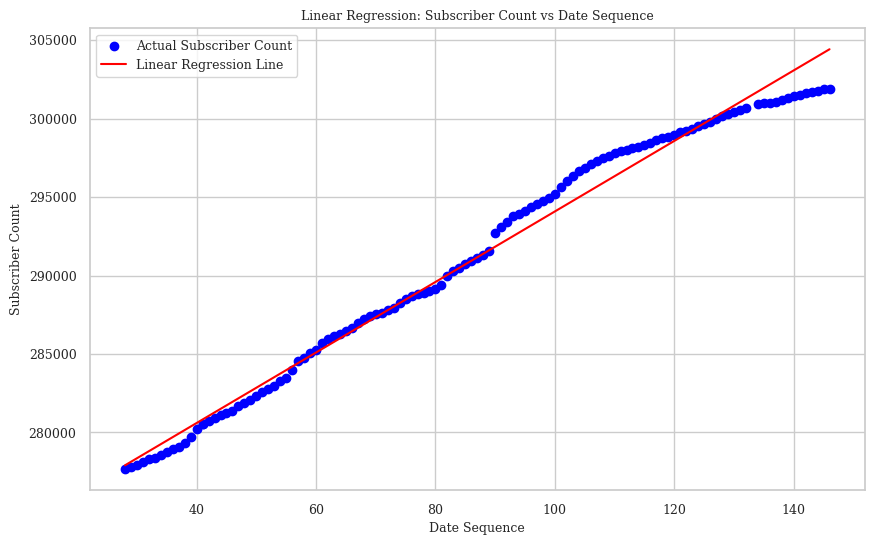

Model Coefficient (Slope): 224.6785272666266
Model Intercept: 271617.3246362785


In [56]:
%matplotlib inline

# Assuming 'group' DataFrame already has 'date_sequence' and 'subscriberCount' columns
# Let's set 'x' (date_sequence) and 'y' (subscriberCount)

x_full = group['date_sequence'].values.reshape(-1, 1)
y_full = group['subscriberCount'].values

# Take the first one third of the data
one_third_length = len(x_full) // 1
x = x_full[:one_third_length]
y = y_full[:one_third_length]

# Create the linear regression model
model = LinearRegression()

# Fit the model with the data
model.fit(x, y)

# Predict the values based on the model
y_pred = model.predict(x)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Actual Subscriber Count')
plt.plot(x, y_pred, color='red', label='Linear Regression Line')
plt.xlabel('Date Sequence')
plt.ylabel('Subscriber Count')
plt.title('Linear Regression: Subscriber Count vs Date Sequence')
plt.legend()
plt.show()

# Optionally, print the model's coefficients (slope and intercept)
print(f"Model Coefficient (Slope): {model.coef_[0]}")
print(f"Model Intercept: {model.intercept_}")


In [57]:

# Replace 'query_channel' with the actual channel ID or name you're querying
# the coming in collabs
filtered_df = df_graph_filtered[df_graph_filtered['from'] == name]
video_metadata = pd.read_csv("video_metadata_with_timestamps_utc.csv")
video_ids = filtered_df['videos'].explode()
timestamps = video_metadata[video_metadata['video_id'].isin(video_ids)]
timestamp_list = timestamps['timestamp'].tolist()
video_timestamp_list = [pd.to_datetime(ts) for ts in timestamp_list]
print(video_timestamp_list)

# the going out collabs
filtered_df2 = df_graph_filtered[df_graph_filtered['to'] == name]
video_metadata2 = pd.read_csv("video_metadata_with_timestamps_utc.csv")
video_ids2 = filtered_df2['videos'].explode()
timestamps2 = video_metadata2[video_metadata2['video_id'].isin(video_ids2)]
timestamp_list2 = timestamps2['timestamp'].tolist()
print("timestamp list is ", timestamp_list2)

video_timestamp_list2 = [pd.to_datetime(ts) for ts in timestamp_list2]
print(video_timestamp_list2)

# Convert strings to datetime and strip to date
dates = [pd.to_datetime(ts).date() for ts in timestamp_list]
date_sequence = [date_mapping.get(date, None) for date in dates]
print(date_sequence)

[Timestamp('2017-01-15 00:48:32'), Timestamp('2017-02-15 22:35:17'), Timestamp('2017-03-01 20:13:34'), Timestamp('2017-01-28 19:35:41'), Timestamp('2017-02-18 21:05:39'), Timestamp('2017-03-05 19:24:39'), Timestamp('2017-02-11 18:36:16'), Timestamp('2017-02-26 20:18:58'), Timestamp('2017-01-07 19:24:02'), Timestamp('2017-03-22 00:37:41'), Timestamp('2017-01-21 22:20:19'), Timestamp('2016-12-31 19:18:23'), Timestamp('2017-01-28 19:39:32'), Timestamp('2017-03-25 17:13:42'), Timestamp('2017-01-14 22:09:08'), Timestamp('2017-02-27 00:51:19'), Timestamp('2017-01-29 20:08:33'), Timestamp('2017-01-21 20:59:55'), Timestamp('2017-02-11 19:54:53'), Timestamp('2017-01-15 18:21:44'), Timestamp('2017-03-19 19:23:55'), Timestamp('2017-02-18 21:20:26')]
timestamp list is  ['2017-02-02 21:53:20', '2017-03-01 18:05:48']
[Timestamp('2017-02-02 21:53:20'), Timestamp('2017-03-01 18:05:48')]
[46, 77, 91, 59, 80, 95, 73, 88, 38, 112, 52, 31, 59, 115, 45, 89, 60, 52, 73, 46, 109, 80]


In [58]:

# Example: target_dates = list of collaboration timestamps (as datetime)
# You can loop over all collaboration timestamps for each channel
results = []

for collab_date in date_sequence:  # date_sequence is your list of collab timestamps
    before_date = collab_date - 7
    after_date = collab_date + 7

    before_row = group[group['date_sequence'] == before_date]
    after_row = group[group['date_sequence'] == after_date]

    if not before_row.empty and not after_row.empty:
        before_count = before_row['subscriberCount'].values[0]
        after_count = after_row['subscriberCount'].values[0]
        diff = after_count - before_count

        results.append({
            'collab_date': collab_date,
            'subscriber_before': before_count,
            'subscriber_after': after_count,
            'difference': diff
        })

# Convert to DataFrame for analysis or plotting
df_diff = pd.DataFrame(results)

print(df_diff)


    collab_date  subscriber_before  subscriber_after  difference
0            46             279719            282986        3267
1            77             287522            290502        2980
2            91             290502            294740        4238
3            59             282761            286680        3919
4            80             287950            291128        3178
5            95             291328            296029        4701
6            73             286680            289151        2471
7            88             289398            294108        4710
8            38             278146            281227        3081
9           112             296872            298858        1986
10           52             281227            285060        3833
11           59             282761            286680        3919
12          115             297493            299224        1731
13           45             279300            282761        3461
14           89          

In [43]:
#  finding the impact
date_sequence_act = [x + 7 for x in date_sequence]
date_sequence_pred_before = [x - 7 for x in date_sequence]

x_new_before = np.array(date_sequence_pred_before).reshape(-1, 1)
x_new = np.array(date_sequence).reshape(-1, 1)
x_new_act = np.array(date_sequence_act).reshape(-1, 1)

# Predict using the trained model
pred_subscriber_counts_before = model.predict(x_new_before)
pred_subscriber_counts = model.predict(x_new)
pred_subscriber_counts_act = model.predict(x_new_act)

pred_diff = pred_subscriber_counts + pred_subscriber_counts - pred_subscriber_counts_before

# Show predictions
results = pd.DataFrame({
    'date_sequence': date_sequence_act,
    'predicted_subscriberCount': pred_diff,
    'pred_after_7_days': pred_subscriber_counts_act
})

# Merge with actual values from group DataFrame
merged = results.merge(group[['date_sequence', 'subscriberCount']], on='date_sequence', how='left')

# Calculate the difference
merged['difference'] = merged['subscriberCount'] - merged['predicted_subscriberCount']

# Display the result
print(merged[['date_sequence', 'subscriberCount', 'pred_after_7_days', 'difference']])

   date_sequence  subscriberCount  pred_after_7_days   difference
0             80            89689       88034.556593  1654.443407
1            122            94896       96921.481997 -2025.481997
2            122            94896       96921.481997 -2025.481997


# bas yaha tak karna hai

In [39]:
print(timestamps)
print(timestamps2)

# Pehle date format define karo
date_format = "%Y-%m-%d %H:%M:%S"

# timestamps dataframe ke liye
timestamps['timestamp'] = timestamps['timestamp'].apply(lambda x: datetime.strptime(x, date_format))
timestamps['date_plus'] = timestamps['timestamp'] + timedelta(days=2)

# timestamps2 dataframe ke liye
timestamps2['timestamp'] = timestamps2['timestamp'].apply(lambda x: datetime.strptime(x, date_format))
timestamps2['date_plus'] = timestamps2['timestamp'] + timedelta(days=2)

df_group_videos = pd.concat([timestamps, timestamps2], ignore_index=True)
df_group_videos.head()

         video_id            timestamp
3604  n6b1wkB-_PM  2016-12-31 17:49:38
3605  qf_bPWgK66Q  2017-03-13 23:12:45
         video_id            timestamp
450   67wKZoeM26w  2016-12-29 14:00:00
451   JpGkC5n_I7s  2016-12-30 19:21:47
1510  93sV_K4hqgs  2016-12-28 14:00:00
1846  _bIHzg3lzIQ  2017-03-12 15:54:47
2796  D0V0A-osgfc  2017-02-03 13:53:30


/tmp/ipykernel_39734/2351512725.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamps['timestamp'] = timestamps['timestamp'].apply(lambda x: datetime.strptime(x, date_format))
/tmp/ipykernel_39734/2351512725.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamps['date_plus'] = timestamps['timestamp'] + timedelta(days=2)
/tmp/ipykernel_39734/2351512725.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,video_id,timestamp,date_plus
0,n6b1wkB-_PM,2016-12-31 17:49:38,2017-01-02 17:49:38
1,qf_bPWgK66Q,2017-03-13 23:12:45,2017-03-15 23:12:45
2,67wKZoeM26w,2016-12-29 14:00:00,2016-12-31 14:00:00
3,JpGkC5n_I7s,2016-12-30 19:21:47,2017-01-01 19:21:47
4,93sV_K4hqgs,2016-12-28 14:00:00,2016-12-30 14:00:00


In [156]:
from matplotlib.dates import DateFormatter

subs = group['subscriberCount'].values
group.drop(group.index[:1], inplace=True)

group['gradient'] = np.diff(subs)
group['collab_window'] = 'Non_Collab'

for index, row in df_group_videos.iterrows():
    date, date_plus = row['timestamp'], row['date_plus']
    filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
    group.loc[filtered.index, 'collab_window'] = 'Collab'
group

/tmp/ipykernel_16309/486885168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.drop(group.index[:1], inplace=True)
/tmp/ipykernel_16309/486885168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['gradient'] = np.diff(subs)
/tmp/ipykernel_16309/486885168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp,gradient,collab_window
3495,UCavTVjugW1OejDAq0aDzdMw,67020969.0,1194901,8366,292,2016-12-30 00:01:18,1327,Collab
5093,UCavTVjugW1OejDAq0aDzdMw,67106185.0,1196528,8366,293,2016-12-31 00:01:20,1627,Collab
6692,UCavTVjugW1OejDAq0aDzdMw,67195059.0,1198246,8366,293,2017-01-01 00:01:18,1718,Collab
8292,UCavTVjugW1OejDAq0aDzdMw,67397785.0,1199890,8366,293,2017-01-02 00:01:22,1644,Collab
9889,UCavTVjugW1OejDAq0aDzdMw,67531599.0,1201484,8366,293,2017-01-03 00:01:18,1594,Non_Collab
...,...,...,...,...,...,...,...,...
183647,UCavTVjugW1OejDAq0aDzdMw,73324745.0,1267053,8366,300,2017-04-21 00:02:12,426,Non_Collab
185247,UCavTVjugW1OejDAq0aDzdMw,73355506.0,1267374,8366,300,2017-04-22 00:02:05,321,Non_Collab
186846,UCavTVjugW1OejDAq0aDzdMw,73381845.0,1267290,8366,301,2017-04-23 00:03:58,-84,Non_Collab
188444,UCavTVjugW1OejDAq0aDzdMw,73406302.0,1267520,8366,301,2017-04-24 00:01:30,230,Non_Collab


/tmp/ipykernel_16309/996199270.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])


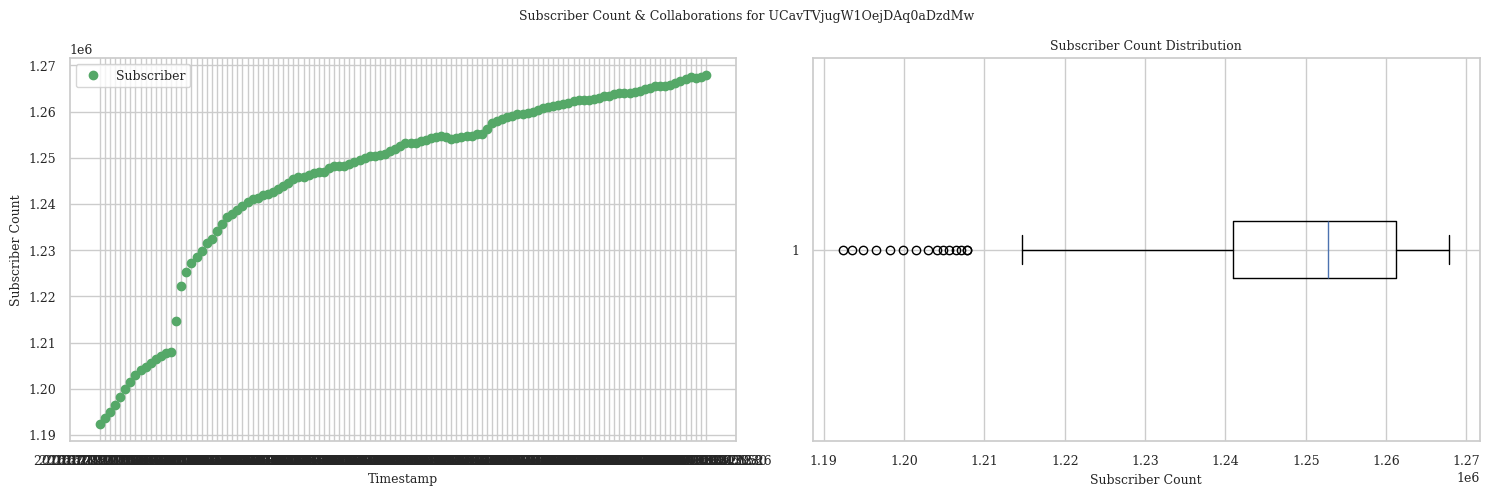

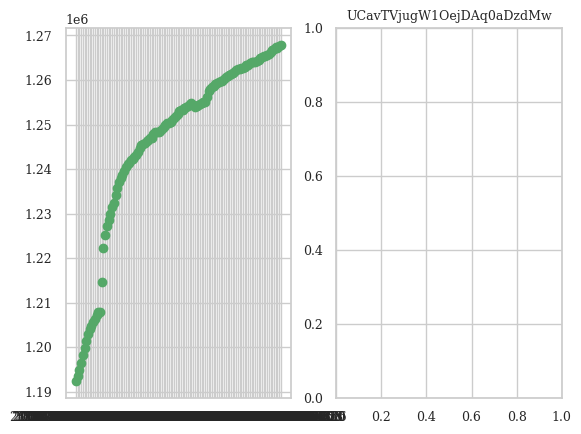

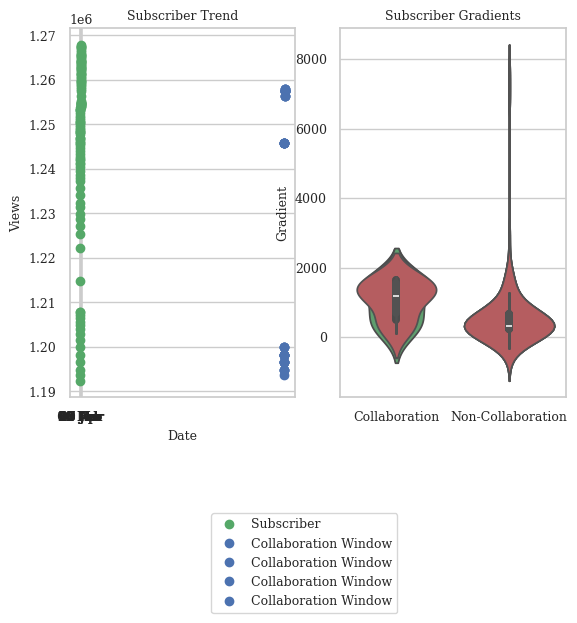

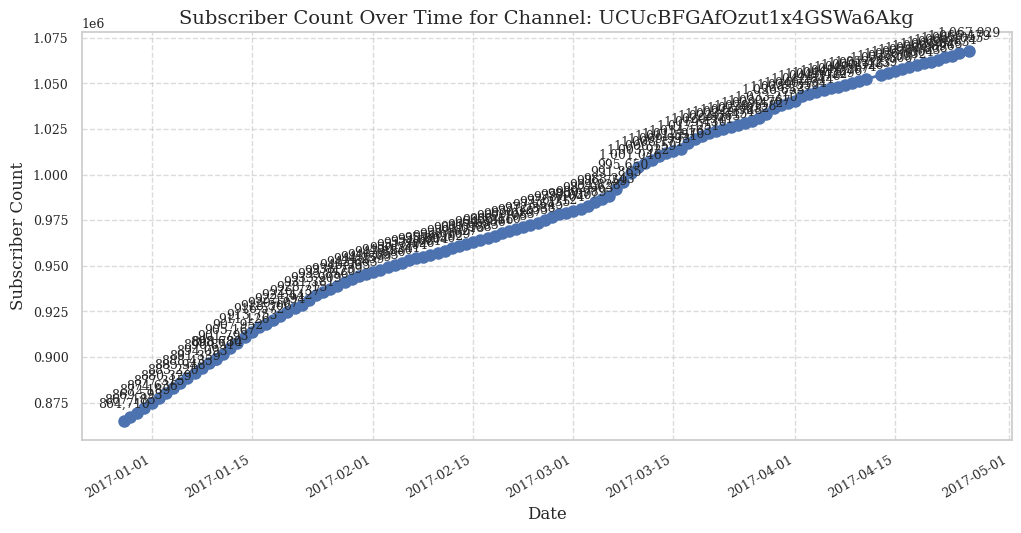

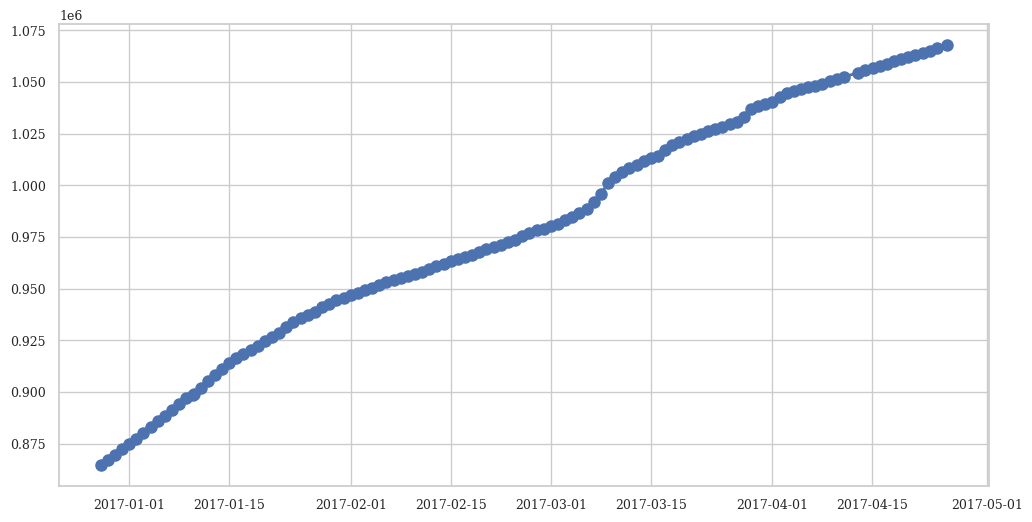

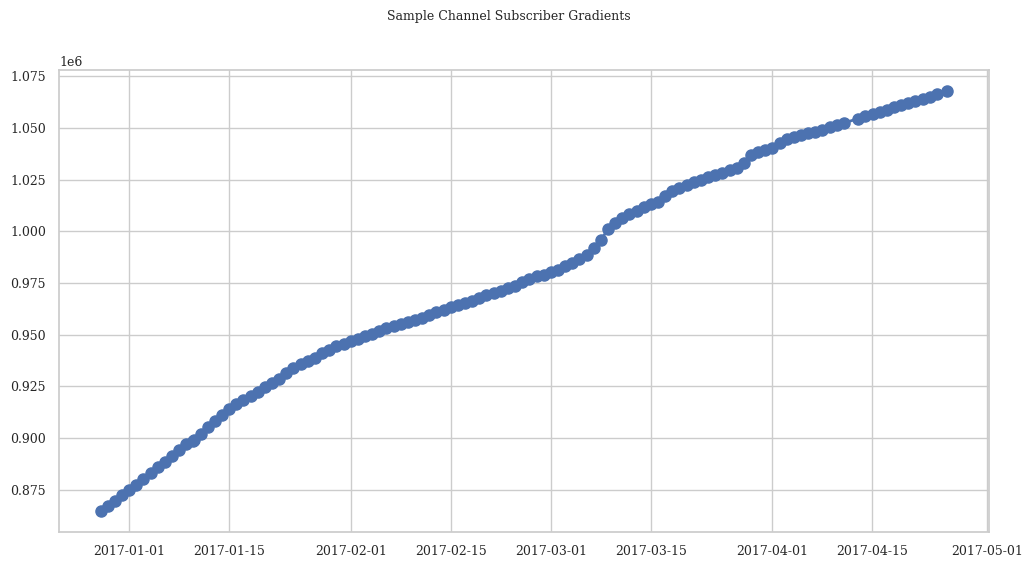

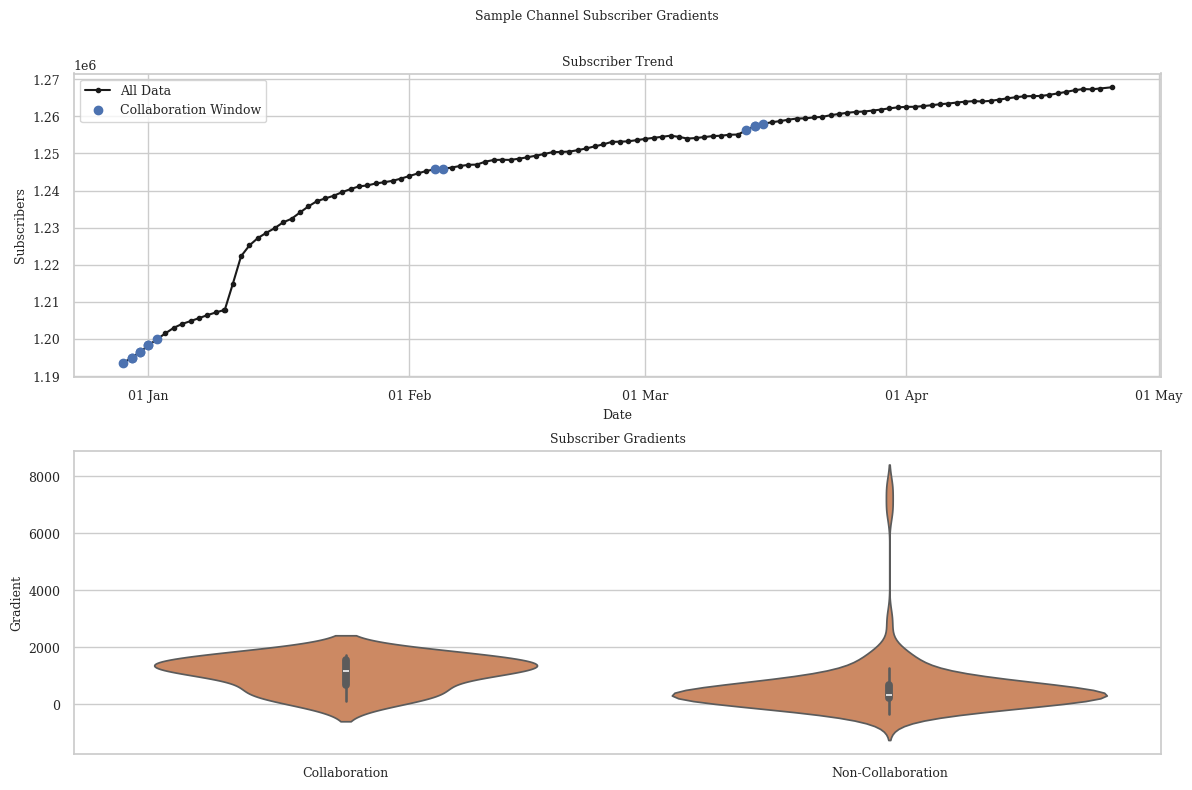

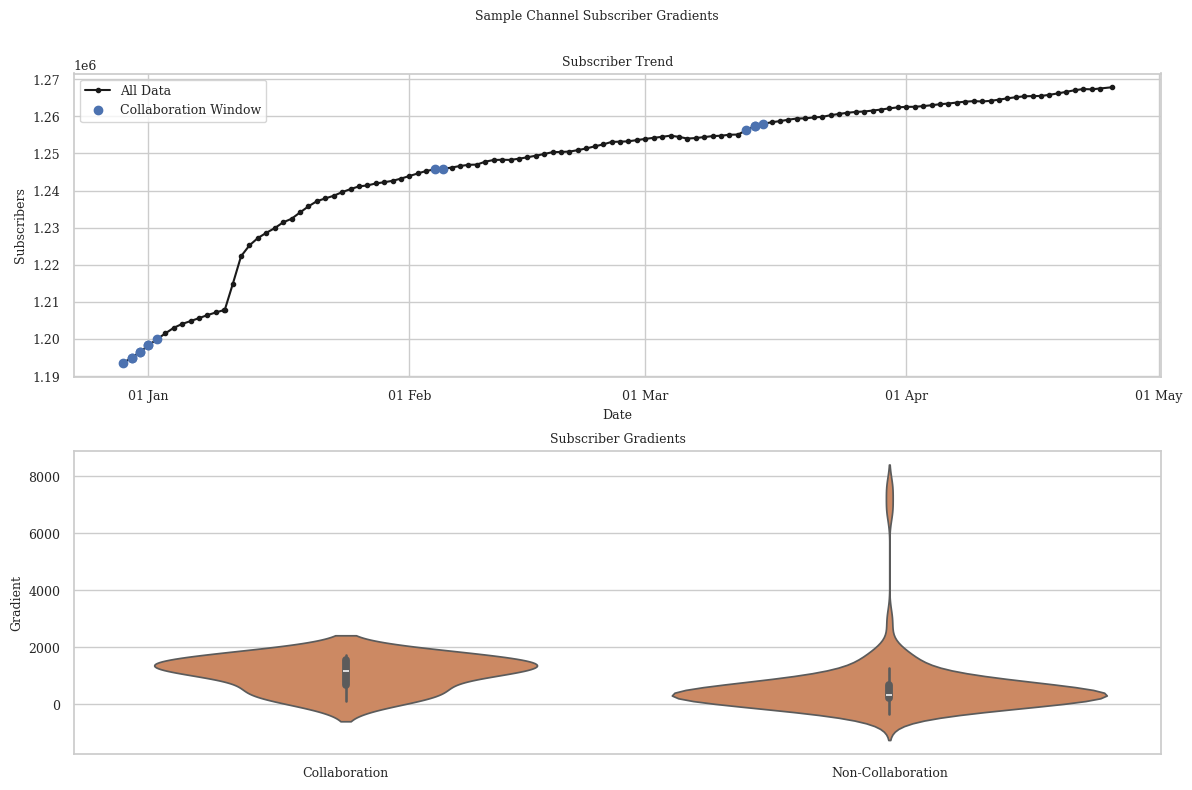

In [151]:
%matplotlib inline


import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot full subscriber trend
ax1.plot(group['crawlTimestamp'], group['subscriberCount'], 'k.-', label='All Data')

# Overlay collaboration windows
label = True
for index, row in df_group_videos.iterrows():
    date, date_plus = row['timestamp'], row['date_plus']
    filtered = group[(group['crawlTimestamp'] > date) & (group['crawlTimestamp'] < date_plus)]
    ax1.plot(filtered['crawlTimestamp'], filtered['subscriberCount'], 'bo', label="Collaboration Window" if label else "")
    label = False

# Format x-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Subscribers')
fmt = DateFormatter("%d %b")
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.xaxis.set_major_formatter(fmt)
ax1.legend(loc='best')
ax1.set_title('Subscriber Trend')

# Violin plot of gradients
sns.violinplot(x="collab_window", y="gradient", data=group, ax=ax2, order=['Collab', 'Non_Collab'])
ax2.set_title('Subscriber Gradients')
ax2.set_ylabel('Gradient')
ax2.set_xlabel('')
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])

# Overall title
plt.suptitle('Sample Channel Subscriber Gradients')
fig.tight_layout()
fig.subplots_adjust(top=0.9)

# Display plot inline
plt.show()
